In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D
import Simple_RCWA

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Visualize Target Spectra

freq_true.shape (1003,)
R_true.shape (201,)


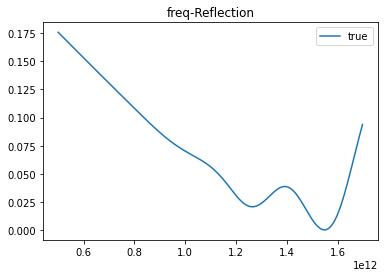

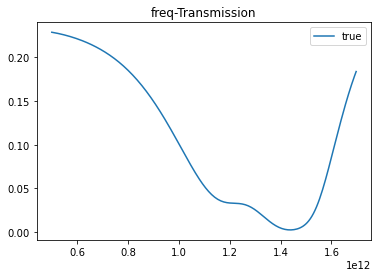

1098
(222,)
idx_freq_tg1 ORIG: 151
idx_freq_tg1: 166.77611940298507
R_tg1: 0.038314723405216806
T_tg1: 0.004280525157849011
T_tg2: 0.22840801357720697
--------
idx_freq_tg2 ORIG: 117
idx_freq_tg2: 129.22388059701493
R_tg2: 0.03066116289643781


In [4]:
path_true_R = './Simple_RCWA/data/R_absorber.txt'
R_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_R)
freq_true = R_file[:, 0] * 1e12
R_true = R_file[:, 1]
R_true = R_true**2
print('freq_true.shape', freq_true.shape)
# print(R_true)

path_true_T = './Simple_RCWA/data/T_absorber.txt'
T_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_T)
T_true = T_file[:, 1]
T_true = T_true**2

# truncate freq
freq_truncate = 1.7  # in THz
N_freq_stop = np.argmax(R_file[:,0]>freq_truncate)
freq_true = freq_true[:N_freq_stop]
R_true = R_true[:N_freq_stop]
T_true = T_true[:N_freq_stop]
freq_step = 4
freq_true, R_true, T_true = freq_true[::freq_step], R_true[::freq_step], T_true[::freq_step]
print('R_true.shape', R_true.shape)

plt.figure(1)
plt.plot(freq_true, R_true, label='true')
plt.title('freq-Reflection')
plt.legend()

plt.figure(2)
plt.plot(freq_true, T_true, label='true')
plt.title('freq-Transmission')
plt.legend()
plt.show()

# ================= Material Property Define
path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
print(eps_absorber_file.shape[0])
# truncate freq over 1.7THz
# freq_truncate = 1.7  # in THz
# freq_step = 4
if freq_truncate != 'none' and freq_truncate>eps_absorber_file[0,0] and freq_truncate<eps_absorber_file[-1,0]:
    N_freq_stop = np.argmax(eps_absorber_file[:,0]>freq_truncate)
    eps_absorber_file = eps_absorber_file[:N_freq_stop]
eps_absorber_file = eps_absorber_file[::freq_step]  # solve rcwa with a step size
eps_absorber = eps_absorber_file[:,1] + eps_absorber_file[:,2]*1j

freq = eps_absorber_file[:,0]*1e12
print(freq.shape)


# ================== Get Target Spectra Value
# print(freq_true)
idx_freq_tg1 = np.min(np.argwhere(freq_true>=1.4*1e12))
print('idx_freq_tg1 ORIG:', idx_freq_tg1)
R_tg1 = R_true[idx_freq_tg1]
T_tg1 = T_true[idx_freq_tg1]
T_tg2 = T_true[0]

idx_freq_tg1 = idx_freq_tg1/201*222
print('idx_freq_tg1:', idx_freq_tg1)
print('R_tg1:', R_tg1)
print('T_tg1:', T_tg1)
print('T_tg2:', T_tg2)


print('--------')
idx_freq_tg2 = np.min(np.argwhere(freq_true>=1.2*1e12))
print('idx_freq_tg2 ORIG:', idx_freq_tg2)
R_tg2 = R_true[idx_freq_tg2]

idx_freq_tg2 = idx_freq_tg2/201*222
print('idx_freq_tg2:', idx_freq_tg2)
print('R_tg2:', R_tg2)

# Looping to generate data and training

In [5]:
def visualize_trained_net(dataloader_test, size_fig=(21,12)):
    for idx, data in enumerate(dataloader_test):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_pred = net_dense(X)  # [N_eg,2,N_freq]

        y_np = y.cpu().detach().numpy()
        y_pred_np = y_pred.cpu().detach().numpy()
        if idx==0:
            y_test_np = y_np
            y_test_pred_np = y_pred_np
        else:
            y_test_np = np.concatenate((y_test_np,y_np), axis=0)
            y_test_pred_np = np.concatenate((y_test_pred_np,y_pred_np), axis=0)
            
        if y_test_pred_np.shape[0]>=4:
            break
    print('y_test_np.shape:', y_test_np.shape)
    print('y_test_pred_np.shape:', y_test_pred_np.shape)

    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Training result on test set: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Training result on test set: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))
    plt.show()
    
    
def visualize_spectra_search(params_pick, R_pick, T_pick, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra search result: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra search result: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()
    
    
def visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra of learned network and RCWA: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(R_simu.shape[1]), R_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra of learned network and RCWA: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(T_simu.shape[1]), T_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 100
Sample points number available, continue calculating...
----------------
[ 1 / 100 ] [D1, D2] = [ 77. 117.]
Calculation Progress: 100%
----------------
[ 2 / 100 ] [D1, D2] = [146.  53.]
Calculation Progress: 100%
----------------
[ 3 / 100 ] [D1, D2] = [ 77. 113.]
Calculation Progress: 100%
----------------
[ 4 / 100 ] [D1, D2] = [ 57. 148.]
Calculation Progress: 100%
----------------
[ 5 / 100 ] [D1, D2] = [65. 95.]
Calculation Progress: 100%
----------------
[ 6 / 100 ] [D1, D2] = [101.  68.]
Calculation Progress: 100%
----------------
[ 7 / 100 ] [D1, D2] = [111. 142.]
Calculation Progress: 100%
----------------
[ 8 / 100 ] [D1, D2] = [128. 114.]
Calculation Progress: 100%
----------------
[ 9 / 100 ] [D1, D2] = [ 51. 119.]
Calculation Progress: 100%
----------------
[ 10 / 100 ] [D1, D2] = [106. 118.]
Calculation Progress: 100%
-

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.0029897009101114234
### TEST LOSS  0.001605055236723274
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.0010348054766654968
### TEST LOSS  0.0009157961176242679
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 0.0004049220675005927
### TEST LOSS  0.00043733837082982063
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 0.0005816009927366395
### TEST LOSS  0.0005030560423620045
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 0.0004217131825862452
### TEST LOSS  0.0006686348933726549
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 0.00039243504135811236
### TEST LOSS  0.00042095594108104706
----------------------------------------------------------------------
***

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.418609631855361e-05
### TEST LOSS  6.658180154772708e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 9.231488173782053e-06
### TEST LOSS  5.898956487726537e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 9.733263904081468e-06
### TEST LOSS  8.150136636686511e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.367448548194261e-05
### TEST LOSS  5.29411204297503e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.3742825381086732e-05
### TEST LOSS  1.028505221256637e-05
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.2555882982496769e-05
### TEST LOSS  1.3397326256381348e-05
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.1783055842329304e-06
### TEST LOSS  1.0305373052688083e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 2.1222921930075246e-06
### TEST LOSS  1.4434946251640213e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.6846259205749447e-06
### TEST LOSS  1.2908369626529748e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.3419614744236696e-06
### TEST LOSS  9.434941432573396e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.0654844291480003e-06
### TEST LOSS  7.89513137533504e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 1.195609771116324e-06
### TEST LOSS  8.715769581613131e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.357655576039179e-07
### TEST LOSS  7.5252893338984e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.252983901333665e-07
### TEST LOSS  7.72820357042292e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 5.883173287202226e-07
### TEST LOSS  5.733056980261608e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 6.89895728811507e-07
### TEST LOSS  9.824497340105154e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 8.01353955068862e-07
### TEST LOSS  7.653479769942351e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 9.43658627647892e-07
### TEST LOSS  7.559780499377666e-07
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 4.470263490929938e-07
### TEST LOSS  5.291511655514114e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.5522136193909546e-07
### TEST LOSS  5.544277428271016e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 5.180592602016531e-07
### TEST LOSS  4.860382603055768e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 5.819843805454639e-07
### TEST LOSS  3.602031171112685e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 4.430969373458993e-07
### TEST LOSS  4.806044131555609e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 4.82111315847078e-07
### TEST LOSS  4.288813073571873e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.465677175209294e-07
### TEST LOSS  3.236972503373181e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 3.7584786902300496e-07
### TEST LOSS  3.368034526829433e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.6590199389129337e-07
### TEST LOSS  3.550696447973678e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 3.914767737001057e-07
### TEST LOSS  2.462068664499384e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.762691293474063e-07
### TEST LOSS  4.116840415235856e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.536853470289316e-07
### TEST LOSS  3.376223247641974e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 1.623421450815954e-06
### TEST LOSS  6.791613941459218e-06
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.8700116921907014e-06
### TEST LOSS  1.7060156665138493e-06
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 1.5379296084461204e-06
### TEST LOSS  8.99316319191712e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 8.63357031448686e-07
### TEST LOSS  6.510075820642669e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 7.143096659945058e-07
### TEST LOSS  7.314492052046262e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 7.17679384223402e-07
### TEST LOSS  8.210472515202127e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.735301167751004e-07
### TEST LOSS  1.8351253316950533e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.0206494713524987e-07
### TEST LOSS  2.2361003004789382e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 2.533931170134451e-07
### TEST LOSS  1.9363599790267472e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 2.4419485910698314e-07
### TEST LOSS  3.5750209548268685e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.353552632034962e-07
### TEST LOSS  3.0684066132380394e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 2.5129402402512825e-07
### TEST LOSS  2.7104833577595855e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 2.3686958975588367e-07
### TEST LOSS  2.0764202446343916e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 2.3118015814560523e-07
### TEST LOSS  2.0608104023267515e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 2.255571796183631e-07
### TEST LOSS  1.738834853881599e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.6560308938883283e-07
### TEST LOSS  3.131923307364559e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 2.2501861828061466e-07
### TEST LOSS  2.555485139055236e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 2.1815419493975695e-07
### TEST LOSS  2.0407134115885128e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 2.0889169912052809e-07
### TEST LOSS  2.1880930489714956e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 2.367516812995518e-07
### TEST LOSS  2.544122850167696e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 2.482513216861548e-07
### TEST LOSS  2.06469728425418e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 2.1356283708584555e-07
### TEST LOSS  1.417801698266885e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 2.668944649641958e-07
### TEST LOSS  3.7441934352955286e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.935927170000241e-07
### TEST LOSS  2.5515092261230166e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 2.935996037933819e-07
### TEST LOSS  2.649961885481389e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 3.8718764457712494e-07
### TEST LOSS  3.1430320746039797e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.4433692153234006e-07
### TEST LOSS  7.827547392480483e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 5.128317611990951e-07
### TEST LOSS  9.557019495787245e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 8.530832410258427e-07
### TEST LOSS  1.0036491460141406e-06
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 5.513776446974816e-07
### TEST LOSS  4.6592300861902913e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.233724244784298e-07
### TEST LOSS  2.775132159626992e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 2.124529871849745e-07
### TEST LOSS  2.5824956395581466e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 2.105629496185202e-07
### TEST LOSS  3.039504008484073e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.089108185288069e-07
### TEST LOSS  1.4312499985180693e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 1.622502787057556e-07
### TEST LOSS  1.3444199709056193e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 2.3036605920623287e-07
### TEST LOSS  1.9201218037778744e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 1.9379775569206005e-07
### TEST LOSS  1.2498819756956436e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 1.6728137357091554e-07
### TEST LOSS  1.3960261924239603e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 1.5830842063024874e-07
### TEST LOSS  2.2146411282619738e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 2.782067859996573e-07
### TEST LOSS  2.0036889480934406e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.1561380805223962e-07
### TEST LOSS  1.6670358604642388e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.0221327485359097e-07
### TEST LOSS  2.3793058545606982e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 2.2981953392786636e-07
### TEST LOSS  3.551790399569654e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.837815907597019e-07
### TEST LOSS  1.9662786598928506e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 1.5337622873090594e-07
### TEST LOSS  1.5866420710608509e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 1.2683002012181533e-07
### TEST LOSS  1.2648646929847018e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 1.5471582727855094e-07
### TEST LOSS  1.5575095346775925e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.812841401933497e-07
### TEST LOSS  2.317876024449106e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 1.6721315711620833e-07
### TEST LOSS  1.0188430721314035e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 1.7691687164145265e-07
### TEST LOSS  1.0141781459083177e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 1.5247198767553982e-07
### TEST LOSS  1.633537465295376e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.247509184982732e-07
### TEST LOSS  2.739216000691158e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 1.6753741501673859e-07
### TEST LOSS  1.3982325697270426e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 1.6200927603904348e-07
### TEST LOSS  1.457248828273805e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.234472068669447e-07
### TEST LOSS  7.051522175061109e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.36985258609468e-07
### TEST LOSS  1.4246515434024332e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 1.8234145137796532e-07
### TEST LOSS  1.6355011922541962e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 1.4014838852105528e-07
### TEST LOSS  1.285347543955595e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 1.1830126005918374e-07
### TEST LOSS  8.936572015727506e-08
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 1.1398727048472779e-07
### TEST LOSS  1.0568227537532948e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 1.8358067102042242e-07
### TEST LOSS  2.7689674197972636e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.7648442130944204e-07
### TEST LOSS  1.366496960031327e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 1.44230869096873e-07
### TEST LOSS  1.350379648101807e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 1.7458231265976565e-07
### TEST LOSS  1.3252981645450745e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 1.5666782466894346e-07
### TEST LOSS  8.903512949132164e-08
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 1.9292856723751583e-07
### TEST LOSS  2.3317861774785342e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 1.3549610754282072e-07
### TEST LOSS  8.680512664227535e-08
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 1.0828786846772686e-07
### TEST LOSS  7.618016084620649e-08
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 8.826755626856197e-08
### TEST LOSS  1.8029026449539742e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 1.9044330123563214e-07
### TEST LOSS  1.666696149982272e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.0219383905460973e-07
### TEST LOSS  1.926942090335615e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.2039863381451141e-07
### TEST LOSS  1.6965971383342549e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 1.0948240007024879e-07
### TEST LOSS  1.0711697129295317e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 1.5993113255063919e-07
### TEST LOSS  1.3254373953941467e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 1.1117799452620148e-07
### TEST LOSS  9.102390663429105e-08
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 1.29832453872325e-07
### TEST LOSS  1.3253863428985824e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.0660237723291175e-07
### TEST LOSS  2.4507051676891933e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.3694863112998517e-07
### TEST LOSS  3.046537244699721e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 1.1502237427407636e-07
### TEST LOSS  9.783609655755754e-08
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 1.636220110512454e-07
### TEST LOSS  9.147748514237719e-08
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 1.520514340214163e-07
### TEST LOSS  1.4982565232912748e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 1.3240759734856057e-07
### TEST LOSS  1.507331219841035e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 8.926118189478415e-08
### TEST LOSS  9.599775907531694e-08
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 8.807758650419828e-08
### TEST LOSS  7.45272537017172e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 1.0062345413786034e-07
### TEST LOSS  7.570613647089885e-08
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 6.755348159970254e-08
### TEST LOSS  6.127982921100283e-08
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 8.217258627318813e-08
### TEST LOSS  6.893460735568624e-08
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 7.233280773455419e-08
### TEST LOSS  4.992067914599829e-08
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 1.0682329190103701e-07
### TEST LOSS  6.074870384509268e-08
----------------------------------------------------------------------
*** EPOCH 1066 || AVG LOSS 8.735301059381583e-08
### TEST LOSS  1.1042559933116536e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 8.765926443388139e-08
### TEST LOSS  6.461439383542711e-08
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 8.227124025594889e-08
### TEST LOSS  8.315633337474537e-08
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 9.478511957539126e-08
### TEST LOSS  8.25056147846226e-08
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 8.63053298161276e-08
### TEST LOSS  6.300655996938076e-08
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 9.020751075894395e-08
### TEST LOSS  6.637361416039766e-08
----------------------------------------------------------------------
*** EPOCH 1118 || AVG LOSS 6.677448120662177e-08
### TEST LOSS  4.974311629268868e-08
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 1.1014540689302521e-07
### TEST LOSS  6.032656862942076e-08
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 6.69407037712233e-08
### TEST LOSS  5.245785317242735e-08
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 7.165281115106837e-08
### TEST LOSS  1.4205967602265446e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 9.140830536935596e-08
### TEST LOSS  5.360357313577424e-08
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 6.553950627985472e-08
### TEST LOSS  7.485112085703349e-08
----------------------------------------------------------------------
*** EPOCH 1171 || AVG LOSS 8.07458261586902e-08
### TEST LOSS  7.702985271862417e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 8.49558575666265e-08
### TEST LOSS  5.554965198939499e-08
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 9.707500503886024e-08
### TEST LOSS  9.086578955930236e-08
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 8.513404178067673e-08
### TEST LOSS  4.7132672875704884e-08
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 7.333888332183847e-08
### TEST LOSS  5.709670602982442e-08
----------------------------------------------------------------------
*** EPOCH 1223 || AVG LOSS 8.041850266593542e-08
### TEST LOSS  8.808425633333172e-08
----------------------------------------------------------------------
*** EPOCH 1224 || AVG LOSS 6.986651710505498e-08
### TEST LOSS  6.132854224460971e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 7.613900307568144e-08
### TEST LOSS  5.134311109600276e-08
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 5.959405642741444e-08
### TEST LOSS  5.04124297862063e-08
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 5.5405176953016167e-08
### TEST LOSS  7.864703377435944e-08
----------------------------------------------------------------------
*** EPOCH 1275 || AVG LOSS 6.249234926869462e-08
### TEST LOSS  4.2213656570311286e-08
----------------------------------------------------------------------
*** EPOCH 1276 || AVG LOSS 5.406893014203717e-08
### TEST LOSS  5.267098934780279e-08
----------------------------------------------------------------------
*** EPOCH 1277 || AVG LOSS 8.326228750910047e-08
### TEST LOSS  7.168445392835565e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 6.646835128520933e-08
### TEST LOSS  5.705556205271023e-08
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 6.468571768003529e-08
### TEST LOSS  1.1536943489431906e-07
----------------------------------------------------------------------
*** EPOCH 1327 || AVG LOSS 6.665344164602515e-08
### TEST LOSS  7.259196266318213e-08
----------------------------------------------------------------------
*** EPOCH 1328 || AVG LOSS 6.04874965137725e-08
### TEST LOSS  6.614561343099012e-08
----------------------------------------------------------------------
*** EPOCH 1329 || AVG LOSS 7.727057356632372e-08
### TEST LOSS  6.43913402598173e-08
----------------------------------------------------------------------
*** EPOCH 1330 || AVG LOSS 5.999398351441698e-08
### TEST LOSS  4.7333855945908e-08
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 5.2533253649400536e-08
### TEST LOSS  4.1266080330615296e-08
----------------------------------------------------------------------
*** EPOCH 1379 || AVG LOSS 5.063391419479757e-08
### TEST LOSS  4.605017167591541e-08
----------------------------------------------------------------------
*** EPOCH 1380 || AVG LOSS 5.4617138549595266e-08
### TEST LOSS  6.858874357362765e-08
----------------------------------------------------------------------
*** EPOCH 1381 || AVG LOSS 4.86365108542941e-08
### TEST LOSS  4.8244006123354666e-08
----------------------------------------------------------------------
*** EPOCH 1382 || AVG LOSS 4.558853266889429e-08
### TEST LOSS  3.724482233735671e-08
----------------------------------------------------------------------
*** EPOCH 1383 || AVG LOSS 6.67942240095698e-08
### TEST LOSS  4.763086103309888e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1431 || AVG LOSS 6.219928959438903e-08
### TEST LOSS  5.162957705806548e-08
----------------------------------------------------------------------
*** EPOCH 1432 || AVG LOSS 7.408034156775045e-08
### TEST LOSS  4.39416627528999e-08
----------------------------------------------------------------------
*** EPOCH 1433 || AVG LOSS 6.207568929994522e-08
### TEST LOSS  1.3893625094851814e-07
----------------------------------------------------------------------
*** EPOCH 1434 || AVG LOSS 1.1442622197321839e-07
### TEST LOSS  9.395483502316893e-08
----------------------------------------------------------------------
*** EPOCH 1435 || AVG LOSS 8.81042002021104e-08
### TEST LOSS  8.431122111574041e-08
----------------------------------------------------------------------
*** EPOCH 1436 || AVG LOSS 6.048144869374994e-08
### TEST LOSS  6.046509959389823e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1484 || AVG LOSS 5.4728675005222275e-08
### TEST LOSS  3.512509216818671e-08
----------------------------------------------------------------------
*** EPOCH 1485 || AVG LOSS 6.10197576644822e-08
### TEST LOSS  4.2090421814577894e-08
----------------------------------------------------------------------
*** EPOCH 1486 || AVG LOSS 6.303415135633372e-08
### TEST LOSS  4.8540277575170876e-08
----------------------------------------------------------------------
*** EPOCH 1487 || AVG LOSS 5.865622888734379e-08
### TEST LOSS  1.3733274784044625e-07
----------------------------------------------------------------------
*** EPOCH 1488 || AVG LOSS 5.607149888398055e-08
### TEST LOSS  4.4419547151619554e-08
----------------------------------------------------------------------
*** EPOCH 1489 || AVG LOSS 5.0871040464528504e-08
### TEST LOSS  4.292511412984368e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1537 || AVG LOSS 5.034503789413947e-08
### TEST LOSS  5.5838944135189195e-08
----------------------------------------------------------------------
*** EPOCH 1538 || AVG LOSS 5.612716237557436e-08
### TEST LOSS  4.6956202481851506e-08
----------------------------------------------------------------------
*** EPOCH 1539 || AVG LOSS 5.5167861838789636e-08
### TEST LOSS  4.6877186576921304e-08
----------------------------------------------------------------------
*** EPOCH 1540 || AVG LOSS 4.9060393156885596e-08
### TEST LOSS  3.563070727352624e-08
----------------------------------------------------------------------
*** EPOCH 1541 || AVG LOSS 5.3807184992038515e-08
### TEST LOSS  4.155854682608151e-08
----------------------------------------------------------------------
*** EPOCH 1542 || AVG LOSS 4.4350839409901256e-08
### TEST LOSS  4.16306189521265e-08
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1590 || AVG LOSS 8.08238794114402e-08
### TEST LOSS  8.271932827597084e-08
----------------------------------------------------------------------
*** EPOCH 1591 || AVG LOSS 5.3763807530415875e-08
### TEST LOSS  4.6044082324669944e-08
----------------------------------------------------------------------
*** EPOCH 1592 || AVG LOSS 6.262057017814015e-08
### TEST LOSS  7.353873954230039e-08
----------------------------------------------------------------------
*** EPOCH 1593 || AVG LOSS 1.9726793130558916e-07
### TEST LOSS  1.4416067273259614e-07
----------------------------------------------------------------------
*** EPOCH 1594 || AVG LOSS 3.023712688410285e-07
### TEST LOSS  5.916802763294982e-07
----------------------------------------------------------------------
*** EPOCH 1595 || AVG LOSS 2.903004530807607e-07
### TEST LOSS  1.4830132499810134e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1643 || AVG LOSS 5.1627144816990266e-08
### TEST LOSS  6.764086357691212e-08
----------------------------------------------------------------------
*** EPOCH 1644 || AVG LOSS 5.563761866334005e-08
### TEST LOSS  4.202465397895594e-08
----------------------------------------------------------------------
*** EPOCH 1645 || AVG LOSS 4.248084806590669e-08
### TEST LOSS  3.560074546271608e-08
----------------------------------------------------------------------
*** EPOCH 1646 || AVG LOSS 4.818224292879592e-08
### TEST LOSS  5.534841385212985e-08
----------------------------------------------------------------------
*** EPOCH 1647 || AVG LOSS 7.534706371714605e-08
### TEST LOSS  5.633541455551949e-08
----------------------------------------------------------------------
*** EPOCH 1648 || AVG LOSS 5.1639238067835434e-08
### TEST LOSS  3.528725578405556e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1696 || AVG LOSS 1.1630956065822318e-07
### TEST LOSS  7.566947601844731e-08
----------------------------------------------------------------------
*** EPOCH 1697 || AVG LOSS 1.5905461197007754e-07
### TEST LOSS  2.281422624150764e-07
----------------------------------------------------------------------
*** EPOCH 1698 || AVG LOSS 1.4228281477457472e-07
### TEST LOSS  1.0441039322017787e-07
----------------------------------------------------------------------
*** EPOCH 1699 || AVG LOSS 1.0526115053366425e-07
### TEST LOSS  5.879500974970142e-08
----------------------------------------------------------------------
*** EPOCH 1700 || AVG LOSS 6.589989966165888e-08
### TEST LOSS  7.645042821025072e-08
----------------------------------------------------------------------
*** EPOCH 1701 || AVG LOSS 7.170173415893544e-08
### TEST LOSS  7.427382442415364e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1749 || AVG LOSS 6.434477996641874e-08
### TEST LOSS  3.439034479413294e-08
----------------------------------------------------------------------
*** EPOCH 1750 || AVG LOSS 4.0610967411147667e-08
### TEST LOSS  3.061976006080158e-08
----------------------------------------------------------------------
*** EPOCH 1751 || AVG LOSS 5.5389465725141915e-08
### TEST LOSS  4.16798968672083e-08
----------------------------------------------------------------------
*** EPOCH 1752 || AVG LOSS 4.908561307637171e-08
### TEST LOSS  5.636320032920139e-08
----------------------------------------------------------------------
*** EPOCH 1753 || AVG LOSS 9.778445758890086e-08
### TEST LOSS  1.4609639720220002e-07
----------------------------------------------------------------------
*** EPOCH 1754 || AVG LOSS 8.156159500671833e-08
### TEST LOSS  5.098967115202413e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1802 || AVG LOSS 5.704169564246797e-08
### TEST LOSS  5.322855578526742e-08
----------------------------------------------------------------------
*** EPOCH 1803 || AVG LOSS 5.220775940451006e-08
### TEST LOSS  7.861303075173964e-08
----------------------------------------------------------------------
*** EPOCH 1804 || AVG LOSS 6.939022573426712e-08
### TEST LOSS  5.0592122491366354e-08
----------------------------------------------------------------------
*** EPOCH 1805 || AVG LOSS 5.992417209554901e-08
### TEST LOSS  4.575850987009744e-08
----------------------------------------------------------------------
*** EPOCH 1806 || AVG LOSS 8.765877677063826e-08
### TEST LOSS  9.272573109342375e-08
----------------------------------------------------------------------
*** EPOCH 1807 || AVG LOSS 6.870480251386368e-08
### TEST LOSS  4.192706448691297e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1855 || AVG LOSS 5.32341747616627e-08
### TEST LOSS  3.7476008074577294e-08
----------------------------------------------------------------------
*** EPOCH 1856 || AVG LOSS 3.598340113875054e-08
### TEST LOSS  5.917273249167465e-08
----------------------------------------------------------------------
*** EPOCH 1857 || AVG LOSS 4.649536253786835e-08
### TEST LOSS  3.295994766006061e-08
----------------------------------------------------------------------
*** EPOCH 1858 || AVG LOSS 5.594495780414377e-08
### TEST LOSS  6.801205643114372e-08
----------------------------------------------------------------------
*** EPOCH 1859 || AVG LOSS 5.4977431425129454e-08
### TEST LOSS  3.433956230480817e-08
----------------------------------------------------------------------
*** EPOCH 1860 || AVG LOSS 4.8086386179591044e-08
### TEST LOSS  3.4548088834185364e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1908 || AVG LOSS 7.52272373194529e-08
### TEST LOSS  4.31738982342722e-08
----------------------------------------------------------------------
*** EPOCH 1909 || AVG LOSS 4.3534064551042914e-08
### TEST LOSS  3.2981219533212425e-08
----------------------------------------------------------------------
*** EPOCH 1910 || AVG LOSS 3.795625300284655e-08
### TEST LOSS  3.386834102059311e-08
----------------------------------------------------------------------
*** EPOCH 1911 || AVG LOSS 4.362699383531066e-08
### TEST LOSS  3.2354851242644145e-08
----------------------------------------------------------------------
*** EPOCH 1912 || AVG LOSS 5.0711141650339183e-08
### TEST LOSS  4.101105588460996e-08
----------------------------------------------------------------------
*** EPOCH 1913 || AVG LOSS 5.5170311812346995e-08
### TEST LOSS  3.752157162750791e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1961 || AVG LOSS 6.003956081634954e-08
### TEST LOSS  3.988283658884484e-08
----------------------------------------------------------------------
*** EPOCH 1962 || AVG LOSS 4.015264488455017e-08
### TEST LOSS  2.956200795267705e-08
----------------------------------------------------------------------
*** EPOCH 1963 || AVG LOSS 4.291452582627642e-08
### TEST LOSS  5.0635327042414247e-08
----------------------------------------------------------------------
*** EPOCH 1964 || AVG LOSS 3.8925375873688495e-08
### TEST LOSS  2.974010548939532e-08
----------------------------------------------------------------------
*** EPOCH 1965 || AVG LOSS 3.24439442289659e-08
### TEST LOSS  2.9574674265120393e-08
----------------------------------------------------------------------
*** EPOCH 1966 || AVG LOSS 3.180597760277237e-08
### TEST LOSS  2.8222260084476147e-08
-------------------------------------------------------

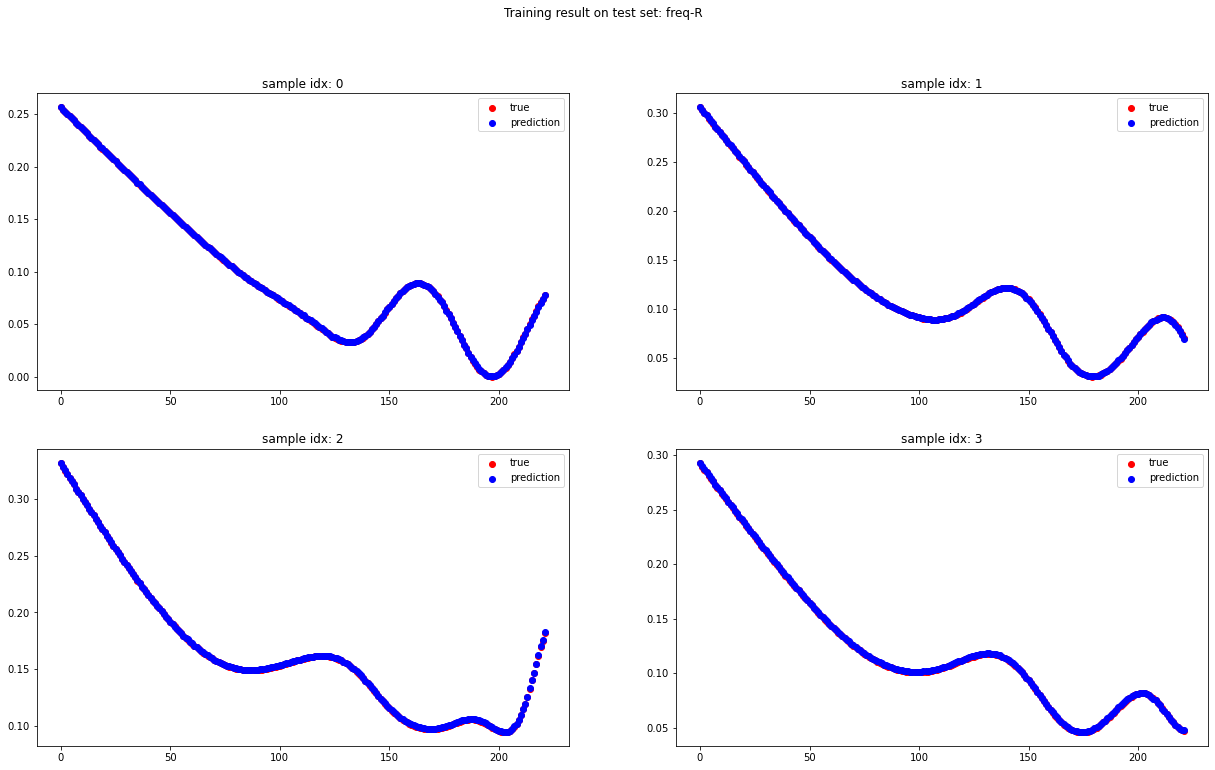

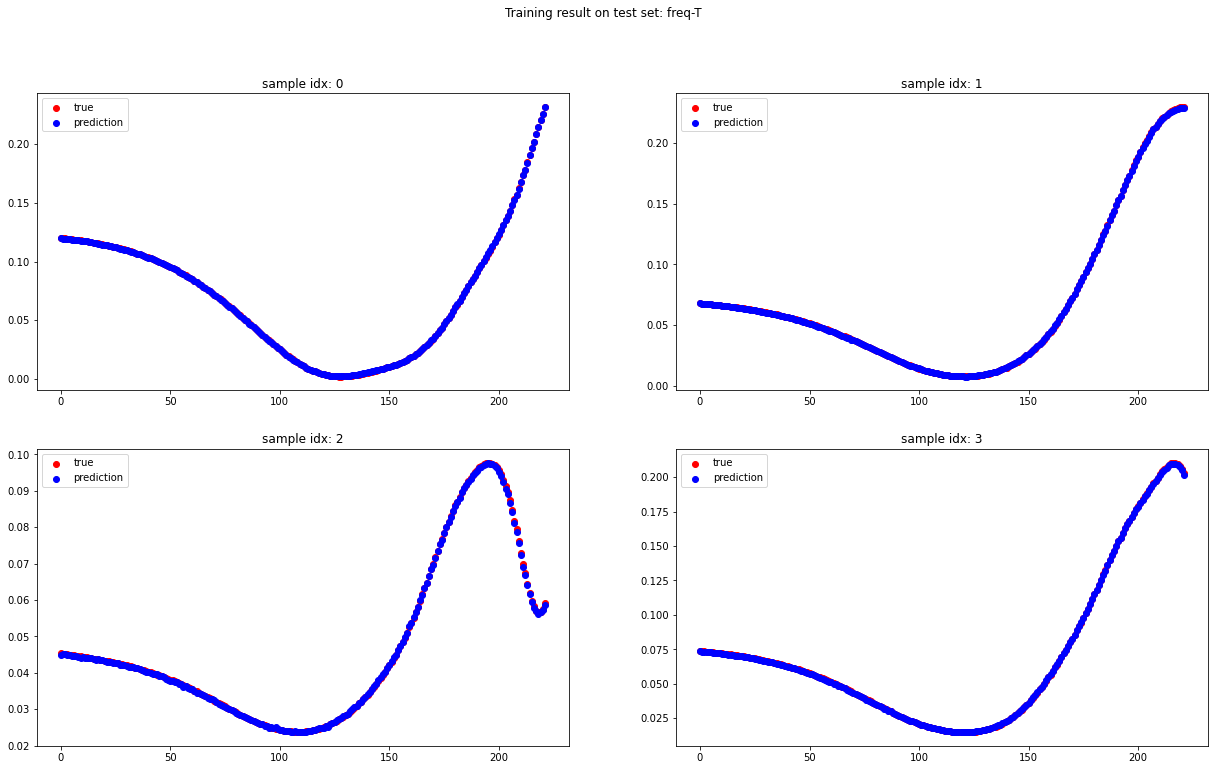

params_pick.shape: (10, 4)
params_pick: [[145. 122. 160.  75.]
 [146. 122. 160.  75.]
 [145. 123. 160.  75.]
 [145. 121. 160.  75.]
 [146. 121. 160.  75.]
 [146. 123. 160.  75.]
 [144. 122. 160.  75.]
 [144. 123. 160.  75.]
 [145. 120. 160.  75.]
 [146. 120. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


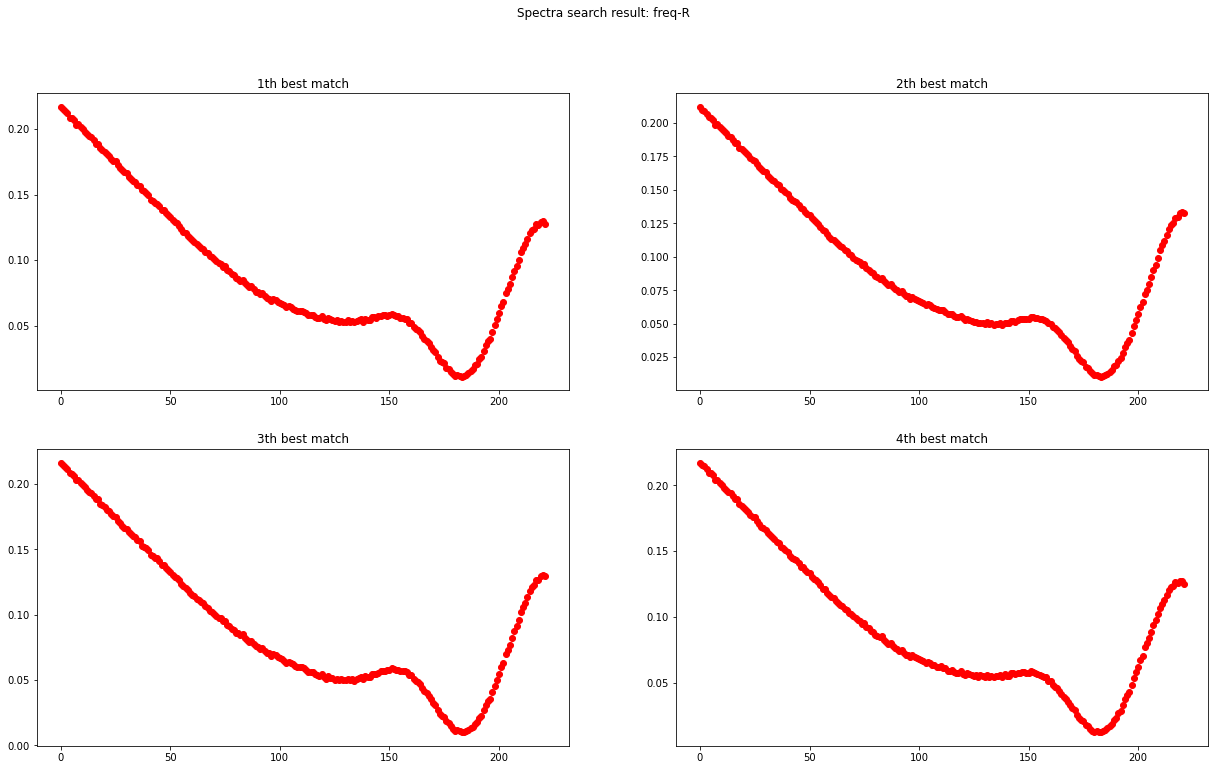

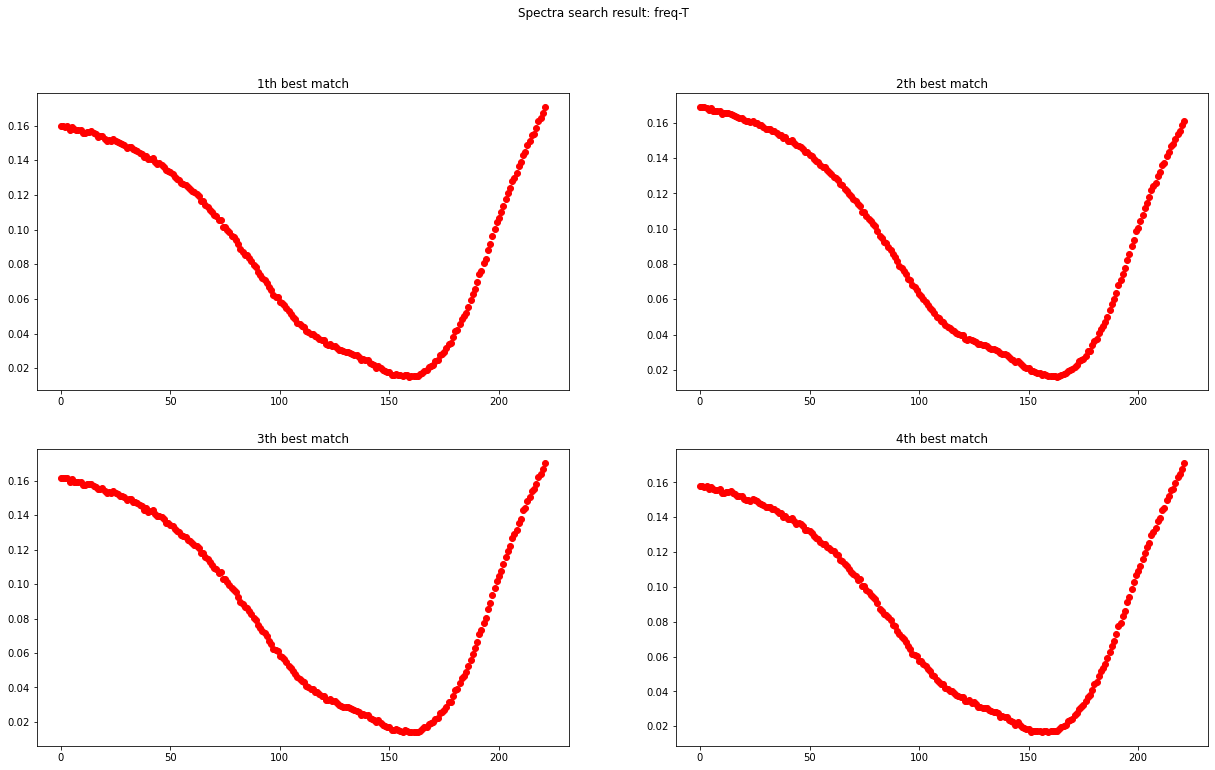

*** Reruning RCWA on picked params
params_dict.shape: (100, 4)
R_dict.shape: (100, 222)
T_dict.shape: (100, 222)
--------------------
1 th match
Not in the dict, calling RCWA...
# params_pick: [145. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
2 th match
Not in the dict, calling RCWA...
# params_pick: [146. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [145. 123. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Not in the dict, calling RCWA...
# params_pick: [145. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
5 th match
Not in the dict, calling RCWA...
# params_pick: [146. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
6

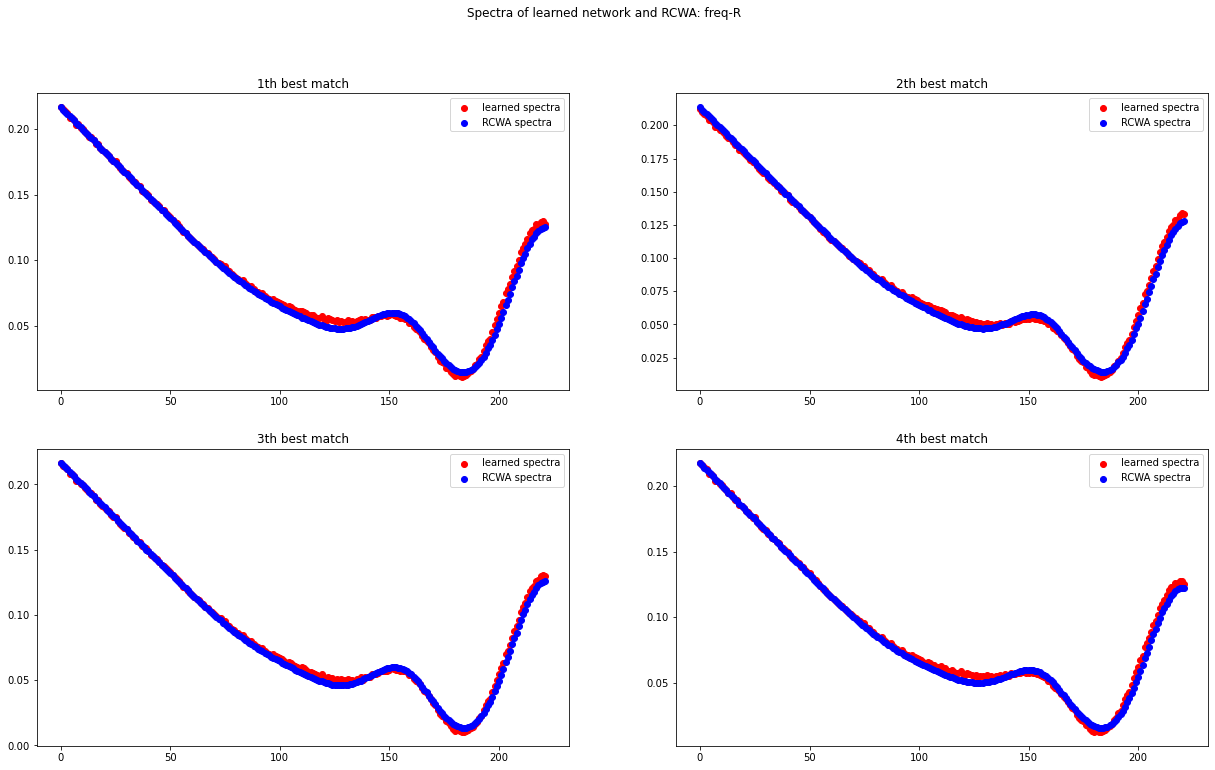

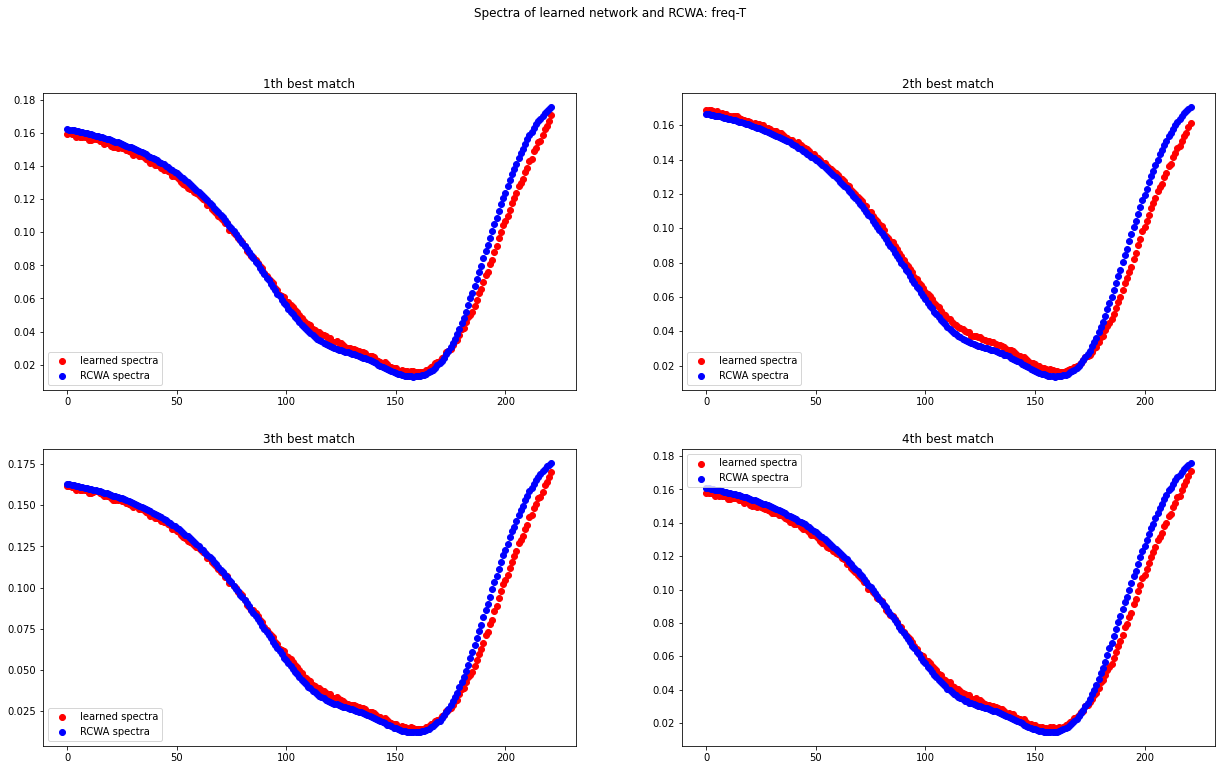

** Model saved.
**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 200
Sample points number available, continue calculating...
----------------
[ 1 / 100 ] [D1, D2] = [ 84. 119.]
Calculation Progress: 100%
----------------
[ 2 / 100 ] [D1, D2] = [ 57. 128.]
Calculation Progress: 47%

In [ ]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA Simulation Prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# make data dir if necessary
if not os.path.exists('./data/' + path_material_name + '/'):
    os.makedirs('./data/' + path_material_name + '/')

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 7  # RCWA accuracy, higher to be more accurate, use 7 for speed
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate Pseudo Params, [D1, D2] ======
range_D1 = [50,150,1]  # [range_start, range_end, step_size]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
# print(pseudo_params_D1_D2.shape)
# print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]
# print(pseudo_params.shape)
# print(pseudo_params[0])

# ====== Define Target Spectra ======
tg_idx_freq_R = np.array([129])
tg_value_R = np.array([0.03])
tg_idx_freq_T = np.array([0, 167])
tg_value_T = np.array([0.23, 0.])
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 100
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = params
        R_all = R
        T_all = T
    else:
        params_all = np.concatenate((params_all, params), axis=0)
        R_all = np.concatenate((R_all, R), axis=0)
        T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)
    print('R_all.shape:', R_all.shape)
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('** All Rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net_dense = DenseConvTranspose1D(dim_in,dim_out)
        net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 2000  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    params_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('params_pick.shape:', params_pick.shape)
    print('params_pick:', params_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(params_pick, R_pick, T_pick)
    
    
    # ====== Run RCWA Search on Picked Params ======
    # add param dict check here to save more time
    print('*** Reruning RCWA on picked params')
    if ROUND==1:
        params_dict = params_all
        R_dict = R_all
        T_dict = T_all
    else:
        params_dict = np.concatenate((params_dict, params), axis=0)
        R_dict = np.concatenate((R_dict, R), axis=0)
        T_dict = np.concatenate((T_dict, T), axis=0)
    print('params_dict.shape:', params_dict.shape)
    print('R_dict.shape:', R_dict.shape)
    print('T_dict.shape:', T_dict.shape)
    
    rerun_params, R_simu, T_simu = np.zeros_like(params_pick), np.zeros_like(R_pick), np.zeros_like(T_pick)
    for idx_pick in range(R_pick.shape[0]):  # for each in N_top
        print('--------------------')
        print(idx_pick+1, 'th match')
        if np.any(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)):  # if picked params already in the dict
            print('Already in the dict.')
            idx_same = np.argwhere(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)==True)[0].squeeze()  # get the idx in the dict
            print('# params_dict:', params_dict[idx_same], 'params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = params_dict[idx_pick][np.newaxis,...], R_dict[idx_pick][np.newaxis,...], T_dict[idx_pick][np.newaxis,...]
        else:  # picked params not in the dict, call rcwa solver
            print('Not in the dict, calling RCWA...')
            params_pick_rcwa = params_pick[idx_pick][np.newaxis,...]
            print('# params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=params_pick_rcwa)
            # add unseen simu data into dict
            params_dict = np.concatenate((params_dict, rerun_params_i), axis=0)
            R_dict = np.concatenate((R_dict, R_simu_i), axis=0)
            T_dict = np.concatenate((T_dict, T_simu_i), axis=0)
        rerun_params[idx_pick], R_simu[idx_pick], T_simu[idx_pick] = rerun_params_i, R_simu_i, T_simu_i
    # save the dict
    path_dict = './data/' + path_material_name + '/data_dict_' + path_material_name + '.npz'
    np.savez(path_dict, params=params_dict, R=R_dict, T=T_dict)
    print('** Dict data saved.')
            
#     print('*** Reruning RCWA on picked params')
#     rerun_params, R_simu, T_simu = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
#                                            path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=param_pick)
    
    print('rerun_params.shape:', rerun_params.shape)
    print('R_simu.shape:', R_simu.shape)  # [N_top, N_freq]
    print('T_simu.shape:', T_simu.shape)
    # loss between learned spectra and simulated spectra
    loss_R = np.average(np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
    loss_T = np.average(np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
    loss_RT_avg = np.average([loss_R, loss_T])
    loss = loss_RT_avg
    
    print('*** Average Loss between Trained Spectra and RCWA Spectra:', loss_RT_avg)
    # visualize learned spectra and RCWA true spectra
    visualize_learned_and_rcwa(params_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    
    # ====== Save Trained Model ======
    # make data dir if necessary
    if not os.path.exists('./trained_models/' + path_material_name + '/'):
        os.makedirs('./trained_models/' + path_material_name + '/')
    PATH_MODEL = './trained_models/' + path_material_name + '/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net_dense.state_dict(), PATH_MODEL)
    print('** Model saved.')
    
#     if ROUND>3:
#         loss = 1e-7
    ROUND += 1
    
plt.ioff()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 50
Sample points number available, continue calculating...
----------------
[ 1 / 50 ] [D1, D2] = [ 58. 100.]
Calculation Progress: 100%
----------------
[ 2 / 50 ] [D1, D2] = [ 65. 101.]
Calculation Progress: 100%
----------------
[ 3 / 50 ] [D1, D2] = [ 62. 123.]
Calculation Progress: 100%
----------------
[ 4 / 50 ] [D1, D2] = [ 54. 147.]
Calculation Progress: 100%
----------------
[ 5 / 50 ] [D1, D2] = [ 69. 118.]
Calculation Progress: 100%
----------------
[ 6 / 50 ] [D1, D2] = [119. 150.]
Calculation Progress: 100%
----------------
[ 7 / 50 ] [D1, D2] = [125.  65.]
Calculation Progress: 100%
----------------
[ 8 / 50 ] [D1, D2] = [82. 94.]
Calculation Progress: 100%
----------------
[ 9 / 50 ] [D1, D2] = [56. 67.]
Calculation Progress: 100%
----------------
[ 10 / 50 ] [D1, D2] = [58. 69.]
Calculation Progress: 100%
----------------

----------------------------------------------------------------------
*** EPOCH 26 || AVG LOSS 0.00010559066122368676
### TEST LOSS  8.903480920707807e-05
----------------------------------------------------------------------
*** EPOCH 27 || AVG LOSS 9.235890531272161e-05
### TEST LOSS  0.00010230185580439866
----------------------------------------------------------------------
*** EPOCH 28 || AVG LOSS 0.00010310602476238274
### TEST LOSS  0.0001112626850954257
----------------------------------------------------------------------
*** EPOCH 29 || AVG LOSS 0.00019032836189580848
### TEST LOSS  0.00035601569106802344
----------------------------------------------------------------------
*** EPOCH 30 || AVG LOSS 0.0001740638834235142
### TEST LOSS  7.988319703144953e-05
----------------------------------------------------------------------
*** EPOCH 31 || AVG LOSS 0.0002630534052150324
### TEST LOSS  0.00020840964862145483
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 79 || AVG LOSS 5.508631147108644e-06
### TEST LOSS  7.96572658146033e-06
----------------------------------------------------------------------
*** EPOCH 80 || AVG LOSS 5.435126378188215e-06
### TEST LOSS  4.573910246108426e-06
----------------------------------------------------------------------
*** EPOCH 81 || AVG LOSS 5.1410777928140305e-06
### TEST LOSS  4.467050075618317e-06
----------------------------------------------------------------------
*** EPOCH 82 || AVG LOSS 5.302528952597641e-06
### TEST LOSS  7.78217327024322e-06
----------------------------------------------------------------------
*** EPOCH 83 || AVG LOSS 5.822197117595351e-06
### TEST LOSS  4.978852757631103e-06
----------------------------------------------------------------------
*** EPOCH 84 || AVG LOSS 5.056985130522662e-06
### TEST LOSS  4.650466962630162e-06
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 132 || AVG LOSS 2.7713538929674542e-06
### TEST LOSS  4.005845767096616e-06
----------------------------------------------------------------------
*** EPOCH 133 || AVG LOSS 2.9211396622486062e-06
### TEST LOSS  2.960133087981376e-06
----------------------------------------------------------------------
*** EPOCH 134 || AVG LOSS 3.041009615571966e-06
### TEST LOSS  3.3091810109908693e-06
----------------------------------------------------------------------
*** EPOCH 135 || AVG LOSS 3.200388768505036e-06
### TEST LOSS  4.677441665990045e-06
----------------------------------------------------------------------
*** EPOCH 136 || AVG LOSS 2.4122937804804676e-06
### TEST LOSS  2.3175941805675393e-06
----------------------------------------------------------------------
*** EPOCH 137 || AVG LOSS 2.2791338449223984e-06
### TEST LOSS  3.262800419179257e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 185 || AVG LOSS 1.0931576673556264e-06
### TEST LOSS  1.2251808811925002e-06
----------------------------------------------------------------------
*** EPOCH 186 || AVG LOSS 1.2430407903707418e-06
### TEST LOSS  1.2948969470016891e-06
----------------------------------------------------------------------
*** EPOCH 187 || AVG LOSS 9.247796043609924e-07
### TEST LOSS  8.449393362752744e-07
----------------------------------------------------------------------
*** EPOCH 188 || AVG LOSS 1.2060353401466272e-06
### TEST LOSS  1.5895464002824156e-06
----------------------------------------------------------------------
*** EPOCH 189 || AVG LOSS 1.2068311548318888e-06
### TEST LOSS  9.401923080076813e-07
----------------------------------------------------------------------
*** EPOCH 190 || AVG LOSS 9.66568289584302e-07
### TEST LOSS  6.97217330980493e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 238 || AVG LOSS 4.806002742796522e-07
### TEST LOSS  3.872286811201775e-07
----------------------------------------------------------------------
*** EPOCH 239 || AVG LOSS 5.638044940781129e-07
### TEST LOSS  6.558692007274658e-07
----------------------------------------------------------------------
*** EPOCH 240 || AVG LOSS 5.290454637929542e-07
### TEST LOSS  5.535407012757787e-07
----------------------------------------------------------------------
*** EPOCH 241 || AVG LOSS 5.651557377461813e-07
### TEST LOSS  8.41676921936596e-07
----------------------------------------------------------------------
*** EPOCH 242 || AVG LOSS 6.242317124360852e-07
### TEST LOSS  5.881297511223238e-07
----------------------------------------------------------------------
*** EPOCH 243 || AVG LOSS 5.449196984841365e-07
### TEST LOSS  4.166776363945246e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 291 || AVG LOSS 3.5806220509471133e-07
### TEST LOSS  2.7829605642182287e-07
----------------------------------------------------------------------
*** EPOCH 292 || AVG LOSS 3.6762963461001165e-07
### TEST LOSS  3.1010912948659097e-07
----------------------------------------------------------------------
*** EPOCH 293 || AVG LOSS 3.453711538980997e-07
### TEST LOSS  3.5463639846966544e-07
----------------------------------------------------------------------
*** EPOCH 294 || AVG LOSS 4.212937184178145e-07
### TEST LOSS  3.191155997228634e-07
----------------------------------------------------------------------
*** EPOCH 295 || AVG LOSS 3.673433722184427e-07
### TEST LOSS  4.1748936041585694e-07
----------------------------------------------------------------------
*** EPOCH 296 || AVG LOSS 3.356153442979348e-07
### TEST LOSS  3.183592411915015e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 344 || AVG LOSS 3.379682582504984e-07
### TEST LOSS  3.1111167686503904e-07
----------------------------------------------------------------------
*** EPOCH 345 || AVG LOSS 2.8884851417387835e-07
### TEST LOSS  3.362385143645952e-07
----------------------------------------------------------------------
*** EPOCH 346 || AVG LOSS 3.311264138972092e-07
### TEST LOSS  2.824507134846499e-07
----------------------------------------------------------------------
*** EPOCH 347 || AVG LOSS 2.6025738925739005e-07
### TEST LOSS  2.5196138153660286e-07
----------------------------------------------------------------------
*** EPOCH 348 || AVG LOSS 2.6695627767026056e-07
### TEST LOSS  2.686057598566549e-07
----------------------------------------------------------------------
*** EPOCH 349 || AVG LOSS 3.185390676208044e-07
### TEST LOSS  3.342879892898054e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 397 || AVG LOSS 4.848078103236731e-07
### TEST LOSS  7.645084565410798e-07
----------------------------------------------------------------------
*** EPOCH 398 || AVG LOSS 7.231435488108673e-07
### TEST LOSS  6.799140237490064e-07
----------------------------------------------------------------------
*** EPOCH 399 || AVG LOSS 3.3560957072609197e-06
### TEST LOSS  6.174026566441171e-06
----------------------------------------------------------------------
*** EPOCH 400 || AVG LOSS 2.3404985967090397e-06
### TEST LOSS  7.548130724899238e-07
----------------------------------------------------------------------
*** EPOCH 401 || AVG LOSS 7.051478530684108e-07
### TEST LOSS  5.825039011142508e-07
----------------------------------------------------------------------
*** EPOCH 402 || AVG LOSS 8.491134352084373e-07
### TEST LOSS  8.455039619548188e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 450 || AVG LOSS 2.566166024564609e-07
### TEST LOSS  1.9875025714100047e-07
----------------------------------------------------------------------
*** EPOCH 451 || AVG LOSS 2.687822665592421e-07
### TEST LOSS  1.9474701673516392e-07
----------------------------------------------------------------------
*** EPOCH 452 || AVG LOSS 2.390995086898329e-07
### TEST LOSS  2.0054532967606065e-07
----------------------------------------------------------------------
*** EPOCH 453 || AVG LOSS 2.206984105512788e-07
### TEST LOSS  1.9702673625943135e-07
----------------------------------------------------------------------
*** EPOCH 454 || AVG LOSS 2.294547000047942e-07
### TEST LOSS  2.1246125925244996e-07
----------------------------------------------------------------------
*** EPOCH 455 || AVG LOSS 2.47338044907508e-07
### TEST LOSS  2.3339772781127976e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 503 || AVG LOSS 3.2189199188792373e-07
### TEST LOSS  2.406929411336023e-07
----------------------------------------------------------------------
*** EPOCH 504 || AVG LOSS 2.5164124309640104e-07
### TEST LOSS  2.374641354663254e-07
----------------------------------------------------------------------
*** EPOCH 505 || AVG LOSS 2.4140869420818944e-07
### TEST LOSS  2.2967252277794614e-07
----------------------------------------------------------------------
*** EPOCH 506 || AVG LOSS 3.317773187916373e-07
### TEST LOSS  2.3114300518045638e-07
----------------------------------------------------------------------
*** EPOCH 507 || AVG LOSS 2.921893934626496e-07
### TEST LOSS  2.3614526867277164e-07
----------------------------------------------------------------------
*** EPOCH 508 || AVG LOSS 4.404158007531578e-07
### TEST LOSS  2.6498409511077625e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 556 || AVG LOSS 1.6873611180301396e-07
### TEST LOSS  1.3876605464702152e-07
----------------------------------------------------------------------
*** EPOCH 557 || AVG LOSS 1.6265277160698589e-07
### TEST LOSS  1.5657144558645086e-07
----------------------------------------------------------------------
*** EPOCH 558 || AVG LOSS 1.5634642167583478e-07
### TEST LOSS  1.341513069519351e-07
----------------------------------------------------------------------
*** EPOCH 559 || AVG LOSS 2.0078102870968452e-07
### TEST LOSS  1.8367036602739972e-07
----------------------------------------------------------------------
*** EPOCH 560 || AVG LOSS 1.7453468277750518e-07
### TEST LOSS  1.4660363945040444e-07
----------------------------------------------------------------------
*** EPOCH 561 || AVG LOSS 1.5328342485076973e-07
### TEST LOSS  1.4342036536163505e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 609 || AVG LOSS 2.314910697975847e-07
### TEST LOSS  2.8864729983979487e-07
----------------------------------------------------------------------
*** EPOCH 610 || AVG LOSS 2.647506777009312e-07
### TEST LOSS  2.988405185533338e-07
----------------------------------------------------------------------
*** EPOCH 611 || AVG LOSS 4.990190222997626e-07
### TEST LOSS  5.17469459282438e-07
----------------------------------------------------------------------
*** EPOCH 612 || AVG LOSS 4.219570672603368e-07
### TEST LOSS  4.305604761611903e-07
----------------------------------------------------------------------
*** EPOCH 613 || AVG LOSS 2.993584940469418e-07
### TEST LOSS  3.808229394053342e-07
----------------------------------------------------------------------
*** EPOCH 614 || AVG LOSS 4.751773951738869e-07
### TEST LOSS  4.768584176417789e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 662 || AVG LOSS 5.716355121876404e-07
### TEST LOSS  1.1775064194807783e-06
----------------------------------------------------------------------
*** EPOCH 663 || AVG LOSS 5.251492903823873e-07
### TEST LOSS  4.3953022554887866e-07
----------------------------------------------------------------------
*** EPOCH 664 || AVG LOSS 4.29546127378444e-07
### TEST LOSS  8.923393579607364e-07
----------------------------------------------------------------------
*** EPOCH 665 || AVG LOSS 7.737010631103658e-07
### TEST LOSS  1.0890556723097689e-06
----------------------------------------------------------------------
*** EPOCH 666 || AVG LOSS 6.762569989859912e-07
### TEST LOSS  7.553250043201842e-07
----------------------------------------------------------------------
*** EPOCH 667 || AVG LOSS 5.061929294924994e-07
### TEST LOSS  5.051714992987399e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 715 || AVG LOSS 1.8369743884250056e-07
### TEST LOSS  2.176290507804879e-07
----------------------------------------------------------------------
*** EPOCH 716 || AVG LOSS 2.0816346925300876e-07
### TEST LOSS  1.1830151436242886e-07
----------------------------------------------------------------------
*** EPOCH 717 || AVG LOSS 1.4593212306124314e-07
### TEST LOSS  1.5500552308367332e-07
----------------------------------------------------------------------
*** EPOCH 718 || AVG LOSS 1.583148553052638e-07
### TEST LOSS  1.2625967826807027e-07
----------------------------------------------------------------------
*** EPOCH 719 || AVG LOSS 1.3890054148646413e-07
### TEST LOSS  2.0269106926207314e-07
----------------------------------------------------------------------
*** EPOCH 720 || AVG LOSS 1.9829055652564876e-07
### TEST LOSS  1.9660929240217229e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 768 || AVG LOSS 2.1565499139342137e-07
### TEST LOSS  2.2069706062666228e-07
----------------------------------------------------------------------
*** EPOCH 769 || AVG LOSS 1.885724604733241e-07
### TEST LOSS  1.1187648851773702e-07
----------------------------------------------------------------------
*** EPOCH 770 || AVG LOSS 1.3725245516127415e-07
### TEST LOSS  1.104890401393277e-07
----------------------------------------------------------------------
*** EPOCH 771 || AVG LOSS 1.2611340657997516e-07
### TEST LOSS  1.3088782679915312e-07
----------------------------------------------------------------------
*** EPOCH 772 || AVG LOSS 1.4357378312013224e-07
### TEST LOSS  1.2964042639396212e-07
----------------------------------------------------------------------
*** EPOCH 773 || AVG LOSS 1.4347424166061273e-07
### TEST LOSS  3.730215496489109e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 821 || AVG LOSS 1.450333618180366e-07
### TEST LOSS  1.251533632284918e-07
----------------------------------------------------------------------
*** EPOCH 822 || AVG LOSS 1.1806468080521882e-07
### TEST LOSS  1.1375581010497626e-07
----------------------------------------------------------------------
*** EPOCH 823 || AVG LOSS 1.1141858131225035e-07
### TEST LOSS  1.3278454957799113e-07
----------------------------------------------------------------------
*** EPOCH 824 || AVG LOSS 1.1254259597137661e-07
### TEST LOSS  8.542838259018026e-08
----------------------------------------------------------------------
*** EPOCH 825 || AVG LOSS 1.0678664327912202e-07
### TEST LOSS  9.312236670666607e-08
----------------------------------------------------------------------
*** EPOCH 826 || AVG LOSS 1.1799364781239774e-07
### TEST LOSS  9.08709267832819e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 874 || AVG LOSS 1.4655917958350527e-07
### TEST LOSS  1.275505780995445e-07
----------------------------------------------------------------------
*** EPOCH 875 || AVG LOSS 1.507856153892817e-07
### TEST LOSS  2.2090327433943457e-07
----------------------------------------------------------------------
*** EPOCH 876 || AVG LOSS 1.448361840061807e-07
### TEST LOSS  1.1165572288973635e-07
----------------------------------------------------------------------
*** EPOCH 877 || AVG LOSS 1.5729787758544944e-07
### TEST LOSS  1.1545387224032311e-07
----------------------------------------------------------------------
*** EPOCH 878 || AVG LOSS 1.5480277692603295e-07
### TEST LOSS  1.5025919708477886e-07
----------------------------------------------------------------------
*** EPOCH 879 || AVG LOSS 1.892918348112005e-07
### TEST LOSS  1.455137947914409e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 927 || AVG LOSS 1.0049031317294065e-07
### TEST LOSS  9.086800645263793e-08
----------------------------------------------------------------------
*** EPOCH 928 || AVG LOSS 1.019636811605551e-07
### TEST LOSS  7.518438138731653e-08
----------------------------------------------------------------------
*** EPOCH 929 || AVG LOSS 8.620084983590459e-08
### TEST LOSS  1.0678270712105586e-07
----------------------------------------------------------------------
*** EPOCH 930 || AVG LOSS 1.3853999380586402e-07
### TEST LOSS  1.4647622492702794e-07
----------------------------------------------------------------------
*** EPOCH 931 || AVG LOSS 1.2382481774153574e-07
### TEST LOSS  1.1287725953934569e-07
----------------------------------------------------------------------
*** EPOCH 932 || AVG LOSS 1.1091034080479289e-07
### TEST LOSS  1.2775016955401952e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 980 || AVG LOSS 1.672930338969536e-07
### TEST LOSS  1.9432684439379955e-07
----------------------------------------------------------------------
*** EPOCH 981 || AVG LOSS 1.8876687335023235e-07
### TEST LOSS  1.6345717313015484e-07
----------------------------------------------------------------------
*** EPOCH 982 || AVG LOSS 1.795424118711253e-07
### TEST LOSS  2.660432869561191e-07
----------------------------------------------------------------------
*** EPOCH 983 || AVG LOSS 1.4151479586388404e-07
### TEST LOSS  1.2042021069191833e-07
----------------------------------------------------------------------
*** EPOCH 984 || AVG LOSS 1.2088047093072874e-07
### TEST LOSS  1.0473760880813643e-07
----------------------------------------------------------------------
*** EPOCH 985 || AVG LOSS 9.243567767214244e-08
### TEST LOSS  1.0735013944440652e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1033 || AVG LOSS 7.04216228086807e-08
### TEST LOSS  7.861159900812709e-08
----------------------------------------------------------------------
*** EPOCH 1034 || AVG LOSS 7.776087199928839e-08
### TEST LOSS  6.204680857990752e-08
----------------------------------------------------------------------
*** EPOCH 1035 || AVG LOSS 8.71211186392884e-08
### TEST LOSS  6.310055766789446e-08
----------------------------------------------------------------------
*** EPOCH 1036 || AVG LOSS 8.313182054742186e-08
### TEST LOSS  8.986305743974299e-08
----------------------------------------------------------------------
*** EPOCH 1037 || AVG LOSS 8.93350898678591e-08
### TEST LOSS  7.886772834808653e-08
----------------------------------------------------------------------
*** EPOCH 1038 || AVG LOSS 8.817145935147153e-08
### TEST LOSS  7.162547888128756e-08
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1086 || AVG LOSS 7.635396775285131e-08
### TEST LOSS  6.600095048270305e-08
----------------------------------------------------------------------
*** EPOCH 1087 || AVG LOSS 7.649693170463934e-08
### TEST LOSS  6.743682945398177e-08
----------------------------------------------------------------------
*** EPOCH 1088 || AVG LOSS 7.145002820507784e-08
### TEST LOSS  8.963009889839668e-08
----------------------------------------------------------------------
*** EPOCH 1089 || AVG LOSS 9.453350639176961e-08
### TEST LOSS  6.347693926045395e-08
----------------------------------------------------------------------
*** EPOCH 1090 || AVG LOSS 8.22792564569852e-08
### TEST LOSS  7.795027556767309e-08
----------------------------------------------------------------------
*** EPOCH 1091 || AVG LOSS 8.024832323982878e-08
### TEST LOSS  7.098017817952496e-08
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1139 || AVG LOSS 7.290563404538375e-08
### TEST LOSS  6.632881621726483e-08
----------------------------------------------------------------------
*** EPOCH 1140 || AVG LOSS 7.663827194193117e-08
### TEST LOSS  6.57147225524568e-08
----------------------------------------------------------------------
*** EPOCH 1141 || AVG LOSS 8.516935274371917e-08
### TEST LOSS  1.0896066271470772e-07
----------------------------------------------------------------------
*** EPOCH 1142 || AVG LOSS 8.7784144469083e-08
### TEST LOSS  7.458699258222623e-08
----------------------------------------------------------------------
*** EPOCH 1143 || AVG LOSS 7.651399698715977e-08
### TEST LOSS  6.25077376525951e-08
----------------------------------------------------------------------
*** EPOCH 1144 || AVG LOSS 6.742607238763299e-08
### TEST LOSS  5.989399198824685e-08
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1192 || AVG LOSS 6.247344382259712e-08
### TEST LOSS  8.205285695339626e-08
----------------------------------------------------------------------
*** EPOCH 1193 || AVG LOSS 6.185227459098997e-08
### TEST LOSS  5.738089470241903e-08
----------------------------------------------------------------------
*** EPOCH 1194 || AVG LOSS 5.873837553238559e-08
### TEST LOSS  5.790764845414742e-08
----------------------------------------------------------------------
*** EPOCH 1195 || AVG LOSS 7.46237705939734e-08
### TEST LOSS  7.76072113239934e-08
----------------------------------------------------------------------
*** EPOCH 1196 || AVG LOSS 9.168864417929967e-08
### TEST LOSS  9.028142500255854e-08
----------------------------------------------------------------------
*** EPOCH 1197 || AVG LOSS 9.170439884798043e-08
### TEST LOSS  7.914871957837022e-08
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1245 || AVG LOSS 6.337739072215243e-08
### TEST LOSS  7.12354690790562e-08
----------------------------------------------------------------------
*** EPOCH 1246 || AVG LOSS 7.07253372489447e-08
### TEST LOSS  5.861951635210971e-08
----------------------------------------------------------------------
*** EPOCH 1247 || AVG LOSS 6.483567583259741e-08
### TEST LOSS  4.550187782115245e-08
----------------------------------------------------------------------
*** EPOCH 1248 || AVG LOSS 7.209194903268213e-08
### TEST LOSS  7.084970121695733e-08
----------------------------------------------------------------------
*** EPOCH 1249 || AVG LOSS 9.395877093254512e-08
### TEST LOSS  6.319773859786437e-08
----------------------------------------------------------------------
*** EPOCH 1250 || AVG LOSS 6.840745241376567e-08
### TEST LOSS  5.535105529475004e-08
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1298 || AVG LOSS 6.567850284966425e-08
### TEST LOSS  5.4080626199493054e-08
----------------------------------------------------------------------
*** EPOCH 1299 || AVG LOSS 6.243987558995911e-08
### TEST LOSS  8.603515766480996e-08
----------------------------------------------------------------------
*** EPOCH 1300 || AVG LOSS 7.640614523296563e-08
### TEST LOSS  7.803549806340015e-08
----------------------------------------------------------------------
*** EPOCH 1301 || AVG LOSS 7.061334404312447e-08
### TEST LOSS  5.3815860212580446e-08
----------------------------------------------------------------------
*** EPOCH 1302 || AVG LOSS 7.302877447656897e-08
### TEST LOSS  5.828800908602716e-08
----------------------------------------------------------------------
*** EPOCH 1303 || AVG LOSS 5.8677636687320955e-08
### TEST LOSS  4.2283172518864376e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1351 || AVG LOSS 5.134410369755926e-08
### TEST LOSS  4.222327021352612e-08
----------------------------------------------------------------------
*** EPOCH 1352 || AVG LOSS 5.1368166662513206e-08
### TEST LOSS  3.9830450049294086e-08
----------------------------------------------------------------------
*** EPOCH 1353 || AVG LOSS 5.295459487797416e-08
### TEST LOSS  4.096473915637944e-08
----------------------------------------------------------------------
*** EPOCH 1354 || AVG LOSS 5.253487170620019e-08
### TEST LOSS  4.2121484966628486e-08
----------------------------------------------------------------------
*** EPOCH 1355 || AVG LOSS 5.190619063455415e-08
### TEST LOSS  4.413553966742256e-08
----------------------------------------------------------------------
*** EPOCH 1356 || AVG LOSS 5.7185872242015986e-08
### TEST LOSS  7.997145701210684e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1404 || AVG LOSS 5.389475213668504e-08
### TEST LOSS  5.2981636855520264e-08
----------------------------------------------------------------------
*** EPOCH 1405 || AVG LOSS 5.531341843223458e-08
### TEST LOSS  4.634060246644367e-08
----------------------------------------------------------------------
*** EPOCH 1406 || AVG LOSS 5.3168453435503696e-08
### TEST LOSS  5.716825413060178e-08
----------------------------------------------------------------------
*** EPOCH 1407 || AVG LOSS 5.527344223210662e-08
### TEST LOSS  4.3417255568556357e-08
----------------------------------------------------------------------
*** EPOCH 1408 || AVG LOSS 5.238872367030467e-08
### TEST LOSS  3.937698522804567e-08
----------------------------------------------------------------------
*** EPOCH 1409 || AVG LOSS 4.72846546895056e-08
### TEST LOSS  4.419325350113468e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1457 || AVG LOSS 5.210107801190134e-08
### TEST LOSS  4.9200799878690304e-08
----------------------------------------------------------------------
*** EPOCH 1458 || AVG LOSS 5.357989413923292e-08
### TEST LOSS  4.635499095684281e-08
----------------------------------------------------------------------
*** EPOCH 1459 || AVG LOSS 4.7701808840727724e-08
### TEST LOSS  3.490272959538743e-08
----------------------------------------------------------------------
*** EPOCH 1460 || AVG LOSS 4.824061083930076e-08
### TEST LOSS  4.5677577276137526e-08
----------------------------------------------------------------------
*** EPOCH 1461 || AVG LOSS 4.9455121118313626e-08
### TEST LOSS  3.3385948228215057e-08
----------------------------------------------------------------------
*** EPOCH 1462 || AVG LOSS 4.447804796470223e-08
### TEST LOSS  3.884127508513302e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1509 || AVG LOSS 4.930734891495092e-08
### TEST LOSS  4.846274848091525e-08
----------------------------------------------------------------------
*** EPOCH 1510 || AVG LOSS 4.9104386459219996e-08
### TEST LOSS  4.5542257964825694e-08
----------------------------------------------------------------------
*** EPOCH 1511 || AVG LOSS 4.641768660995638e-08
### TEST LOSS  4.016177612697902e-08
----------------------------------------------------------------------
*** EPOCH 1512 || AVG LOSS 4.333203701634147e-08
### TEST LOSS  4.158946964594179e-08
----------------------------------------------------------------------
*** EPOCH 1513 || AVG LOSS 4.579077074851057e-08
### TEST LOSS  6.676142305650501e-08
----------------------------------------------------------------------
*** EPOCH 1514 || AVG LOSS 8.589807956482787e-08
### TEST LOSS  6.172691513484097e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1562 || AVG LOSS 5.97228221010937e-08
### TEST LOSS  5.605836506106243e-08
----------------------------------------------------------------------
*** EPOCH 1563 || AVG LOSS 4.829200484834928e-08
### TEST LOSS  3.983666729823199e-08
----------------------------------------------------------------------
*** EPOCH 1564 || AVG LOSS 4.245310982753381e-08
### TEST LOSS  3.906929890717947e-08
----------------------------------------------------------------------
*** EPOCH 1565 || AVG LOSS 4.958387890940941e-08
### TEST LOSS  3.9679928676150666e-08
----------------------------------------------------------------------
*** EPOCH 1566 || AVG LOSS 4.487696513066908e-08
### TEST LOSS  3.620079880306548e-08
----------------------------------------------------------------------
*** EPOCH 1567 || AVG LOSS 4.4039142270690945e-08
### TEST LOSS  3.454884023312843e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1615 || AVG LOSS 4.301474116452653e-08
### TEST LOSS  3.647172874821081e-08
----------------------------------------------------------------------
*** EPOCH 1616 || AVG LOSS 4.12725106446743e-08
### TEST LOSS  2.9720363059482224e-08
----------------------------------------------------------------------
*** EPOCH 1617 || AVG LOSS 4.203119187806692e-08
### TEST LOSS  2.9350804453542878e-08
----------------------------------------------------------------------
*** EPOCH 1618 || AVG LOSS 3.942871216189303e-08
### TEST LOSS  3.365247280839867e-08
----------------------------------------------------------------------
*** EPOCH 1619 || AVG LOSS 3.86216922310112e-08
### TEST LOSS  3.5981138069018925e-08
----------------------------------------------------------------------
*** EPOCH 1620 || AVG LOSS 4.292371736269729e-08
### TEST LOSS  3.029832740253369e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1668 || AVG LOSS 3.8566362388081643e-08
### TEST LOSS  3.91944965372204e-08
----------------------------------------------------------------------
*** EPOCH 1669 || AVG LOSS 4.442703864349085e-08
### TEST LOSS  3.641129353582073e-08
----------------------------------------------------------------------
*** EPOCH 1670 || AVG LOSS 4.051481979239213e-08
### TEST LOSS  3.013562732689934e-08
----------------------------------------------------------------------
*** EPOCH 1671 || AVG LOSS 4.132240244203445e-08
### TEST LOSS  3.1099389730115945e-08
----------------------------------------------------------------------
*** EPOCH 1672 || AVG LOSS 3.898909471722334e-08
### TEST LOSS  3.319249231026333e-08
----------------------------------------------------------------------
*** EPOCH 1673 || AVG LOSS 4.084988278307833e-08
### TEST LOSS  3.525305558582659e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1720 || AVG LOSS 4.16319794016573e-08
### TEST LOSS  4.125958952272413e-08
----------------------------------------------------------------------
*** EPOCH 1721 || AVG LOSS 4.853751382150051e-08
### TEST LOSS  4.406293285796892e-08
----------------------------------------------------------------------
*** EPOCH 1722 || AVG LOSS 9.441934535558971e-08
### TEST LOSS  8.294411202314222e-08
----------------------------------------------------------------------
*** EPOCH 1723 || AVG LOSS 6.059613387066065e-08
### TEST LOSS  4.000915154733775e-08
----------------------------------------------------------------------
*** EPOCH 1724 || AVG LOSS 5.4595299392445895e-08
### TEST LOSS  4.923181506910623e-08
----------------------------------------------------------------------
*** EPOCH 1725 || AVG LOSS 6.505307812432192e-08
### TEST LOSS  4.6011141563440106e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1773 || AVG LOSS 3.754356503016254e-08
### TEST LOSS  3.910822954367177e-08
----------------------------------------------------------------------
*** EPOCH 1774 || AVG LOSS 3.8071246430959606e-08
### TEST LOSS  2.810858035218189e-08
----------------------------------------------------------------------
*** EPOCH 1775 || AVG LOSS 3.998306215002856e-08
### TEST LOSS  3.5838496614815085e-08
----------------------------------------------------------------------
*** EPOCH 1776 || AVG LOSS 3.902754441398315e-08
### TEST LOSS  2.899449214055494e-08
----------------------------------------------------------------------
*** EPOCH 1777 || AVG LOSS 3.7174021265684585e-08
### TEST LOSS  2.94257365140993e-08
----------------------------------------------------------------------
*** EPOCH 1778 || AVG LOSS 3.452836708550677e-08
### TEST LOSS  2.7042091232942767e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1826 || AVG LOSS 3.586712812087001e-08
### TEST LOSS  3.7501092009506465e-08
----------------------------------------------------------------------
*** EPOCH 1827 || AVG LOSS 3.485642190437232e-08
### TEST LOSS  2.9222322339705897e-08
----------------------------------------------------------------------
*** EPOCH 1828 || AVG LOSS 3.801061756902868e-08
### TEST LOSS  2.7201059182857534e-08
----------------------------------------------------------------------
*** EPOCH 1829 || AVG LOSS 3.5061453473872464e-08
### TEST LOSS  3.0494707203843063e-08
----------------------------------------------------------------------
*** EPOCH 1830 || AVG LOSS 3.281170517510645e-08
### TEST LOSS  2.9878016505335836e-08
----------------------------------------------------------------------
*** EPOCH 1831 || AVG LOSS 3.7489718884842205e-08
### TEST LOSS  2.9962965442109635e-08
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1878 || AVG LOSS 4.639180117393948e-08
### TEST LOSS  3.626516686949799e-08
----------------------------------------------------------------------
*** EPOCH 1879 || AVG LOSS 3.637644144127705e-08
### TEST LOSS  3.435221174186154e-08
----------------------------------------------------------------------
*** EPOCH 1880 || AVG LOSS 3.599689621935909e-08
### TEST LOSS  3.3776412777797304e-08
----------------------------------------------------------------------
*** EPOCH 1881 || AVG LOSS 3.657298237591533e-08
### TEST LOSS  2.8356907932902686e-08
----------------------------------------------------------------------
*** EPOCH 1882 || AVG LOSS 3.759050325236046e-08
### TEST LOSS  2.3831210782532253e-08
----------------------------------------------------------------------
*** EPOCH 1883 || AVG LOSS 4.181975726602616e-08
### TEST LOSS  2.6940918829154725e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1930 || AVG LOSS 3.3342953553727736e-08
### TEST LOSS  2.64975437147541e-08
----------------------------------------------------------------------
*** EPOCH 1931 || AVG LOSS 3.083734926967452e-08
### TEST LOSS  2.4866331216344406e-08
----------------------------------------------------------------------
*** EPOCH 1932 || AVG LOSS 3.053527813712265e-08
### TEST LOSS  2.4006629573136706e-08
----------------------------------------------------------------------
*** EPOCH 1933 || AVG LOSS 3.1294195452780113e-08
### TEST LOSS  2.7195524054945963e-08
----------------------------------------------------------------------
*** EPOCH 1934 || AVG LOSS 3.7797397633987374e-08
### TEST LOSS  3.229045120178853e-08
----------------------------------------------------------------------
*** EPOCH 1935 || AVG LOSS 3.9574632886285596e-08
### TEST LOSS  3.3666911036789315e-08
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1982 || AVG LOSS 2.8067576041124198e-08
### TEST LOSS  2.307011826019334e-08
----------------------------------------------------------------------
*** EPOCH 1983 || AVG LOSS 2.8357077024310228e-08
### TEST LOSS  3.207268761684645e-08
----------------------------------------------------------------------
*** EPOCH 1984 || AVG LOSS 3.954680034112812e-08
### TEST LOSS  3.4202475518441133e-08
----------------------------------------------------------------------
*** EPOCH 1985 || AVG LOSS 3.7295716817098426e-08
### TEST LOSS  2.6921075146901785e-08
----------------------------------------------------------------------
*** EPOCH 1986 || AVG LOSS 3.388745460242148e-08
### TEST LOSS  2.7762169452216767e-08
----------------------------------------------------------------------
*** EPOCH 1987 || AVG LOSS 3.754126335131502e-08
### TEST LOSS  3.433136086528066e-08
----------------------------------------------------

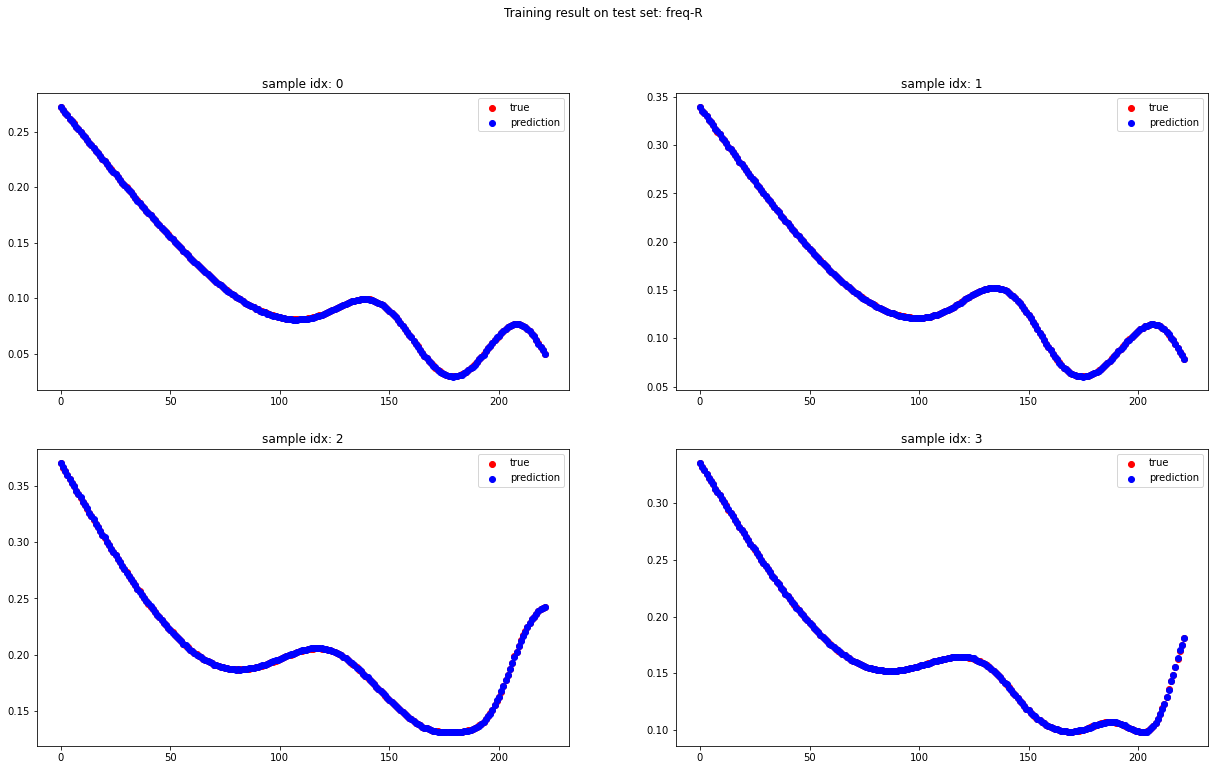

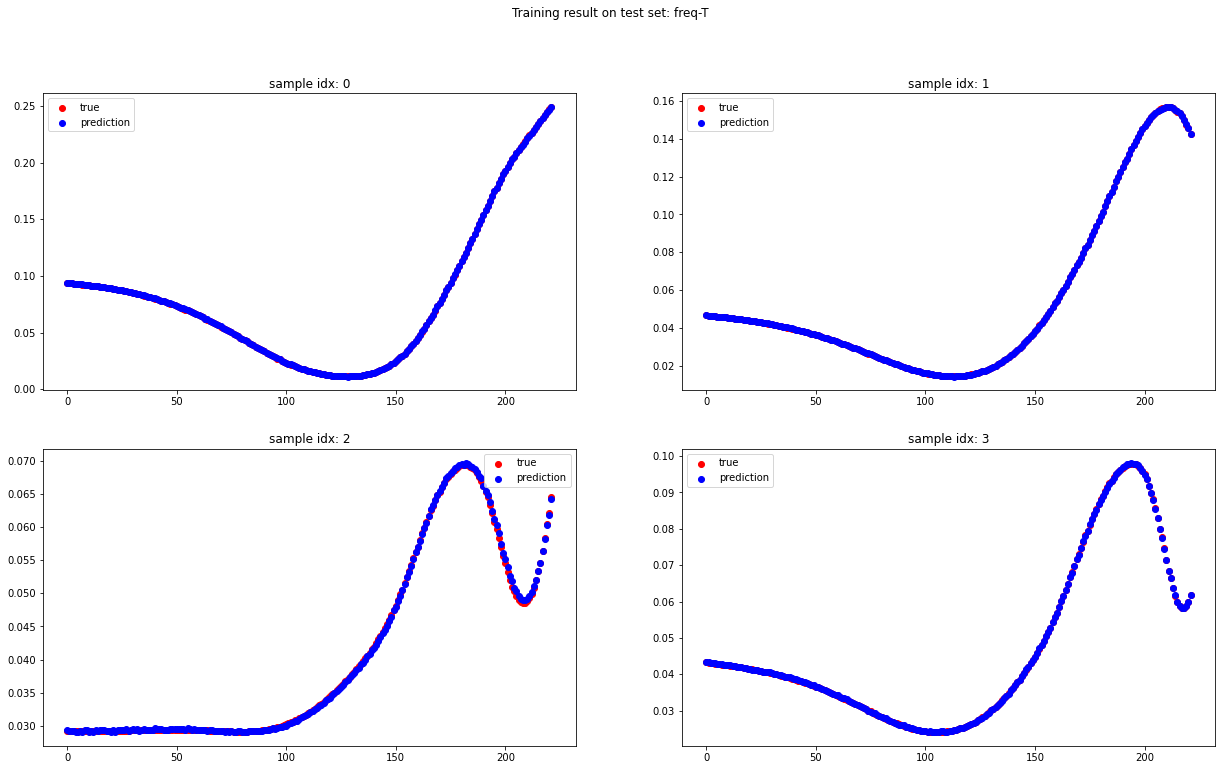

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  53. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 50.  54. 160.  75.]
 [ 51.  52. 160.  75.]
 [ 52.  50. 160.  75.]
 [ 50.  55. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


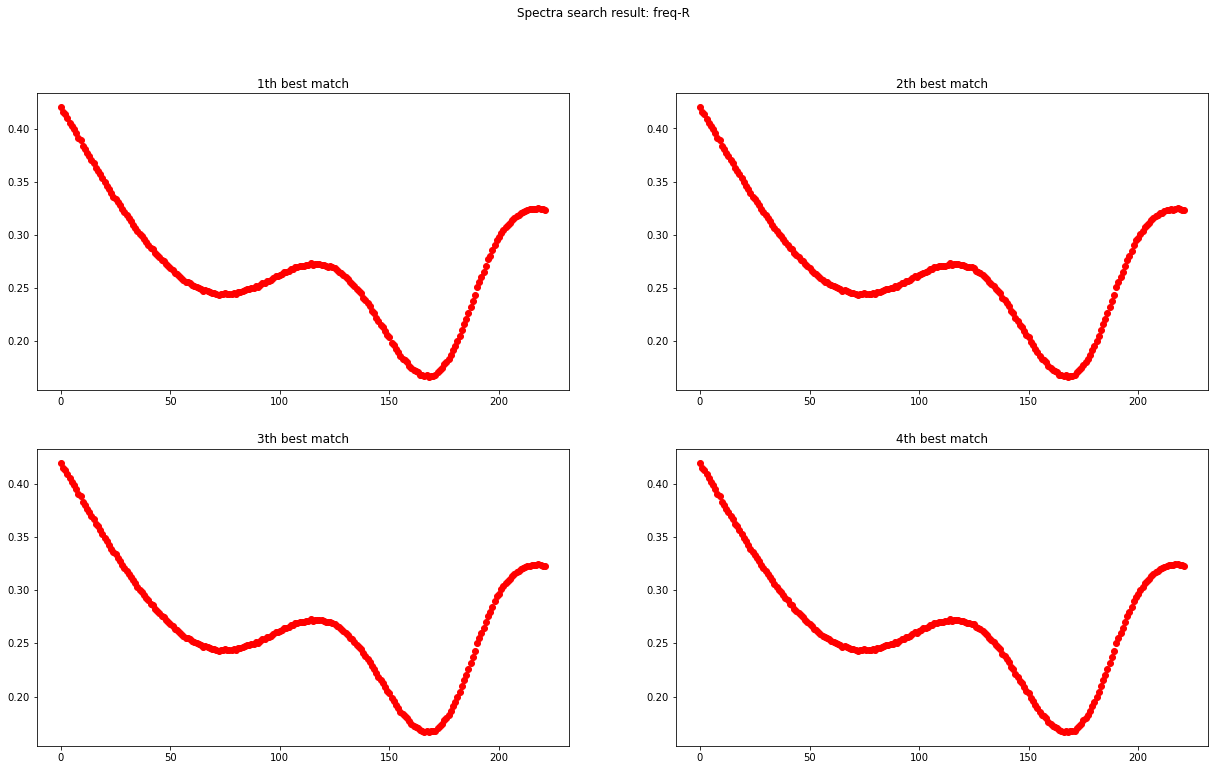

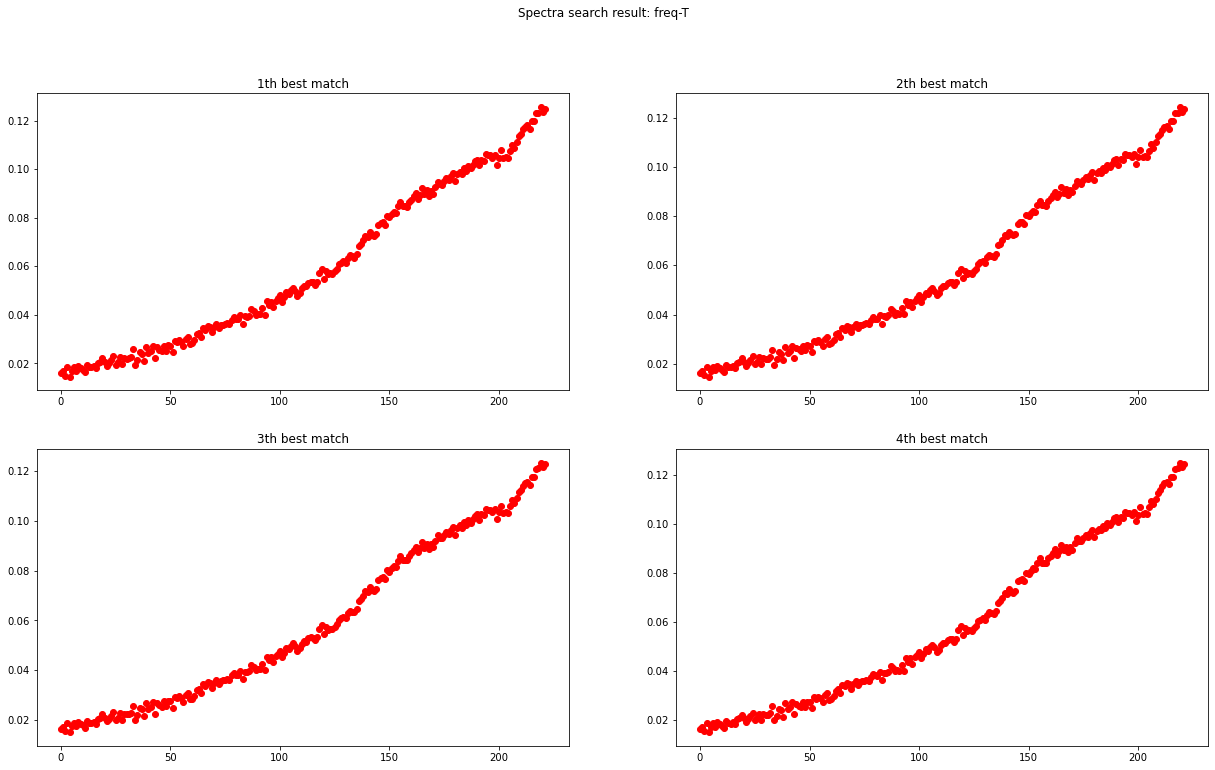

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.03967632810789599


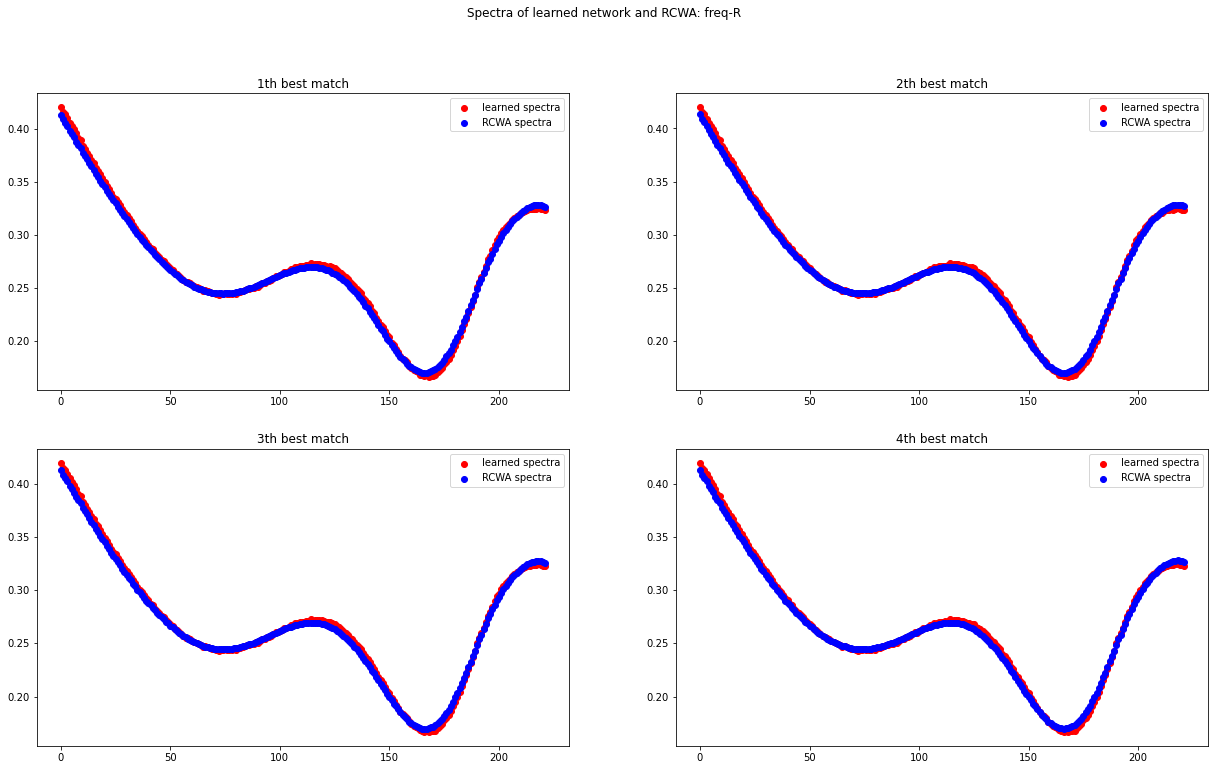

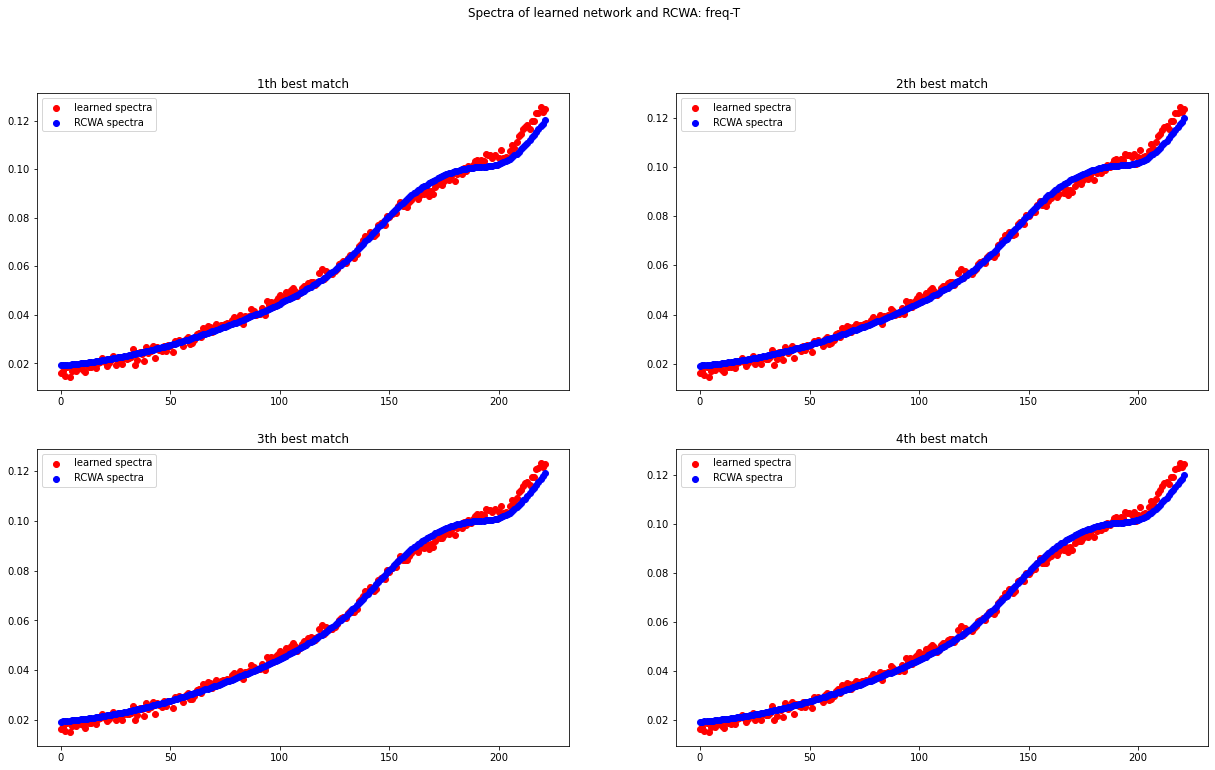

** Model saved.
**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 100
Sample points number available, continue calculating...
----------------
[ 1 / 50 ] [D1, D2] = [83. 97.]
Calculation Progress: 100%
----------------
[ 2 / 50 ] [D1, D2] = [145.  68.]
Calculation Progress: 100%
----------------
[ 3 / 50 ] [D1, D2] = [ 69. 142.]
Calculation Progress: 100%
----------------
[ 4 / 50 ] [D1, D2] = [110.  67.]
Calculation Progress: 100%
----------------
[ 5 / 50 ] [D1, D2] = [ 77. 106.]
Calculation Progress: 100%
----------------
[ 6 / 50 ] [D1, D2] = [ 74. 124.]
Calculation Progress: 100%
----------------
[ 7 / 50 ] [D1, D2] = [149.  85.]
Calculation Progress: 100%
----------------
[ 8 / 50 ] [D1, D2] = [ 81. 104.]
Calculation Progress: 100%
----------------
[ 9 / 50 ] [D1, D2] = [134.  83.]
Calculation Progress: 100%
----------------
[ 10 / 50 ] [D1, D2] = [139. 125.]
Calculation Progress: 

----------------------------------------------------------------------
*** EPOCH 26 || AVG LOSS 0.00034717515046622793
### TEST LOSS  0.0004514483007369563
----------------------------------------------------------------------
*** EPOCH 27 || AVG LOSS 0.000409430737272487
### TEST LOSS  0.0004404290084494278
----------------------------------------------------------------------
*** EPOCH 28 || AVG LOSS 0.0003729919728539244
### TEST LOSS  0.0004372362600406632
----------------------------------------------------------------------
*** EPOCH 29 || AVG LOSS 0.00026947780377668096
### TEST LOSS  0.0009334723581559956
----------------------------------------------------------------------
*** EPOCH 30 || AVG LOSS 0.00032492990590981207
### TEST LOSS  0.00012522862380137667
----------------------------------------------------------------------
*** EPOCH 31 || AVG LOSS 9.66964217423083e-05
### TEST LOSS  7.643187745998148e-05
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 79 || AVG LOSS 6.456223738382505e-06
### TEST LOSS  5.2926595799362985e-06
----------------------------------------------------------------------
*** EPOCH 80 || AVG LOSS 5.085069345227566e-06
### TEST LOSS  6.403917495845235e-06
----------------------------------------------------------------------
*** EPOCH 81 || AVG LOSS 6.607694139120213e-06
### TEST LOSS  5.5670959682174725e-06
----------------------------------------------------------------------
*** EPOCH 82 || AVG LOSS 5.130588899646682e-06
### TEST LOSS  4.884655481873779e-06
----------------------------------------------------------------------
*** EPOCH 83 || AVG LOSS 4.578634342351507e-06
### TEST LOSS  3.6033069363838877e-06
----------------------------------------------------------------------
*** EPOCH 84 || AVG LOSS 4.570932369460934e-06
### TEST LOSS  4.8534425332036335e-06
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 132 || AVG LOSS 2.1075226180755636e-06
### TEST LOSS  2.1160133201192366e-06
----------------------------------------------------------------------
*** EPOCH 133 || AVG LOSS 1.764248723077344e-06
### TEST LOSS  2.400297262283857e-06
----------------------------------------------------------------------
*** EPOCH 134 || AVG LOSS 2.5420826736421987e-06
### TEST LOSS  2.793163389469555e-06
----------------------------------------------------------------------
*** EPOCH 135 || AVG LOSS 2.899892564869333e-06
### TEST LOSS  2.1778508880743175e-06
----------------------------------------------------------------------
*** EPOCH 136 || AVG LOSS 3.826413602610046e-06
### TEST LOSS  3.2160610317077953e-06
----------------------------------------------------------------------
*** EPOCH 137 || AVG LOSS 3.317013775472333e-06
### TEST LOSS  3.4329575555602787e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 185 || AVG LOSS 1.4735644646179936e-06
### TEST LOSS  1.383250719300122e-06
----------------------------------------------------------------------
*** EPOCH 186 || AVG LOSS 1.714673279593626e-06
### TEST LOSS  1.626978075819352e-06
----------------------------------------------------------------------
*** EPOCH 187 || AVG LOSS 1.7089613903920054e-06
### TEST LOSS  1.3444929436445818e-06
----------------------------------------------------------------------
*** EPOCH 188 || AVG LOSS 1.3532074351019218e-06
### TEST LOSS  1.233738998962508e-06
----------------------------------------------------------------------
*** EPOCH 189 || AVG LOSS 1.2714142195591193e-06
### TEST LOSS  1.3294489917825558e-06
----------------------------------------------------------------------
*** EPOCH 190 || AVG LOSS 1.2223799757293818e-06
### TEST LOSS  1.1286389849374245e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 238 || AVG LOSS 1.2496320462673794e-06
### TEST LOSS  1.0330199131658446e-06
----------------------------------------------------------------------
*** EPOCH 239 || AVG LOSS 1.4412405471375678e-06
### TEST LOSS  7.081269188802253e-07
----------------------------------------------------------------------
*** EPOCH 240 || AVG LOSS 1.1337458963112112e-06
### TEST LOSS  9.534719538351055e-07
----------------------------------------------------------------------
*** EPOCH 241 || AVG LOSS 1.004740576249219e-06
### TEST LOSS  1.20515133517074e-06
----------------------------------------------------------------------
*** EPOCH 242 || AVG LOSS 8.954432722418914e-07
### TEST LOSS  7.779013344588748e-07
----------------------------------------------------------------------
*** EPOCH 243 || AVG LOSS 8.466822055197554e-07
### TEST LOSS  1.1623040734320966e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 291 || AVG LOSS 8.010007010739173e-07
### TEST LOSS  7.873680658576632e-07
----------------------------------------------------------------------
*** EPOCH 292 || AVG LOSS 1.032833606444683e-06
### TEST LOSS  7.344889354499173e-07
----------------------------------------------------------------------
*** EPOCH 293 || AVG LOSS 7.8403534246263e-07
### TEST LOSS  6.421812770440738e-07
----------------------------------------------------------------------
*** EPOCH 294 || AVG LOSS 9.217301946762291e-07
### TEST LOSS  8.311265844440641e-07
----------------------------------------------------------------------
*** EPOCH 295 || AVG LOSS 8.255964213077505e-07
### TEST LOSS  7.756413253900973e-07
----------------------------------------------------------------------
*** EPOCH 296 || AVG LOSS 6.539101308078443e-07
### TEST LOSS  4.2844403935760056e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 344 || AVG LOSS 1.3567397466829335e-06
### TEST LOSS  1.956014813231377e-06
----------------------------------------------------------------------
*** EPOCH 345 || AVG LOSS 1.271054212566014e-06
### TEST LOSS  9.678541914581729e-07
----------------------------------------------------------------------
*** EPOCH 346 || AVG LOSS 8.900090168140196e-07
### TEST LOSS  1.2066409169619874e-06
----------------------------------------------------------------------
*** EPOCH 347 || AVG LOSS 9.660523066656878e-07
### TEST LOSS  7.149642726744787e-07
----------------------------------------------------------------------
*** EPOCH 348 || AVG LOSS 1.453610121089355e-06
### TEST LOSS  7.811876798768935e-07
----------------------------------------------------------------------
*** EPOCH 349 || AVG LOSS 9.710971411891478e-07
### TEST LOSS  8.620656615221378e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 397 || AVG LOSS 1.4061139054888372e-06
### TEST LOSS  1.0373170482580463e-06
----------------------------------------------------------------------
*** EPOCH 398 || AVG LOSS 1.423789425984978e-06
### TEST LOSS  1.2048351891280618e-05
----------------------------------------------------------------------
*** EPOCH 399 || AVG LOSS 4.017530685871407e-06
### TEST LOSS  6.023339437888353e-06
----------------------------------------------------------------------
*** EPOCH 400 || AVG LOSS 2.994087974741433e-06
### TEST LOSS  1.3767694326816127e-06
----------------------------------------------------------------------
*** EPOCH 401 || AVG LOSS 1.162813451145439e-06
### TEST LOSS  7.77209038460569e-07
----------------------------------------------------------------------
*** EPOCH 402 || AVG LOSS 6.490856636531817e-07
### TEST LOSS  4.3988255526983266e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 450 || AVG LOSS 3.500591441252254e-07
### TEST LOSS  2.707038362359526e-07
----------------------------------------------------------------------
*** EPOCH 451 || AVG LOSS 3.2377609795020133e-07
### TEST LOSS  3.8172116489931796e-07
----------------------------------------------------------------------
*** EPOCH 452 || AVG LOSS 3.334142741806545e-07
### TEST LOSS  2.400144225589429e-07
----------------------------------------------------------------------
*** EPOCH 453 || AVG LOSS 3.5071958691901274e-07
### TEST LOSS  5.180174582619657e-07
----------------------------------------------------------------------
*** EPOCH 454 || AVG LOSS 4.109836651622345e-07
### TEST LOSS  4.439034597680802e-07
----------------------------------------------------------------------
*** EPOCH 455 || AVG LOSS 4.3900552007869467e-07
### TEST LOSS  2.665995850748004e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 503 || AVG LOSS 2.389160187732386e-07
### TEST LOSS  2.355464445713551e-07
----------------------------------------------------------------------
*** EPOCH 504 || AVG LOSS 2.563075118544589e-07
### TEST LOSS  2.0750253071355473e-07
----------------------------------------------------------------------
*** EPOCH 505 || AVG LOSS 2.678995151939034e-07
### TEST LOSS  3.6586197893484496e-07
----------------------------------------------------------------------
*** EPOCH 506 || AVG LOSS 2.5686887113351985e-07
### TEST LOSS  2.699922561077983e-07
----------------------------------------------------------------------
*** EPOCH 507 || AVG LOSS 2.718543261082118e-07
### TEST LOSS  2.412166750787037e-07
----------------------------------------------------------------------
*** EPOCH 508 || AVG LOSS 2.839682966637724e-07
### TEST LOSS  4.055381594980645e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 556 || AVG LOSS 2.0126393597053037e-07
### TEST LOSS  1.791254362615291e-07
----------------------------------------------------------------------
*** EPOCH 557 || AVG LOSS 2.4935366415235195e-07
### TEST LOSS  2.2820067613338324e-07
----------------------------------------------------------------------
*** EPOCH 558 || AVG LOSS 2.6647352999731313e-07
### TEST LOSS  2.0859642546611212e-07
----------------------------------------------------------------------
*** EPOCH 559 || AVG LOSS 3.474407439796323e-07
### TEST LOSS  4.706335232640413e-07
----------------------------------------------------------------------
*** EPOCH 560 || AVG LOSS 5.672383615973331e-07
### TEST LOSS  4.326821994027341e-07
----------------------------------------------------------------------
*** EPOCH 561 || AVG LOSS 6.432854538473975e-07
### TEST LOSS  5.152948858722084e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 609 || AVG LOSS 2.55880870696501e-07
### TEST LOSS  2.0700238678728056e-07
----------------------------------------------------------------------
*** EPOCH 610 || AVG LOSS 2.3153366118577879e-07
### TEST LOSS  1.637572921708852e-07
----------------------------------------------------------------------
*** EPOCH 611 || AVG LOSS 1.9559737847174573e-07
### TEST LOSS  3.6258799696042843e-07
----------------------------------------------------------------------
*** EPOCH 612 || AVG LOSS 2.3616764689649016e-07
### TEST LOSS  1.836705365576563e-07
----------------------------------------------------------------------
*** EPOCH 613 || AVG LOSS 2.485725954848306e-07
### TEST LOSS  2.5174738027544663e-07
----------------------------------------------------------------------
*** EPOCH 614 || AVG LOSS 2.71721602231878e-07
### TEST LOSS  2.0556996815912498e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 662 || AVG LOSS 3.8160283530430663e-07
### TEST LOSS  2.125402858155212e-07
----------------------------------------------------------------------
*** EPOCH 663 || AVG LOSS 2.2534898235448964e-07
### TEST LOSS  2.535159779881724e-07
----------------------------------------------------------------------
*** EPOCH 664 || AVG LOSS 2.3635130705912388e-07
### TEST LOSS  2.0705377323793073e-07
----------------------------------------------------------------------
*** EPOCH 665 || AVG LOSS 2.687755052477314e-07
### TEST LOSS  1.8269860646569214e-07
----------------------------------------------------------------------
*** EPOCH 666 || AVG LOSS 2.4440236396472414e-07
### TEST LOSS  2.661148812421743e-07
----------------------------------------------------------------------
*** EPOCH 667 || AVG LOSS 2.4411370404209264e-07
### TEST LOSS  3.3051348680146475e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 715 || AVG LOSS 2.2904172674031998e-07
### TEST LOSS  2.3348857780547405e-07
----------------------------------------------------------------------
*** EPOCH 716 || AVG LOSS 3.207926741310985e-07
### TEST LOSS  3.2510182279565925e-07
----------------------------------------------------------------------
*** EPOCH 717 || AVG LOSS 2.388215996873555e-07
### TEST LOSS  1.6911138089881206e-07
----------------------------------------------------------------------
*** EPOCH 718 || AVG LOSS 2.4449244605762034e-07
### TEST LOSS  2.697438929999407e-07
----------------------------------------------------------------------
*** EPOCH 719 || AVG LOSS 2.401096021742433e-07
### TEST LOSS  2.419475464421339e-07
----------------------------------------------------------------------
*** EPOCH 720 || AVG LOSS 1.9114884267423804e-07
### TEST LOSS  3.640325445530834e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 768 || AVG LOSS 4.2031754546201225e-07
### TEST LOSS  2.7157911119957134e-07
----------------------------------------------------------------------
*** EPOCH 769 || AVG LOSS 3.6284957211307755e-07
### TEST LOSS  1.8130445056385724e-07
----------------------------------------------------------------------
*** EPOCH 770 || AVG LOSS 1.8332753969119154e-07
### TEST LOSS  2.820348186105548e-07
----------------------------------------------------------------------
*** EPOCH 771 || AVG LOSS 2.528635939924584e-07
### TEST LOSS  1.6835322469432867e-07
----------------------------------------------------------------------
*** EPOCH 772 || AVG LOSS 1.981921356097871e-07
### TEST LOSS  1.650888208359902e-07
----------------------------------------------------------------------
*** EPOCH 773 || AVG LOSS 1.774350243621825e-07
### TEST LOSS  1.4067198605971498e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 821 || AVG LOSS 1.9292441113094584e-07
### TEST LOSS  1.7130555818312132e-07
----------------------------------------------------------------------
*** EPOCH 822 || AVG LOSS 2.1081087950847177e-07
### TEST LOSS  2.6496960003896675e-07
----------------------------------------------------------------------
*** EPOCH 823 || AVG LOSS 2.9094406986729384e-07
### TEST LOSS  2.990385752354996e-07
----------------------------------------------------------------------
*** EPOCH 824 || AVG LOSS 3.2160996873642487e-07
### TEST LOSS  7.813364391040523e-07
----------------------------------------------------------------------
*** EPOCH 825 || AVG LOSS 2.794645010339991e-07
### TEST LOSS  1.7570989996329445e-07
----------------------------------------------------------------------
*** EPOCH 826 || AVG LOSS 1.9843231410021645e-07
### TEST LOSS  1.4252013613713643e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 874 || AVG LOSS 1.7378646898436046e-07
### TEST LOSS  1.284967652281921e-07
----------------------------------------------------------------------
*** EPOCH 875 || AVG LOSS 1.4444363287680063e-07
### TEST LOSS  2.2265914623176286e-07
----------------------------------------------------------------------
*** EPOCH 876 || AVG LOSS 2.0872080696676676e-07
### TEST LOSS  1.4600389164343142e-07
----------------------------------------------------------------------
*** EPOCH 877 || AVG LOSS 1.8895833502341476e-07
### TEST LOSS  1.61607545123843e-07
----------------------------------------------------------------------
*** EPOCH 878 || AVG LOSS 1.7725370776489058e-07
### TEST LOSS  1.5600526381831514e-07
----------------------------------------------------------------------
*** EPOCH 879 || AVG LOSS 1.457062083165539e-07
### TEST LOSS  1.9871276890626177e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 927 || AVG LOSS 1.5859508438076374e-07
### TEST LOSS  1.5696904398510014e-07
----------------------------------------------------------------------
*** EPOCH 928 || AVG LOSS 1.3370296610304423e-07
### TEST LOSS  1.3465629677966717e-07
----------------------------------------------------------------------
*** EPOCH 929 || AVG LOSS 1.9970162723481621e-07
### TEST LOSS  3.3251852471494203e-07
----------------------------------------------------------------------
*** EPOCH 930 || AVG LOSS 1.863022441739304e-07
### TEST LOSS  1.5240381401326886e-07
----------------------------------------------------------------------
*** EPOCH 931 || AVG LOSS 2.0205706736220463e-07
### TEST LOSS  2.935440761575592e-07
----------------------------------------------------------------------
*** EPOCH 932 || AVG LOSS 2.4694897694743644e-07
### TEST LOSS  2.447697369234447e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 980 || AVG LOSS 4.104753389100324e-07
### TEST LOSS  3.564150006241107e-07
----------------------------------------------------------------------
*** EPOCH 981 || AVG LOSS 2.509710566300782e-07
### TEST LOSS  1.6035035343975323e-07
----------------------------------------------------------------------
*** EPOCH 982 || AVG LOSS 2.0442341540416466e-07
### TEST LOSS  1.8962008851985956e-07
----------------------------------------------------------------------
*** EPOCH 983 || AVG LOSS 1.8968623203718947e-07
### TEST LOSS  1.6661342527868328e-07
----------------------------------------------------------------------
*** EPOCH 984 || AVG LOSS 1.945928013569187e-07
### TEST LOSS  1.3468822857021223e-07
----------------------------------------------------------------------
*** EPOCH 985 || AVG LOSS 1.9804074275597827e-07
### TEST LOSS  1.474580457738739e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1032 || AVG LOSS 3.5382218793955644e-07
### TEST LOSS  2.334702031703273e-07
----------------------------------------------------------------------
*** EPOCH 1033 || AVG LOSS 1.7604094045609032e-07
### TEST LOSS  1.2877958610602036e-07
----------------------------------------------------------------------
*** EPOCH 1034 || AVG LOSS 1.5184593742390008e-07
### TEST LOSS  1.4688073690649617e-07
----------------------------------------------------------------------
*** EPOCH 1035 || AVG LOSS 1.4918416733067374e-07
### TEST LOSS  1.40606992715675e-07
----------------------------------------------------------------------
*** EPOCH 1036 || AVG LOSS 1.792299981318024e-07
### TEST LOSS  1.7050847134214564e-07
----------------------------------------------------------------------
*** EPOCH 1037 || AVG LOSS 1.483197096874278e-07
### TEST LOSS  2.0406503153935773e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1084 || AVG LOSS 2.2839950698738675e-07
### TEST LOSS  1.3686804578583178e-07
----------------------------------------------------------------------
*** EPOCH 1085 || AVG LOSS 1.1557926804073305e-07
### TEST LOSS  1.2310912111956895e-07
----------------------------------------------------------------------
*** EPOCH 1086 || AVG LOSS 1.8746075403086593e-07
### TEST LOSS  8.520461491912101e-08
----------------------------------------------------------------------
*** EPOCH 1087 || AVG LOSS 1.7630733928797326e-07
### TEST LOSS  1.4002784354261166e-07
----------------------------------------------------------------------
*** EPOCH 1088 || AVG LOSS 1.802300542230739e-07
### TEST LOSS  1.5064973268863469e-07
----------------------------------------------------------------------
*** EPOCH 1089 || AVG LOSS 1.4783211355506864e-07
### TEST LOSS  1.3967991918661937e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1136 || AVG LOSS 1.1414707266510505e-07
### TEST LOSS  9.465119532592325e-08
----------------------------------------------------------------------
*** EPOCH 1137 || AVG LOSS 1.0923231286597001e-07
### TEST LOSS  9.607737183614518e-08
----------------------------------------------------------------------
*** EPOCH 1138 || AVG LOSS 1.4466808333502003e-07
### TEST LOSS  8.351404545692276e-08
----------------------------------------------------------------------
*** EPOCH 1139 || AVG LOSS 2.0373768816028815e-07
### TEST LOSS  1.5932357655401574e-07
----------------------------------------------------------------------
*** EPOCH 1140 || AVG LOSS 1.5008116120540648e-07
### TEST LOSS  9.713943782685419e-08
----------------------------------------------------------------------
*** EPOCH 1141 || AVG LOSS 2.1143424850933456e-07
### TEST LOSS  1.1717124692722791e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1188 || AVG LOSS 2.0312726949356376e-07
### TEST LOSS  1.113233096816657e-07
----------------------------------------------------------------------
*** EPOCH 1189 || AVG LOSS 1.2212048186022174e-07
### TEST LOSS  1.1057647242296298e-07
----------------------------------------------------------------------
*** EPOCH 1190 || AVG LOSS 1.206343363069351e-07
### TEST LOSS  1.180798427924401e-07
----------------------------------------------------------------------
*** EPOCH 1191 || AVG LOSS 1.1003654387664596e-07
### TEST LOSS  1.630903057048272e-07
----------------------------------------------------------------------
*** EPOCH 1192 || AVG LOSS 1.7985344257454018e-07
### TEST LOSS  1.4574482065654593e-07
----------------------------------------------------------------------
*** EPOCH 1193 || AVG LOSS 1.2408837754662727e-07
### TEST LOSS  1.5341402814783578e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1240 || AVG LOSS 1.2402086619456298e-07
### TEST LOSS  1.322926408420244e-07
----------------------------------------------------------------------
*** EPOCH 1241 || AVG LOSS 1.617818299948226e-07
### TEST LOSS  1.3799157017047037e-07
----------------------------------------------------------------------
*** EPOCH 1242 || AVG LOSS 1.2199914209531926e-07
### TEST LOSS  1.2395144111110312e-07
----------------------------------------------------------------------
*** EPOCH 1243 || AVG LOSS 1.1696502207669823e-07
### TEST LOSS  1.233774504783014e-07
----------------------------------------------------------------------
*** EPOCH 1244 || AVG LOSS 1.1436095862293882e-07
### TEST LOSS  8.087403813306082e-08
----------------------------------------------------------------------
*** EPOCH 1245 || AVG LOSS 1.0809927472266168e-07
### TEST LOSS  1.0618214574265039e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1292 || AVG LOSS 1.6001346551774985e-07
### TEST LOSS  9.84875221377024e-08
----------------------------------------------------------------------
*** EPOCH 1293 || AVG LOSS 1.4640236337015722e-07
### TEST LOSS  3.0531393235833093e-07
----------------------------------------------------------------------
*** EPOCH 1294 || AVG LOSS 2.0123987166442702e-07
### TEST LOSS  9.066935291457412e-08
----------------------------------------------------------------------
*** EPOCH 1295 || AVG LOSS 1.0712850375682593e-07
### TEST LOSS  7.79559883312686e-08
----------------------------------------------------------------------
*** EPOCH 1296 || AVG LOSS 1.1234757487432744e-07
### TEST LOSS  9.799211753147574e-08
----------------------------------------------------------------------
*** EPOCH 1297 || AVG LOSS 1.2106545524304124e-07
### TEST LOSS  9.841228632012644e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1344 || AVG LOSS 1.4360877491625957e-07
### TEST LOSS  1.442353401159835e-07
----------------------------------------------------------------------
*** EPOCH 1345 || AVG LOSS 1.7934833344668276e-07
### TEST LOSS  1.0547599771371097e-07
----------------------------------------------------------------------
*** EPOCH 1346 || AVG LOSS 1.1300632529298583e-07
### TEST LOSS  8.089567060665104e-08
----------------------------------------------------------------------
*** EPOCH 1347 || AVG LOSS 2.0861511885073014e-07
### TEST LOSS  1.0033332387138216e-07
----------------------------------------------------------------------
*** EPOCH 1348 || AVG LOSS 1.2300658864816682e-07
### TEST LOSS  9.827619606994631e-08
----------------------------------------------------------------------
*** EPOCH 1349 || AVG LOSS 1.120948466137861e-07
### TEST LOSS  1.1361305141122102e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1396 || AVG LOSS 9.054196131508263e-08
### TEST LOSS  7.465963136610299e-08
----------------------------------------------------------------------
*** EPOCH 1397 || AVG LOSS 1.5108147625397805e-07
### TEST LOSS  1.8511591548531214e-07
----------------------------------------------------------------------
*** EPOCH 1398 || AVG LOSS 1.6792192308656695e-07
### TEST LOSS  1.62464843356247e-07
----------------------------------------------------------------------
*** EPOCH 1399 || AVG LOSS 3.1788817029365645e-07
### TEST LOSS  1.5830094568514141e-07
----------------------------------------------------------------------
*** EPOCH 1400 || AVG LOSS 1.7878216045374985e-07
### TEST LOSS  1.0328755095656561e-07
----------------------------------------------------------------------
*** EPOCH 1401 || AVG LOSS 1.1462804762274459e-07
### TEST LOSS  8.842836862754666e-08
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1448 || AVG LOSS 1.187222824228229e-07
### TEST LOSS  9.882008455974756e-08
----------------------------------------------------------------------
*** EPOCH 1449 || AVG LOSS 8.066414793894694e-08
### TEST LOSS  6.16553084142879e-08
----------------------------------------------------------------------
*** EPOCH 1450 || AVG LOSS 1.106527023875259e-07
### TEST LOSS  8.808655138636823e-08
----------------------------------------------------------------------
*** EPOCH 1451 || AVG LOSS 1.0178382884973303e-07
### TEST LOSS  1.0154913709925495e-07
----------------------------------------------------------------------
*** EPOCH 1452 || AVG LOSS 1.4032595587742947e-07
### TEST LOSS  2.927732509760972e-07
----------------------------------------------------------------------
*** EPOCH 1453 || AVG LOSS 1.669433090256689e-07
### TEST LOSS  8.801801598679049e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1500 || AVG LOSS 9.537460453401536e-08
### TEST LOSS  1.0195980237881486e-07
----------------------------------------------------------------------
*** EPOCH 1501 || AVG LOSS 1.1107136139720808e-07
### TEST LOSS  9.361542296915104e-08
----------------------------------------------------------------------
*** EPOCH 1502 || AVG LOSS 9.66874126318018e-08
### TEST LOSS  6.559096377145579e-08
----------------------------------------------------------------------
*** EPOCH 1503 || AVG LOSS 9.526470888587823e-08
### TEST LOSS  8.394980000048236e-08
----------------------------------------------------------------------
*** EPOCH 1504 || AVG LOSS 9.450144068168243e-08
### TEST LOSS  1.45380312233101e-07
----------------------------------------------------------------------
*** EPOCH 1505 || AVG LOSS 1.263951330265911e-07
### TEST LOSS  1.166145828790377e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1552 || AVG LOSS 1.2275486380275424e-07
### TEST LOSS  1.4443648765904982e-07
----------------------------------------------------------------------
*** EPOCH 1553 || AVG LOSS 1.0094829725915134e-07
### TEST LOSS  1.178261861412011e-07
----------------------------------------------------------------------
*** EPOCH 1554 || AVG LOSS 9.560156586374546e-08
### TEST LOSS  1.0214165158117794e-07
----------------------------------------------------------------------
*** EPOCH 1555 || AVG LOSS 1.0899863124969044e-07
### TEST LOSS  2.5974443929044355e-07
----------------------------------------------------------------------
*** EPOCH 1556 || AVG LOSS 1.3362112854409248e-07
### TEST LOSS  1.0555308804782726e-07
----------------------------------------------------------------------
*** EPOCH 1557 || AVG LOSS 1.2276460374494035e-07
### TEST LOSS  6.394332885406584e-08
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1604 || AVG LOSS 1.0063995371289991e-07
### TEST LOSS  7.236436161406345e-08
----------------------------------------------------------------------
*** EPOCH 1605 || AVG LOSS 1.2002661903487421e-07
### TEST LOSS  7.715187422263625e-08
----------------------------------------------------------------------
*** EPOCH 1606 || AVG LOSS 1.1464363996793736e-07
### TEST LOSS  7.251768607829945e-08
----------------------------------------------------------------------
*** EPOCH 1607 || AVG LOSS 1.030923925249283e-07
### TEST LOSS  1.6312525019657187e-07
----------------------------------------------------------------------
*** EPOCH 1608 || AVG LOSS 1.9387176399376927e-07
### TEST LOSS  8.235033632786326e-08
----------------------------------------------------------------------
*** EPOCH 1609 || AVG LOSS 1.5356048122860954e-07
### TEST LOSS  1.3810105770062364e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1656 || AVG LOSS 1.4003700675502274e-07
### TEST LOSS  1.1669108346268331e-07
----------------------------------------------------------------------
*** EPOCH 1657 || AVG LOSS 1.1917707169573078e-07
### TEST LOSS  8.770846449124292e-08
----------------------------------------------------------------------
*** EPOCH 1658 || AVG LOSS 1.108839304908571e-07
### TEST LOSS  8.10845790510939e-08
----------------------------------------------------------------------
*** EPOCH 1659 || AVG LOSS 1.821479642671875e-07
### TEST LOSS  6.817897002520112e-08
----------------------------------------------------------------------
*** EPOCH 1660 || AVG LOSS 1.0873474723283039e-07
### TEST LOSS  8.990998168201259e-08
----------------------------------------------------------------------
*** EPOCH 1661 || AVG LOSS 1.0593376635448237e-07
### TEST LOSS  6.740208746691678e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1708 || AVG LOSS 9.643373823031709e-08
### TEST LOSS  6.442494537850507e-08
----------------------------------------------------------------------
*** EPOCH 1709 || AVG LOSS 8.461097803724727e-08
### TEST LOSS  8.367097237282906e-08
----------------------------------------------------------------------
*** EPOCH 1710 || AVG LOSS 1.3764803833637983e-07
### TEST LOSS  5.995087093424445e-08
----------------------------------------------------------------------
*** EPOCH 1711 || AVG LOSS 8.794094808806108e-08
### TEST LOSS  1.092311983086347e-07
----------------------------------------------------------------------
*** EPOCH 1712 || AVG LOSS 8.669364700786275e-08
### TEST LOSS  8.392753159114363e-08
----------------------------------------------------------------------
*** EPOCH 1713 || AVG LOSS 1.1042625162716036e-07
### TEST LOSS  1.2365578783146702e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1761 || AVG LOSS 9.282800654375478e-08
### TEST LOSS  1.137818799179513e-07
----------------------------------------------------------------------
*** EPOCH 1762 || AVG LOSS 9.359414095300167e-08
### TEST LOSS  7.194297246826409e-08
----------------------------------------------------------------------
*** EPOCH 1763 || AVG LOSS 8.454114532874258e-08
### TEST LOSS  6.616726011543506e-08
----------------------------------------------------------------------
*** EPOCH 1764 || AVG LOSS 1.0199353209117135e-07
### TEST LOSS  1.0222371571444455e-07
----------------------------------------------------------------------
*** EPOCH 1765 || AVG LOSS 9.898526782237126e-08
### TEST LOSS  9.301407288830887e-08
----------------------------------------------------------------------
*** EPOCH 1766 || AVG LOSS 9.868394702294836e-08
### TEST LOSS  6.517410966466741e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1814 || AVG LOSS 1.363800403986204e-07
### TEST LOSS  9.996285044167053e-08
----------------------------------------------------------------------
*** EPOCH 1815 || AVG LOSS 1.178223796749478e-07
### TEST LOSS  8.730245681931592e-08
----------------------------------------------------------------------
*** EPOCH 1816 || AVG LOSS 1.21194701403482e-07
### TEST LOSS  1.6795695501059527e-07
----------------------------------------------------------------------
*** EPOCH 1817 || AVG LOSS 1.6860079584013478e-07
### TEST LOSS  1.2432489526759127e-07
----------------------------------------------------------------------
*** EPOCH 1818 || AVG LOSS 9.961814239289878e-08
### TEST LOSS  1.3780411478592214e-07
----------------------------------------------------------------------
*** EPOCH 1819 || AVG LOSS 9.62307277596608e-08
### TEST LOSS  1.0107238779255567e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1866 || AVG LOSS 8.840277364363658e-08
### TEST LOSS  1.261045738942812e-07
----------------------------------------------------------------------
*** EPOCH 1867 || AVG LOSS 9.692337227917846e-08
### TEST LOSS  1.0698050800783676e-07
----------------------------------------------------------------------
*** EPOCH 1868 || AVG LOSS 9.990417030536492e-08
### TEST LOSS  7.437044047264862e-08
----------------------------------------------------------------------
*** EPOCH 1869 || AVG LOSS 1.1694763341729696e-07
### TEST LOSS  1.2117435232994467e-07
----------------------------------------------------------------------
*** EPOCH 1870 || AVG LOSS 1.3426530941273997e-07
### TEST LOSS  1.0490265367479878e-07
----------------------------------------------------------------------
*** EPOCH 1871 || AVG LOSS 1.8070042736795245e-07
### TEST LOSS  1.4117345870090503e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1918 || AVG LOSS 9.325410649907439e-08
### TEST LOSS  6.941513142066924e-08
----------------------------------------------------------------------
*** EPOCH 1919 || AVG LOSS 8.868408338358336e-08
### TEST LOSS  9.23649459139142e-08
----------------------------------------------------------------------
*** EPOCH 1920 || AVG LOSS 8.044081684310811e-08
### TEST LOSS  4.9297293358563365e-08
----------------------------------------------------------------------
*** EPOCH 1921 || AVG LOSS 7.017730832892255e-08
### TEST LOSS  8.022604802704336e-08
----------------------------------------------------------------------
*** EPOCH 1922 || AVG LOSS 8.224916543841942e-08
### TEST LOSS  7.372564780894209e-08
----------------------------------------------------------------------
*** EPOCH 1923 || AVG LOSS 7.850211777515881e-08
### TEST LOSS  8.759117875456468e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1970 || AVG LOSS 8.525722488883503e-08
### TEST LOSS  9.7021189304769e-08
----------------------------------------------------------------------
*** EPOCH 1971 || AVG LOSS 9.49118786941483e-08
### TEST LOSS  6.996893375799118e-08
----------------------------------------------------------------------
*** EPOCH 1972 || AVG LOSS 8.153288106882428e-08
### TEST LOSS  8.59680913123384e-08
----------------------------------------------------------------------
*** EPOCH 1973 || AVG LOSS 9.314748124378269e-08
### TEST LOSS  7.425694548146566e-08
----------------------------------------------------------------------
*** EPOCH 1974 || AVG LOSS 1.3439171687501527e-07
### TEST LOSS  9.674963763472988e-08
----------------------------------------------------------------------
*** EPOCH 1975 || AVG LOSS 1.0469011421321284e-07
### TEST LOSS  1.227361856592779e-07
------------------------------------------------------------

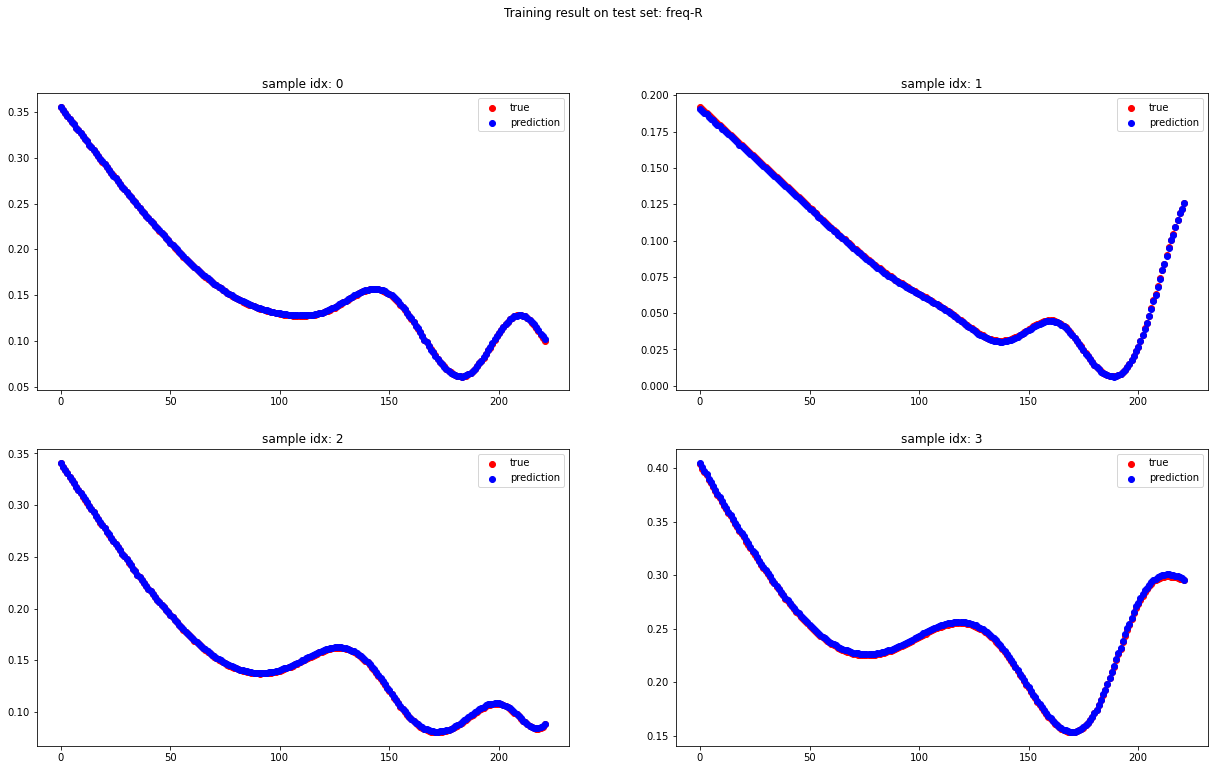

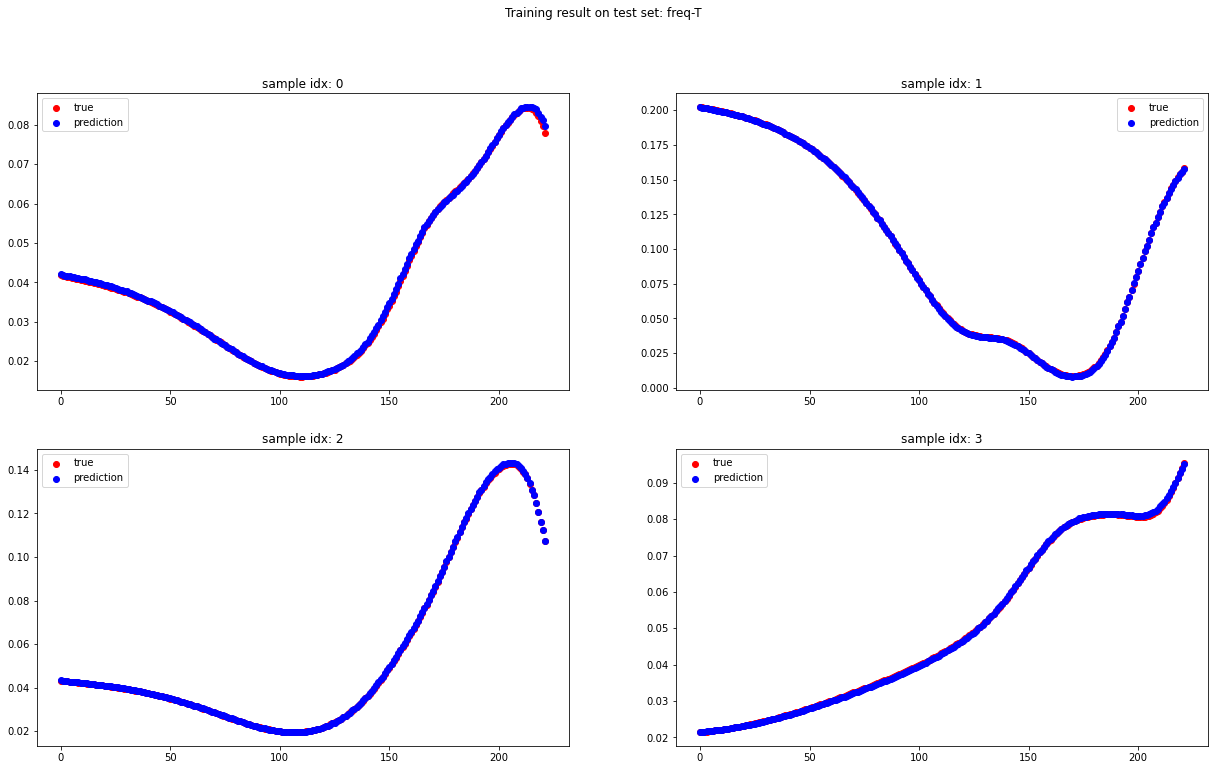

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  53. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 50.  54. 160.  75.]
 [ 51.  52. 160.  75.]
 [ 52.  50. 160.  75.]
 [ 50.  55. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


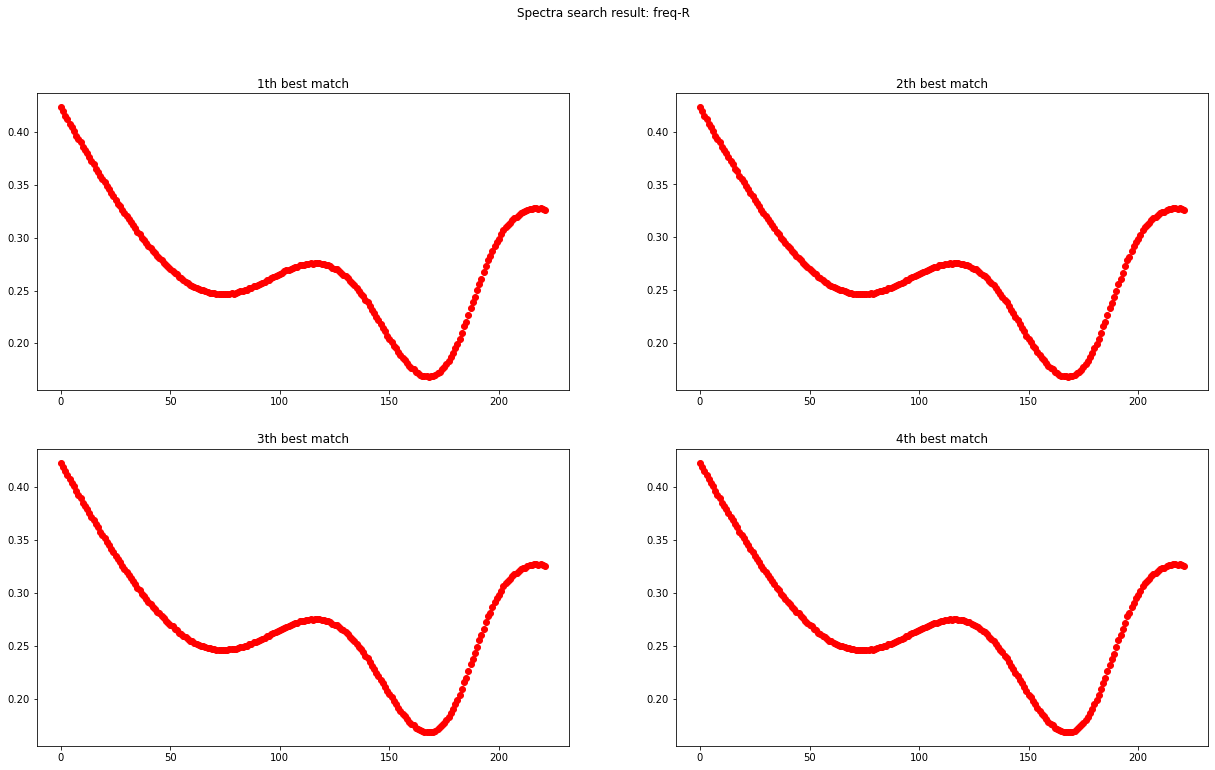

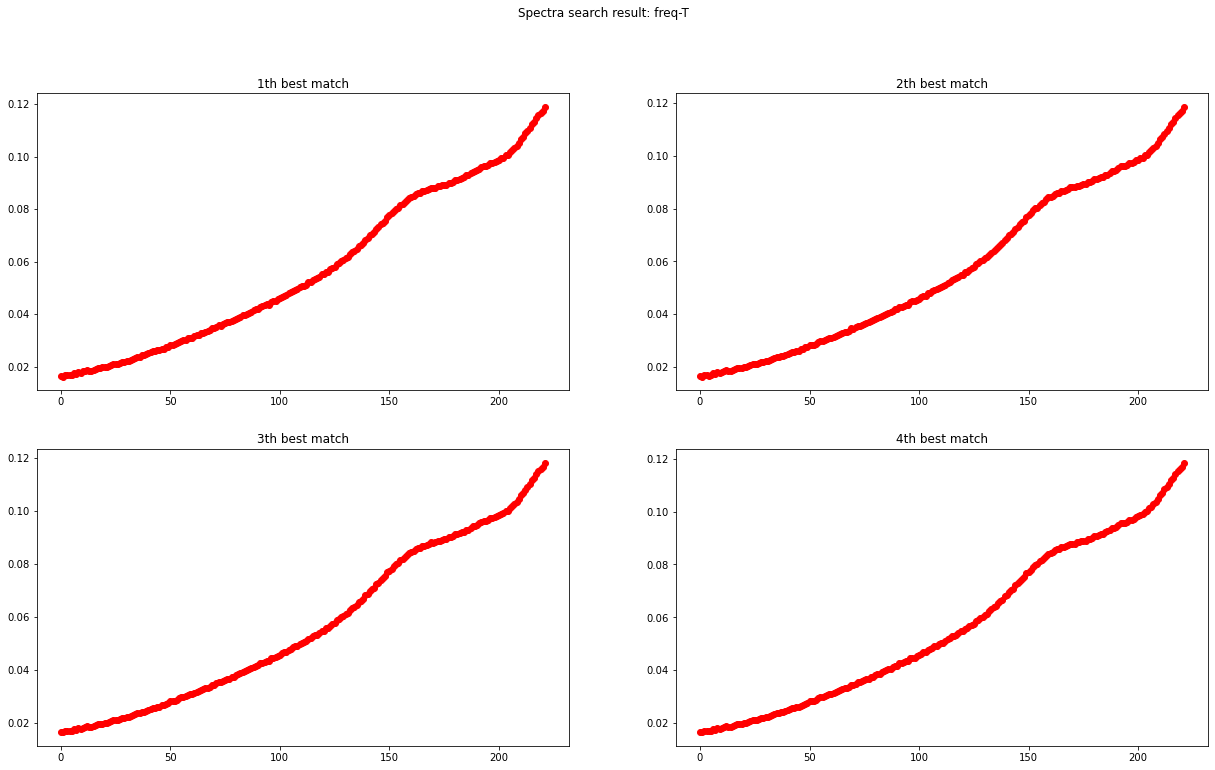

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.05517657312577668


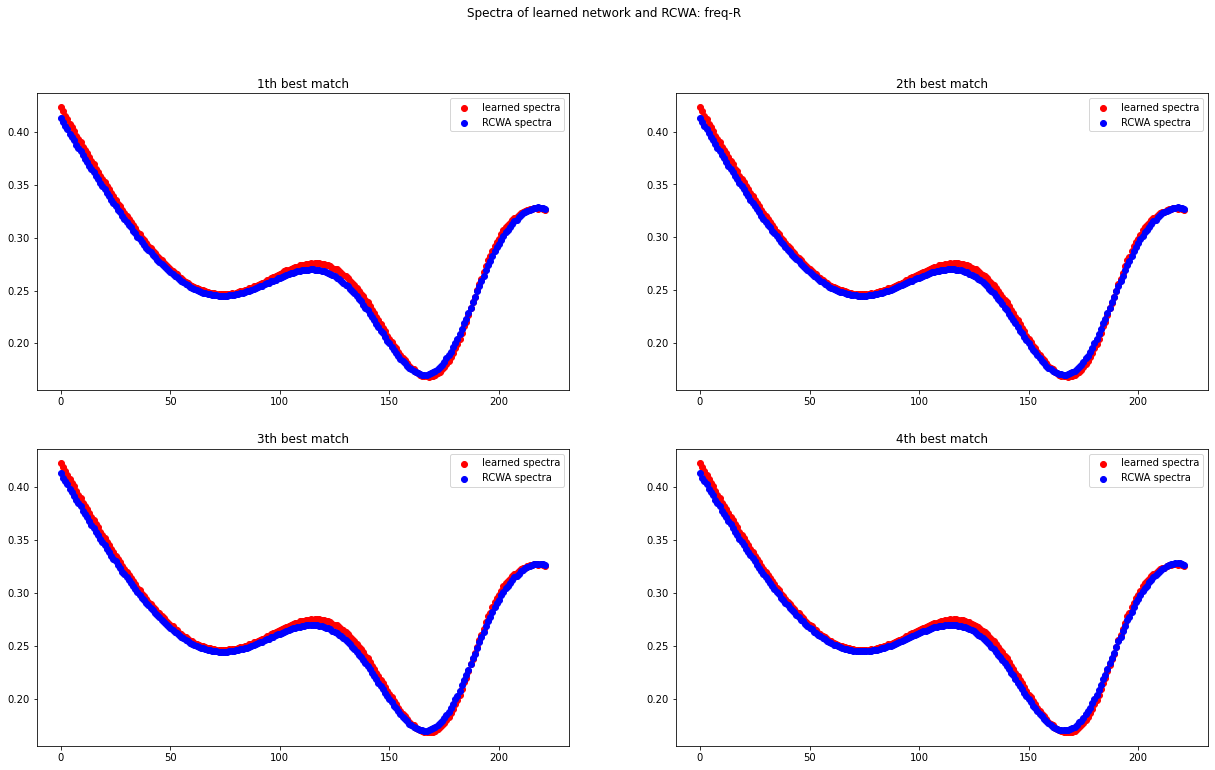

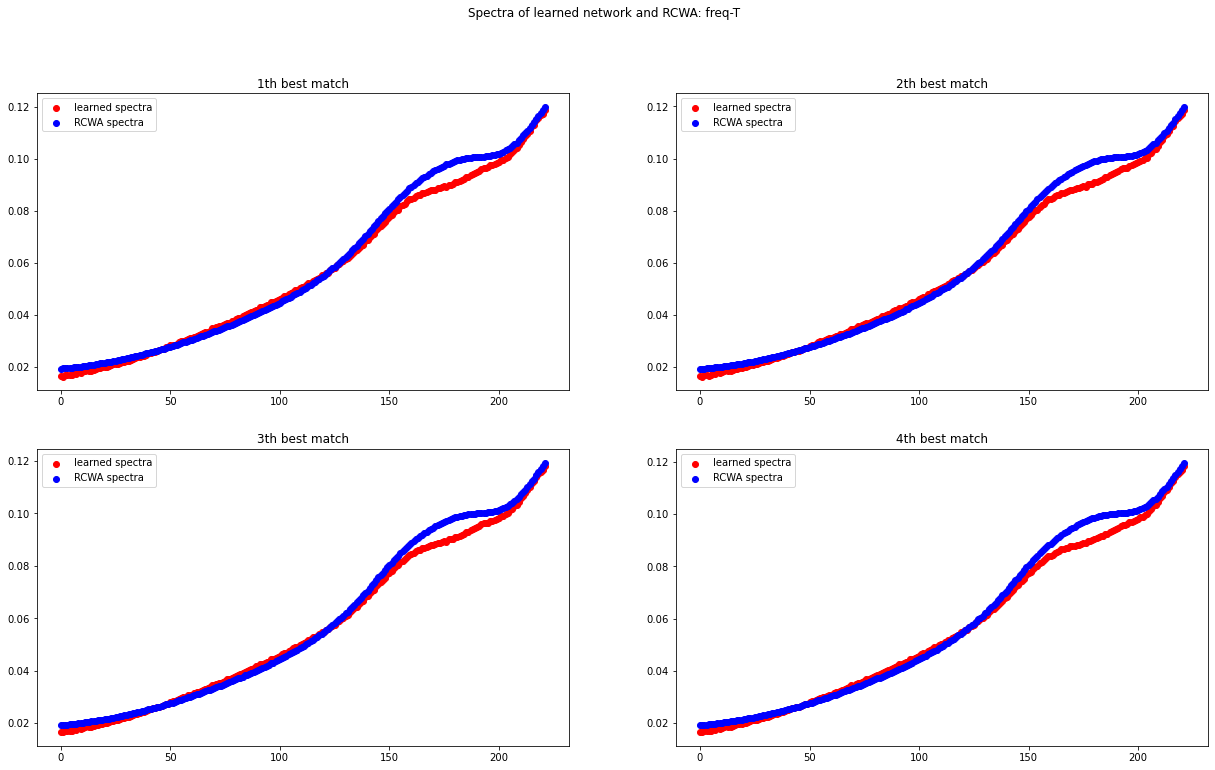

** Model saved.
**************************** ROUND 3 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 150
Sample points number available, continue calculating...
----------------
[ 1 / 50 ] [D1, D2] = [ 96. 125.]
Calculation Progress: 100%
----------------
[ 2 / 50 ] [D1, D2] = [114. 140.]
Calculation Progress: 100%
----------------
[ 3 / 50 ] [D1, D2] = [135. 141.]
Calculation Progress: 100%
----------------
[ 4 / 50 ] [D1, D2] = [146.  82.]
Calculation Progress: 100%
----------------
[ 5 / 50 ] [D1, D2] = [ 79. 147.]
Calculation Progress: 100%
----------------
[ 6 / 50 ] [D1, D2] = [ 62. 103.]
Calculation Progress: 100%
----------------
[ 7 / 50 ] [D1, D2] = [ 93. 137.]
Calculation Progress: 100%
----------------
[ 8 / 50 ] [D1, D2] = [70. 75.]
Calculation Progress: 100%
----------------
[ 9 / 50 ] [D1, D2] = [139.  97.]
Calculation Progress: 100%
----------------
[ 10 / 50 ] [D1, D2] = [122.  83.]
Calculation Progress: 

----------------------------------------------------------------------
*** EPOCH 26 || AVG LOSS 1.4760409870480847e-05
### TEST LOSS  6.088270159428551e-06
----------------------------------------------------------------------
*** EPOCH 27 || AVG LOSS 1.3641510619587886e-05
### TEST LOSS  8.763456207816489e-06
----------------------------------------------------------------------
*** EPOCH 28 || AVG LOSS 1.1321873134117291e-05
### TEST LOSS  7.206184818642214e-06
----------------------------------------------------------------------
*** EPOCH 29 || AVG LOSS 1.2206899649148303e-05
### TEST LOSS  1.024086304823868e-05
----------------------------------------------------------------------
*** EPOCH 30 || AVG LOSS 1.586282048189484e-05
### TEST LOSS  7.296054112278701e-06
----------------------------------------------------------------------
*** EPOCH 31 || AVG LOSS 1.3752270333498018e-05
### TEST LOSS  6.845210009487346e-06
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 79 || AVG LOSS 1.1400936412352772e-05
### TEST LOSS  1.7459525527859416e-05
----------------------------------------------------------------------
*** EPOCH 80 || AVG LOSS 1.683400101986384e-05
### TEST LOSS  1.3536632044027405e-05
----------------------------------------------------------------------
*** EPOCH 81 || AVG LOSS 1.3698468833733083e-05
### TEST LOSS  2.809337092912756e-05
----------------------------------------------------------------------
*** EPOCH 82 || AVG LOSS 2.4264829435196588e-05
### TEST LOSS  2.5702692558600877e-05
----------------------------------------------------------------------
*** EPOCH 83 || AVG LOSS 9.969621047882054e-06
### TEST LOSS  6.8439600606022095e-06
----------------------------------------------------------------------
*** EPOCH 84 || AVG LOSS 8.506511870033743e-06
### TEST LOSS  4.558012733468786e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 132 || AVG LOSS 4.004523648480548e-06
### TEST LOSS  4.766813466024662e-06
----------------------------------------------------------------------
*** EPOCH 133 || AVG LOSS 1.1831882421423264e-05
### TEST LOSS  5.935130199456277e-06
----------------------------------------------------------------------
*** EPOCH 134 || AVG LOSS 5.7488900923393275e-06
### TEST LOSS  5.8998321037506685e-06
----------------------------------------------------------------------
*** EPOCH 135 || AVG LOSS 4.449611823247323e-06
### TEST LOSS  1.7756143885587032e-06
----------------------------------------------------------------------
*** EPOCH 136 || AVG LOSS 2.8466271658089683e-06
### TEST LOSS  1.7461274713544601e-06
----------------------------------------------------------------------
*** EPOCH 137 || AVG LOSS 2.0906636161536576e-06
### TEST LOSS  1.4174430589264375e-06
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 185 || AVG LOSS 1.3050217114596307e-06
### TEST LOSS  7.127730630903292e-07
----------------------------------------------------------------------
*** EPOCH 186 || AVG LOSS 1.587827790577497e-06
### TEST LOSS  1.4960744465497555e-06
----------------------------------------------------------------------
*** EPOCH 187 || AVG LOSS 2.2968008264948972e-06
### TEST LOSS  3.0160780018680575e-06
----------------------------------------------------------------------
*** EPOCH 188 || AVG LOSS 1.739944817889712e-06
### TEST LOSS  1.2001533301978877e-06
----------------------------------------------------------------------
*** EPOCH 189 || AVG LOSS 1.6315143189634303e-06
### TEST LOSS  9.120418743198874e-07
----------------------------------------------------------------------
*** EPOCH 190 || AVG LOSS 1.4187311789252514e-06
### TEST LOSS  8.876548349689983e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 238 || AVG LOSS 1.7524560585494934e-06
### TEST LOSS  1.0308845806624352e-06
----------------------------------------------------------------------
*** EPOCH 239 || AVG LOSS 1.2963649636314282e-06
### TEST LOSS  8.720004226840198e-07
----------------------------------------------------------------------
*** EPOCH 240 || AVG LOSS 9.002641883171236e-07
### TEST LOSS  8.433729400773397e-07
----------------------------------------------------------------------
*** EPOCH 241 || AVG LOSS 9.90325505938472e-07
### TEST LOSS  7.678750080231111e-07
----------------------------------------------------------------------
*** EPOCH 242 || AVG LOSS 1.2385674360378591e-06
### TEST LOSS  6.649498610992547e-07
----------------------------------------------------------------------
*** EPOCH 243 || AVG LOSS 1.3148467563913376e-06
### TEST LOSS  7.569611094974485e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 291 || AVG LOSS 9.65812991751136e-07
### TEST LOSS  1.170742583174918e-06
----------------------------------------------------------------------
*** EPOCH 292 || AVG LOSS 7.962827550045403e-07
### TEST LOSS  8.734838464382241e-07
----------------------------------------------------------------------
*** EPOCH 293 || AVG LOSS 6.595820751442716e-07
### TEST LOSS  3.490094968583435e-07
----------------------------------------------------------------------
*** EPOCH 294 || AVG LOSS 6.468552003961274e-07
### TEST LOSS  4.2610651955025486e-07
----------------------------------------------------------------------
*** EPOCH 295 || AVG LOSS 1.003245588625153e-06
### TEST LOSS  9.165013542163555e-07
----------------------------------------------------------------------
*** EPOCH 296 || AVG LOSS 1.1617664930933339e-06
### TEST LOSS  1.20645216838966e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 344 || AVG LOSS 1.4737842378546398e-06
### TEST LOSS  8.941009734068454e-07
----------------------------------------------------------------------
*** EPOCH 345 || AVG LOSS 1.2544127715348925e-06
### TEST LOSS  8.696485072808476e-07
----------------------------------------------------------------------
*** EPOCH 346 || AVG LOSS 6.361394163908092e-07
### TEST LOSS  5.397495499437355e-07
----------------------------------------------------------------------
*** EPOCH 347 || AVG LOSS 9.373763905765979e-07
### TEST LOSS  1.8034820641332772e-06
----------------------------------------------------------------------
*** EPOCH 348 || AVG LOSS 1.330279618324918e-06
### TEST LOSS  8.317804258695105e-07
----------------------------------------------------------------------
*** EPOCH 349 || AVG LOSS 9.094670855347431e-07
### TEST LOSS  4.994081166387332e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 397 || AVG LOSS 6.880063057224106e-07
### TEST LOSS  3.131510387296051e-07
----------------------------------------------------------------------
*** EPOCH 398 || AVG LOSS 1.1757649025175473e-06
### TEST LOSS  1.47662679713297e-06
----------------------------------------------------------------------
*** EPOCH 399 || AVG LOSS 7.943631704658098e-07
### TEST LOSS  7.443154004249664e-07
----------------------------------------------------------------------
*** EPOCH 400 || AVG LOSS 8.997471616112307e-07
### TEST LOSS  6.035359755666528e-07
----------------------------------------------------------------------
*** EPOCH 401 || AVG LOSS 1.2062792260773373e-06
### TEST LOSS  7.464857579482972e-07
----------------------------------------------------------------------
*** EPOCH 402 || AVG LOSS 6.71065858171005e-07
### TEST LOSS  8.340571374295299e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 450 || AVG LOSS 7.30257433758652e-07
### TEST LOSS  7.044478138595878e-07
----------------------------------------------------------------------
*** EPOCH 451 || AVG LOSS 6.770368905032835e-07
### TEST LOSS  6.714821552122885e-07
----------------------------------------------------------------------
*** EPOCH 452 || AVG LOSS 1.0618255065727075e-06
### TEST LOSS  5.544822935614017e-07
----------------------------------------------------------------------
*** EPOCH 453 || AVG LOSS 8.823560989412727e-07
### TEST LOSS  7.858447664451281e-07
----------------------------------------------------------------------
*** EPOCH 454 || AVG LOSS 6.37015024409493e-07
### TEST LOSS  4.529944514312471e-07
----------------------------------------------------------------------
*** EPOCH 455 || AVG LOSS 6.506320238959992e-07
### TEST LOSS  5.995960729402819e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 503 || AVG LOSS 9.848986720821056e-07
### TEST LOSS  4.907020354494307e-07
----------------------------------------------------------------------
*** EPOCH 504 || AVG LOSS 8.595678021094955e-07
### TEST LOSS  6.702441434451126e-07
----------------------------------------------------------------------
*** EPOCH 505 || AVG LOSS 1.26582391961468e-06
### TEST LOSS  7.26228999307447e-07
----------------------------------------------------------------------
*** EPOCH 506 || AVG LOSS 8.014323898919429e-07
### TEST LOSS  3.275499409483018e-07
----------------------------------------------------------------------
*** EPOCH 507 || AVG LOSS 5.996798496710198e-07
### TEST LOSS  3.1449890987763257e-07
----------------------------------------------------------------------
*** EPOCH 508 || AVG LOSS 5.679702391129618e-07
### TEST LOSS  5.432262071281002e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 556 || AVG LOSS 5.711101966217787e-07
### TEST LOSS  8.444376362604089e-07
----------------------------------------------------------------------
*** EPOCH 557 || AVG LOSS 6.043528482753876e-07
### TEST LOSS  3.352327174373689e-07
----------------------------------------------------------------------
*** EPOCH 558 || AVG LOSS 4.191140887144229e-07
### TEST LOSS  7.5869898334228e-07
----------------------------------------------------------------------
*** EPOCH 559 || AVG LOSS 9.012589854506814e-07
### TEST LOSS  8.955708494795545e-07
----------------------------------------------------------------------
*** EPOCH 560 || AVG LOSS 7.100373601076626e-07
### TEST LOSS  4.6533565030889196e-07
----------------------------------------------------------------------
*** EPOCH 561 || AVG LOSS 5.248066516116978e-07
### TEST LOSS  3.645469822307253e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 609 || AVG LOSS 9.764730355262448e-07
### TEST LOSS  6.695140655210707e-07
----------------------------------------------------------------------
*** EPOCH 610 || AVG LOSS 6.071321351915534e-07
### TEST LOSS  2.757397178735725e-07
----------------------------------------------------------------------
*** EPOCH 611 || AVG LOSS 7.431200397907863e-07
### TEST LOSS  1.0073562748402765e-06
----------------------------------------------------------------------
*** EPOCH 612 || AVG LOSS 7.428364860118108e-07
### TEST LOSS  6.074077229338096e-07
----------------------------------------------------------------------
*** EPOCH 613 || AVG LOSS 1.18095323495974e-06
### TEST LOSS  3.8581451159795205e-07
----------------------------------------------------------------------
*** EPOCH 614 || AVG LOSS 8.365720422413384e-07
### TEST LOSS  3.0622029119816335e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 662 || AVG LOSS 1.0623432469477241e-06
### TEST LOSS  5.959968613448533e-07
----------------------------------------------------------------------
*** EPOCH 663 || AVG LOSS 1.4836489072441358e-06
### TEST LOSS  5.725721810752779e-07
----------------------------------------------------------------------
*** EPOCH 664 || AVG LOSS 2.3088127767797082e-06
### TEST LOSS  9.771310753118694e-07
----------------------------------------------------------------------
*** EPOCH 665 || AVG LOSS 2.37828581513592e-06
### TEST LOSS  8.729513941337549e-07
----------------------------------------------------------------------
*** EPOCH 666 || AVG LOSS 7.556932407245162e-07
### TEST LOSS  4.964491703655464e-07
----------------------------------------------------------------------
*** EPOCH 667 || AVG LOSS 5.396238256120493e-07
### TEST LOSS  5.695897963657141e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 715 || AVG LOSS 5.325783995147048e-07
### TEST LOSS  1.0736877319080425e-06
----------------------------------------------------------------------
*** EPOCH 716 || AVG LOSS 6.488840703866572e-07
### TEST LOSS  2.393753201583119e-07
----------------------------------------------------------------------
*** EPOCH 717 || AVG LOSS 3.18087674102685e-07
### TEST LOSS  2.386172184287716e-07
----------------------------------------------------------------------
*** EPOCH 718 || AVG LOSS 6.771437879156868e-07
### TEST LOSS  1.590215295739957e-06
----------------------------------------------------------------------
*** EPOCH 719 || AVG LOSS 6.2010444011662e-07
### TEST LOSS  5.99462216162768e-07
----------------------------------------------------------------------
*** EPOCH 720 || AVG LOSS 4.3379901091119187e-07
### TEST LOSS  4.2927243271151383e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 768 || AVG LOSS 8.893014705790847e-07
### TEST LOSS  4.623228259485283e-07
----------------------------------------------------------------------
*** EPOCH 769 || AVG LOSS 9.586094254151097e-07
### TEST LOSS  5.924413812863349e-07
----------------------------------------------------------------------
*** EPOCH 770 || AVG LOSS 7.275473384993347e-07
### TEST LOSS  3.152431986563897e-07
----------------------------------------------------------------------
*** EPOCH 771 || AVG LOSS 9.013967262205825e-07
### TEST LOSS  3.3318379640453105e-07
----------------------------------------------------------------------
*** EPOCH 772 || AVG LOSS 7.015633064592445e-07
### TEST LOSS  7.775612781794431e-07
----------------------------------------------------------------------
*** EPOCH 773 || AVG LOSS 8.719107822704093e-07
### TEST LOSS  3.846624091844812e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 821 || AVG LOSS 2.510406894202788e-06
### TEST LOSS  2.27546775022347e-06
----------------------------------------------------------------------
*** EPOCH 822 || AVG LOSS 3.1050167400318667e-06
### TEST LOSS  1.418489280998377e-06
----------------------------------------------------------------------
*** EPOCH 823 || AVG LOSS 2.270113656521744e-06
### TEST LOSS  8.089850969857556e-07
----------------------------------------------------------------------
*** EPOCH 824 || AVG LOSS 8.403196606347289e-07
### TEST LOSS  8.574442252514322e-07
----------------------------------------------------------------------
*** EPOCH 825 || AVG LOSS 9.759497049799393e-07
### TEST LOSS  8.974265786794907e-07
----------------------------------------------------------------------
*** EPOCH 826 || AVG LOSS 8.941299422815519e-07
### TEST LOSS  5.21786224301953e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 874 || AVG LOSS 5.104172413202454e-07
### TEST LOSS  4.242087167464585e-07
----------------------------------------------------------------------
*** EPOCH 875 || AVG LOSS 5.192257487370474e-07
### TEST LOSS  2.6783265620148694e-07
----------------------------------------------------------------------
*** EPOCH 876 || AVG LOSS 7.429495860596565e-07
### TEST LOSS  2.9670623765317333e-07
----------------------------------------------------------------------
*** EPOCH 877 || AVG LOSS 5.398829818640631e-07
### TEST LOSS  2.279874138366722e-07
----------------------------------------------------------------------
*** EPOCH 878 || AVG LOSS 4.882207844995415e-07
### TEST LOSS  3.1425555372758634e-07
----------------------------------------------------------------------
*** EPOCH 879 || AVG LOSS 6.12024945520299e-07
### TEST LOSS  4.445670261551034e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 927 || AVG LOSS 1.6761949057790085e-07
### TEST LOSS  1.6554189604297184e-07
----------------------------------------------------------------------
*** EPOCH 928 || AVG LOSS 1.6047002224202818e-07
### TEST LOSS  2.2772445144407053e-07
----------------------------------------------------------------------
*** EPOCH 929 || AVG LOSS 3.3267011666282543e-07
### TEST LOSS  2.083510490062205e-07
----------------------------------------------------------------------
*** EPOCH 930 || AVG LOSS 2.008137387813728e-07
### TEST LOSS  2.6953432552545564e-07
----------------------------------------------------------------------
*** EPOCH 931 || AVG LOSS 2.16792956363084e-07
### TEST LOSS  1.7299794781896102e-07
----------------------------------------------------------------------
*** EPOCH 932 || AVG LOSS 2.654320670814059e-07
### TEST LOSS  2.251605764058695e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 980 || AVG LOSS 1.690133946515478e-07
### TEST LOSS  2.3148794525695848e-07
----------------------------------------------------------------------
*** EPOCH 981 || AVG LOSS 1.588524899176491e-07
### TEST LOSS  1.7587292688858724e-07
----------------------------------------------------------------------
*** EPOCH 982 || AVG LOSS 1.5365683388779417e-07
### TEST LOSS  1.2335314162707314e-07
----------------------------------------------------------------------
*** EPOCH 983 || AVG LOSS 1.7652854878017858e-07
### TEST LOSS  1.5187331806979879e-07
----------------------------------------------------------------------
*** EPOCH 984 || AVG LOSS 1.4724052253593336e-07
### TEST LOSS  1.4494276949032306e-07
----------------------------------------------------------------------
*** EPOCH 985 || AVG LOSS 1.7593935144333273e-07
### TEST LOSS  1.9337309709044348e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1032 || AVG LOSS 1.2296083773103798e-07
### TEST LOSS  1.491246782355423e-07
----------------------------------------------------------------------
*** EPOCH 1033 || AVG LOSS 1.315813316793424e-07
### TEST LOSS  1.1411731530112472e-07
----------------------------------------------------------------------
*** EPOCH 1034 || AVG LOSS 1.6713044405018232e-07
### TEST LOSS  1.4207815013378422e-07
----------------------------------------------------------------------
*** EPOCH 1035 || AVG LOSS 1.871394093555523e-07
### TEST LOSS  1.316491828144232e-07
----------------------------------------------------------------------
*** EPOCH 1036 || AVG LOSS 1.7325886338663092e-07
### TEST LOSS  1.3513504389569184e-07
----------------------------------------------------------------------
*** EPOCH 1037 || AVG LOSS 1.2781500858001967e-07
### TEST LOSS  1.2225080088986337e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1084 || AVG LOSS 1.7196946098844515e-07
### TEST LOSS  1.8510156489052557e-07
----------------------------------------------------------------------
*** EPOCH 1085 || AVG LOSS 1.5979108570836804e-07
### TEST LOSS  1.6517627443590754e-07
----------------------------------------------------------------------
*** EPOCH 1086 || AVG LOSS 1.328004966675659e-07
### TEST LOSS  1.8147910433678285e-07
----------------------------------------------------------------------
*** EPOCH 1087 || AVG LOSS 1.8581426261950658e-07
### TEST LOSS  1.4131566198708848e-07
----------------------------------------------------------------------
*** EPOCH 1088 || AVG LOSS 1.7149743654224872e-07
### TEST LOSS  2.532402779327943e-07
----------------------------------------------------------------------
*** EPOCH 1089 || AVG LOSS 1.7759083302593127e-07
### TEST LOSS  1.296742316488538e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1136 || AVG LOSS 1.3795735480215397e-07
### TEST LOSS  1.6140521097440796e-07
----------------------------------------------------------------------
*** EPOCH 1137 || AVG LOSS 1.3973288235528495e-07
### TEST LOSS  2.3086861252371213e-07
----------------------------------------------------------------------
*** EPOCH 1138 || AVG LOSS 1.2527156732981364e-07
### TEST LOSS  2.2264212399628983e-07
----------------------------------------------------------------------
*** EPOCH 1139 || AVG LOSS 2.099913008279941e-07
### TEST LOSS  1.4513035514103953e-07
----------------------------------------------------------------------
*** EPOCH 1140 || AVG LOSS 1.388300527516151e-07
### TEST LOSS  1.2737839464686354e-07
----------------------------------------------------------------------
*** EPOCH 1141 || AVG LOSS 1.8757686847337141e-07
### TEST LOSS  2.505638387143942e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1188 || AVG LOSS 1.6002169420659129e-07
### TEST LOSS  1.69242606299728e-07
----------------------------------------------------------------------
*** EPOCH 1189 || AVG LOSS 2.6035884321373714e-07
### TEST LOSS  6.398533969331766e-07
----------------------------------------------------------------------
*** EPOCH 1190 || AVG LOSS 1.8750641707754313e-07
### TEST LOSS  1.5209316946614612e-07
----------------------------------------------------------------------
*** EPOCH 1191 || AVG LOSS 1.5183558912686598e-07
### TEST LOSS  1.5521449370226037e-07
----------------------------------------------------------------------
*** EPOCH 1192 || AVG LOSS 1.4902767726236257e-07
### TEST LOSS  1.7190616574680462e-07
----------------------------------------------------------------------
*** EPOCH 1193 || AVG LOSS 1.458383859424354e-07
### TEST LOSS  1.3916218222220778e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1240 || AVG LOSS 1.1726417965836807e-07
### TEST LOSS  9.680144567406994e-08
----------------------------------------------------------------------
*** EPOCH 1241 || AVG LOSS 1.388204493639004e-07
### TEST LOSS  1.2957264535392218e-07
----------------------------------------------------------------------
*** EPOCH 1242 || AVG LOSS 1.3211307858658946e-07
### TEST LOSS  9.446922177858141e-08
----------------------------------------------------------------------
*** EPOCH 1243 || AVG LOSS 1.4094230754639151e-07
### TEST LOSS  1.222066548696906e-07
----------------------------------------------------------------------
*** EPOCH 1244 || AVG LOSS 1.3300114993934167e-07
### TEST LOSS  1.310705333897507e-07
----------------------------------------------------------------------
*** EPOCH 1245 || AVG LOSS 1.2293848115518812e-07
### TEST LOSS  1.1192160561298199e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1292 || AVG LOSS 1.671575679296211e-07
### TEST LOSS  1.0326661007790487e-07
----------------------------------------------------------------------
*** EPOCH 1293 || AVG LOSS 2.524428742312068e-07
### TEST LOSS  1.4338133761763552e-07
----------------------------------------------------------------------
*** EPOCH 1294 || AVG LOSS 1.7637295317266912e-07
### TEST LOSS  1.3824514629353266e-07
----------------------------------------------------------------------
*** EPOCH 1295 || AVG LOSS 1.2619032228637175e-07
### TEST LOSS  1.0495899023984141e-07
----------------------------------------------------------------------
*** EPOCH 1296 || AVG LOSS 1.4606162188475953e-07
### TEST LOSS  1.2995832558241696e-07
----------------------------------------------------------------------
*** EPOCH 1297 || AVG LOSS 1.468717956972417e-07
### TEST LOSS  1.5526502276467605e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1344 || AVG LOSS 1.4880412437652998e-07
### TEST LOSS  1.4245055505549922e-07
----------------------------------------------------------------------
*** EPOCH 1345 || AVG LOSS 1.420768869249874e-07
### TEST LOSS  1.459405467585384e-07
----------------------------------------------------------------------
*** EPOCH 1346 || AVG LOSS 1.7844603297826704e-07
### TEST LOSS  4.947514090266244e-07
----------------------------------------------------------------------
*** EPOCH 1347 || AVG LOSS 3.2135181804449076e-07
### TEST LOSS  1.5224992466755793e-07
----------------------------------------------------------------------
*** EPOCH 1348 || AVG LOSS 1.3808392061775977e-07
### TEST LOSS  1.2497643808728753e-07
----------------------------------------------------------------------
*** EPOCH 1349 || AVG LOSS 1.1327085969033609e-07
### TEST LOSS  1.0586795440303831e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1396 || AVG LOSS 3.1819987386919974e-07
### TEST LOSS  2.495222209593824e-07
----------------------------------------------------------------------
*** EPOCH 1397 || AVG LOSS 1.7808186299816953e-07
### TEST LOSS  1.0648554630658207e-07
----------------------------------------------------------------------
*** EPOCH 1398 || AVG LOSS 1.290918343007282e-07
### TEST LOSS  9.934614316383279e-08
----------------------------------------------------------------------
*** EPOCH 1399 || AVG LOSS 1.07559353406117e-07
### TEST LOSS  1.1924842150771534e-07
----------------------------------------------------------------------
*** EPOCH 1400 || AVG LOSS 1.392717541411533e-07
### TEST LOSS  9.056261044785667e-08
----------------------------------------------------------------------
*** EPOCH 1401 || AVG LOSS 2.1780717236315656e-07
### TEST LOSS  9.861185645831938e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1448 || AVG LOSS 1.494902082181208e-07
### TEST LOSS  1.0139266493069954e-07
----------------------------------------------------------------------
*** EPOCH 1449 || AVG LOSS 1.0853603128542962e-07
### TEST LOSS  1.3907559785290383e-07
----------------------------------------------------------------------
*** EPOCH 1450 || AVG LOSS 1.1468416343992279e-07
### TEST LOSS  1.198529252140664e-07
----------------------------------------------------------------------
*** EPOCH 1451 || AVG LOSS 1.1775985616561495e-07
### TEST LOSS  1.5997041676503917e-07
----------------------------------------------------------------------
*** EPOCH 1452 || AVG LOSS 1.3036642858565984e-07
### TEST LOSS  8.427432618418607e-08
----------------------------------------------------------------------
*** EPOCH 1453 || AVG LOSS 1.1494050680719662e-07
### TEST LOSS  1.974239722812854e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1500 || AVG LOSS 1.0746214156161689e-07
### TEST LOSS  9.878252645497317e-08
----------------------------------------------------------------------
*** EPOCH 1501 || AVG LOSS 1.2591559549690602e-07
### TEST LOSS  1.009581230467423e-07
----------------------------------------------------------------------
*** EPOCH 1502 || AVG LOSS 1.1008579825499964e-07
### TEST LOSS  1.1998888046112674e-07
----------------------------------------------------------------------
*** EPOCH 1503 || AVG LOSS 1.2149527933639585e-07
### TEST LOSS  1.4594382946597761e-07
----------------------------------------------------------------------
*** EPOCH 1504 || AVG LOSS 9.101468235665304e-08
### TEST LOSS  1.1049704558748392e-07
----------------------------------------------------------------------
*** EPOCH 1505 || AVG LOSS 1.248674560194729e-07
### TEST LOSS  7.269701995937794e-08
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1552 || AVG LOSS 1.3745777973343347e-07
### TEST LOSS  1.3895874436305652e-07
----------------------------------------------------------------------
*** EPOCH 1553 || AVG LOSS 1.0350438489107698e-07
### TEST LOSS  9.482198729908002e-08
----------------------------------------------------------------------
*** EPOCH 1554 || AVG LOSS 9.576316440866132e-08
### TEST LOSS  8.546737007009142e-08
----------------------------------------------------------------------
*** EPOCH 1555 || AVG LOSS 1.019038203065037e-07
### TEST LOSS  1.0860059755183708e-07
----------------------------------------------------------------------
*** EPOCH 1556 || AVG LOSS 8.996967565029953e-08
### TEST LOSS  9.368104751198796e-08
----------------------------------------------------------------------
*** EPOCH 1557 || AVG LOSS 1.0322446283813254e-07
### TEST LOSS  9.12095169762021e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1604 || AVG LOSS 1.2110986676342843e-07
### TEST LOSS  1.1066215677146829e-07
----------------------------------------------------------------------
*** EPOCH 1605 || AVG LOSS 1.229255460681126e-07
### TEST LOSS  1.4569127415597904e-07
----------------------------------------------------------------------
*** EPOCH 1606 || AVG LOSS 1.1908485134289511e-07
### TEST LOSS  9.693954202324069e-08
----------------------------------------------------------------------
*** EPOCH 1607 || AVG LOSS 1.597500839523036e-07
### TEST LOSS  2.3417451681477056e-07
----------------------------------------------------------------------
*** EPOCH 1608 || AVG LOSS 1.297230216579237e-07
### TEST LOSS  1.0603987732338283e-07
----------------------------------------------------------------------
*** EPOCH 1609 || AVG LOSS 1.3470399344110243e-07
### TEST LOSS  1.0754735058071674e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1656 || AVG LOSS 2.0500433736951133e-07
### TEST LOSS  3.213902933415132e-07
----------------------------------------------------------------------
*** EPOCH 1657 || AVG LOSS 1.5318066383921785e-07
### TEST LOSS  1.2247836878032103e-07
----------------------------------------------------------------------
*** EPOCH 1658 || AVG LOSS 1.0072349616289482e-07
### TEST LOSS  1.3176369861866988e-07
----------------------------------------------------------------------
*** EPOCH 1659 || AVG LOSS 1.323989266932557e-07
### TEST LOSS  3.505421091176686e-07
----------------------------------------------------------------------
*** EPOCH 1660 || AVG LOSS 1.2618438595050443e-07
### TEST LOSS  1.0268532927663425e-07
----------------------------------------------------------------------
*** EPOCH 1661 || AVG LOSS 1.6956012629520956e-07
### TEST LOSS  1.4406210387581572e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1708 || AVG LOSS 1.0606064007194031e-07
### TEST LOSS  7.360534344987475e-08
----------------------------------------------------------------------
*** EPOCH 1709 || AVG LOSS 9.816528315553796e-08
### TEST LOSS  1.629557668062868e-07
----------------------------------------------------------------------
*** EPOCH 1710 || AVG LOSS 1.138732267946807e-07
### TEST LOSS  8.528515375398153e-08
----------------------------------------------------------------------
*** EPOCH 1711 || AVG LOSS 8.637343376231381e-08
### TEST LOSS  1.3243794209453577e-07
----------------------------------------------------------------------
*** EPOCH 1712 || AVG LOSS 1.403890760383793e-07
### TEST LOSS  8.917006984650773e-08
----------------------------------------------------------------------
*** EPOCH 1713 || AVG LOSS 1.2024430080970207e-07
### TEST LOSS  9.07421551232801e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1760 || AVG LOSS 1.0417010389100293e-07
### TEST LOSS  9.989564612548445e-08
----------------------------------------------------------------------
*** EPOCH 1761 || AVG LOSS 8.581118672523758e-08
### TEST LOSS  1.6772799919332707e-07
----------------------------------------------------------------------
*** EPOCH 1762 || AVG LOSS 1.2568689145157445e-07
### TEST LOSS  1.8930705418066887e-07
----------------------------------------------------------------------
*** EPOCH 1763 || AVG LOSS 1.2824981070025386e-07
### TEST LOSS  1.045289366174984e-07
----------------------------------------------------------------------
*** EPOCH 1764 || AVG LOSS 1.1147108258668936e-07
### TEST LOSS  9.363148241921711e-08
----------------------------------------------------------------------
*** EPOCH 1765 || AVG LOSS 1.2190265843869952e-07
### TEST LOSS  8.566676494107621e-08
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1812 || AVG LOSS 9.387103279578923e-08
### TEST LOSS  1.2681212998207533e-07
----------------------------------------------------------------------
*** EPOCH 1813 || AVG LOSS 1.0557990500241014e-07
### TEST LOSS  1.0433614268852882e-07
----------------------------------------------------------------------
*** EPOCH 1814 || AVG LOSS 1.1780282238878688e-07
### TEST LOSS  1.389034262426018e-07
----------------------------------------------------------------------
*** EPOCH 1815 || AVG LOSS 1.0533350710180874e-07
### TEST LOSS  1.0662827539438997e-07
----------------------------------------------------------------------
*** EPOCH 1816 || AVG LOSS 1.553084696404028e-07
### TEST LOSS  2.8188556200348103e-07
----------------------------------------------------------------------
*** EPOCH 1817 || AVG LOSS 1.1016451180031103e-07
### TEST LOSS  1.1496622912924674e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1864 || AVG LOSS 1.5260216866153086e-07
### TEST LOSS  3.314934436578672e-07
----------------------------------------------------------------------
*** EPOCH 1865 || AVG LOSS 1.3290697845983837e-07
### TEST LOSS  1.6914352348370207e-07
----------------------------------------------------------------------
*** EPOCH 1866 || AVG LOSS 1.0317632574086134e-07
### TEST LOSS  9.88163553946227e-08
----------------------------------------------------------------------
*** EPOCH 1867 || AVG LOSS 9.310608540739433e-08
### TEST LOSS  7.196048083339217e-08
----------------------------------------------------------------------
*** EPOCH 1868 || AVG LOSS 8.702066886338382e-08
### TEST LOSS  1.6157485542104647e-07
----------------------------------------------------------------------
*** EPOCH 1869 || AVG LOSS 9.673604306333535e-08
### TEST LOSS  8.563117859239355e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1916 || AVG LOSS 1.0809768603200117e-07
### TEST LOSS  7.169390296250337e-08
----------------------------------------------------------------------
*** EPOCH 1917 || AVG LOSS 9.560658334351047e-08
### TEST LOSS  9.199845152352282e-08
----------------------------------------------------------------------
*** EPOCH 1918 || AVG LOSS 1.2301174649564927e-07
### TEST LOSS  1.2071033239635653e-07
----------------------------------------------------------------------
*** EPOCH 1919 || AVG LOSS 1.3395580386562263e-07
### TEST LOSS  1.1742999343293074e-07
----------------------------------------------------------------------
*** EPOCH 1920 || AVG LOSS 1.1022733781137125e-07
### TEST LOSS  1.24401947706095e-07
----------------------------------------------------------------------
*** EPOCH 1921 || AVG LOSS 2.2045078215645238e-07
### TEST LOSS  1.0224888550662096e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1968 || AVG LOSS 1.5035980071094932e-07
### TEST LOSS  1.8497863152333593e-07
----------------------------------------------------------------------
*** EPOCH 1969 || AVG LOSS 1.1162815694021333e-07
### TEST LOSS  6.272544084140463e-08
----------------------------------------------------------------------
*** EPOCH 1970 || AVG LOSS 1.0743394450211478e-07
### TEST LOSS  1.063001396535886e-07
----------------------------------------------------------------------
*** EPOCH 1971 || AVG LOSS 1.3750261339022054e-07
### TEST LOSS  1.445394038531352e-07
----------------------------------------------------------------------
*** EPOCH 1972 || AVG LOSS 1.0661818948894582e-07
### TEST LOSS  1.6984507074842745e-07
----------------------------------------------------------------------
*** EPOCH 1973 || AVG LOSS 9.177223159184678e-08
### TEST LOSS  6.355629622589731e-08
---------------------------------------------------

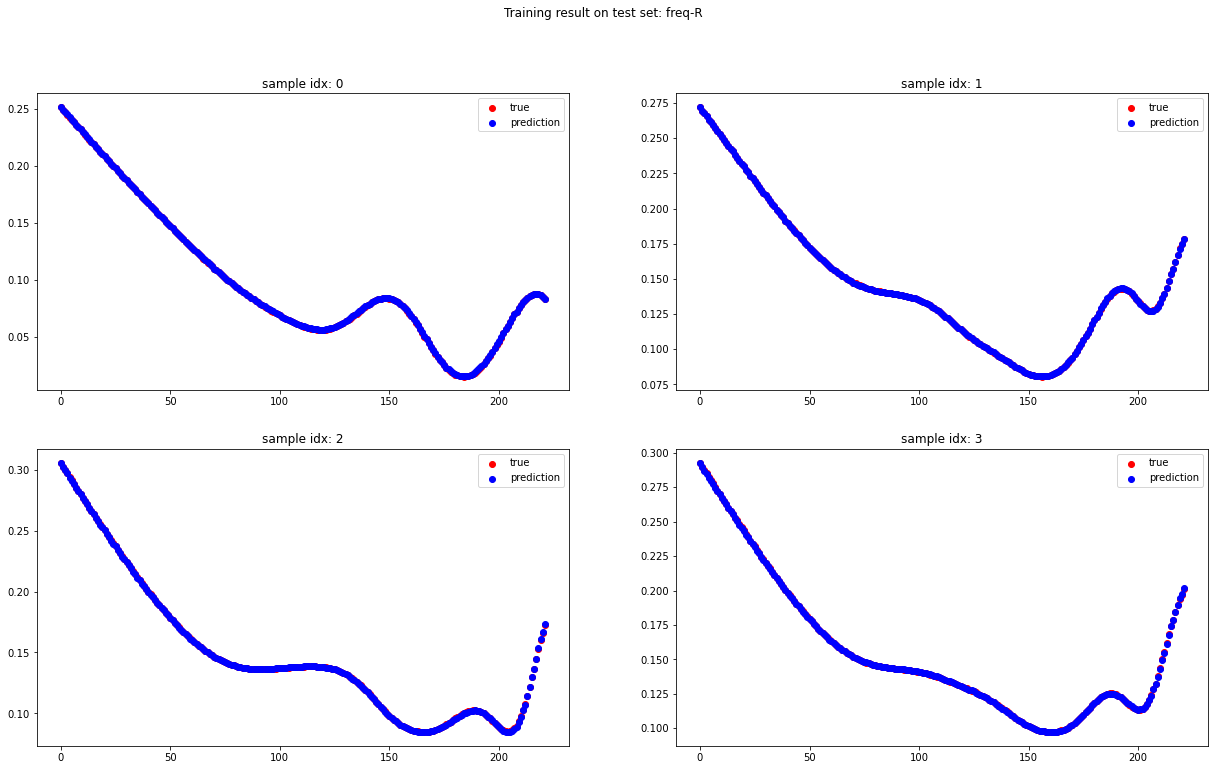

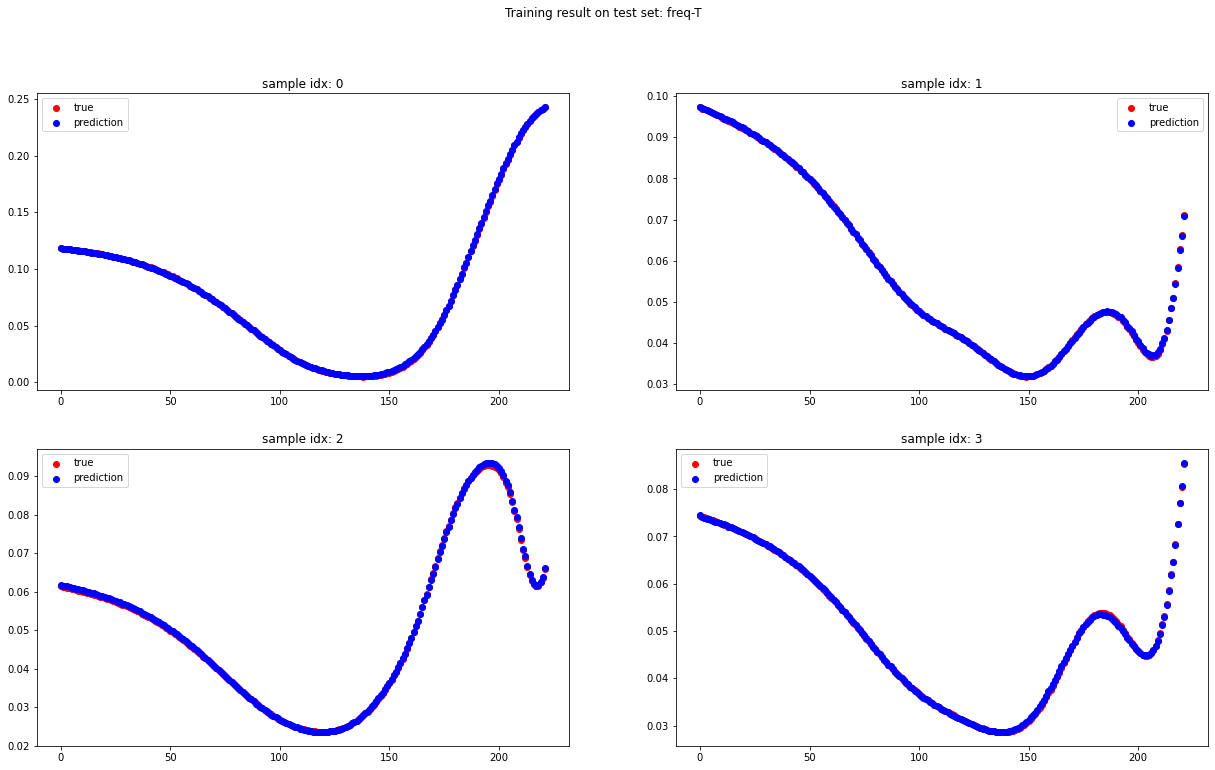

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  53. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 50.  54. 160.  75.]
 [ 52.  50. 160.  75.]
 [ 51.  52. 160.  75.]
 [ 50.  55. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


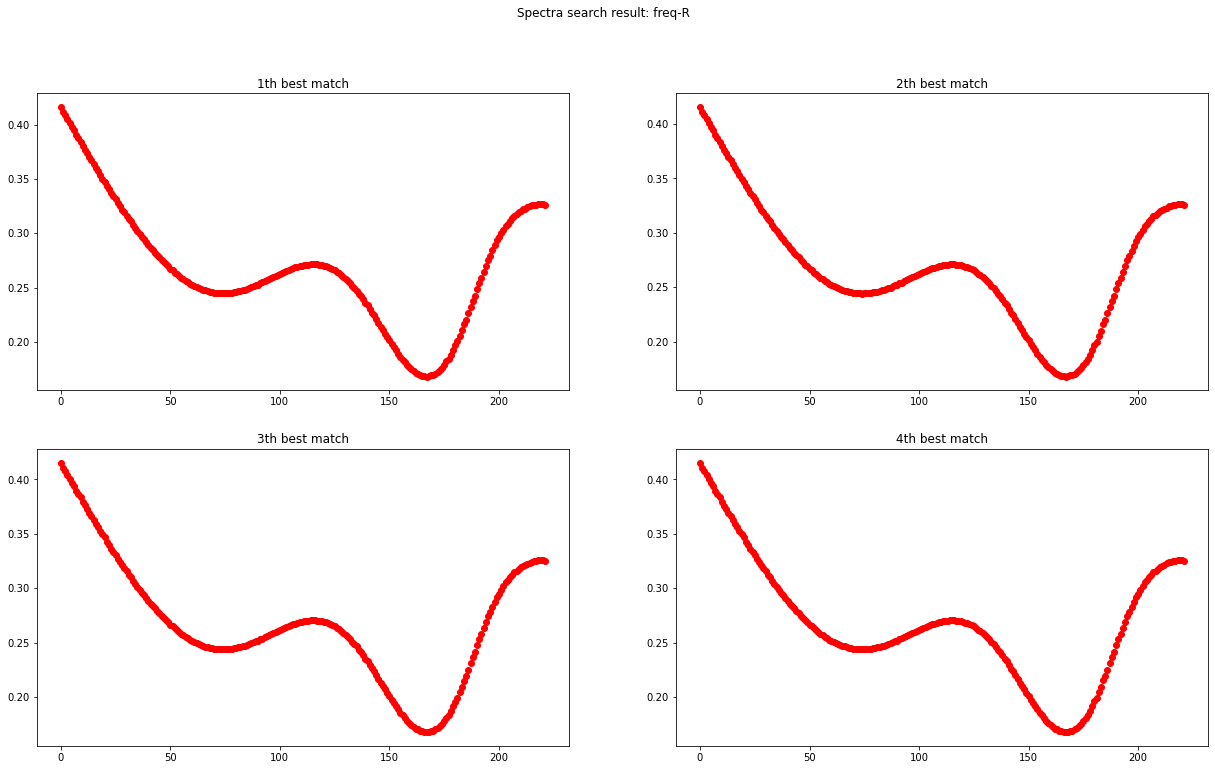

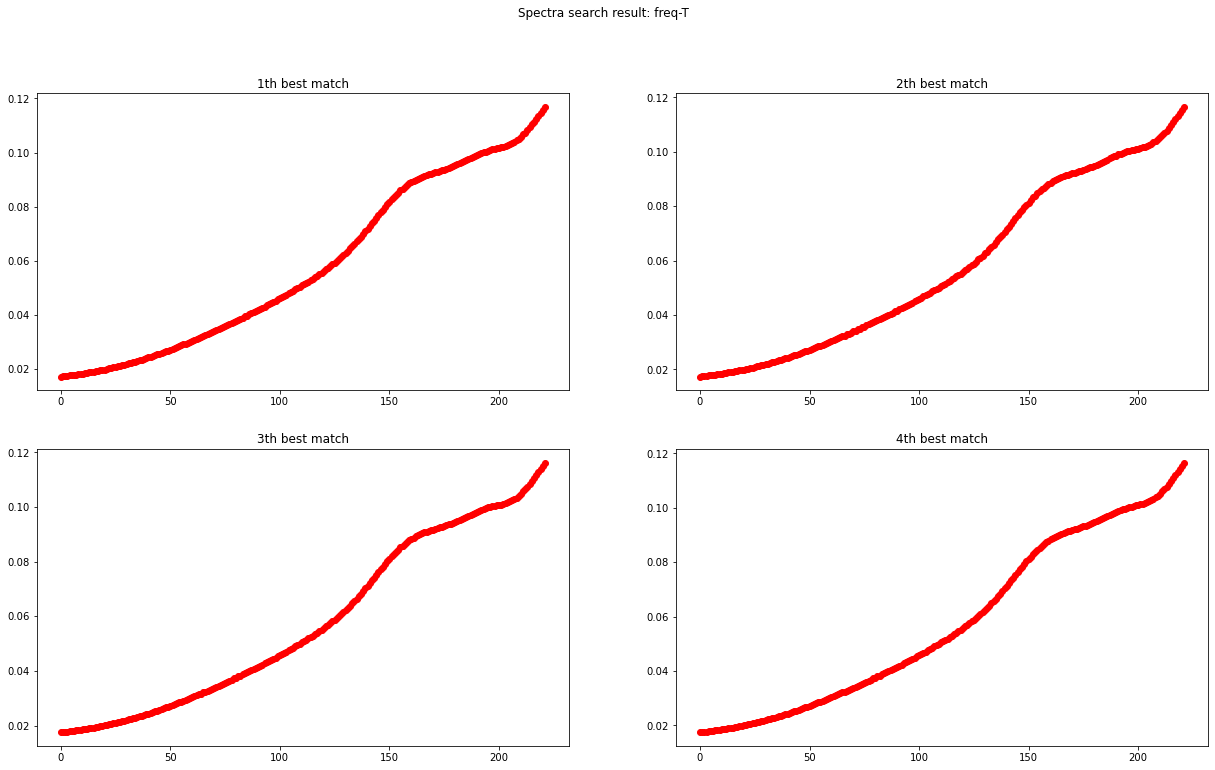

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.02213310446574205


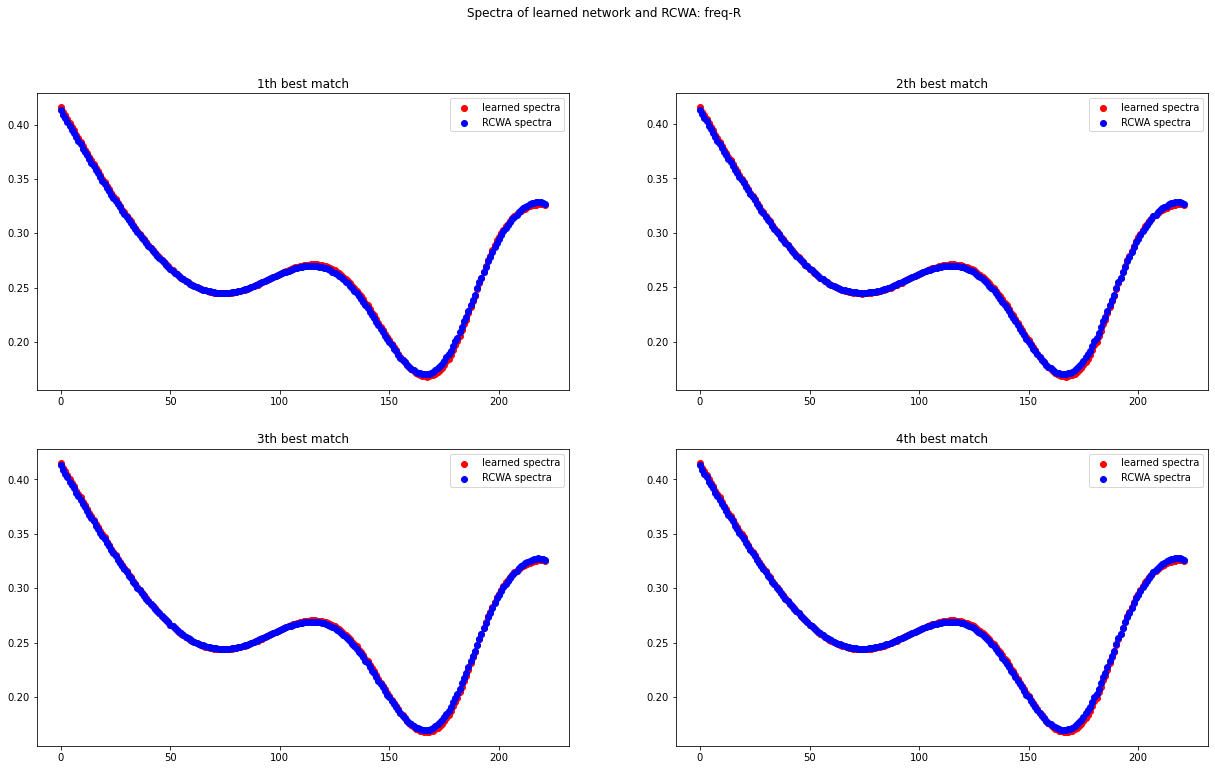

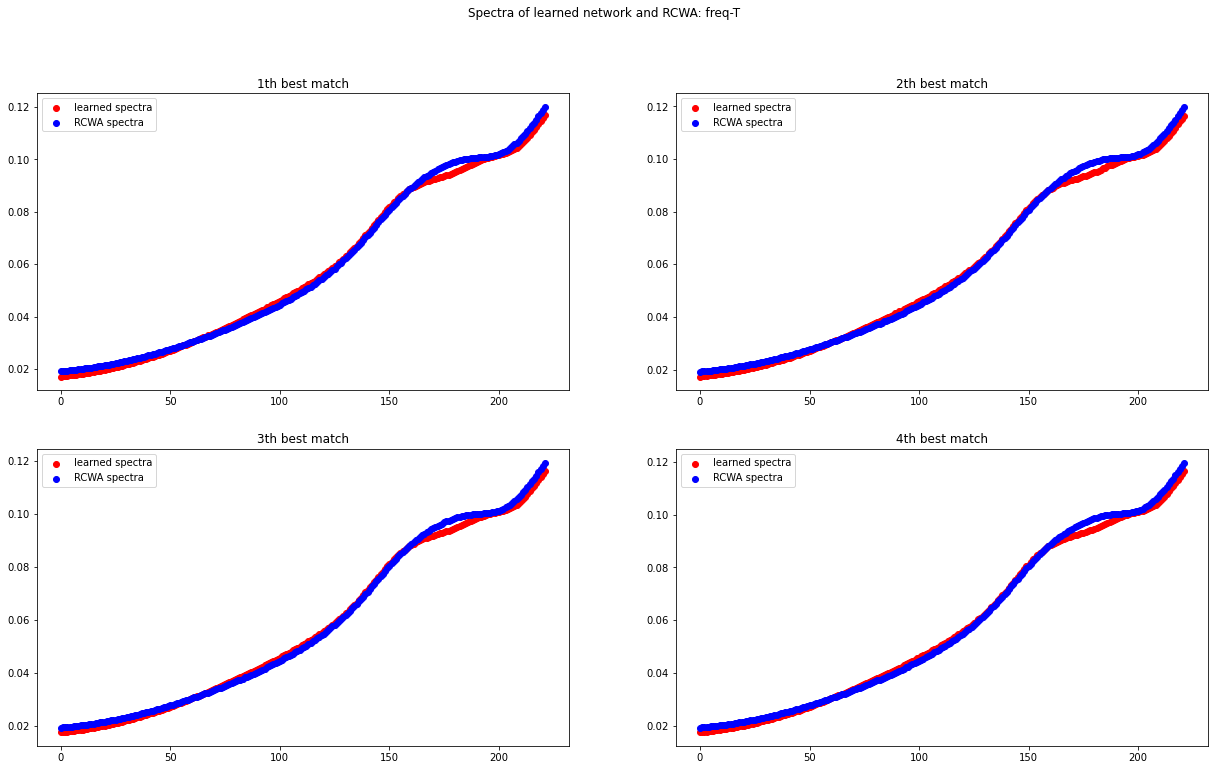

** Model saved.
**************************** ROUND 4 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 200
Sample points number available, continue calculating...
----------------
[ 1 / 50 ] [D1, D2] = [ 55. 112.]
Calculation Progress: 100%
----------------
[ 2 / 50 ] [D1, D2] = [ 75. 106.]
Calculation Progress: 100%
----------------
[ 3 / 50 ] [D1, D2] = [132. 132.]
Calculation Progress: 100%
----------------
[ 4 / 50 ] [D1, D2] = [65. 79.]
Calculation Progress: 100%
----------------
[ 5 / 50 ] [D1, D2] = [ 82. 106.]
Calculation Progress: 100%
----------------
[ 6 / 50 ] [D1, D2] = [ 93. 120.]
Calculation Progress: 100%
----------------
[ 7 / 50 ] [D1, D2] = [96. 58.]
Calculation Progress: 100%
----------------
[ 8 / 50 ] [D1, D2] = [135.  94.]
Calculation Progress: 100%
----------------
[ 9 / 50 ] [D1, D2] = [ 68. 129.]
Calculation Progress: 100%
----------------
[ 10 / 50 ] [D1, D2] = [103. 149.]
Calculation Progress: 10

----------------------------------------------------------------------
*** EPOCH 26 || AVG LOSS 1.2302992692241332e-05
### TEST LOSS  7.363485868457549e-06
----------------------------------------------------------------------
*** EPOCH 27 || AVG LOSS 7.101684611257042e-06
### TEST LOSS  5.179150169472753e-06
----------------------------------------------------------------------
*** EPOCH 28 || AVG LOSS 5.2347215400061484e-06
### TEST LOSS  7.789300070726313e-06
----------------------------------------------------------------------
*** EPOCH 29 || AVG LOSS 9.761350091821442e-06
### TEST LOSS  1.4106521424158322e-05
----------------------------------------------------------------------
*** EPOCH 30 || AVG LOSS 3.227222440102651e-05
### TEST LOSS  4.0914966424073405e-05
----------------------------------------------------------------------
*** EPOCH 31 || AVG LOSS 2.0953313601808077e-05
### TEST LOSS  1.786523534974549e-05
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 79 || AVG LOSS 2.627637813503725e-06
### TEST LOSS  2.2320580986464242e-06
----------------------------------------------------------------------
*** EPOCH 80 || AVG LOSS 2.981547526843542e-06
### TEST LOSS  5.563960106276984e-06
----------------------------------------------------------------------
*** EPOCH 81 || AVG LOSS 3.5411832317322476e-06
### TEST LOSS  2.045919624530749e-06
----------------------------------------------------------------------
*** EPOCH 82 || AVG LOSS 2.1082887285217566e-06
### TEST LOSS  3.373180561538902e-06
----------------------------------------------------------------------
*** EPOCH 83 || AVG LOSS 2.488465250536365e-06
### TEST LOSS  1.718237399472855e-06
----------------------------------------------------------------------
*** EPOCH 84 || AVG LOSS 1.7393960359868289e-06
### TEST LOSS  2.125064497704443e-06
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 132 || AVG LOSS 1.9314051978369663e-06
### TEST LOSS  9.531650372688697e-07
----------------------------------------------------------------------
*** EPOCH 133 || AVG LOSS 1.8219126980767441e-06
### TEST LOSS  4.259576674788453e-06
----------------------------------------------------------------------
*** EPOCH 134 || AVG LOSS 1.4295352881532608e-06
### TEST LOSS  1.7533988057039096e-06
----------------------------------------------------------------------
*** EPOCH 135 || AVG LOSS 1.8671083245180854e-06
### TEST LOSS  2.1760055991156455e-06
----------------------------------------------------------------------
*** EPOCH 136 || AVG LOSS 1.4302328372650663e-06
### TEST LOSS  1.7777974790078588e-06
----------------------------------------------------------------------
*** EPOCH 137 || AVG LOSS 1.1566111975014337e-06
### TEST LOSS  1.1825644984734633e-06
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 185 || AVG LOSS 8.992186974055016e-07
### TEST LOSS  1.021974204225747e-06
----------------------------------------------------------------------
*** EPOCH 186 || AVG LOSS 9.621166777407097e-07
### TEST LOSS  1.0543398805869704e-06
----------------------------------------------------------------------
*** EPOCH 187 || AVG LOSS 9.68272487753552e-07
### TEST LOSS  8.091314498415159e-07
----------------------------------------------------------------------
*** EPOCH 188 || AVG LOSS 1.0050166887509704e-06
### TEST LOSS  7.661292518908643e-07
----------------------------------------------------------------------
*** EPOCH 189 || AVG LOSS 1.57460761286643e-06
### TEST LOSS  1.3295610491089368e-05
----------------------------------------------------------------------
*** EPOCH 190 || AVG LOSS 3.1940478396563775e-06
### TEST LOSS  2.606025342781019e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 238 || AVG LOSS 1.6190080389577588e-06
### TEST LOSS  1.4884927850289387e-06
----------------------------------------------------------------------
*** EPOCH 239 || AVG LOSS 1.3464341706281857e-06
### TEST LOSS  1.6055588882106047e-06
----------------------------------------------------------------------
*** EPOCH 240 || AVG LOSS 9.359478931969534e-07
### TEST LOSS  2.251760482370931e-06
----------------------------------------------------------------------
*** EPOCH 241 || AVG LOSS 1.1640500310505786e-06
### TEST LOSS  1.3057149696275399e-06
----------------------------------------------------------------------
*** EPOCH 242 || AVG LOSS 6.801967386493856e-07
### TEST LOSS  9.568749987920455e-07
----------------------------------------------------------------------
*** EPOCH 243 || AVG LOSS 6.895435856080212e-07
### TEST LOSS  1.7577792353525485e-06
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 291 || AVG LOSS 7.614279819989633e-07
### TEST LOSS  8.912342271590509e-07
----------------------------------------------------------------------
*** EPOCH 292 || AVG LOSS 6.910785019442756e-07
### TEST LOSS  4.463059042336681e-07
----------------------------------------------------------------------
*** EPOCH 293 || AVG LOSS 5.916828414953557e-07
### TEST LOSS  9.269745646633964e-07
----------------------------------------------------------------------
*** EPOCH 294 || AVG LOSS 8.160521107214436e-07
### TEST LOSS  6.679291004729748e-07
----------------------------------------------------------------------
*** EPOCH 295 || AVG LOSS 7.054149750018723e-07
### TEST LOSS  8.241062043149819e-07
----------------------------------------------------------------------
*** EPOCH 296 || AVG LOSS 5.579536738764546e-07
### TEST LOSS  9.997309386259683e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 344 || AVG LOSS 5.685691870027653e-07
### TEST LOSS  6.068394403276519e-07
----------------------------------------------------------------------
*** EPOCH 345 || AVG LOSS 7.250815805548427e-07
### TEST LOSS  8.986656515238186e-07
----------------------------------------------------------------------
*** EPOCH 346 || AVG LOSS 6.989430770332206e-07
### TEST LOSS  9.736788607976148e-07
----------------------------------------------------------------------
*** EPOCH 347 || AVG LOSS 1.4011884659126395e-06
### TEST LOSS  7.844011520319327e-07
----------------------------------------------------------------------
*** EPOCH 348 || AVG LOSS 6.704785073452513e-07
### TEST LOSS  7.088120147121421e-07
----------------------------------------------------------------------
*** EPOCH 349 || AVG LOSS 8.354355182049744e-07
### TEST LOSS  5.413845940438478e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 397 || AVG LOSS 1.6802620190503603e-06
### TEST LOSS  1.1176014898713522e-06
----------------------------------------------------------------------
*** EPOCH 398 || AVG LOSS 1.6565763037590386e-06
### TEST LOSS  1.212256241463668e-06
----------------------------------------------------------------------
*** EPOCH 399 || AVG LOSS 8.255039758608973e-07
### TEST LOSS  7.376132960719891e-07
----------------------------------------------------------------------
*** EPOCH 400 || AVG LOSS 7.74673362542444e-07
### TEST LOSS  3.3226563118660124e-06
----------------------------------------------------------------------
*** EPOCH 401 || AVG LOSS 9.794371522175994e-07
### TEST LOSS  1.1985314358753385e-06
----------------------------------------------------------------------
*** EPOCH 402 || AVG LOSS 9.81846851004775e-07
### TEST LOSS  1.1616736325474146e-06
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 450 || AVG LOSS 4.5642703987880396e-07
### TEST LOSS  1.3929835063208884e-06
----------------------------------------------------------------------
*** EPOCH 451 || AVG LOSS 8.247215427914512e-07
### TEST LOSS  9.162644876899625e-07
----------------------------------------------------------------------
*** EPOCH 452 || AVG LOSS 8.815608629220151e-07
### TEST LOSS  6.191465710495928e-07
----------------------------------------------------------------------
*** EPOCH 453 || AVG LOSS 4.138680489518265e-07
### TEST LOSS  7.161791207484688e-07
----------------------------------------------------------------------
*** EPOCH 454 || AVG LOSS 4.938832620382527e-07
### TEST LOSS  7.928144706662957e-07
----------------------------------------------------------------------
*** EPOCH 455 || AVG LOSS 4.607898995345749e-07
### TEST LOSS  6.075656244775018e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 503 || AVG LOSS 5.182944196135963e-07
### TEST LOSS  3.475976294945819e-07
----------------------------------------------------------------------
*** EPOCH 504 || AVG LOSS 4.3750464023162295e-07
### TEST LOSS  2.7139927283315046e-07
----------------------------------------------------------------------
*** EPOCH 505 || AVG LOSS 3.9700757660909856e-07
### TEST LOSS  9.558449391988688e-07
----------------------------------------------------------------------
*** EPOCH 506 || AVG LOSS 6.301465021607556e-07
### TEST LOSS  5.35392928213696e-07
----------------------------------------------------------------------
*** EPOCH 507 || AVG LOSS 4.231806787657888e-07
### TEST LOSS  5.226737963918519e-07
----------------------------------------------------------------------
*** EPOCH 508 || AVG LOSS 3.389641659623521e-07
### TEST LOSS  3.021924423289117e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 556 || AVG LOSS 7.993610310563781e-07
### TEST LOSS  6.848652939576519e-07
----------------------------------------------------------------------
*** EPOCH 557 || AVG LOSS 5.498450216379069e-07
### TEST LOSS  5.007044781753697e-07
----------------------------------------------------------------------
*** EPOCH 558 || AVG LOSS 4.3195300055032247e-07
### TEST LOSS  5.616095108962327e-07
----------------------------------------------------------------------
*** EPOCH 559 || AVG LOSS 3.6243584879969146e-07
### TEST LOSS  3.341679359891714e-07
----------------------------------------------------------------------
*** EPOCH 560 || AVG LOSS 4.229851862902478e-07
### TEST LOSS  6.778983561162022e-07
----------------------------------------------------------------------
*** EPOCH 561 || AVG LOSS 7.094470944934983e-07
### TEST LOSS  5.73758777970094e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 609 || AVG LOSS 2.655074544577474e-07
### TEST LOSS  3.3939257567302167e-07
----------------------------------------------------------------------
*** EPOCH 610 || AVG LOSS 3.1400359169708735e-07
### TEST LOSS  2.349614239468186e-07
----------------------------------------------------------------------
*** EPOCH 611 || AVG LOSS 3.05161528899589e-07
### TEST LOSS  3.0273439695823373e-07
----------------------------------------------------------------------
*** EPOCH 612 || AVG LOSS 4.1657389669325086e-07
### TEST LOSS  3.4230634090211726e-07
----------------------------------------------------------------------
*** EPOCH 613 || AVG LOSS 3.0918404370083863e-07
### TEST LOSS  4.463730742069553e-07
----------------------------------------------------------------------
*** EPOCH 614 || AVG LOSS 2.584144934481003e-07
### TEST LOSS  2.5939703126217256e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 662 || AVG LOSS 2.4189697906962236e-07
### TEST LOSS  1.8872336700799983e-07
----------------------------------------------------------------------
*** EPOCH 663 || AVG LOSS 2.1332663163065036e-07
### TEST LOSS  3.0040837373235263e-07
----------------------------------------------------------------------
*** EPOCH 664 || AVG LOSS 2.186066672571485e-07
### TEST LOSS  2.387242403756318e-07
----------------------------------------------------------------------
*** EPOCH 665 || AVG LOSS 2.387675315240756e-07
### TEST LOSS  2.476199606841571e-07
----------------------------------------------------------------------
*** EPOCH 666 || AVG LOSS 2.8383258467101767e-07
### TEST LOSS  7.265778473689958e-07
----------------------------------------------------------------------
*** EPOCH 667 || AVG LOSS 2.5676353399894935e-07
### TEST LOSS  2.013996341550713e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 715 || AVG LOSS 1.977705191968937e-07
### TEST LOSS  2.179216664899286e-07
----------------------------------------------------------------------
*** EPOCH 716 || AVG LOSS 2.2895918073473353e-07
### TEST LOSS  2.1271390930147996e-07
----------------------------------------------------------------------
*** EPOCH 717 || AVG LOSS 2.2841481500890381e-07
### TEST LOSS  2.7895108208516223e-07
----------------------------------------------------------------------
*** EPOCH 718 || AVG LOSS 2.1202717668700187e-07
### TEST LOSS  1.7116376701172462e-07
----------------------------------------------------------------------
*** EPOCH 719 || AVG LOSS 2.4975939146187896e-07
### TEST LOSS  2.391726449483637e-07
----------------------------------------------------------------------
*** EPOCH 720 || AVG LOSS 2.2997055447504523e-07
### TEST LOSS  2.5147321025542624e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 768 || AVG LOSS 4.74501149057005e-07
### TEST LOSS  3.0654193020988413e-07
----------------------------------------------------------------------
*** EPOCH 769 || AVG LOSS 2.5098458319661174e-07
### TEST LOSS  1.9423481016171232e-07
----------------------------------------------------------------------
*** EPOCH 770 || AVG LOSS 2.7451187493809927e-07
### TEST LOSS  3.652230589068495e-07
----------------------------------------------------------------------
*** EPOCH 771 || AVG LOSS 2.952320380344986e-07
### TEST LOSS  2.472828934211672e-07
----------------------------------------------------------------------
*** EPOCH 772 || AVG LOSS 2.56564562093331e-07
### TEST LOSS  2.0701373178629487e-07
----------------------------------------------------------------------
*** EPOCH 773 || AVG LOSS 2.1464085499189876e-07
### TEST LOSS  2.7117015122257726e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 821 || AVG LOSS 1.917005874076949e-06
### TEST LOSS  2.7899889118998544e-06
----------------------------------------------------------------------
*** EPOCH 822 || AVG LOSS 1.6277029435585177e-06
### TEST LOSS  6.758753177867524e-07
----------------------------------------------------------------------
*** EPOCH 823 || AVG LOSS 4.476930426022818e-07
### TEST LOSS  3.166481595447597e-07
----------------------------------------------------------------------
*** EPOCH 824 || AVG LOSS 4.885016089417604e-07
### TEST LOSS  6.396408404422497e-07
----------------------------------------------------------------------
*** EPOCH 825 || AVG LOSS 1.5663146348288138e-06
### TEST LOSS  8.314788904802602e-07
----------------------------------------------------------------------
*** EPOCH 826 || AVG LOSS 6.628560255705907e-07
### TEST LOSS  3.221072025401857e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 874 || AVG LOSS 1.6878956518695532e-06
### TEST LOSS  1.9084580268706e-06
----------------------------------------------------------------------
*** EPOCH 875 || AVG LOSS 1.5668919182587615e-06
### TEST LOSS  1.1170835705343052e-06
----------------------------------------------------------------------
*** EPOCH 876 || AVG LOSS 2.2722014496423526e-06
### TEST LOSS  1.2822798301688938e-06
----------------------------------------------------------------------
*** EPOCH 877 || AVG LOSS 1.8596914182467116e-06
### TEST LOSS  1.994161417921229e-06
----------------------------------------------------------------------
*** EPOCH 878 || AVG LOSS 1.209557872172695e-06
### TEST LOSS  1.236633238477225e-06
----------------------------------------------------------------------
*** EPOCH 879 || AVG LOSS 1.20469935922074e-06
### TEST LOSS  2.703240473541276e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 927 || AVG LOSS 5.946999131722919e-07
### TEST LOSS  5.578353921009693e-07
----------------------------------------------------------------------
*** EPOCH 928 || AVG LOSS 8.253650002387758e-07
### TEST LOSS  5.968946273545347e-07
----------------------------------------------------------------------
*** EPOCH 929 || AVG LOSS 5.144667727563501e-07
### TEST LOSS  4.192844661095781e-07
----------------------------------------------------------------------
*** EPOCH 930 || AVG LOSS 4.059780270893043e-07
### TEST LOSS  5.536818245370038e-07
----------------------------------------------------------------------
*** EPOCH 931 || AVG LOSS 5.01871476501492e-07
### TEST LOSS  4.827480874306881e-07
----------------------------------------------------------------------
*** EPOCH 932 || AVG LOSS 4.693862405424909e-07
### TEST LOSS  3.808377944854631e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 980 || AVG LOSS 3.266751771136001e-07
### TEST LOSS  4.4694295790274435e-07
----------------------------------------------------------------------
*** EPOCH 981 || AVG LOSS 3.4978527146733996e-07
### TEST LOSS  3.3551659347115975e-07
----------------------------------------------------------------------
*** EPOCH 982 || AVG LOSS 3.4582499608859507e-07
### TEST LOSS  3.6050936576733267e-07
----------------------------------------------------------------------
*** EPOCH 983 || AVG LOSS 3.481421433271237e-07
### TEST LOSS  3.0034955026773485e-07
----------------------------------------------------------------------
*** EPOCH 984 || AVG LOSS 2.8856510233765673e-07
### TEST LOSS  2.506535755249691e-07
----------------------------------------------------------------------
*** EPOCH 985 || AVG LOSS 2.757624655558288e-07
### TEST LOSS  3.0451280016071297e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1033 || AVG LOSS 3.285305598588195e-07
### TEST LOSS  2.626258464033526e-07
----------------------------------------------------------------------
*** EPOCH 1034 || AVG LOSS 2.7273882272638163e-07
### TEST LOSS  2.450302218903744e-07
----------------------------------------------------------------------
*** EPOCH 1035 || AVG LOSS 2.583816264412064e-07
### TEST LOSS  2.6718943028451275e-07
----------------------------------------------------------------------
*** EPOCH 1036 || AVG LOSS 2.672878104448273e-07
### TEST LOSS  2.1873516213114877e-07
----------------------------------------------------------------------
*** EPOCH 1037 || AVG LOSS 3.544905224828199e-07
### TEST LOSS  3.9316302036240813e-07
----------------------------------------------------------------------
*** EPOCH 1038 || AVG LOSS 3.464444797529609e-07
### TEST LOSS  2.4723802027892816e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1085 || AVG LOSS 2.8635780450869676e-07
### TEST LOSS  2.546984489981696e-07
----------------------------------------------------------------------
*** EPOCH 1086 || AVG LOSS 2.2311971552113617e-07
### TEST LOSS  2.500168013360356e-07
----------------------------------------------------------------------
*** EPOCH 1087 || AVG LOSS 2.545068396742067e-07
### TEST LOSS  3.2046074238678557e-07
----------------------------------------------------------------------
*** EPOCH 1088 || AVG LOSS 2.7307712636925884e-07
### TEST LOSS  3.139608584964056e-07
----------------------------------------------------------------------
*** EPOCH 1089 || AVG LOSS 2.943265494437242e-07
### TEST LOSS  2.4634338065728417e-07
----------------------------------------------------------------------
*** EPOCH 1090 || AVG LOSS 2.177567005112735e-07
### TEST LOSS  2.238772604338616e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1137 || AVG LOSS 2.562157965435574e-07
### TEST LOSS  2.3161438396831122e-07
----------------------------------------------------------------------
*** EPOCH 1138 || AVG LOSS 2.9913722888963433e-07
### TEST LOSS  3.204505295191969e-07
----------------------------------------------------------------------
*** EPOCH 1139 || AVG LOSS 2.871312091556888e-07
### TEST LOSS  4.517022678858969e-07
----------------------------------------------------------------------
*** EPOCH 1140 || AVG LOSS 2.672444886009373e-07
### TEST LOSS  1.8638848568267954e-07
----------------------------------------------------------------------
*** EPOCH 1141 || AVG LOSS 2.124966200689471e-07
### TEST LOSS  1.9492591244822202e-07
----------------------------------------------------------------------
*** EPOCH 1142 || AVG LOSS 2.1956050323623798e-07
### TEST LOSS  3.2423381905270315e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1189 || AVG LOSS 2.8913910069761075e-07
### TEST LOSS  2.0961334712410462e-07
----------------------------------------------------------------------
*** EPOCH 1190 || AVG LOSS 2.1608500448522249e-07
### TEST LOSS  2.3229569023897056e-07
----------------------------------------------------------------------
*** EPOCH 1191 || AVG LOSS 2.1055939923186883e-07
### TEST LOSS  2.1129707761247118e-07
----------------------------------------------------------------------
*** EPOCH 1192 || AVG LOSS 2.3702023862703925e-07
### TEST LOSS  2.574505136484125e-07
----------------------------------------------------------------------
*** EPOCH 1193 || AVG LOSS 2.1018890732804608e-07
### TEST LOSS  1.6999618424051732e-07
----------------------------------------------------------------------
*** EPOCH 1194 || AVG LOSS 2.1734359597402887e-07
### TEST LOSS  2.509339320037422e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1241 || AVG LOSS 2.0578469133170075e-07
### TEST LOSS  2.01129002637875e-07
----------------------------------------------------------------------
*** EPOCH 1242 || AVG LOSS 2.0852145746097506e-07
### TEST LOSS  2.0308745263264427e-07
----------------------------------------------------------------------
*** EPOCH 1243 || AVG LOSS 1.9436900501546005e-07
### TEST LOSS  2.5503195881052915e-07
----------------------------------------------------------------------
*** EPOCH 1244 || AVG LOSS 2.0587809480332452e-07
### TEST LOSS  2.1324151570449126e-07
----------------------------------------------------------------------
*** EPOCH 1245 || AVG LOSS 2.2284066062638885e-07
### TEST LOSS  1.8905491098545704e-07
----------------------------------------------------------------------
*** EPOCH 1246 || AVG LOSS 2.4938359356241334e-07
### TEST LOSS  2.229738621887615e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1293 || AVG LOSS 2.427027067497534e-07
### TEST LOSS  1.8159140798464554e-07
----------------------------------------------------------------------
*** EPOCH 1294 || AVG LOSS 2.0693220702305838e-07
### TEST LOSS  1.839045182805421e-07
----------------------------------------------------------------------
*** EPOCH 1295 || AVG LOSS 1.7314737208451447e-07
### TEST LOSS  2.794316410851631e-07
----------------------------------------------------------------------
*** EPOCH 1296 || AVG LOSS 2.3583696496132233e-07
### TEST LOSS  2.9106930317842245e-07
----------------------------------------------------------------------
*** EPOCH 1297 || AVG LOSS 2.447488644463647e-07
### TEST LOSS  1.8522027289691323e-07
----------------------------------------------------------------------
*** EPOCH 1298 || AVG LOSS 1.8102097634198345e-07
### TEST LOSS  1.7698509680030838e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1345 || AVG LOSS 2.439709092882936e-07
### TEST LOSS  4.0863047464275343e-07
----------------------------------------------------------------------
*** EPOCH 1346 || AVG LOSS 2.0427387385169026e-07
### TEST LOSS  1.6274735041103364e-07
----------------------------------------------------------------------
*** EPOCH 1347 || AVG LOSS 1.7567785989491825e-07
### TEST LOSS  1.617317811527149e-07
----------------------------------------------------------------------
*** EPOCH 1348 || AVG LOSS 2.1735484470930544e-07
### TEST LOSS  2.0118467602969758e-07
----------------------------------------------------------------------
*** EPOCH 1349 || AVG LOSS 2.0082602324222877e-07
### TEST LOSS  1.7387834816418035e-07
----------------------------------------------------------------------
*** EPOCH 1350 || AVG LOSS 1.9077920084598077e-07
### TEST LOSS  2.134565875167027e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1397 || AVG LOSS 1.8196000081793784e-07
### TEST LOSS  1.8727189872909852e-07
----------------------------------------------------------------------
*** EPOCH 1398 || AVG LOSS 1.697976572323512e-07
### TEST LOSS  1.6770761135376233e-07
----------------------------------------------------------------------
*** EPOCH 1399 || AVG LOSS 1.5868526455520283e-07
### TEST LOSS  1.734787341926373e-07
----------------------------------------------------------------------
*** EPOCH 1400 || AVG LOSS 1.8890889124989485e-07
### TEST LOSS  1.4014778552488374e-07
----------------------------------------------------------------------
*** EPOCH 1401 || AVG LOSS 2.0349157542121077e-07
### TEST LOSS  1.5746131983481368e-07
----------------------------------------------------------------------
*** EPOCH 1402 || AVG LOSS 1.9382597287176396e-07
### TEST LOSS  2.1306790642938722e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1449 || AVG LOSS 1.8595895664219598e-07
### TEST LOSS  1.7569324484156823e-07
----------------------------------------------------------------------
*** EPOCH 1450 || AVG LOSS 2.0426730337419486e-07
### TEST LOSS  1.6770032592224501e-07
----------------------------------------------------------------------
*** EPOCH 1451 || AVG LOSS 1.7552703365453226e-07
### TEST LOSS  1.4422742111719344e-07
----------------------------------------------------------------------
*** EPOCH 1452 || AVG LOSS 1.5972308414546888e-07
### TEST LOSS  2.5487752945233905e-07
----------------------------------------------------------------------
*** EPOCH 1453 || AVG LOSS 1.677814505107733e-07
### TEST LOSS  1.8822586393222687e-07
----------------------------------------------------------------------
*** EPOCH 1454 || AVG LOSS 1.7518965920615414e-07
### TEST LOSS  2.1506005509763781e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1501 || AVG LOSS 1.8477089637869427e-07
### TEST LOSS  1.4778585466501681e-07
----------------------------------------------------------------------
*** EPOCH 1502 || AVG LOSS 1.8459926639735614e-07
### TEST LOSS  1.5344025428021268e-07
----------------------------------------------------------------------
*** EPOCH 1503 || AVG LOSS 1.8051516995853944e-07
### TEST LOSS  1.7271662026511572e-07
----------------------------------------------------------------------
*** EPOCH 1504 || AVG LOSS 1.5637489208408795e-07
### TEST LOSS  1.8158605522936946e-07
----------------------------------------------------------------------
*** EPOCH 1505 || AVG LOSS 1.9222703397048234e-07
### TEST LOSS  1.1644745493792168e-07
----------------------------------------------------------------------
*** EPOCH 1506 || AVG LOSS 1.6680509801858533e-07
### TEST LOSS  1.4691229447786705e-07
----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1553 || AVG LOSS 1.7963834541667723e-07
### TEST LOSS  1.58356973164094e-07
----------------------------------------------------------------------
*** EPOCH 1554 || AVG LOSS 1.497059191368777e-07
### TEST LOSS  1.3974903841547834e-07
----------------------------------------------------------------------
*** EPOCH 1555 || AVG LOSS 1.489874523041834e-07
### TEST LOSS  1.3143944244120576e-07
----------------------------------------------------------------------
*** EPOCH 1556 || AVG LOSS 1.5446628294668586e-07
### TEST LOSS  1.2580772808708693e-07
----------------------------------------------------------------------
*** EPOCH 1557 || AVG LOSS 1.6661043779286898e-07
### TEST LOSS  1.9839005934348583e-07
----------------------------------------------------------------------
*** EPOCH 1558 || AVG LOSS 1.5384930267536846e-07
### TEST LOSS  1.9252235953596633e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1605 || AVG LOSS 1.8494180008765682e-07
### TEST LOSS  1.249231355397266e-07
----------------------------------------------------------------------
*** EPOCH 1606 || AVG LOSS 1.5822555327726916e-07
### TEST LOSS  2.287040246073957e-07
----------------------------------------------------------------------
*** EPOCH 1607 || AVG LOSS 1.8220769148591387e-07
### TEST LOSS  1.654621636741164e-07
----------------------------------------------------------------------
*** EPOCH 1608 || AVG LOSS 1.8223384091520244e-07
### TEST LOSS  3.5354653959984716e-07
----------------------------------------------------------------------
*** EPOCH 1609 || AVG LOSS 1.97150426899384e-07
### TEST LOSS  1.7222160408891796e-07
----------------------------------------------------------------------
*** EPOCH 1610 || AVG LOSS 1.646617564254882e-07
### TEST LOSS  1.774919743032418e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1657 || AVG LOSS 2.007944123150196e-07
### TEST LOSS  3.883919911610671e-07
----------------------------------------------------------------------
*** EPOCH 1658 || AVG LOSS 1.8135752444692343e-07
### TEST LOSS  1.5205766127716439e-07
----------------------------------------------------------------------
*** EPOCH 1659 || AVG LOSS 1.5679898801579384e-07
### TEST LOSS  1.3389549972468254e-07
----------------------------------------------------------------------
*** EPOCH 1660 || AVG LOSS 1.4750409738084613e-07
### TEST LOSS  1.8296533236631754e-07
----------------------------------------------------------------------
*** EPOCH 1661 || AVG LOSS 1.6615124041940989e-07
### TEST LOSS  1.1548096049788607e-07
----------------------------------------------------------------------
*** EPOCH 1662 || AVG LOSS 1.7607684346998553e-07
### TEST LOSS  1.283275850028076e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1709 || AVG LOSS 1.6084615038991502e-07
### TEST LOSS  1.4909966713124353e-07
----------------------------------------------------------------------
*** EPOCH 1710 || AVG LOSS 1.555604737468741e-07
### TEST LOSS  1.366118927611145e-07
----------------------------------------------------------------------
*** EPOCH 1711 || AVG LOSS 2.2027429049664705e-07
### TEST LOSS  1.8194202766608214e-07
----------------------------------------------------------------------
*** EPOCH 1712 || AVG LOSS 2.0516351339594508e-07
### TEST LOSS  1.3857215227138417e-07
----------------------------------------------------------------------
*** EPOCH 1713 || AVG LOSS 1.7294752879593034e-07
### TEST LOSS  1.08211679616943e-07
----------------------------------------------------------------------
*** EPOCH 1714 || AVG LOSS 2.395602178673073e-07
### TEST LOSS  1.4406246388413516e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1761 || AVG LOSS 2.0836261477086282e-07
### TEST LOSS  1.254698152782415e-07
----------------------------------------------------------------------
*** EPOCH 1762 || AVG LOSS 1.7615076330912416e-07
### TEST LOSS  1.727619718394635e-07
----------------------------------------------------------------------
*** EPOCH 1763 || AVG LOSS 1.540135716648905e-07
### TEST LOSS  1.6430843174930487e-07
----------------------------------------------------------------------
*** EPOCH 1764 || AVG LOSS 1.583129937365868e-07
### TEST LOSS  1.6675904153847418e-07
----------------------------------------------------------------------
*** EPOCH 1765 || AVG LOSS 1.4820641339063911e-07
### TEST LOSS  1.214805938805815e-07
----------------------------------------------------------------------
*** EPOCH 1766 || AVG LOSS 1.6302432369386112e-07
### TEST LOSS  2.2467514308270134e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1813 || AVG LOSS 1.835894207324884e-07
### TEST LOSS  1.5561693089694018e-07
----------------------------------------------------------------------
*** EPOCH 1814 || AVG LOSS 2.118005068130202e-07
### TEST LOSS  1.2627255803939383e-07
----------------------------------------------------------------------
*** EPOCH 1815 || AVG LOSS 1.4764412519241433e-07
### TEST LOSS  1.8198605763094142e-07
----------------------------------------------------------------------
*** EPOCH 1816 || AVG LOSS 1.7491091334420616e-07
### TEST LOSS  1.3501027259129236e-07
----------------------------------------------------------------------
*** EPOCH 1817 || AVG LOSS 1.8910390068072047e-07
### TEST LOSS  2.577171566523854e-07
----------------------------------------------------------------------
*** EPOCH 1818 || AVG LOSS 1.5753019949826807e-07
### TEST LOSS  1.38217401968177e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1865 || AVG LOSS 1.863774852939315e-07
### TEST LOSS  2.0063972764698215e-07
----------------------------------------------------------------------
*** EPOCH 1866 || AVG LOSS 1.4551092840875413e-07
### TEST LOSS  1.1026931190372125e-07
----------------------------------------------------------------------
*** EPOCH 1867 || AVG LOSS 1.5279459525174844e-07
### TEST LOSS  1.0952193463253934e-07
----------------------------------------------------------------------
*** EPOCH 1868 || AVG LOSS 1.5447500145704396e-07
### TEST LOSS  1.3442450115993174e-07
----------------------------------------------------------------------
*** EPOCH 1869 || AVG LOSS 2.633120278350276e-07
### TEST LOSS  1.653712520995517e-07
----------------------------------------------------------------------
*** EPOCH 1870 || AVG LOSS 1.9234883190222262e-07
### TEST LOSS  1.561145523965024e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1917 || AVG LOSS 1.6025169013111907e-07
### TEST LOSS  1.480359088645855e-07
----------------------------------------------------------------------
*** EPOCH 1918 || AVG LOSS 1.5482461813931535e-07
### TEST LOSS  1.2491465876488897e-07
----------------------------------------------------------------------
*** EPOCH 1919 || AVG LOSS 1.406670262937837e-07
### TEST LOSS  1.3002359603812388e-07
----------------------------------------------------------------------
*** EPOCH 1920 || AVG LOSS 1.3709228437797095e-07
### TEST LOSS  1.2369411213815815e-07
----------------------------------------------------------------------
*** EPOCH 1921 || AVG LOSS 1.3818973283008517e-07
### TEST LOSS  1.2553437992816421e-07
----------------------------------------------------------------------
*** EPOCH 1922 || AVG LOSS 1.7045080499045185e-07
### TEST LOSS  1.438146976321756e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1969 || AVG LOSS 1.73060820278792e-07
### TEST LOSS  1.2255006017388345e-07
----------------------------------------------------------------------
*** EPOCH 1970 || AVG LOSS 1.2711037978618832e-07
### TEST LOSS  2.021294989162925e-07
----------------------------------------------------------------------
*** EPOCH 1971 || AVG LOSS 1.4085046645018196e-07
### TEST LOSS  1.1432363796378316e-07
----------------------------------------------------------------------
*** EPOCH 1972 || AVG LOSS 1.3221075116476298e-07
### TEST LOSS  1.2584352996706608e-07
----------------------------------------------------------------------
*** EPOCH 1973 || AVG LOSS 1.413755420109908e-07
### TEST LOSS  1.2336592902784105e-07
----------------------------------------------------------------------
*** EPOCH 1974 || AVG LOSS 1.6516668053689897e-07
### TEST LOSS  1.3566118658066748e-07
--------------------------------------------------

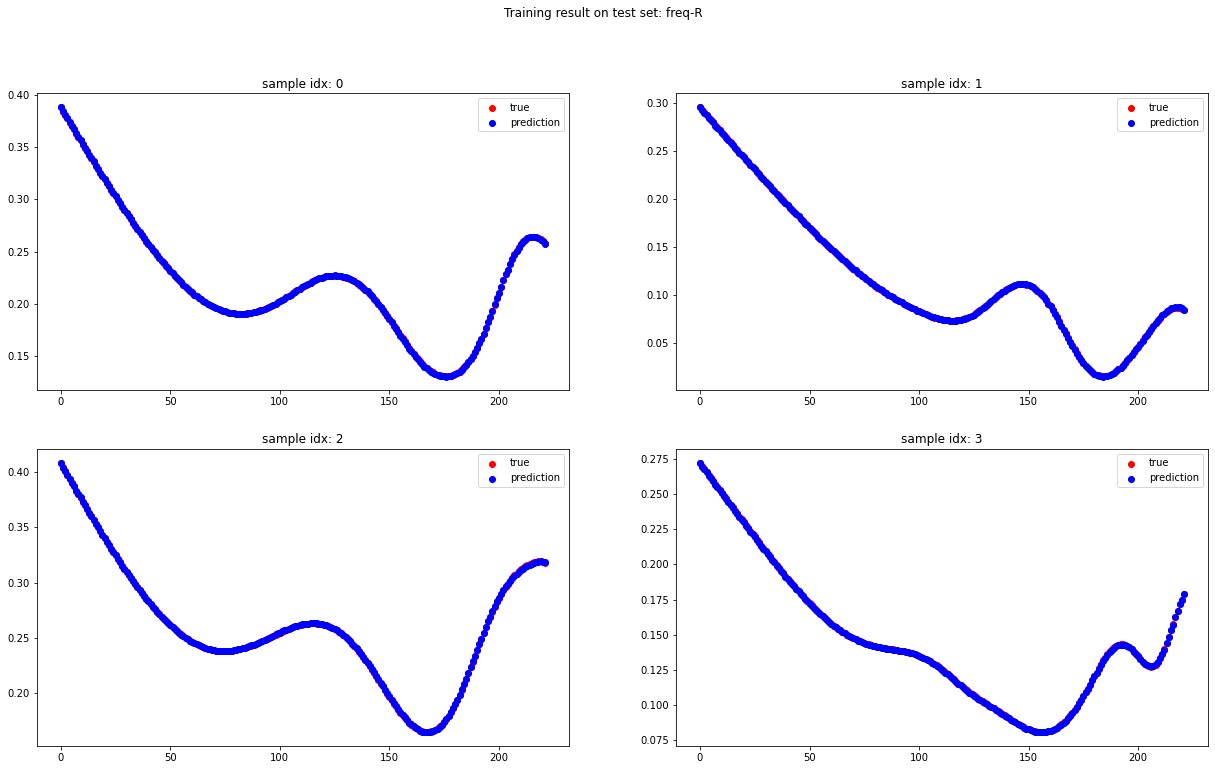

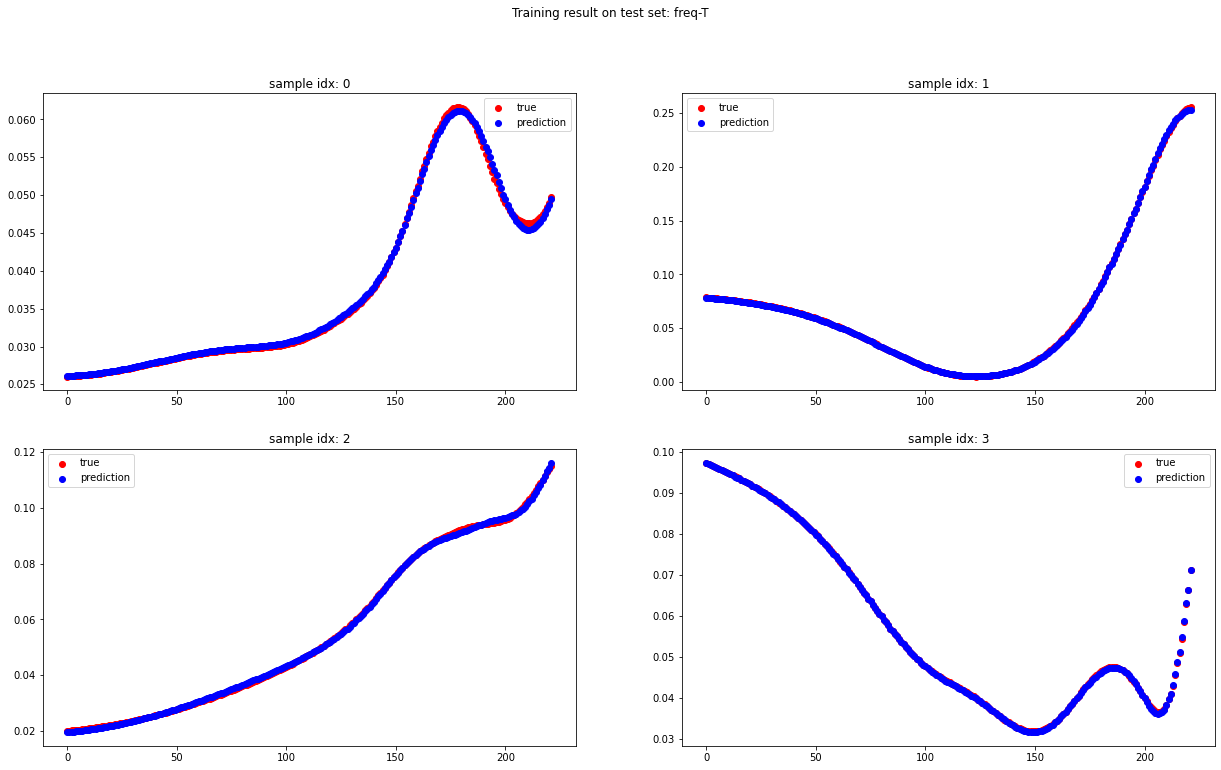

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 50.  53. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  54. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 50.  55. 160.  75.]
 [ 51.  52. 160.  75.]
 [ 50.  56. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


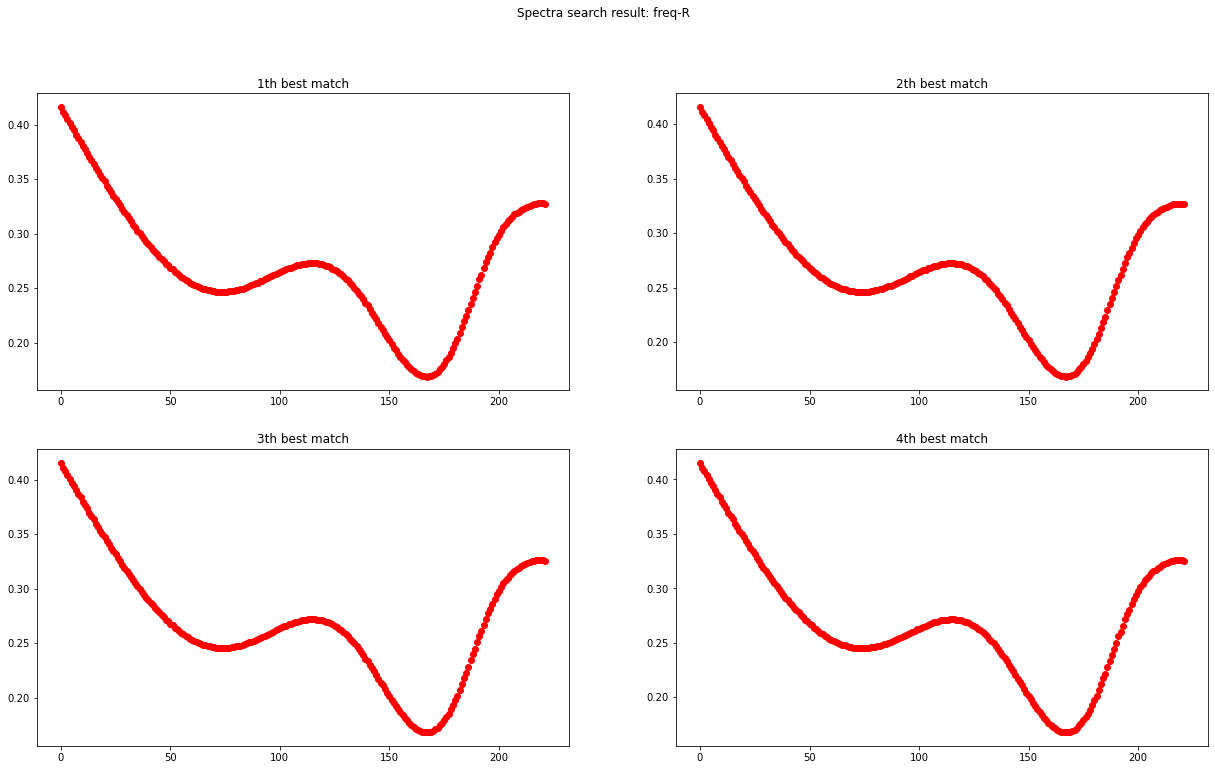

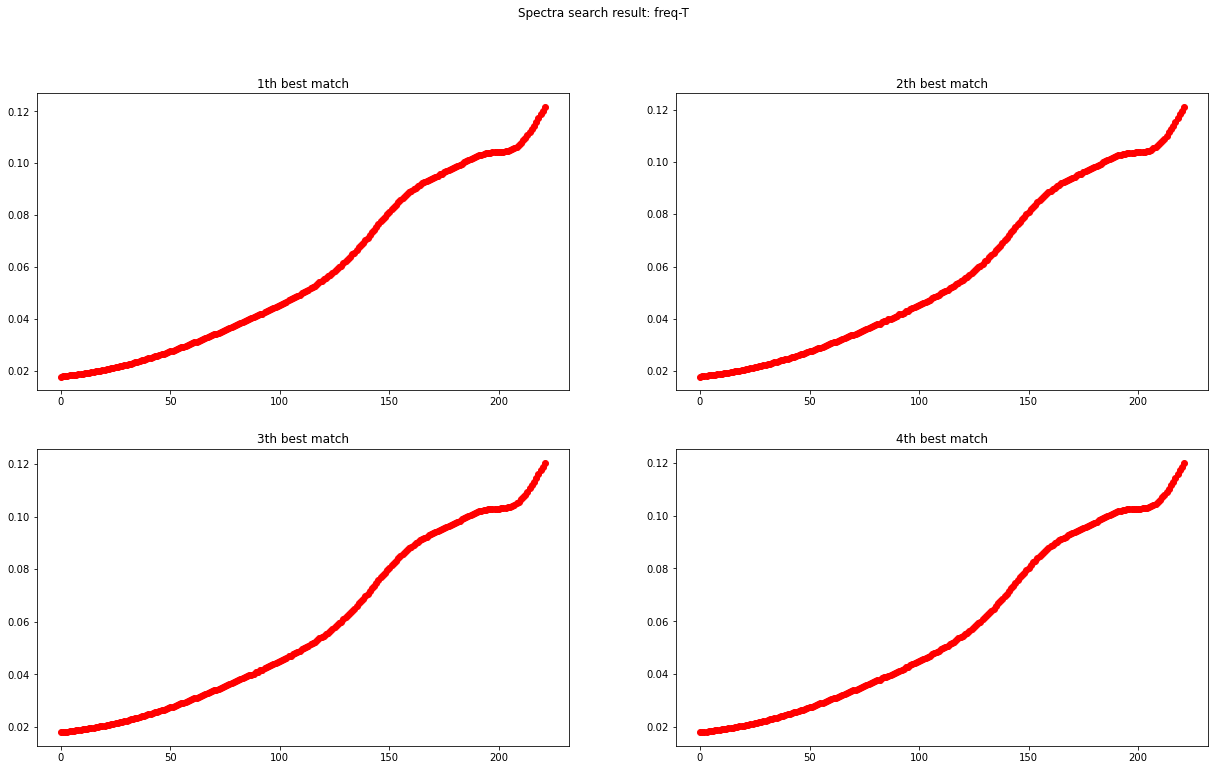

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.019718601408676262


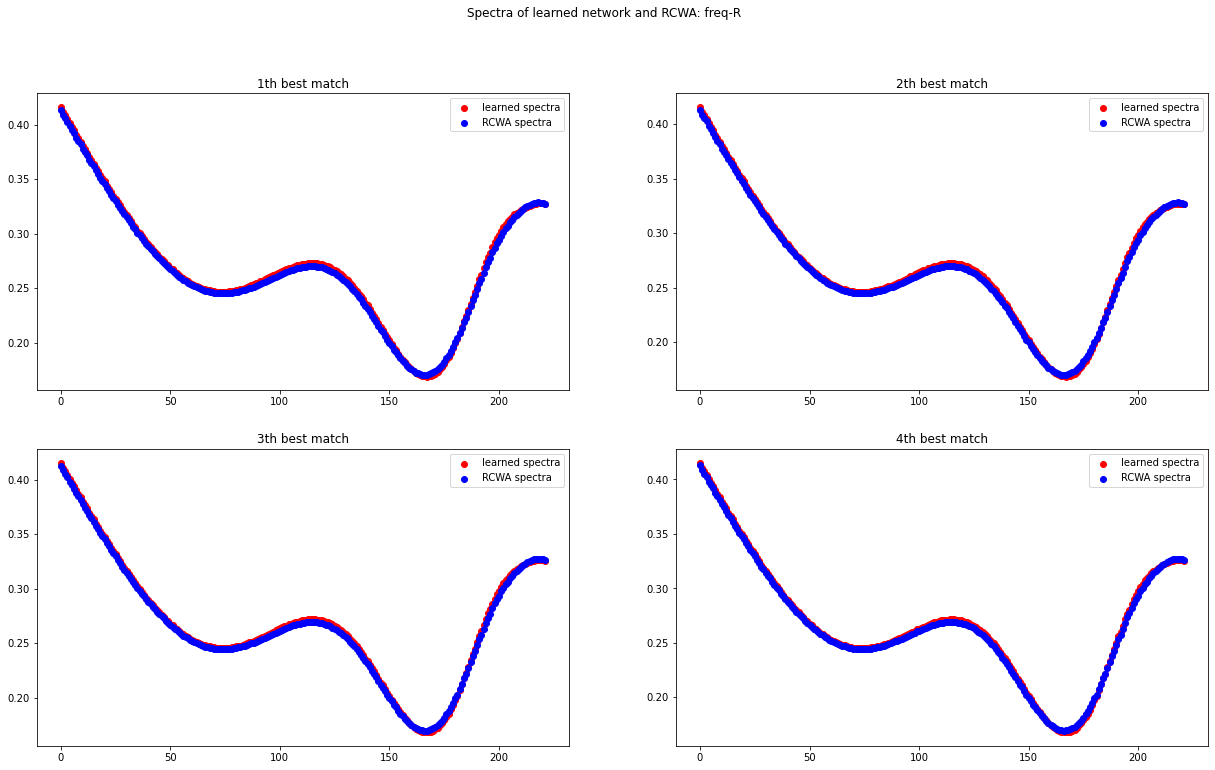

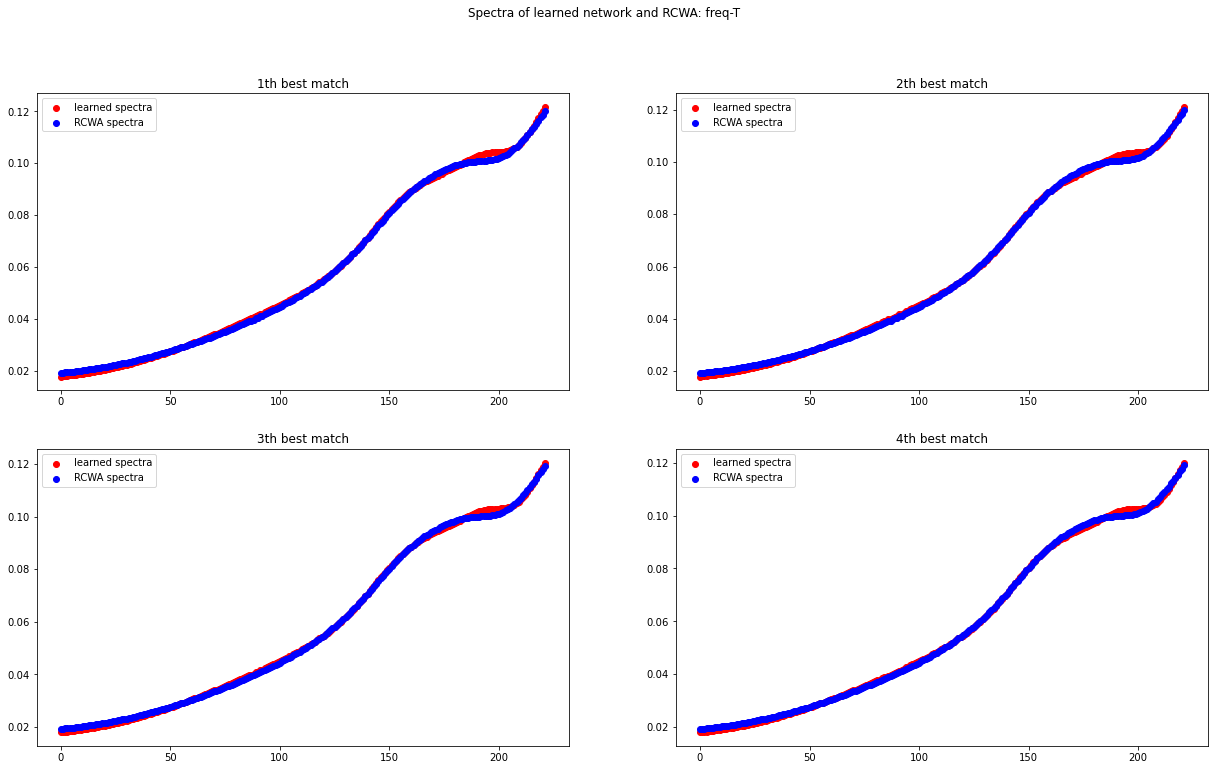

** Model saved.
**************************** ROUND 5 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 250
Sample points number available, continue calculating...
----------------
[ 1 / 50 ] [D1, D2] = [56. 99.]
Calculation Progress: 100%
----------------
[ 2 / 50 ] [D1, D2] = [120. 146.]
Calculation Progress: 100%
----------------
[ 3 / 50 ] [D1, D2] = [112. 130.]
Calculation Progress: 100%
----------------
[ 4 / 50 ] [D1, D2] = [115. 117.]
Calculation Progress: 100%
----------------
[ 5 / 50 ] [D1, D2] = [90. 82.]
Calculation Progress: 100%
----------------
[ 6 / 50 ] [D1, D2] = [ 54. 108.]
Calculation Progress: 100%
----------------
[ 7 / 50 ] [D1, D2] = [108. 130.]
Calculation Progress: 100%
----------------
[ 8 / 50 ] [D1, D2] = [133. 126.]
Calculation Progress: 100%
----------------
[ 9 / 50 ] [D1, D2] = [142.  88.]
Calculation Progress: 100%
----------------
[ 10 / 50 ] [D1, D2] = [88. 79.]
Calculation Progress: 100%

----------------------------------------------------------------------
*** EPOCH 26 || AVG LOSS 1.0898180852109362e-05
### TEST LOSS  5.421941978056566e-06
----------------------------------------------------------------------
*** EPOCH 27 || AVG LOSS 4.931990762770511e-06
### TEST LOSS  5.979872639727546e-06
----------------------------------------------------------------------
*** EPOCH 28 || AVG LOSS 4.884066716726921e-06
### TEST LOSS  6.719558882650745e-06
----------------------------------------------------------------------
*** EPOCH 29 || AVG LOSS 6.261036633986805e-06
### TEST LOSS  1.0976993053191109e-05
----------------------------------------------------------------------
*** EPOCH 30 || AVG LOSS 3.793157617565157e-06
### TEST LOSS  4.3396150317676074e-06
----------------------------------------------------------------------
*** EPOCH 31 || AVG LOSS 3.0404230022895717e-06
### TEST LOSS  2.793084604491014e-06
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 79 || AVG LOSS 9.477962367441251e-07
### TEST LOSS  8.21020094576852e-07
----------------------------------------------------------------------
*** EPOCH 80 || AVG LOSS 1.4313071914102692e-06
### TEST LOSS  2.6286360821359267e-06
----------------------------------------------------------------------
*** EPOCH 81 || AVG LOSS 1.648397722306072e-06
### TEST LOSS  1.432374716614504e-06
----------------------------------------------------------------------
*** EPOCH 82 || AVG LOSS 1.4867676930521157e-06
### TEST LOSS  1.3155783733509452e-06
----------------------------------------------------------------------
*** EPOCH 83 || AVG LOSS 2.435398518571219e-06
### TEST LOSS  2.424823435376311e-06
----------------------------------------------------------------------
*** EPOCH 84 || AVG LOSS 1.7881405328807886e-06
### TEST LOSS  1.9807136197869113e-06
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 132 || AVG LOSS 1.3305321637631097e-06
### TEST LOSS  2.514819584575889e-06
----------------------------------------------------------------------
*** EPOCH 133 || AVG LOSS 1.2977366909012744e-06
### TEST LOSS  1.3838279073752346e-06
----------------------------------------------------------------------
*** EPOCH 134 || AVG LOSS 2.580041058536153e-06
### TEST LOSS  4.482551844375848e-06
----------------------------------------------------------------------
*** EPOCH 135 || AVG LOSS 2.659776463019625e-06
### TEST LOSS  4.321955884734052e-06
----------------------------------------------------------------------
*** EPOCH 136 || AVG LOSS 2.066040016870829e-06
### TEST LOSS  1.4091660318626964e-06
----------------------------------------------------------------------
*** EPOCH 137 || AVG LOSS 1.2119057682298262e-06
### TEST LOSS  1.4007808317728632e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 185 || AVG LOSS 1.190847967393438e-06
### TEST LOSS  1.3416084243544901e-06
----------------------------------------------------------------------
*** EPOCH 186 || AVG LOSS 1.1829875178932524e-06
### TEST LOSS  1.0358731969972723e-06
----------------------------------------------------------------------
*** EPOCH 187 || AVG LOSS 1.4657712618770802e-06
### TEST LOSS  2.009691513649159e-06
----------------------------------------------------------------------
*** EPOCH 188 || AVG LOSS 1.3641405800512985e-06
### TEST LOSS  1.3146409401088022e-06
----------------------------------------------------------------------
*** EPOCH 189 || AVG LOSS 1.20666671921299e-06
### TEST LOSS  1.5994729096746596e-06
----------------------------------------------------------------------
*** EPOCH 190 || AVG LOSS 1.080322840664394e-06
### TEST LOSS  1.985962796879903e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 238 || AVG LOSS 1.0181937873880998e-06
### TEST LOSS  1.7288084279698523e-06
----------------------------------------------------------------------
*** EPOCH 239 || AVG LOSS 1.0302150091661133e-06
### TEST LOSS  1.4471540907834424e-06
----------------------------------------------------------------------
*** EPOCH 240 || AVG LOSS 1.6458838230164473e-06
### TEST LOSS  9.41903223861118e-07
----------------------------------------------------------------------
*** EPOCH 241 || AVG LOSS 7.332746156976099e-07
### TEST LOSS  7.863694264642618e-07
----------------------------------------------------------------------
*** EPOCH 242 || AVG LOSS 8.770466794345567e-07
### TEST LOSS  6.253796982491622e-07
----------------------------------------------------------------------
*** EPOCH 243 || AVG LOSS 6.247211825325394e-07
### TEST LOSS  5.106296825374557e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 291 || AVG LOSS 2.2538865109140715e-06
### TEST LOSS  8.279302647906661e-07
----------------------------------------------------------------------
*** EPOCH 292 || AVG LOSS 7.35358590333135e-07
### TEST LOSS  7.685093379450336e-07
----------------------------------------------------------------------
*** EPOCH 293 || AVG LOSS 5.196518343666412e-07
### TEST LOSS  5.309147894649868e-07
----------------------------------------------------------------------
*** EPOCH 294 || AVG LOSS 1.0707295470524514e-06
### TEST LOSS  1.7409080896868545e-06
----------------------------------------------------------------------
*** EPOCH 295 || AVG LOSS 1.4128010354284016e-06
### TEST LOSS  1.0828364338522078e-06
----------------------------------------------------------------------
*** EPOCH 296 || AVG LOSS 7.212191274561519e-07
### TEST LOSS  1.4330957753827533e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 344 || AVG LOSS 1.5391224609402343e-06
### TEST LOSS  9.122758655166763e-07
----------------------------------------------------------------------
*** EPOCH 345 || AVG LOSS 7.030371306200322e-07
### TEST LOSS  7.517500364428997e-07
----------------------------------------------------------------------
*** EPOCH 346 || AVG LOSS 7.13379675971737e-07
### TEST LOSS  5.968122991362179e-07
----------------------------------------------------------------------
*** EPOCH 347 || AVG LOSS 1.073964986574083e-06
### TEST LOSS  8.787633021256624e-07
----------------------------------------------------------------------
*** EPOCH 348 || AVG LOSS 7.700762783429127e-07
### TEST LOSS  6.774945120469056e-07
----------------------------------------------------------------------
*** EPOCH 349 || AVG LOSS 4.7208308853896596e-07
### TEST LOSS  4.936682245215707e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 397 || AVG LOSS 7.218731029752234e-07
### TEST LOSS  1.5098739254426619e-06
----------------------------------------------------------------------
*** EPOCH 398 || AVG LOSS 9.826646009685191e-07
### TEST LOSS  8.062518048745915e-07
----------------------------------------------------------------------
*** EPOCH 399 || AVG LOSS 7.625382002345305e-07
### TEST LOSS  6.987458220919507e-07
----------------------------------------------------------------------
*** EPOCH 400 || AVG LOSS 9.686072062606854e-07
### TEST LOSS  5.73415341875716e-07
----------------------------------------------------------------------
*** EPOCH 401 || AVG LOSS 7.299919696492907e-07
### TEST LOSS  7.596346165428258e-07
----------------------------------------------------------------------
*** EPOCH 402 || AVG LOSS 7.657194167052239e-07
### TEST LOSS  3.5264356483821757e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 450 || AVG LOSS 3.2816890472986415e-07
### TEST LOSS  4.326131204379635e-07
----------------------------------------------------------------------
*** EPOCH 451 || AVG LOSS 4.7352536512335066e-07
### TEST LOSS  6.406185235618977e-07
----------------------------------------------------------------------
*** EPOCH 452 || AVG LOSS 3.606734732102268e-07
### TEST LOSS  2.789478372733356e-07
----------------------------------------------------------------------
*** EPOCH 453 || AVG LOSS 4.037706613075898e-07
### TEST LOSS  2.9629349285187345e-07
----------------------------------------------------------------------
*** EPOCH 454 || AVG LOSS 3.3162088404026237e-07
### TEST LOSS  2.1790786419728647e-07
----------------------------------------------------------------------
*** EPOCH 455 || AVG LOSS 3.1168750039967106e-07
### TEST LOSS  4.2173976311232764e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 503 || AVG LOSS 7.037964104341654e-07
### TEST LOSS  7.595560447271055e-07
----------------------------------------------------------------------
*** EPOCH 504 || AVG LOSS 5.166815584232154e-07
### TEST LOSS  4.996079212560289e-07
----------------------------------------------------------------------
*** EPOCH 505 || AVG LOSS 5.428380532350729e-07
### TEST LOSS  3.314338741233769e-07
----------------------------------------------------------------------
*** EPOCH 506 || AVG LOSS 3.2082582855252896e-07
### TEST LOSS  2.460478398802479e-07
----------------------------------------------------------------------
*** EPOCH 507 || AVG LOSS 3.45697441062498e-07
### TEST LOSS  2.5800772363027136e-07
----------------------------------------------------------------------
*** EPOCH 508 || AVG LOSS 3.485167232071262e-07
### TEST LOSS  2.976435951040912e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 556 || AVG LOSS 9.068863600560917e-07
### TEST LOSS  1.852524491141594e-06
----------------------------------------------------------------------
*** EPOCH 557 || AVG LOSS 7.662535584529451e-07
### TEST LOSS  3.9613639302160664e-07
----------------------------------------------------------------------
*** EPOCH 558 || AVG LOSS 5.056072501190556e-07
### TEST LOSS  5.615004781134303e-07
----------------------------------------------------------------------
*** EPOCH 559 || AVG LOSS 4.855336812852329e-07
### TEST LOSS  5.707840813329312e-07
----------------------------------------------------------------------
*** EPOCH 560 || AVG LOSS 3.9862355467334967e-07
### TEST LOSS  7.526096084120582e-07
----------------------------------------------------------------------
*** EPOCH 561 || AVG LOSS 5.218329435194847e-07
### TEST LOSS  1.0144291024971608e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 609 || AVG LOSS 4.021272330305692e-07
### TEST LOSS  4.201210828114199e-07
----------------------------------------------------------------------
*** EPOCH 610 || AVG LOSS 4.078307032102657e-07
### TEST LOSS  5.897603330140555e-07
----------------------------------------------------------------------
*** EPOCH 611 || AVG LOSS 2.8623139145622646e-07
### TEST LOSS  3.1733726757465774e-07
----------------------------------------------------------------------
*** EPOCH 612 || AVG LOSS 3.034724604020767e-07
### TEST LOSS  2.0752545282221035e-07
----------------------------------------------------------------------
*** EPOCH 613 || AVG LOSS 2.828050914587266e-07
### TEST LOSS  2.614664467159855e-07
----------------------------------------------------------------------
*** EPOCH 614 || AVG LOSS 2.953670045826584e-07
### TEST LOSS  2.6612788062152504e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 662 || AVG LOSS 3.042274053939309e-07
### TEST LOSS  3.7980381506486083e-07
----------------------------------------------------------------------
*** EPOCH 663 || AVG LOSS 3.238503652340796e-07
### TEST LOSS  3.632089686789186e-07
----------------------------------------------------------------------
*** EPOCH 664 || AVG LOSS 6.699742411342413e-07
### TEST LOSS  2.926220687982095e-07
----------------------------------------------------------------------
*** EPOCH 665 || AVG LOSS 3.2238334125622715e-07
### TEST LOSS  3.272734758752449e-07
----------------------------------------------------------------------
*** EPOCH 666 || AVG LOSS 3.02684619697402e-07
### TEST LOSS  3.2327371002338623e-07
----------------------------------------------------------------------
*** EPOCH 667 || AVG LOSS 4.4306068720345594e-07
### TEST LOSS  2.1687874962594833e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 715 || AVG LOSS 1.6400375569673998e-06
### TEST LOSS  1.5428084338964254e-06
----------------------------------------------------------------------
*** EPOCH 716 || AVG LOSS 1.173830795437425e-06
### TEST LOSS  1.0539319106328549e-06
----------------------------------------------------------------------
*** EPOCH 717 || AVG LOSS 6.543963587546387e-07
### TEST LOSS  7.236548142941501e-07
----------------------------------------------------------------------
*** EPOCH 718 || AVG LOSS 1.0560847589005107e-06
### TEST LOSS  1.25938522899105e-06
----------------------------------------------------------------------
*** EPOCH 719 || AVG LOSS 9.055863926619168e-07
### TEST LOSS  5.422060610271728e-06
----------------------------------------------------------------------
*** EPOCH 720 || AVG LOSS 1.4609344547409365e-06
### TEST LOSS  7.726632844651249e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 768 || AVG LOSS 2.834114727505721e-07
### TEST LOSS  2.214922290022514e-07
----------------------------------------------------------------------
*** EPOCH 769 || AVG LOSS 3.410074525049822e-07
### TEST LOSS  1.9316983568273827e-07
----------------------------------------------------------------------
*** EPOCH 770 || AVG LOSS 2.908945782280625e-07
### TEST LOSS  2.381775772164474e-07
----------------------------------------------------------------------
*** EPOCH 771 || AVG LOSS 2.402933055236645e-07
### TEST LOSS  3.2116575710006146e-07
----------------------------------------------------------------------
*** EPOCH 772 || AVG LOSS 2.9854968352083235e-07
### TEST LOSS  6.754833350441913e-07
----------------------------------------------------------------------
*** EPOCH 773 || AVG LOSS 3.991294115479604e-07
### TEST LOSS  5.323644458599119e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 821 || AVG LOSS 2.4355073176707265e-07
### TEST LOSS  2.2582574388252397e-07
----------------------------------------------------------------------
*** EPOCH 822 || AVG LOSS 3.748166021466659e-07
### TEST LOSS  2.8716365818581835e-07
----------------------------------------------------------------------
*** EPOCH 823 || AVG LOSS 2.752627433721955e-07
### TEST LOSS  2.586118590386377e-07
----------------------------------------------------------------------
*** EPOCH 824 || AVG LOSS 2.8155549814812273e-07
### TEST LOSS  7.379997413181627e-07
----------------------------------------------------------------------
*** EPOCH 825 || AVG LOSS 2.852849162593429e-07
### TEST LOSS  3.138158319870854e-07
----------------------------------------------------------------------
*** EPOCH 826 || AVG LOSS 3.026258976461804e-07
### TEST LOSS  1.9443752918846258e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 874 || AVG LOSS 3.066142165266683e-07
### TEST LOSS  3.780688473398186e-07
----------------------------------------------------------------------
*** EPOCH 875 || AVG LOSS 3.759246229719793e-07
### TEST LOSS  3.7624735682584287e-07
----------------------------------------------------------------------
*** EPOCH 876 || AVG LOSS 2.824119401338976e-07
### TEST LOSS  1.5053730351155536e-07
----------------------------------------------------------------------
*** EPOCH 877 || AVG LOSS 2.3085320410132227e-07
### TEST LOSS  1.9852157606692344e-07
----------------------------------------------------------------------
*** EPOCH 878 || AVG LOSS 2.4353818662348206e-07
### TEST LOSS  2.702966952483621e-07
----------------------------------------------------------------------
*** EPOCH 879 || AVG LOSS 2.8123895302201164e-07
### TEST LOSS  3.1505868491876754e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 927 || AVG LOSS 2.6381695613508784e-07
### TEST LOSS  2.612697045378809e-07
----------------------------------------------------------------------
*** EPOCH 928 || AVG LOSS 2.7601984656655533e-07
### TEST LOSS  2.7080651321398364e-07
----------------------------------------------------------------------
*** EPOCH 929 || AVG LOSS 2.7750793272218745e-07
### TEST LOSS  3.37167698205576e-07
----------------------------------------------------------------------
*** EPOCH 930 || AVG LOSS 2.9023287159191113e-07
### TEST LOSS  3.387752585126691e-07
----------------------------------------------------------------------
*** EPOCH 931 || AVG LOSS 4.2547108294854753e-07
### TEST LOSS  2.630903992439926e-07
----------------------------------------------------------------------
*** EPOCH 932 || AVG LOSS 2.579088465921586e-07
### TEST LOSS  1.758103067572847e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 980 || AVG LOSS 2.8930075698951894e-07
### TEST LOSS  2.0317139615144697e-07
----------------------------------------------------------------------
*** EPOCH 981 || AVG LOSS 2.5196855381182104e-07
### TEST LOSS  2.4285130706402924e-07
----------------------------------------------------------------------
*** EPOCH 982 || AVG LOSS 2.3324287172954426e-07
### TEST LOSS  1.4642136036968623e-07
----------------------------------------------------------------------
*** EPOCH 983 || AVG LOSS 2.2747126239153204e-07
### TEST LOSS  1.7030301080467325e-07
----------------------------------------------------------------------
*** EPOCH 984 || AVG LOSS 3.5122344515059467e-07
### TEST LOSS  3.30851833041379e-07
----------------------------------------------------------------------
*** EPOCH 985 || AVG LOSS 2.6499945684577144e-07
### TEST LOSS  2.070876448101444e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1032 || AVG LOSS 2.668774347256431e-07
### TEST LOSS  1.5013586107670562e-07
----------------------------------------------------------------------
*** EPOCH 1033 || AVG LOSS 2.722555187943954e-07
### TEST LOSS  5.445366113576711e-07
----------------------------------------------------------------------
*** EPOCH 1034 || AVG LOSS 2.5843727837582264e-07
### TEST LOSS  1.8678815649764147e-07
----------------------------------------------------------------------
*** EPOCH 1035 || AVG LOSS 2.257473557634171e-07
### TEST LOSS  3.2034045460704874e-07
----------------------------------------------------------------------
*** EPOCH 1036 || AVG LOSS 2.791225598031133e-07
### TEST LOSS  4.499959089798722e-07
----------------------------------------------------------------------
*** EPOCH 1037 || AVG LOSS 4.1516541145369955e-07
### TEST LOSS  3.888491590942067e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1084 || AVG LOSS 2.783581073231289e-07
### TEST LOSS  2.572665245281769e-07
----------------------------------------------------------------------
*** EPOCH 1085 || AVG LOSS 2.501128405896225e-07
### TEST LOSS  1.288646451769182e-07
----------------------------------------------------------------------
*** EPOCH 1086 || AVG LOSS 2.365978929361745e-07
### TEST LOSS  2.743779177194483e-07
----------------------------------------------------------------------
*** EPOCH 1087 || AVG LOSS 2.2383786372870417e-07
### TEST LOSS  1.887642753217733e-07
----------------------------------------------------------------------
*** EPOCH 1088 || AVG LOSS 2.465682470074171e-07
### TEST LOSS  1.8735751439180603e-07
----------------------------------------------------------------------
*** EPOCH 1089 || AVG LOSS 3.254547928008833e-07
### TEST LOSS  2.2881807737462623e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1136 || AVG LOSS 5.121077081895464e-07
### TEST LOSS  3.4541633198159616e-07
----------------------------------------------------------------------
*** EPOCH 1137 || AVG LOSS 3.578471548593143e-07
### TEST LOSS  3.25422853109103e-07
----------------------------------------------------------------------
*** EPOCH 1138 || AVG LOSS 2.5853541015408155e-07
### TEST LOSS  2.0120988608596235e-07
----------------------------------------------------------------------
*** EPOCH 1139 || AVG LOSS 2.1407906523052133e-07
### TEST LOSS  2.2642022301511133e-07
----------------------------------------------------------------------
*** EPOCH 1140 || AVG LOSS 2.3364694989425061e-07
### TEST LOSS  1.856257476617884e-07
----------------------------------------------------------------------
*** EPOCH 1141 || AVG LOSS 2.3916484780528437e-07
### TEST LOSS  2.1284946782884617e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1188 || AVG LOSS 2.158455498602052e-07
### TEST LOSS  1.9663439942974037e-07
----------------------------------------------------------------------
*** EPOCH 1189 || AVG LOSS 2.7171663366232224e-07
### TEST LOSS  2.1033023855920874e-07
----------------------------------------------------------------------
*** EPOCH 1190 || AVG LOSS 3.152873052272298e-07
### TEST LOSS  3.424040855293242e-07
----------------------------------------------------------------------
*** EPOCH 1191 || AVG LOSS 3.9295619144752435e-07
### TEST LOSS  2.812329391588264e-07
----------------------------------------------------------------------
*** EPOCH 1192 || AVG LOSS 2.3946624342841004e-07
### TEST LOSS  2.2464378446329647e-07
----------------------------------------------------------------------
*** EPOCH 1193 || AVG LOSS 2.2625209869886475e-07
### TEST LOSS  1.5017217691593032e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1240 || AVG LOSS 2.1283442364961046e-07
### TEST LOSS  1.3629311368390518e-07
----------------------------------------------------------------------
*** EPOCH 1241 || AVG LOSS 2.12483414557596e-07
### TEST LOSS  2.567513988083192e-07
----------------------------------------------------------------------
*** EPOCH 1242 || AVG LOSS 2.3121389916980207e-07
### TEST LOSS  2.053710943528131e-07
----------------------------------------------------------------------
*** EPOCH 1243 || AVG LOSS 2.1179698467221897e-07
### TEST LOSS  1.5563627187020757e-07
----------------------------------------------------------------------
*** EPOCH 1244 || AVG LOSS 2.0386667783611755e-07
### TEST LOSS  1.8766885290233404e-07
----------------------------------------------------------------------
*** EPOCH 1245 || AVG LOSS 2.2066850078772403e-07
### TEST LOSS  2.710723094878631e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1292 || AVG LOSS 2.0494073984878015e-07
### TEST LOSS  1.4549954308051838e-07
----------------------------------------------------------------------
*** EPOCH 1293 || AVG LOSS 1.898067916670243e-07
### TEST LOSS  1.6338099229074032e-07
----------------------------------------------------------------------
*** EPOCH 1294 || AVG LOSS 2.184634318780354e-07
### TEST LOSS  1.54647533889829e-07
----------------------------------------------------------------------
*** EPOCH 1295 || AVG LOSS 1.8693386365953302e-07
### TEST LOSS  2.8750888247941475e-07
----------------------------------------------------------------------
*** EPOCH 1296 || AVG LOSS 1.7957499128584687e-07
### TEST LOSS  2.0049337834393555e-07
----------------------------------------------------------------------
*** EPOCH 1297 || AVG LOSS 2.4179144696745425e-07
### TEST LOSS  1.7479043989965248e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1344 || AVG LOSS 1.9587561693867882e-07
### TEST LOSS  1.7517548300816088e-07
----------------------------------------------------------------------
*** EPOCH 1345 || AVG LOSS 2.0685960015498495e-07
### TEST LOSS  2.514648720364221e-07
----------------------------------------------------------------------
*** EPOCH 1346 || AVG LOSS 2.5124200355719493e-07
### TEST LOSS  1.8564055537240165e-07
----------------------------------------------------------------------
*** EPOCH 1347 || AVG LOSS 2.1718370616952143e-07
### TEST LOSS  2.4136647169825665e-07
----------------------------------------------------------------------
*** EPOCH 1348 || AVG LOSS 4.2285819662879473e-07
### TEST LOSS  9.16008502827026e-07
----------------------------------------------------------------------
*** EPOCH 1349 || AVG LOSS 2.8054978531599773e-07
### TEST LOSS  2.433406756097156e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1396 || AVG LOSS 1.9784711027170942e-07
### TEST LOSS  2.486119079492255e-07
----------------------------------------------------------------------
*** EPOCH 1397 || AVG LOSS 2.1977293784658513e-07
### TEST LOSS  1.5734957869995014e-07
----------------------------------------------------------------------
*** EPOCH 1398 || AVG LOSS 2.3050757855003211e-07
### TEST LOSS  4.797861450356322e-07
----------------------------------------------------------------------
*** EPOCH 1399 || AVG LOSS 2.127229078610071e-07
### TEST LOSS  1.641584219669312e-07
----------------------------------------------------------------------
*** EPOCH 1400 || AVG LOSS 2.5683154969158293e-07
### TEST LOSS  1.9918655524975293e-07
----------------------------------------------------------------------
*** EPOCH 1401 || AVG LOSS 2.6341527693318766e-07
### TEST LOSS  2.9144665347757837e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1448 || AVG LOSS 2.0395401010375736e-07
### TEST LOSS  1.5641648332120894e-07
----------------------------------------------------------------------
*** EPOCH 1449 || AVG LOSS 1.871679735785392e-07
### TEST LOSS  1.6814641412565834e-07
----------------------------------------------------------------------
*** EPOCH 1450 || AVG LOSS 2.469270654756883e-07
### TEST LOSS  3.03344229735103e-07
----------------------------------------------------------------------
*** EPOCH 1451 || AVG LOSS 2.1173189276169068e-07
### TEST LOSS  1.4154387883991149e-07
----------------------------------------------------------------------
*** EPOCH 1452 || AVG LOSS 2.0962945755798046e-07
### TEST LOSS  1.4324134234300345e-07
----------------------------------------------------------------------
*** EPOCH 1453 || AVG LOSS 2.2472947362928152e-07
### TEST LOSS  1.3891015271383367e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1500 || AVG LOSS 3.629806078464526e-07
### TEST LOSS  2.079068188720612e-07
----------------------------------------------------------------------
*** EPOCH 1501 || AVG LOSS 2.1301812779483954e-07
### TEST LOSS  2.645685981406132e-07
----------------------------------------------------------------------
*** EPOCH 1502 || AVG LOSS 1.9234775311005592e-07
### TEST LOSS  2.524593902819561e-07
----------------------------------------------------------------------
*** EPOCH 1503 || AVG LOSS 2.469977096097864e-07
### TEST LOSS  1.9651429994382852e-07
----------------------------------------------------------------------
*** EPOCH 1504 || AVG LOSS 2.548537913042992e-07
### TEST LOSS  3.5268870846039135e-07
----------------------------------------------------------------------
*** EPOCH 1505 || AVG LOSS 2.541675503522356e-07
### TEST LOSS  2.9893322306406844e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1552 || AVG LOSS 1.882191667874622e-07
### TEST LOSS  1.8233752285823357e-07
----------------------------------------------------------------------
*** EPOCH 1553 || AVG LOSS 1.795934841979374e-07
### TEST LOSS  2.174549287303762e-07
----------------------------------------------------------------------
*** EPOCH 1554 || AVG LOSS 2.413712594062645e-07
### TEST LOSS  1.5821420973338718e-07
----------------------------------------------------------------------
*** EPOCH 1555 || AVG LOSS 1.6447523948670552e-07
### TEST LOSS  1.6127014390576733e-07
----------------------------------------------------------------------
*** EPOCH 1556 || AVG LOSS 2.522796111747994e-07
### TEST LOSS  1.4030129236175526e-07
----------------------------------------------------------------------
*** EPOCH 1557 || AVG LOSS 2.3014062050208394e-07
### TEST LOSS  1.2965561246858215e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1604 || AVG LOSS 1.9000928674017815e-07
### TEST LOSS  2.563204084538029e-07
----------------------------------------------------------------------
*** EPOCH 1605 || AVG LOSS 2.6104057530318415e-07
### TEST LOSS  1.5816779708188733e-07
----------------------------------------------------------------------
*** EPOCH 1606 || AVG LOSS 2.7336556064483375e-07
### TEST LOSS  2.0862338345750686e-07
----------------------------------------------------------------------
*** EPOCH 1607 || AVG LOSS 4.032643911955347e-07
### TEST LOSS  2.9723447880769527e-07
----------------------------------------------------------------------
*** EPOCH 1608 || AVG LOSS 2.5969176239470926e-07
### TEST LOSS  1.7577407263047462e-07
----------------------------------------------------------------------
*** EPOCH 1609 || AVG LOSS 2.086047609139996e-07
### TEST LOSS  1.355287455595544e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1656 || AVG LOSS 2.273696160983718e-07
### TEST LOSS  1.9002923323796495e-07
----------------------------------------------------------------------
*** EPOCH 1657 || AVG LOSS 2.1459262647738342e-07
### TEST LOSS  1.52575044154446e-07
----------------------------------------------------------------------
*** EPOCH 1658 || AVG LOSS 1.9569392204488167e-07
### TEST LOSS  2.610113263301628e-07
----------------------------------------------------------------------
*** EPOCH 1659 || AVG LOSS 2.540776815251888e-07
### TEST LOSS  1.524392345686465e-07
----------------------------------------------------------------------
*** EPOCH 1660 || AVG LOSS 2.338463273829916e-07
### TEST LOSS  2.2713949121566657e-07
----------------------------------------------------------------------
*** EPOCH 1661 || AVG LOSS 2.2365092623033432e-07
### TEST LOSS  1.831140039598722e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1708 || AVG LOSS 2.1026934869894375e-07
### TEST LOSS  3.7071836800350866e-07
----------------------------------------------------------------------
*** EPOCH 1709 || AVG LOSS 3.0578670883585345e-07
### TEST LOSS  1.5787237117592667e-07
----------------------------------------------------------------------
*** EPOCH 1710 || AVG LOSS 1.9995123452787312e-07
### TEST LOSS  2.3451493547099744e-07
----------------------------------------------------------------------
*** EPOCH 1711 || AVG LOSS 1.8083102616373025e-07
### TEST LOSS  2.9149892810664824e-07
----------------------------------------------------------------------
*** EPOCH 1712 || AVG LOSS 1.9718135430935037e-07
### TEST LOSS  1.989887756792541e-07
----------------------------------------------------------------------
*** EPOCH 1713 || AVG LOSS 1.6994278897897175e-07
### TEST LOSS  2.0548256429719913e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1760 || AVG LOSS 2.0027991901372388e-07
### TEST LOSS  2.4276000232248407e-07
----------------------------------------------------------------------
*** EPOCH 1761 || AVG LOSS 2.2533325183360375e-07
### TEST LOSS  2.3958105543897545e-07
----------------------------------------------------------------------
*** EPOCH 1762 || AVG LOSS 1.8247106579849514e-07
### TEST LOSS  1.1701044577705488e-07
----------------------------------------------------------------------
*** EPOCH 1763 || AVG LOSS 1.8975433981438529e-07
### TEST LOSS  1.511586837921186e-07
----------------------------------------------------------------------
*** EPOCH 1764 || AVG LOSS 2.2255145839977786e-07
### TEST LOSS  3.6846331852302683e-07
----------------------------------------------------------------------
*** EPOCH 1765 || AVG LOSS 2.503444382568887e-07
### TEST LOSS  2.094672666430597e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1812 || AVG LOSS 1.930366919467019e-07
### TEST LOSS  1.3403668930322965e-07
----------------------------------------------------------------------
*** EPOCH 1813 || AVG LOSS 2.1442691796380587e-07
### TEST LOSS  2.4759276584518375e-07
----------------------------------------------------------------------
*** EPOCH 1814 || AVG LOSS 2.688855883548058e-07
### TEST LOSS  1.6217505205418092e-07
----------------------------------------------------------------------
*** EPOCH 1815 || AVG LOSS 3.031789495366866e-07
### TEST LOSS  3.00499056749004e-07
----------------------------------------------------------------------
*** EPOCH 1816 || AVG LOSS 1.775181273160342e-07
### TEST LOSS  1.2362707479951496e-07
----------------------------------------------------------------------
*** EPOCH 1817 || AVG LOSS 2.1695440389635224e-07
### TEST LOSS  1.6439031824688755e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1864 || AVG LOSS 1.8395436772777885e-07
### TEST LOSS  1.831070832736259e-07
----------------------------------------------------------------------
*** EPOCH 1865 || AVG LOSS 2.16069145423603e-07
### TEST LOSS  1.3508264018469163e-07
----------------------------------------------------------------------
*** EPOCH 1866 || AVG LOSS 1.6977742141932595e-07
### TEST LOSS  1.9938853057510642e-07
----------------------------------------------------------------------
*** EPOCH 1867 || AVG LOSS 2.4174081025307716e-07
### TEST LOSS  2.2200193683374891e-07
----------------------------------------------------------------------
*** EPOCH 1868 || AVG LOSS 2.0057453263433446e-07
### TEST LOSS  1.6357003929101666e-07
----------------------------------------------------------------------
*** EPOCH 1869 || AVG LOSS 2.8075704064178807e-07
### TEST LOSS  5.310841402206279e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1916 || AVG LOSS 1.5495794649211804e-07
### TEST LOSS  1.2159795659272277e-07
----------------------------------------------------------------------
*** EPOCH 1917 || AVG LOSS 1.763335975866198e-07
### TEST LOSS  1.2867806020722128e-07
----------------------------------------------------------------------
*** EPOCH 1918 || AVG LOSS 2.2058662273138907e-07
### TEST LOSS  2.51205619861139e-07
----------------------------------------------------------------------
*** EPOCH 1919 || AVG LOSS 1.515078259117786e-07
### TEST LOSS  1.2997860210361978e-07
----------------------------------------------------------------------
*** EPOCH 1920 || AVG LOSS 2.3083885191965693e-07
### TEST LOSS  1.3960952216507394e-07
----------------------------------------------------------------------
*** EPOCH 1921 || AVG LOSS 1.568146926587133e-07
### TEST LOSS  1.758910670446312e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1968 || AVG LOSS 1.7954990929069936e-07
### TEST LOSS  1.0522040305716018e-07
----------------------------------------------------------------------
*** EPOCH 1969 || AVG LOSS 2.575113396119377e-07
### TEST LOSS  8.503058239739403e-07
----------------------------------------------------------------------
*** EPOCH 1970 || AVG LOSS 2.2501784259532087e-07
### TEST LOSS  1.694435454169252e-07
----------------------------------------------------------------------
*** EPOCH 1971 || AVG LOSS 1.698798262950163e-07
### TEST LOSS  1.3490982553321373e-07
----------------------------------------------------------------------
*** EPOCH 1972 || AVG LOSS 2.1569865191395364e-07
### TEST LOSS  2.2438178604033965e-07
----------------------------------------------------------------------
*** EPOCH 1973 || AVG LOSS 2.0298542537489085e-07
### TEST LOSS  3.0149191587725e-07
-----------------------------------------------------

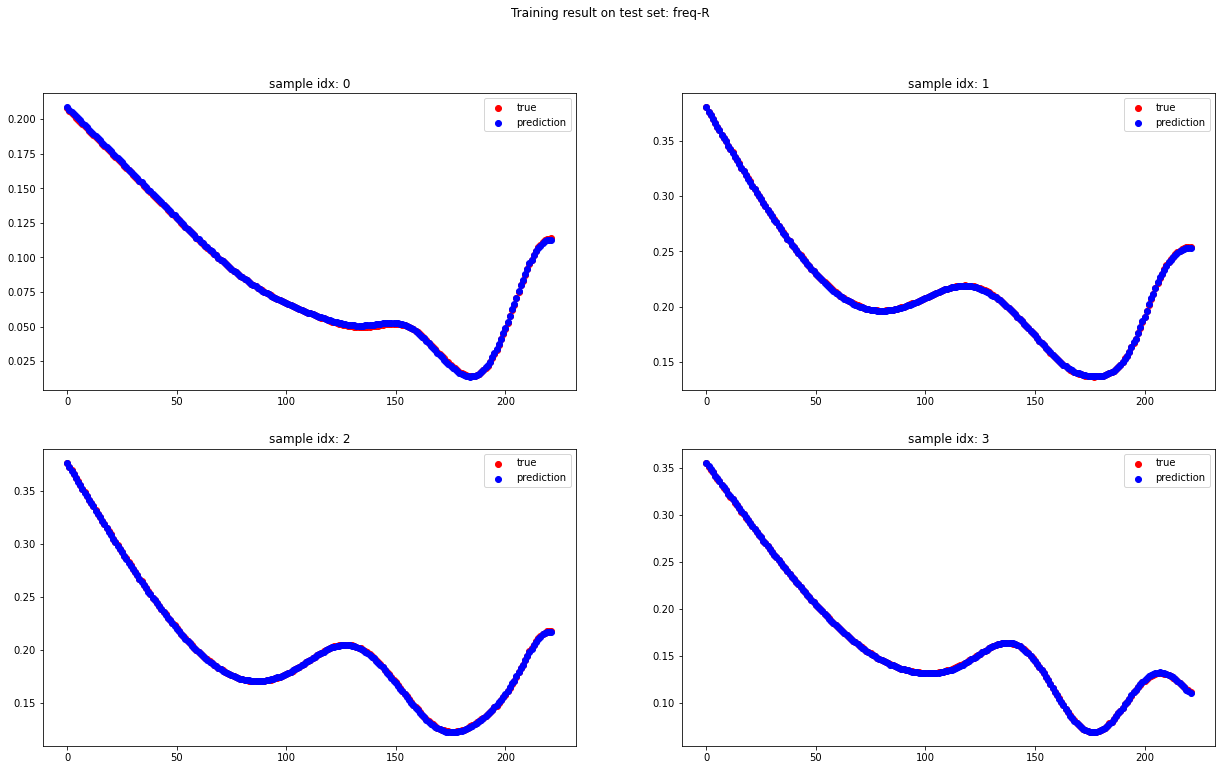

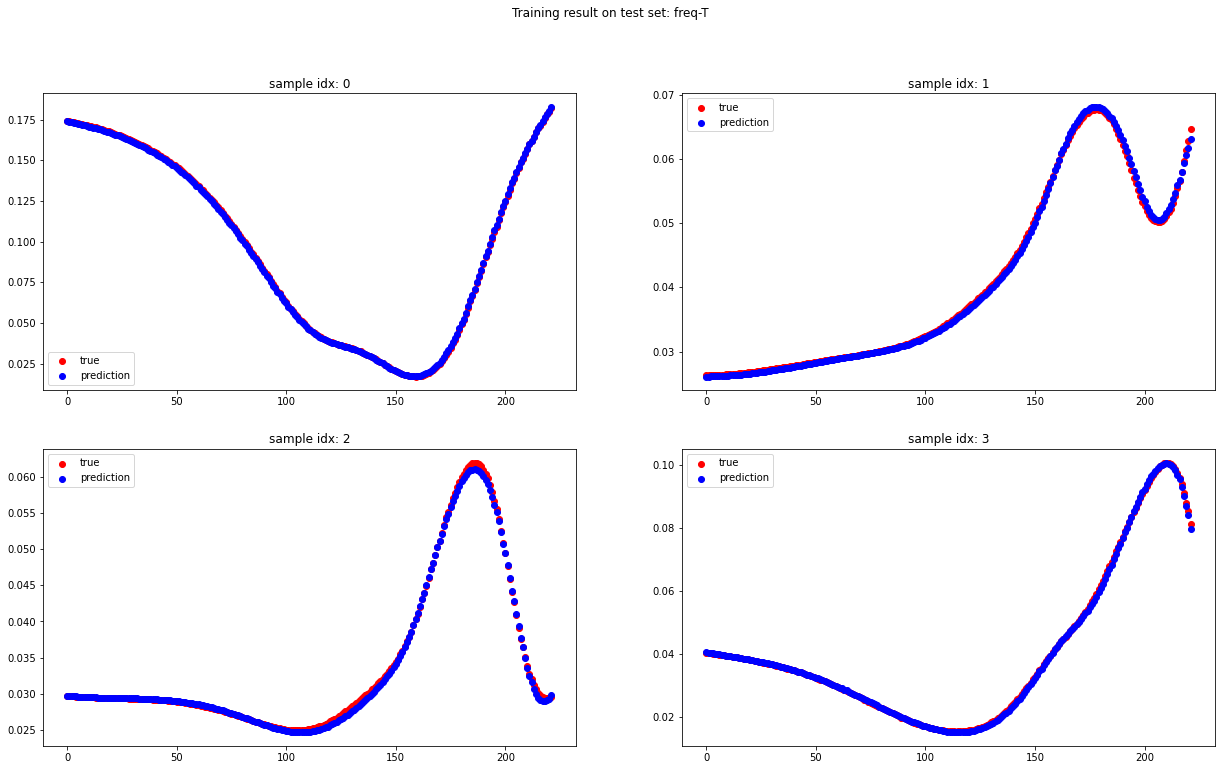

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 50.  53. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  54. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 50.  55. 160.  75.]
 [ 50.  56. 160.  75.]
 [ 51.  52. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


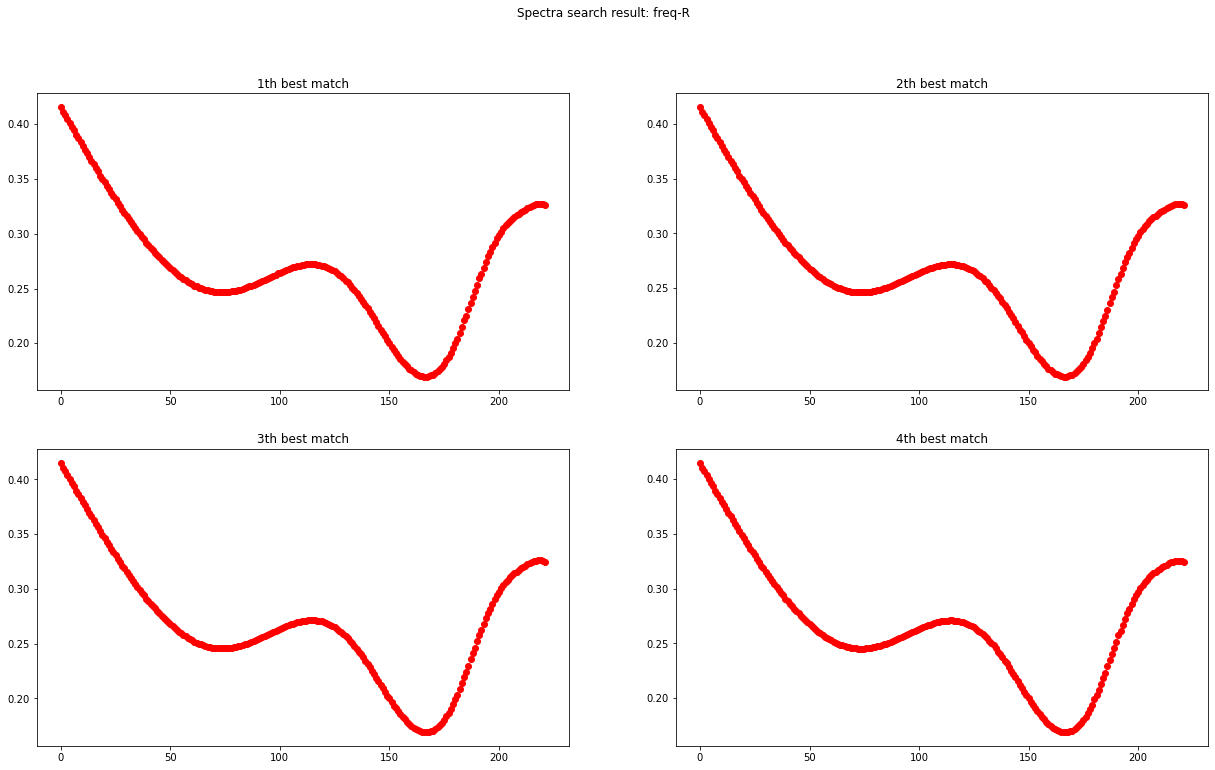

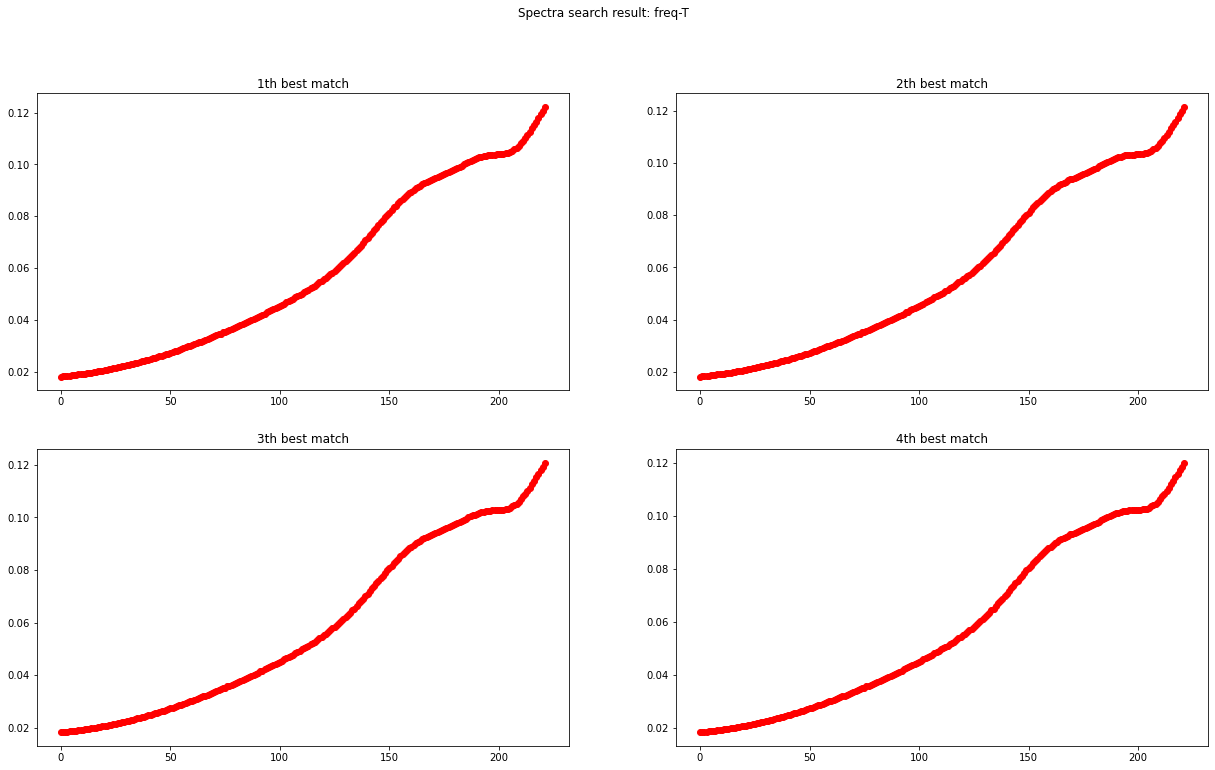

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.01691540329671315


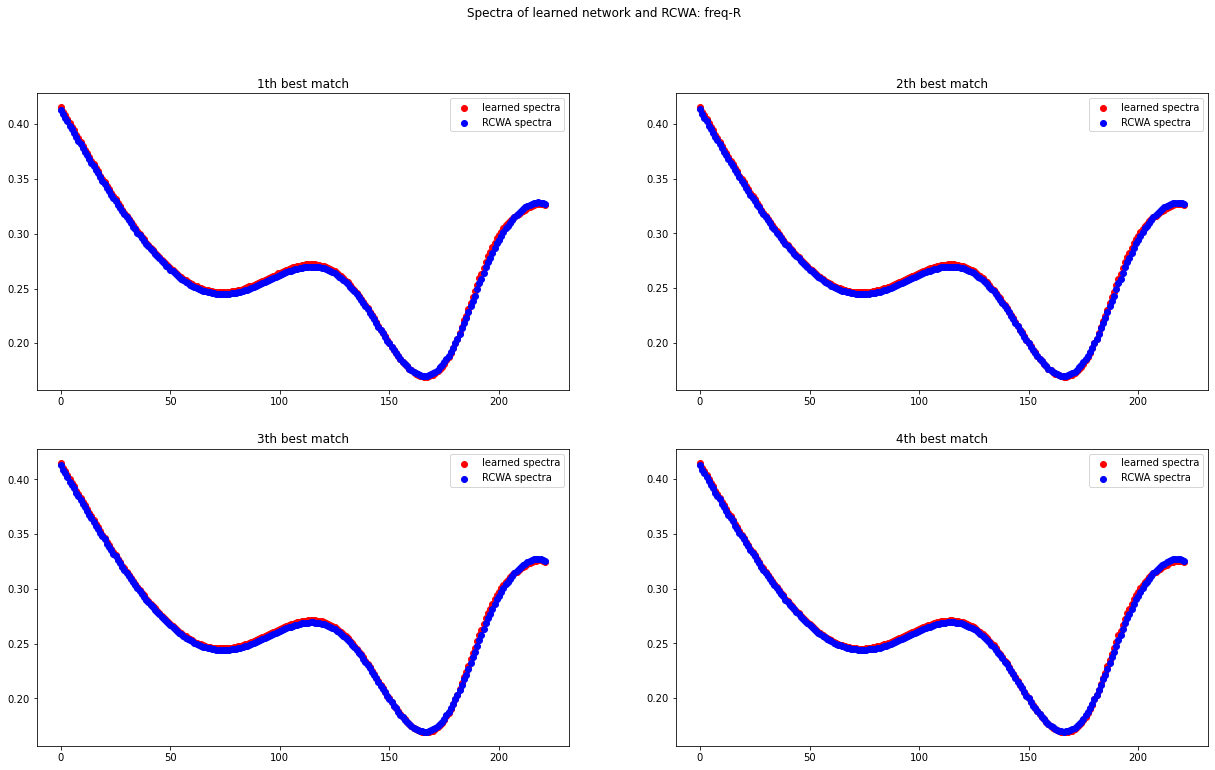

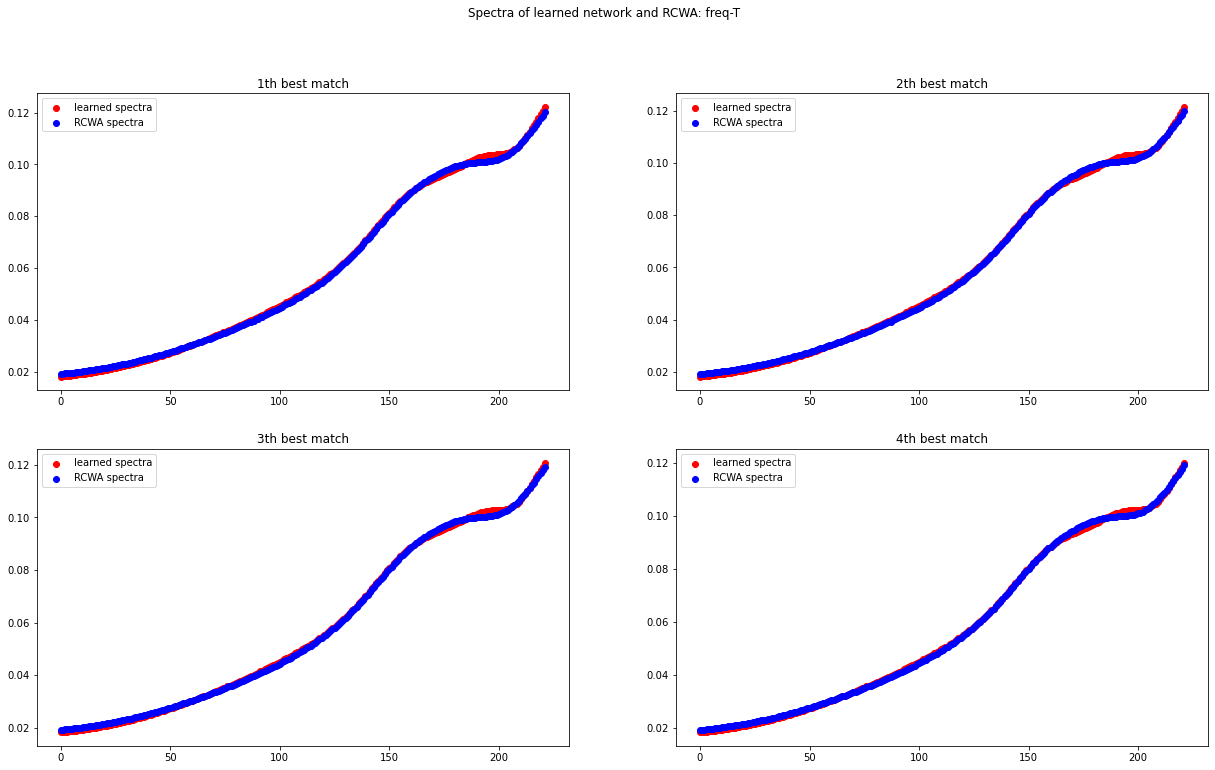

** Model saved.
**************************** ROUND 6 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 300
Sample points number available, continue calculating...
----------------
[ 1 / 50 ] [D1, D2] = [147.  55.]
Calculation Progress: 100%
----------------
[ 2 / 50 ] [D1, D2] = [85. 51.]
Calculation Progress: 100%
----------------
[ 3 / 50 ] [D1, D2] = [149.  81.]
Calculation Progress: 100%
----------------
[ 4 / 50 ] [D1, D2] = [ 87. 101.]
Calculation Progress: 100%
----------------
[ 5 / 50 ] [D1, D2] = [110. 107.]
Calculation Progress: 100%
----------------
[ 6 / 50 ] [D1, D2] = [125. 147.]
Calculation Progress: 100%
----------------
[ 7 / 50 ] [D1, D2] = [76. 59.]
Calculation Progress: 100%
----------------
[ 8 / 50 ] [D1, D2] = [75. 94.]
Calculation Progress: 100%
----------------
[ 9 / 50 ] [D1, D2] = [150.  89.]
Calculation Progress: 100%
----------------
[ 10 / 50 ] [D1, D2] = [102. 104.]
Calculation Progress: 100%

----------------------------------------------------------------------
*** EPOCH 26 || AVG LOSS 9.530260779418617e-06
### TEST LOSS  4.720090828413959e-06
----------------------------------------------------------------------
*** EPOCH 27 || AVG LOSS 9.31265111423348e-06
### TEST LOSS  4.163424318903708e-06
----------------------------------------------------------------------
*** EPOCH 28 || AVG LOSS 6.024688023368677e-06
### TEST LOSS  4.546291711449157e-06
----------------------------------------------------------------------
*** EPOCH 29 || AVG LOSS 3.941096797272318e-06
### TEST LOSS  6.060522218831466e-06
----------------------------------------------------------------------
*** EPOCH 30 || AVG LOSS 3.914344230698438e-06
### TEST LOSS  3.475270523267682e-06
----------------------------------------------------------------------
*** EPOCH 31 || AVG LOSS 2.402306113680197e-06
### TEST LOSS  3.397104819669039e-06
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 79 || AVG LOSS 1.5703981851326412e-06
### TEST LOSS  1.56119062921789e-06
----------------------------------------------------------------------
*** EPOCH 80 || AVG LOSS 1.5007010691903133e-06
### TEST LOSS  1.574490897837677e-06
----------------------------------------------------------------------
*** EPOCH 81 || AVG LOSS 1.2729200210988742e-06
### TEST LOSS  1.5057442624311079e-06
----------------------------------------------------------------------
*** EPOCH 82 || AVG LOSS 1.5305008544904316e-06
### TEST LOSS  1.9896638605132464e-06
----------------------------------------------------------------------
*** EPOCH 83 || AVG LOSS 1.5868456863188386e-06
### TEST LOSS  2.0260902829249973e-06
----------------------------------------------------------------------
*** EPOCH 84 || AVG LOSS 1.7348727034042593e-06
### TEST LOSS  2.0173965822323225e-06
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 132 || AVG LOSS 9.395127175556202e-07
### TEST LOSS  8.490012874062813e-07
----------------------------------------------------------------------
*** EPOCH 133 || AVG LOSS 8.169314984485254e-07
### TEST LOSS  9.191763524540875e-07
----------------------------------------------------------------------
*** EPOCH 134 || AVG LOSS 8.654218422776694e-07
### TEST LOSS  6.342661777125613e-07
----------------------------------------------------------------------
*** EPOCH 135 || AVG LOSS 7.993942449739204e-07
### TEST LOSS  1.378683805342007e-06
----------------------------------------------------------------------
*** EPOCH 136 || AVG LOSS 7.380894213326883e-07
### TEST LOSS  7.582880016343551e-07
----------------------------------------------------------------------
*** EPOCH 137 || AVG LOSS 7.372116705776459e-07
### TEST LOSS  5.258249302642071e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 185 || AVG LOSS 1.2454544705538712e-06
### TEST LOSS  7.096957801877579e-07
----------------------------------------------------------------------
*** EPOCH 186 || AVG LOSS 6.588808068859938e-07
### TEST LOSS  8.239182420766156e-07
----------------------------------------------------------------------
*** EPOCH 187 || AVG LOSS 6.804014831847856e-07
### TEST LOSS  7.056372851366177e-07
----------------------------------------------------------------------
*** EPOCH 188 || AVG LOSS 7.608353501827499e-07
### TEST LOSS  8.680334985911032e-07
----------------------------------------------------------------------
*** EPOCH 189 || AVG LOSS 6.37457548009479e-07
### TEST LOSS  7.610855845996411e-07
----------------------------------------------------------------------
*** EPOCH 190 || AVG LOSS 6.341308917967581e-07
### TEST LOSS  6.301236510353192e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 238 || AVG LOSS 9.629494411929804e-07
### TEST LOSS  5.42522758451014e-07
----------------------------------------------------------------------
*** EPOCH 239 || AVG LOSS 5.612226827504211e-07
### TEST LOSS  9.55550638082059e-07
----------------------------------------------------------------------
*** EPOCH 240 || AVG LOSS 1.161894399075436e-06
### TEST LOSS  6.696487218960101e-07
----------------------------------------------------------------------
*** EPOCH 241 || AVG LOSS 6.131537522691132e-07
### TEST LOSS  4.522806932527601e-07
----------------------------------------------------------------------
*** EPOCH 242 || AVG LOSS 6.531405886297155e-07
### TEST LOSS  1.3464388757711276e-06
----------------------------------------------------------------------
*** EPOCH 243 || AVG LOSS 1.2863511294843495e-06
### TEST LOSS  1.2797628073712985e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 291 || AVG LOSS 9.684229509332454e-07
### TEST LOSS  8.966413872713019e-07
----------------------------------------------------------------------
*** EPOCH 292 || AVG LOSS 1.0378303798574962e-06
### TEST LOSS  1.7049197595042643e-06
----------------------------------------------------------------------
*** EPOCH 293 || AVG LOSS 1.7196590039484741e-06
### TEST LOSS  7.081394983288192e-07
----------------------------------------------------------------------
*** EPOCH 294 || AVG LOSS 7.002680144078491e-07
### TEST LOSS  6.340316474506835e-07
----------------------------------------------------------------------
*** EPOCH 295 || AVG LOSS 9.122780162111137e-07
### TEST LOSS  1.4263276170822792e-06
----------------------------------------------------------------------
*** EPOCH 296 || AVG LOSS 9.969817805218402e-07
### TEST LOSS  8.651441703477758e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 344 || AVG LOSS 3.836093032324091e-07
### TEST LOSS  5.154047528321826e-07
----------------------------------------------------------------------
*** EPOCH 345 || AVG LOSS 3.615839608054709e-07
### TEST LOSS  3.706114227952639e-07
----------------------------------------------------------------------
*** EPOCH 346 || AVG LOSS 3.7858342080217727e-07
### TEST LOSS  5.053972074620105e-07
----------------------------------------------------------------------
*** EPOCH 347 || AVG LOSS 3.150857768356256e-07
### TEST LOSS  3.1131018261021384e-07
----------------------------------------------------------------------
*** EPOCH 348 || AVG LOSS 3.6083720510523185e-07
### TEST LOSS  3.631785489233152e-07
----------------------------------------------------------------------
*** EPOCH 349 || AVG LOSS 4.410433692333034e-07
### TEST LOSS  3.861405048155575e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 397 || AVG LOSS 3.563005283761337e-07
### TEST LOSS  3.2330821682080567e-07
----------------------------------------------------------------------
*** EPOCH 398 || AVG LOSS 3.494206516663212e-07
### TEST LOSS  2.699258288885176e-07
----------------------------------------------------------------------
*** EPOCH 399 || AVG LOSS 3.4701029297442197e-07
### TEST LOSS  4.741198722513218e-07
----------------------------------------------------------------------
*** EPOCH 400 || AVG LOSS 3.5987874461795856e-07
### TEST LOSS  5.213328961417574e-07
----------------------------------------------------------------------
*** EPOCH 401 || AVG LOSS 3.674469013503767e-07
### TEST LOSS  3.461158257778152e-07
----------------------------------------------------------------------
*** EPOCH 402 || AVG LOSS 3.7881191284820184e-07
### TEST LOSS  2.94479772833256e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 450 || AVG LOSS 4.4123516230361777e-07
### TEST LOSS  5.638363347770791e-07
----------------------------------------------------------------------
*** EPOCH 451 || AVG LOSS 4.945674936844095e-07
### TEST LOSS  1.1214602068321256e-06
----------------------------------------------------------------------
*** EPOCH 452 || AVG LOSS 4.865397902638809e-07
### TEST LOSS  3.3135615922219587e-07
----------------------------------------------------------------------
*** EPOCH 453 || AVG LOSS 4.289438673173625e-07
### TEST LOSS  8.257142098955228e-07
----------------------------------------------------------------------
*** EPOCH 454 || AVG LOSS 4.976353235501089e-07
### TEST LOSS  5.489768000188633e-07
----------------------------------------------------------------------
*** EPOCH 455 || AVG LOSS 7.164126165074928e-07
### TEST LOSS  7.16794318122993e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 503 || AVG LOSS 4.3060900817219287e-07
### TEST LOSS  3.1059888669915383e-07
----------------------------------------------------------------------
*** EPOCH 504 || AVG LOSS 3.5980065219357965e-07
### TEST LOSS  2.8063319632565256e-07
----------------------------------------------------------------------
*** EPOCH 505 || AVG LOSS 4.66683077036123e-07
### TEST LOSS  3.3255428775191833e-07
----------------------------------------------------------------------
*** EPOCH 506 || AVG LOSS 5.679559079159921e-07
### TEST LOSS  7.690394625115005e-07
----------------------------------------------------------------------
*** EPOCH 507 || AVG LOSS 6.477125004996272e-07
### TEST LOSS  6.503522058665112e-07
----------------------------------------------------------------------
*** EPOCH 508 || AVG LOSS 7.906485294739695e-07
### TEST LOSS  4.816368232241075e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 556 || AVG LOSS 4.3181785388905304e-07
### TEST LOSS  3.028685057415714e-07
----------------------------------------------------------------------
*** EPOCH 557 || AVG LOSS 3.5624939698664093e-07
### TEST LOSS  8.344719049091509e-07
----------------------------------------------------------------------
*** EPOCH 558 || AVG LOSS 4.2474520438891736e-07
### TEST LOSS  4.075073150033859e-07
----------------------------------------------------------------------
*** EPOCH 559 || AVG LOSS 4.981700727194986e-07
### TEST LOSS  9.917568604578264e-07
----------------------------------------------------------------------
*** EPOCH 560 || AVG LOSS 1.21146024450051e-06
### TEST LOSS  3.1689988645666745e-06
----------------------------------------------------------------------
*** EPOCH 561 || AVG LOSS 1.202685891061132e-06
### TEST LOSS  6.571964718204981e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 609 || AVG LOSS 3.035497910275353e-07
### TEST LOSS  2.833956671111082e-07
----------------------------------------------------------------------
*** EPOCH 610 || AVG LOSS 3.3231034085664154e-07
### TEST LOSS  2.8494333719208954e-07
----------------------------------------------------------------------
*** EPOCH 611 || AVG LOSS 3.412168672885703e-07
### TEST LOSS  2.5028383561220834e-07
----------------------------------------------------------------------
*** EPOCH 612 || AVG LOSS 2.9816512716015115e-07
### TEST LOSS  2.8954111428447506e-07
----------------------------------------------------------------------
*** EPOCH 613 || AVG LOSS 3.294163527082598e-07
### TEST LOSS  3.968429837186704e-07
----------------------------------------------------------------------
*** EPOCH 614 || AVG LOSS 2.94364170692063e-07
### TEST LOSS  2.47825877863761e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 662 || AVG LOSS 2.9984276649723067e-07
### TEST LOSS  2.4669138269928227e-07
----------------------------------------------------------------------
*** EPOCH 663 || AVG LOSS 3.0915453727686784e-07
### TEST LOSS  2.4103097757688373e-07
----------------------------------------------------------------------
*** EPOCH 664 || AVG LOSS 2.8214980395328364e-07
### TEST LOSS  3.215978551907028e-07
----------------------------------------------------------------------
*** EPOCH 665 || AVG LOSS 3.143450273176048e-07
### TEST LOSS  3.306017163140496e-07
----------------------------------------------------------------------
*** EPOCH 666 || AVG LOSS 3.051239050459268e-07
### TEST LOSS  2.8423878006833547e-07
----------------------------------------------------------------------
*** EPOCH 667 || AVG LOSS 2.7661014037505535e-07
### TEST LOSS  2.6810469080373876e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 715 || AVG LOSS 3.130173297568225e-07
### TEST LOSS  2.501008935951177e-07
----------------------------------------------------------------------
*** EPOCH 716 || AVG LOSS 3.961988273815109e-07
### TEST LOSS  2.1322625798347872e-07
----------------------------------------------------------------------
*** EPOCH 717 || AVG LOSS 3.1674075862279475e-07
### TEST LOSS  4.617007789420313e-07
----------------------------------------------------------------------
*** EPOCH 718 || AVG LOSS 3.2841376540915234e-07
### TEST LOSS  2.409065103847752e-07
----------------------------------------------------------------------
*** EPOCH 719 || AVG LOSS 2.932578936428361e-07
### TEST LOSS  2.081320104707629e-07
----------------------------------------------------------------------
*** EPOCH 720 || AVG LOSS 3.478816837088061e-07
### TEST LOSS  2.95616149514899e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 768 || AVG LOSS 3.985908217885026e-07
### TEST LOSS  3.8616266806457133e-07
----------------------------------------------------------------------
*** EPOCH 769 || AVG LOSS 3.678618335219615e-07
### TEST LOSS  2.8625528045722606e-07
----------------------------------------------------------------------
*** EPOCH 770 || AVG LOSS 2.9954698807917644e-07
### TEST LOSS  2.454989186162493e-07
----------------------------------------------------------------------
*** EPOCH 771 || AVG LOSS 3.6078648102251994e-07
### TEST LOSS  2.428599373160978e-07
----------------------------------------------------------------------
*** EPOCH 772 || AVG LOSS 1.1013050915664735e-06
### TEST LOSS  1.4520054037348018e-06
----------------------------------------------------------------------
*** EPOCH 773 || AVG LOSS 8.480315252512582e-07
### TEST LOSS  4.2971166749339316e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 821 || AVG LOSS 2.5402048366392666e-07
### TEST LOSS  2.754079872602233e-07
----------------------------------------------------------------------
*** EPOCH 822 || AVG LOSS 2.50616051774936e-07
### TEST LOSS  2.625678149570376e-07
----------------------------------------------------------------------
*** EPOCH 823 || AVG LOSS 3.233401395282461e-07
### TEST LOSS  2.39846733052218e-07
----------------------------------------------------------------------
*** EPOCH 824 || AVG LOSS 2.3290942864425308e-07
### TEST LOSS  3.750079883957369e-07
----------------------------------------------------------------------
*** EPOCH 825 || AVG LOSS 2.906884776621155e-07
### TEST LOSS  2.7145492822455706e-07
----------------------------------------------------------------------
*** EPOCH 826 || AVG LOSS 2.5802951973001126e-07
### TEST LOSS  1.7678749770766443e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 874 || AVG LOSS 2.86974605216983e-07
### TEST LOSS  2.9484628214504485e-07
----------------------------------------------------------------------
*** EPOCH 875 || AVG LOSS 2.9374748506209395e-07
### TEST LOSS  2.473188885687705e-07
----------------------------------------------------------------------
*** EPOCH 876 || AVG LOSS 2.5504228881108776e-07
### TEST LOSS  3.1148809682690625e-07
----------------------------------------------------------------------
*** EPOCH 877 || AVG LOSS 2.7918980399258923e-07
### TEST LOSS  1.8687298393160744e-07
----------------------------------------------------------------------
*** EPOCH 878 || AVG LOSS 3.087425042380687e-07
### TEST LOSS  6.283986749622273e-07
----------------------------------------------------------------------
*** EPOCH 879 || AVG LOSS 2.9914682466862054e-07
### TEST LOSS  3.624044893513201e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 927 || AVG LOSS 2.5030677981874304e-07
### TEST LOSS  2.0310478987539682e-07
----------------------------------------------------------------------
*** EPOCH 928 || AVG LOSS 2.4467486805216745e-07
### TEST LOSS  2.2258423086896074e-07
----------------------------------------------------------------------
*** EPOCH 929 || AVG LOSS 3.216513319278154e-07
### TEST LOSS  2.3446983732355875e-07
----------------------------------------------------------------------
*** EPOCH 930 || AVG LOSS 3.319016140324038e-07
### TEST LOSS  2.470620671601864e-07
----------------------------------------------------------------------
*** EPOCH 931 || AVG LOSS 2.6032892154859154e-07
### TEST LOSS  2.865701503651508e-07
----------------------------------------------------------------------
*** EPOCH 932 || AVG LOSS 2.5508136790364234e-07
### TEST LOSS  3.8497863670272635e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 980 || AVG LOSS 2.7269245206795744e-07
### TEST LOSS  2.3193011884359293e-07
----------------------------------------------------------------------
*** EPOCH 981 || AVG LOSS 2.823936573411364e-07
### TEST LOSS  2.041271670805145e-07
----------------------------------------------------------------------
*** EPOCH 982 || AVG LOSS 2.1267958047133107e-07
### TEST LOSS  2.2350502320023226e-07
----------------------------------------------------------------------
*** EPOCH 983 || AVG LOSS 2.29398773233432e-07
### TEST LOSS  2.2150253471409086e-07
----------------------------------------------------------------------
*** EPOCH 984 || AVG LOSS 2.2327331058373072e-07
### TEST LOSS  4.0413794408777905e-07
----------------------------------------------------------------------
*** EPOCH 985 || AVG LOSS 3.172748105958097e-07
### TEST LOSS  4.3607536781564704e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1032 || AVG LOSS 2.6166861308259586e-07
### TEST LOSS  2.3596790583724213e-07
----------------------------------------------------------------------
*** EPOCH 1033 || AVG LOSS 2.410146639538387e-07
### TEST LOSS  2.5728112404976857e-07
----------------------------------------------------------------------
*** EPOCH 1034 || AVG LOSS 2.459462814859611e-07
### TEST LOSS  2.1054716512480808e-07
----------------------------------------------------------------------
*** EPOCH 1035 || AVG LOSS 2.242985319966806e-07
### TEST LOSS  4.1229993712477154e-07
----------------------------------------------------------------------
*** EPOCH 1036 || AVG LOSS 2.611630937821019e-07
### TEST LOSS  2.0765024828506283e-07
----------------------------------------------------------------------
*** EPOCH 1037 || AVG LOSS 2.1526101183629484e-07
### TEST LOSS  2.4586044276020404e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1084 || AVG LOSS 2.8732170420653347e-07
### TEST LOSS  2.7528035957402607e-07
----------------------------------------------------------------------
*** EPOCH 1085 || AVG LOSS 2.653583709625688e-07
### TEST LOSS  5.080314508632e-07
----------------------------------------------------------------------
*** EPOCH 1086 || AVG LOSS 2.3464703672241663e-07
### TEST LOSS  2.046993671456221e-07
----------------------------------------------------------------------
*** EPOCH 1087 || AVG LOSS 2.19266006666885e-07
### TEST LOSS  1.7915597254614114e-07
----------------------------------------------------------------------
*** EPOCH 1088 || AVG LOSS 2.060958853178363e-07
### TEST LOSS  1.8366488632182155e-07
----------------------------------------------------------------------
*** EPOCH 1089 || AVG LOSS 2.0757099592335256e-07
### TEST LOSS  2.633039571264817e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1136 || AVG LOSS 2.4326424457636146e-07
### TEST LOSS  2.772204936718481e-07
----------------------------------------------------------------------
*** EPOCH 1137 || AVG LOSS 2.4852852718026954e-07
### TEST LOSS  1.867902454932846e-07
----------------------------------------------------------------------
*** EPOCH 1138 || AVG LOSS 2.3684938070071362e-07
### TEST LOSS  2.3368284871594369e-07
----------------------------------------------------------------------
*** EPOCH 1139 || AVG LOSS 2.4308404534896983e-07
### TEST LOSS  2.073613018183096e-07
----------------------------------------------------------------------
*** EPOCH 1140 || AVG LOSS 2.326367525048075e-07
### TEST LOSS  2.9192203783168224e-07
----------------------------------------------------------------------
*** EPOCH 1141 || AVG LOSS 2.793290281744021e-07
### TEST LOSS  2.683687199578344e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1188 || AVG LOSS 2.1811272836439835e-07
### TEST LOSS  2.0238946660811052e-07
----------------------------------------------------------------------
*** EPOCH 1189 || AVG LOSS 2.2428740696985491e-07
### TEST LOSS  2.794532008465467e-07
----------------------------------------------------------------------
*** EPOCH 1190 || AVG LOSS 2.3209045490801828e-07
### TEST LOSS  1.8607408094339917e-07
----------------------------------------------------------------------
*** EPOCH 1191 || AVG LOSS 2.2775671001321977e-07
### TEST LOSS  1.7852375719940027e-07
----------------------------------------------------------------------
*** EPOCH 1192 || AVG LOSS 2.0890583587155713e-07
### TEST LOSS  2.317980602128955e-07
----------------------------------------------------------------------
*** EPOCH 1193 || AVG LOSS 2.270035999411372e-07
### TEST LOSS  1.836240812735923e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1240 || AVG LOSS 2.0281812363502164e-07
### TEST LOSS  2.118702553843832e-07
----------------------------------------------------------------------
*** EPOCH 1241 || AVG LOSS 2.2361622401471474e-07
### TEST LOSS  2.7967415121565865e-07
----------------------------------------------------------------------
*** EPOCH 1242 || AVG LOSS 2.4442261916372367e-07
### TEST LOSS  7.722214718342002e-07
----------------------------------------------------------------------
*** EPOCH 1243 || AVG LOSS 2.7955012602850125e-07
### TEST LOSS  2.1259752713831404e-07
----------------------------------------------------------------------
*** EPOCH 1244 || AVG LOSS 2.3606896390286162e-07
### TEST LOSS  2.158577899535885e-07
----------------------------------------------------------------------
*** EPOCH 1245 || AVG LOSS 2.21729582582005e-07
### TEST LOSS  2.391988346062135e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1292 || AVG LOSS 2.2964557801448868e-07
### TEST LOSS  2.575707242158387e-07
----------------------------------------------------------------------
*** EPOCH 1293 || AVG LOSS 2.1197457340231077e-07
### TEST LOSS  2.495589910722629e-07
----------------------------------------------------------------------
*** EPOCH 1294 || AVG LOSS 2.3984294294621123e-07
### TEST LOSS  3.3341081007165485e-07
----------------------------------------------------------------------
*** EPOCH 1295 || AVG LOSS 2.4556095565249807e-07
### TEST LOSS  2.004455808446437e-07
----------------------------------------------------------------------
*** EPOCH 1296 || AVG LOSS 2.35294345370581e-07
### TEST LOSS  1.7980933648686913e-07
----------------------------------------------------------------------
*** EPOCH 1297 || AVG LOSS 2.41093761772504e-07
### TEST LOSS  1.7849687878879194e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1344 || AVG LOSS 2.738591192397166e-07
### TEST LOSS  1.9206143804240127e-07
----------------------------------------------------------------------
*** EPOCH 1345 || AVG LOSS 2.596557393393558e-07
### TEST LOSS  7.397379818030458e-07
----------------------------------------------------------------------
*** EPOCH 1346 || AVG LOSS 2.353381714096751e-07
### TEST LOSS  2.3423466188887687e-07
----------------------------------------------------------------------
*** EPOCH 1347 || AVG LOSS 2.0939300264662583e-07
### TEST LOSS  3.135448423563503e-07
----------------------------------------------------------------------
*** EPOCH 1348 || AVG LOSS 2.797746534710654e-07
### TEST LOSS  1.8850009269044677e-07
----------------------------------------------------------------------
*** EPOCH 1349 || AVG LOSS 2.2626392181498053e-07
### TEST LOSS  1.8154689200855502e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1396 || AVG LOSS 1.980701765565603e-07
### TEST LOSS  1.7995028827044736e-07
----------------------------------------------------------------------
*** EPOCH 1397 || AVG LOSS 2.2812485511281011e-07
### TEST LOSS  2.0320312614785508e-07
----------------------------------------------------------------------
*** EPOCH 1398 || AVG LOSS 2.2790404782332038e-07
### TEST LOSS  3.023301417215407e-07
----------------------------------------------------------------------
*** EPOCH 1399 || AVG LOSS 2.5824013820378394e-07
### TEST LOSS  3.702241372138815e-07
----------------------------------------------------------------------
*** EPOCH 1400 || AVG LOSS 2.267961816807921e-07
### TEST LOSS  1.568741055280043e-07
----------------------------------------------------------------------
*** EPOCH 1401 || AVG LOSS 1.889016123376071e-07
### TEST LOSS  1.5864399642850914e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1448 || AVG LOSS 2.04118030856885e-07
### TEST LOSS  3.765620760987076e-07
----------------------------------------------------------------------
*** EPOCH 1449 || AVG LOSS 2.1017195855677073e-07
### TEST LOSS  1.876745585605022e-07
----------------------------------------------------------------------
*** EPOCH 1450 || AVG LOSS 1.9471842853372814e-07
### TEST LOSS  1.5033347722237522e-07
----------------------------------------------------------------------
*** EPOCH 1451 || AVG LOSS 1.874373099042259e-07
### TEST LOSS  2.1490531878498587e-07
----------------------------------------------------------------------
*** EPOCH 1452 || AVG LOSS 2.0429783220995053e-07
### TEST LOSS  1.7711192867864156e-07
----------------------------------------------------------------------
*** EPOCH 1453 || AVG LOSS 2.5704716530109785e-07
### TEST LOSS  1.8063300331050413e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1500 || AVG LOSS 2.0492267592449782e-07
### TEST LOSS  1.91290877182837e-07
----------------------------------------------------------------------
*** EPOCH 1501 || AVG LOSS 2.2934156299688386e-07
### TEST LOSS  2.744979042290652e-07
----------------------------------------------------------------------
*** EPOCH 1502 || AVG LOSS 2.447987526110751e-07
### TEST LOSS  1.8234774472603022e-07
----------------------------------------------------------------------
*** EPOCH 1503 || AVG LOSS 1.9521669401001417e-07
### TEST LOSS  1.7764294852895545e-07
----------------------------------------------------------------------
*** EPOCH 1504 || AVG LOSS 1.9788017180388806e-07
### TEST LOSS  2.2150961456191e-07
----------------------------------------------------------------------
*** EPOCH 1505 || AVG LOSS 2.319387012524506e-07
### TEST LOSS  1.734039955181288e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1552 || AVG LOSS 1.9026324905505967e-07
### TEST LOSS  2.3823514538889867e-07
----------------------------------------------------------------------
*** EPOCH 1553 || AVG LOSS 1.983093834330892e-07
### TEST LOSS  1.6593309055679127e-07
----------------------------------------------------------------------
*** EPOCH 1554 || AVG LOSS 2.0434968939516314e-07
### TEST LOSS  2.832758525528334e-07
----------------------------------------------------------------------
*** EPOCH 1555 || AVG LOSS 2.179502182760492e-07
### TEST LOSS  2.9428488801386266e-07
----------------------------------------------------------------------
*** EPOCH 1556 || AVG LOSS 2.2151932312179195e-07
### TEST LOSS  1.981325624456076e-07
----------------------------------------------------------------------
*** EPOCH 1557 || AVG LOSS 2.176848184731739e-07
### TEST LOSS  1.9306107787997461e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1604 || AVG LOSS 1.9371455787601613e-07
### TEST LOSS  2.0951515011802258e-07
----------------------------------------------------------------------
*** EPOCH 1605 || AVG LOSS 2.434698131281721e-07
### TEST LOSS  3.4258829373357e-07
----------------------------------------------------------------------
*** EPOCH 1606 || AVG LOSS 2.0622088587884945e-07
### TEST LOSS  2.780349745989952e-07
----------------------------------------------------------------------
*** EPOCH 1607 || AVG LOSS 2.40672493241334e-07
### TEST LOSS  2.750599435330514e-07
----------------------------------------------------------------------
*** EPOCH 1608 || AVG LOSS 2.5825724019767905e-07
### TEST LOSS  1.927857965711155e-07
----------------------------------------------------------------------
*** EPOCH 1609 || AVG LOSS 2.1596259974998588e-07
### TEST LOSS  1.8111587678504294e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1656 || AVG LOSS 2.1493564721808412e-07
### TEST LOSS  2.0622053114038864e-07
----------------------------------------------------------------------
*** EPOCH 1657 || AVG LOSS 2.1566111753893817e-07
### TEST LOSS  2.0080174749637082e-07
----------------------------------------------------------------------
*** EPOCH 1658 || AVG LOSS 2.009094763621988e-07
### TEST LOSS  1.7731093180373136e-07
----------------------------------------------------------------------
*** EPOCH 1659 || AVG LOSS 1.9618866025676122e-07
### TEST LOSS  1.5892661906491412e-07
----------------------------------------------------------------------
*** EPOCH 1660 || AVG LOSS 1.9216608248958285e-07
### TEST LOSS  1.7291843050770695e-07
----------------------------------------------------------------------
*** EPOCH 1661 || AVG LOSS 2.1332704179144456e-07
### TEST LOSS  1.7186095533361367e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1708 || AVG LOSS 1.845629030938767e-07
### TEST LOSS  1.691417566007658e-07
----------------------------------------------------------------------
*** EPOCH 1709 || AVG LOSS 2.35430695229392e-07
### TEST LOSS  1.5075972328304488e-07
----------------------------------------------------------------------
*** EPOCH 1710 || AVG LOSS 1.7815247111604056e-07
### TEST LOSS  1.4301910482572567e-07
----------------------------------------------------------------------
*** EPOCH 1711 || AVG LOSS 2.2572697657115745e-07
### TEST LOSS  2.0001248799417226e-07
----------------------------------------------------------------------
*** EPOCH 1712 || AVG LOSS 1.9176060453318655e-07
### TEST LOSS  1.4575666540395105e-07
----------------------------------------------------------------------
*** EPOCH 1713 || AVG LOSS 2.051751116383116e-07
### TEST LOSS  1.4223294613202598e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1760 || AVG LOSS 1.9933147524871704e-07
### TEST LOSS  1.5752756041820248e-07
----------------------------------------------------------------------
*** EPOCH 1761 || AVG LOSS 1.9175272138719872e-07
### TEST LOSS  1.3049192943981324e-07
----------------------------------------------------------------------
*** EPOCH 1762 || AVG LOSS 1.8706070871843395e-07
### TEST LOSS  1.5527609207310888e-07
----------------------------------------------------------------------
*** EPOCH 1763 || AVG LOSS 1.9754919901989373e-07
### TEST LOSS  1.7706555297536397e-07
----------------------------------------------------------------------
*** EPOCH 1764 || AVG LOSS 2.013553966525213e-07
### TEST LOSS  2.5629718436448456e-07
----------------------------------------------------------------------
*** EPOCH 1765 || AVG LOSS 1.7771676986910733e-07
### TEST LOSS  1.5564208126761515e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1812 || AVG LOSS 1.8624917443569682e-07
### TEST LOSS  2.865635423177082e-07
----------------------------------------------------------------------
*** EPOCH 1813 || AVG LOSS 1.7729734328971365e-07
### TEST LOSS  1.8179406424678746e-07
----------------------------------------------------------------------
*** EPOCH 1814 || AVG LOSS 2.2180441740478804e-07
### TEST LOSS  1.5113374161046522e-07
----------------------------------------------------------------------
*** EPOCH 1815 || AVG LOSS 2.334418004087032e-07
### TEST LOSS  2.135048987383925e-07
----------------------------------------------------------------------
*** EPOCH 1816 || AVG LOSS 2.0720809348044138e-07
### TEST LOSS  1.606095196393653e-07
----------------------------------------------------------------------
*** EPOCH 1817 || AVG LOSS 2.0287254177020486e-07
### TEST LOSS  3.560832340099296e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1864 || AVG LOSS 2.1759476569608676e-07
### TEST LOSS  3.3819308669080784e-07
----------------------------------------------------------------------
*** EPOCH 1865 || AVG LOSS 2.0547281395740432e-07
### TEST LOSS  1.5465097078504186e-07
----------------------------------------------------------------------
*** EPOCH 1866 || AVG LOSS 2.084552921507073e-07
### TEST LOSS  2.6844684839488766e-07
----------------------------------------------------------------------
*** EPOCH 1867 || AVG LOSS 1.8033229865229335e-07
### TEST LOSS  1.823631038178064e-07
----------------------------------------------------------------------
*** EPOCH 1868 || AVG LOSS 1.9388658197764623e-07
### TEST LOSS  1.979399769425072e-07
----------------------------------------------------------------------
*** EPOCH 1869 || AVG LOSS 1.6903411780807195e-07
### TEST LOSS  1.9454457458323305e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1916 || AVG LOSS 2.0820290546434232e-07
### TEST LOSS  1.7422690063995104e-07
----------------------------------------------------------------------
*** EPOCH 1917 || AVG LOSS 1.8001082494834008e-07
### TEST LOSS  2.2181067720339344e-07
----------------------------------------------------------------------
*** EPOCH 1918 || AVG LOSS 2.1602017157581107e-07
### TEST LOSS  4.7042265123309334e-07
----------------------------------------------------------------------
*** EPOCH 1919 || AVG LOSS 2.706325917145591e-07
### TEST LOSS  2.0009165098144875e-07
----------------------------------------------------------------------
*** EPOCH 1920 || AVG LOSS 1.8169494637731986e-07
### TEST LOSS  1.8382298776487006e-07
----------------------------------------------------------------------
*** EPOCH 1921 || AVG LOSS 2.653572933416134e-07
### TEST LOSS  3.9662136828155783e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1968 || AVG LOSS 2.53502253038107e-07
### TEST LOSS  2.9825542355865766e-07
----------------------------------------------------------------------
*** EPOCH 1969 || AVG LOSS 2.3105919436735196e-07
### TEST LOSS  2.1126682270278252e-07
----------------------------------------------------------------------
*** EPOCH 1970 || AVG LOSS 2.619537518337249e-07
### TEST LOSS  2.2798865870754525e-07
----------------------------------------------------------------------
*** EPOCH 1971 || AVG LOSS 2.105602980980355e-07
### TEST LOSS  1.52070239778368e-07
----------------------------------------------------------------------
*** EPOCH 1972 || AVG LOSS 1.652763004500457e-07
### TEST LOSS  1.7174664890262648e-07
----------------------------------------------------------------------
*** EPOCH 1973 || AVG LOSS 1.844720322452531e-07
### TEST LOSS  1.5754355331409897e-07
------------------------------------------------------

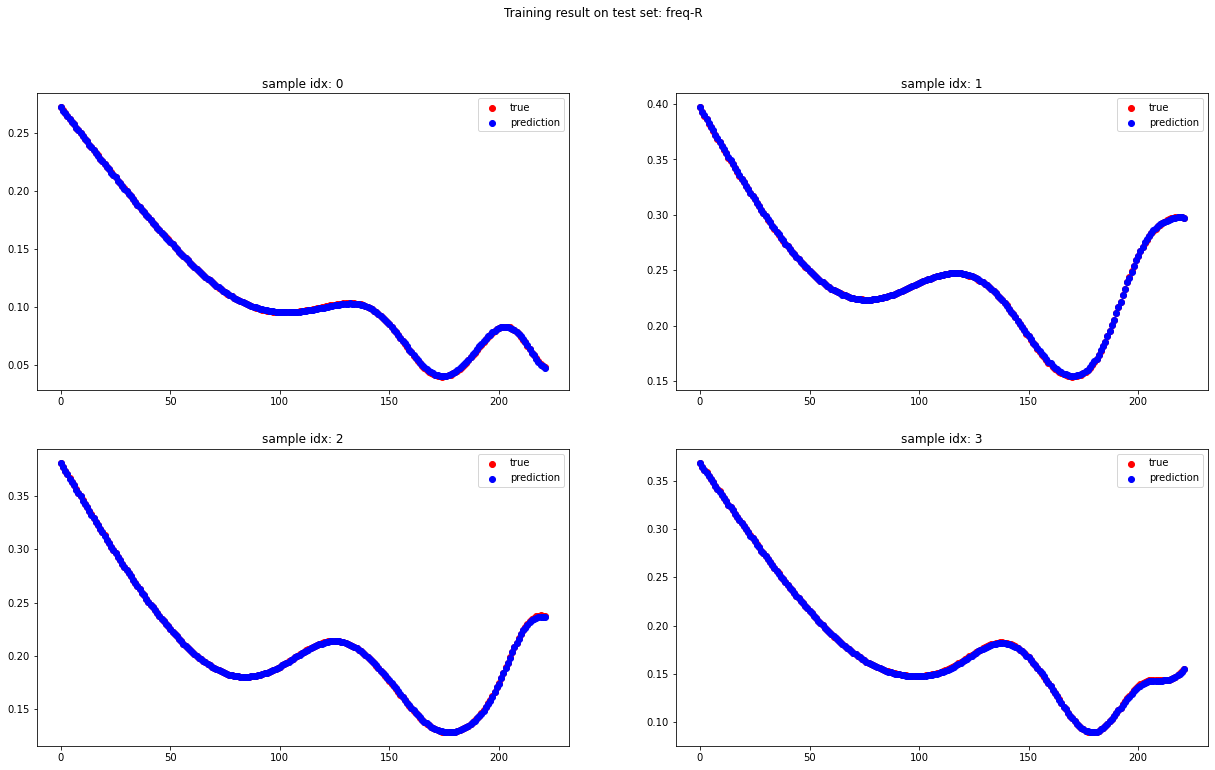

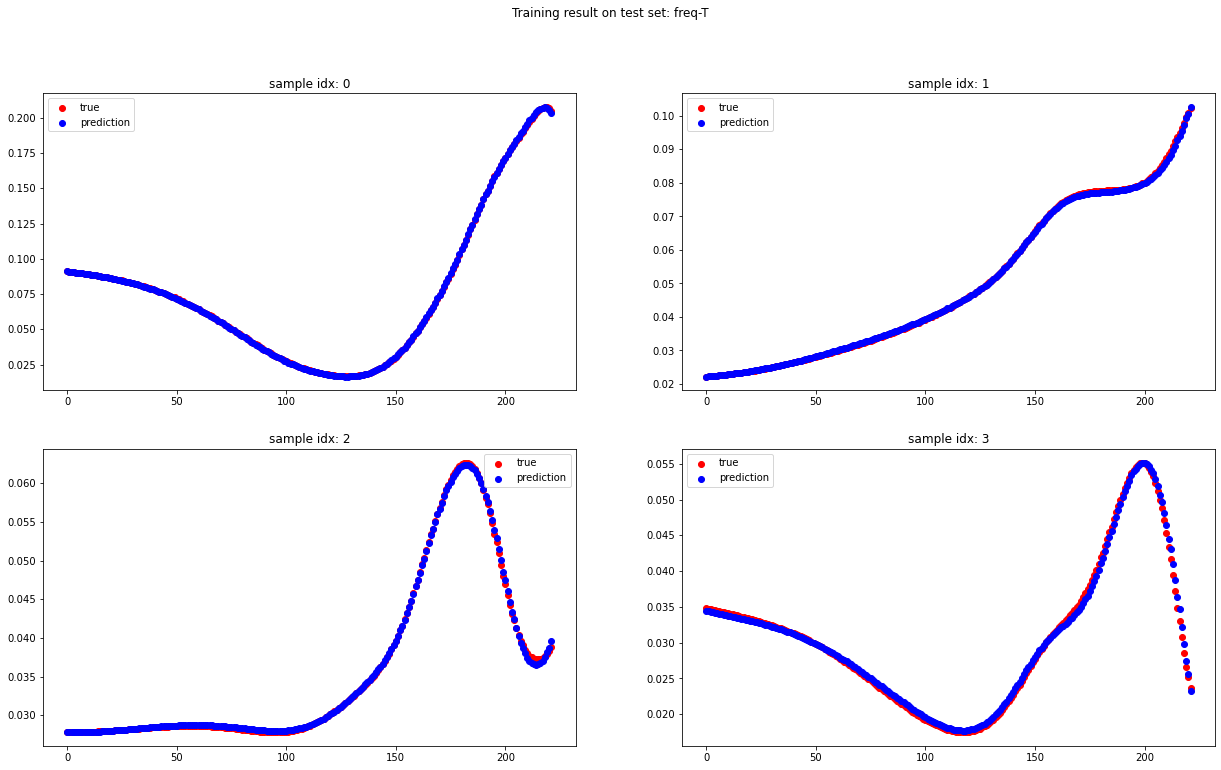

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 50.  53. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  54. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 50.  55. 160.  75.]
 [ 51.  52. 160.  75.]
 [ 50.  56. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


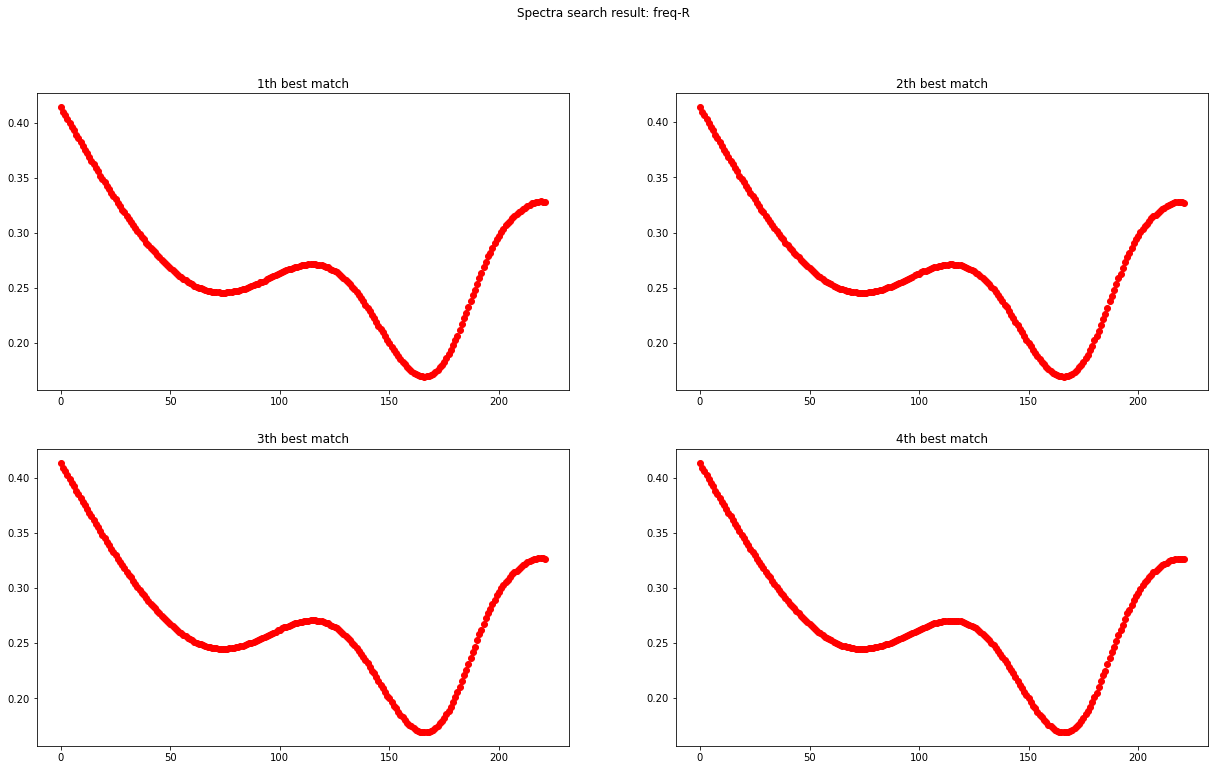

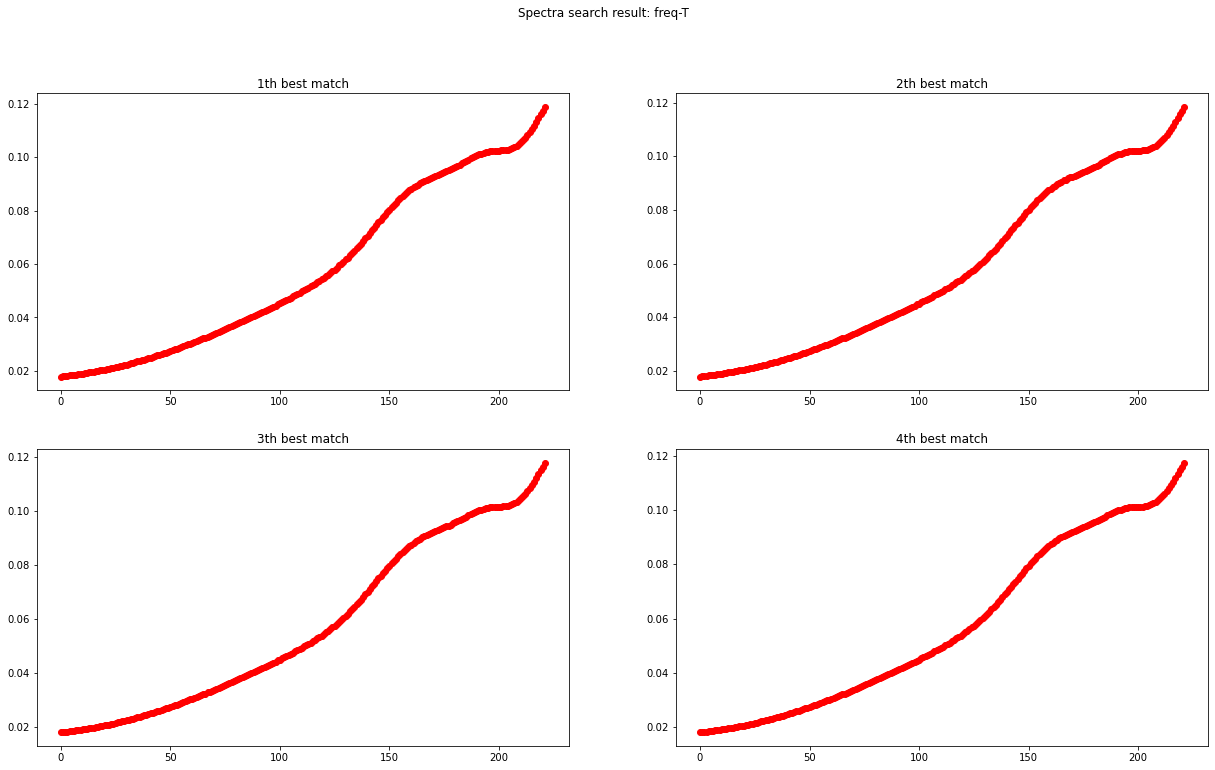

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.0177423545729311


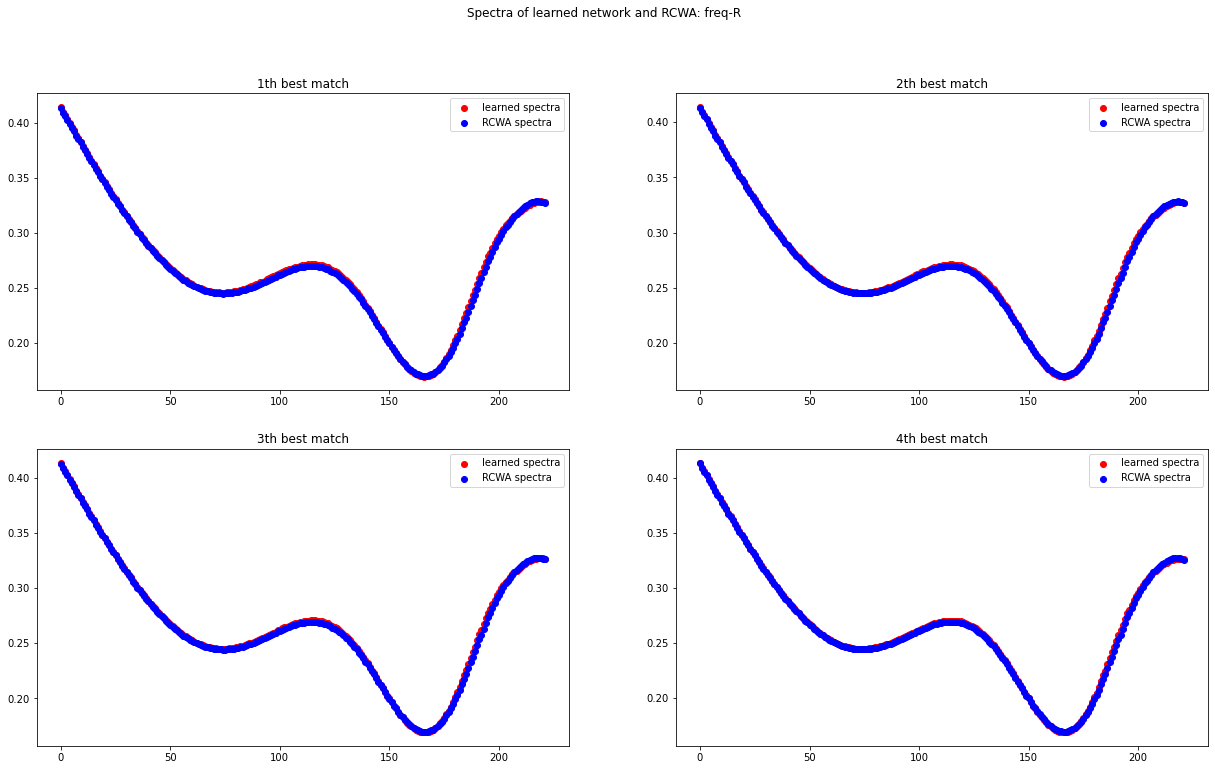

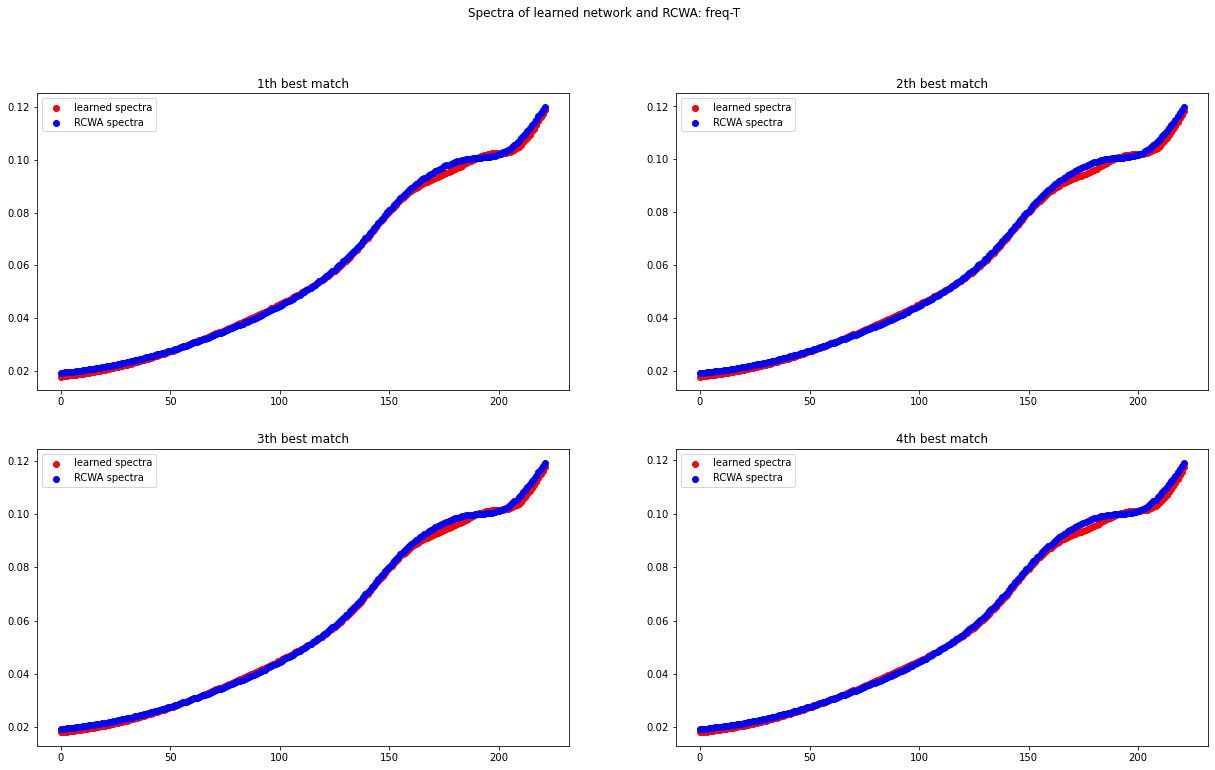

** Model saved.
**************************** ROUND 7 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 350
Sample points number available, continue calculating...
----------------
[ 1 / 50 ] [D1, D2] = [123.  76.]
Calculation Progress: 100%
----------------
[ 2 / 50 ] [D1, D2] = [144. 135.]
Calculation Progress: 100%
----------------
[ 3 / 50 ] [D1, D2] = [143. 120.]
Calculation Progress: 100%
----------------
[ 4 / 50 ] [D1, D2] = [73. 87.]
Calculation Progress: 100%
----------------
[ 5 / 50 ] [D1, D2] = [103. 126.]
Calculation Progress: 100%
----------------
[ 6 / 50 ] [D1, D2] = [138. 127.]
Calculation Progress: 100%
----------------
[ 7 / 50 ] [D1, D2] = [ 86. 111.]
Calculation Progress: 100%
----------------
[ 8 / 50 ] [D1, D2] = [ 77. 138.]
Calculation Progress: 100%
----------------
[ 9 / 50 ] [D1, D2] = [143. 111.]
Calculation Progress: 100%
----------------
[ 10 / 50 ] [D1, D2] = [123. 118.]
Calculation Progress: 

----------------------------------------------------------------------
*** EPOCH 26 || AVG LOSS 3.248115317059533e-06
### TEST LOSS  4.717927064727216e-06
----------------------------------------------------------------------
*** EPOCH 27 || AVG LOSS 2.939318016420397e-06
### TEST LOSS  2.5968772661144612e-06
----------------------------------------------------------------------
*** EPOCH 28 || AVG LOSS 2.400118018580802e-06
### TEST LOSS  3.012428881750869e-06
----------------------------------------------------------------------
*** EPOCH 29 || AVG LOSS 2.960946591445333e-06
### TEST LOSS  3.2909909653729605e-06
----------------------------------------------------------------------
*** EPOCH 30 || AVG LOSS 3.192496371866582e-06
### TEST LOSS  2.576690102766103e-06
----------------------------------------------------------------------
*** EPOCH 31 || AVG LOSS 2.5045577172834655e-06
### TEST LOSS  2.342935393547426e-06
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 79 || AVG LOSS 1.031145018341054e-06
### TEST LOSS  1.201007383618465e-06
----------------------------------------------------------------------
*** EPOCH 80 || AVG LOSS 1.1776901103287075e-06
### TEST LOSS  2.3432711486748303e-06
----------------------------------------------------------------------
*** EPOCH 81 || AVG LOSS 9.420144715883387e-07
### TEST LOSS  1.3235194463353157e-06
----------------------------------------------------------------------
*** EPOCH 82 || AVG LOSS 1.4684875809832323e-06
### TEST LOSS  1.0239920603301773e-06
----------------------------------------------------------------------
*** EPOCH 83 || AVG LOSS 1.8631518673828396e-06
### TEST LOSS  6.464394402883045e-06
----------------------------------------------------------------------
*** EPOCH 84 || AVG LOSS 1.65433295933326e-06
### TEST LOSS  9.518817212968619e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 132 || AVG LOSS 8.122440082404734e-07
### TEST LOSS  1.2807640435615515e-06
----------------------------------------------------------------------
*** EPOCH 133 || AVG LOSS 1.7022102580556618e-06
### TEST LOSS  1.965618290948138e-06
----------------------------------------------------------------------
*** EPOCH 134 || AVG LOSS 1.3013234687215507e-06
### TEST LOSS  7.557765210700987e-07
----------------------------------------------------------------------
*** EPOCH 135 || AVG LOSS 1.5790632803763012e-06
### TEST LOSS  2.323348780919332e-06
----------------------------------------------------------------------
*** EPOCH 136 || AVG LOSS 5.289051171238108e-06
### TEST LOSS  9.456746662787433e-06
----------------------------------------------------------------------
*** EPOCH 137 || AVG LOSS 5.658680102962015e-06
### TEST LOSS  1.3733392449921666e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 185 || AVG LOSS 6.762122708080044e-07
### TEST LOSS  4.0304666034292797e-07
----------------------------------------------------------------------
*** EPOCH 186 || AVG LOSS 7.699811651816292e-07
### TEST LOSS  9.512819948061709e-07
----------------------------------------------------------------------
*** EPOCH 187 || AVG LOSS 6.267562398777824e-07
### TEST LOSS  5.076235254364292e-07
----------------------------------------------------------------------
*** EPOCH 188 || AVG LOSS 5.287454506230915e-07
### TEST LOSS  4.430961553225643e-07
----------------------------------------------------------------------
*** EPOCH 189 || AVG LOSS 6.112352442398463e-07
### TEST LOSS  5.60042063095049e-07
----------------------------------------------------------------------
*** EPOCH 190 || AVG LOSS 5.715800692282106e-07
### TEST LOSS  7.782935161534018e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 238 || AVG LOSS 6.20738618713241e-07
### TEST LOSS  5.809625444423242e-07
----------------------------------------------------------------------
*** EPOCH 239 || AVG LOSS 4.909338434393768e-07
### TEST LOSS  4.051078311325303e-07
----------------------------------------------------------------------
*** EPOCH 240 || AVG LOSS 4.167629706890758e-07
### TEST LOSS  3.2858680280393554e-07
----------------------------------------------------------------------
*** EPOCH 241 || AVG LOSS 5.179691974888101e-07
### TEST LOSS  5.36399037779726e-07
----------------------------------------------------------------------
*** EPOCH 242 || AVG LOSS 5.197451322861266e-07
### TEST LOSS  5.98056203671149e-07
----------------------------------------------------------------------
*** EPOCH 243 || AVG LOSS 5.07732643768577e-07
### TEST LOSS  1.2726831452406866e-06
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 291 || AVG LOSS 6.673131233826877e-07
### TEST LOSS  4.76378611817078e-07
----------------------------------------------------------------------
*** EPOCH 292 || AVG LOSS 5.909360172446603e-07
### TEST LOSS  3.4195027372637316e-07
----------------------------------------------------------------------
*** EPOCH 293 || AVG LOSS 5.427843924467522e-07
### TEST LOSS  7.837913832039097e-07
----------------------------------------------------------------------
*** EPOCH 294 || AVG LOSS 5.044044162819513e-07
### TEST LOSS  6.100347415364619e-07
----------------------------------------------------------------------
*** EPOCH 295 || AVG LOSS 5.071485841564741e-07
### TEST LOSS  4.800521082870546e-07
----------------------------------------------------------------------
*** EPOCH 296 || AVG LOSS 4.840668973469876e-07
### TEST LOSS  4.5404996266521874e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 344 || AVG LOSS 4.124703865621931e-07
### TEST LOSS  3.603626434293498e-07
----------------------------------------------------------------------
*** EPOCH 345 || AVG LOSS 4.2015186099523103e-07
### TEST LOSS  5.294107126019298e-07
----------------------------------------------------------------------
*** EPOCH 346 || AVG LOSS 6.457608750817404e-07
### TEST LOSS  3.5663434516663983e-07
----------------------------------------------------------------------
*** EPOCH 347 || AVG LOSS 5.878426975008162e-07
### TEST LOSS  4.187261121539147e-07
----------------------------------------------------------------------
*** EPOCH 348 || AVG LOSS 4.4719812669719823e-07
### TEST LOSS  3.5962189315341675e-07
----------------------------------------------------------------------
*** EPOCH 349 || AVG LOSS 5.664489568906511e-07
### TEST LOSS  3.743191191081981e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 397 || AVG LOSS 4.673712168872563e-07
### TEST LOSS  7.918910493269019e-07
----------------------------------------------------------------------
*** EPOCH 398 || AVG LOSS 4.615020096870077e-07
### TEST LOSS  5.585591035620988e-07
----------------------------------------------------------------------
*** EPOCH 399 || AVG LOSS 3.8590092801525444e-07
### TEST LOSS  3.61068174470347e-07
----------------------------------------------------------------------
*** EPOCH 400 || AVG LOSS 3.7763530579176013e-07
### TEST LOSS  3.5947157073223934e-07
----------------------------------------------------------------------
*** EPOCH 401 || AVG LOSS 4.604712802042903e-07
### TEST LOSS  3.40436476638691e-07
----------------------------------------------------------------------
*** EPOCH 402 || AVG LOSS 4.54130378305503e-07
### TEST LOSS  4.40262544051014e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 450 || AVG LOSS 4.157372029567341e-07
### TEST LOSS  4.812040780658814e-07
----------------------------------------------------------------------
*** EPOCH 451 || AVG LOSS 3.595489393960958e-07
### TEST LOSS  4.0625138808536576e-07
----------------------------------------------------------------------
*** EPOCH 452 || AVG LOSS 4.0762181531103385e-07
### TEST LOSS  6.06132611361924e-07
----------------------------------------------------------------------
*** EPOCH 453 || AVG LOSS 4.2191085116525884e-07
### TEST LOSS  2.94943475864784e-07
----------------------------------------------------------------------
*** EPOCH 454 || AVG LOSS 4.4256785392755255e-07
### TEST LOSS  3.4420556952833675e-07
----------------------------------------------------------------------
*** EPOCH 455 || AVG LOSS 4.542050538702824e-07
### TEST LOSS  4.959359595583616e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 503 || AVG LOSS 5.232966413919777e-07
### TEST LOSS  3.0587691905263153e-07
----------------------------------------------------------------------
*** EPOCH 504 || AVG LOSS 5.286184533304095e-07
### TEST LOSS  4.903149649256496e-07
----------------------------------------------------------------------
*** EPOCH 505 || AVG LOSS 5.238919589954451e-07
### TEST LOSS  3.236736745293456e-07
----------------------------------------------------------------------
*** EPOCH 506 || AVG LOSS 4.617303003584539e-07
### TEST LOSS  3.5048950527046446e-07
----------------------------------------------------------------------
*** EPOCH 507 || AVG LOSS 4.318892183009991e-07
### TEST LOSS  4.846446775748822e-07
----------------------------------------------------------------------
*** EPOCH 508 || AVG LOSS 3.6390619709233565e-07
### TEST LOSS  3.561470596954071e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 556 || AVG LOSS 3.8035812313605024e-07
### TEST LOSS  3.2997478645787243e-07
----------------------------------------------------------------------
*** EPOCH 557 || AVG LOSS 4.6902243026027335e-07
### TEST LOSS  9.715122265182192e-07
----------------------------------------------------------------------
*** EPOCH 558 || AVG LOSS 4.4184653274572026e-07
### TEST LOSS  3.0195980116332066e-07
----------------------------------------------------------------------
*** EPOCH 559 || AVG LOSS 8.460632037911507e-07
### TEST LOSS  3.283836917944427e-07
----------------------------------------------------------------------
*** EPOCH 560 || AVG LOSS 4.023608392904927e-07
### TEST LOSS  3.4376676675644074e-07
----------------------------------------------------------------------
*** EPOCH 561 || AVG LOSS 3.6232031470311607e-07
### TEST LOSS  2.9294925478022077e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 609 || AVG LOSS 5.13881640021704e-07
### TEST LOSS  3.7133982289105916e-07
----------------------------------------------------------------------
*** EPOCH 610 || AVG LOSS 3.6214099088129255e-07
### TEST LOSS  6.239954946825795e-07
----------------------------------------------------------------------
*** EPOCH 611 || AVG LOSS 3.46826086641272e-07
### TEST LOSS  2.8639819997048715e-07
----------------------------------------------------------------------
*** EPOCH 612 || AVG LOSS 3.512252173314729e-07
### TEST LOSS  2.522606597684292e-07
----------------------------------------------------------------------
*** EPOCH 613 || AVG LOSS 3.0714149697733516e-07
### TEST LOSS  4.096859432441609e-07
----------------------------------------------------------------------
*** EPOCH 614 || AVG LOSS 4.772611354399357e-07
### TEST LOSS  2.9016544071206834e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 662 || AVG LOSS 3.4319983377884e-07
### TEST LOSS  4.751157784236663e-07
----------------------------------------------------------------------
*** EPOCH 663 || AVG LOSS 3.9242891401970935e-07
### TEST LOSS  3.588849466495958e-07
----------------------------------------------------------------------
*** EPOCH 664 || AVG LOSS 3.756496584575838e-07
### TEST LOSS  3.177575488659083e-07
----------------------------------------------------------------------
*** EPOCH 665 || AVG LOSS 4.5413798943627626e-07
### TEST LOSS  2.540495174230273e-07
----------------------------------------------------------------------
*** EPOCH 666 || AVG LOSS 4.7441127004991097e-07
### TEST LOSS  5.631961954577491e-07
----------------------------------------------------------------------
*** EPOCH 667 || AVG LOSS 3.94769896122479e-07
### TEST LOSS  3.6148553306247777e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 715 || AVG LOSS 7.617661958241634e-07
### TEST LOSS  5.769241321710675e-07
----------------------------------------------------------------------
*** EPOCH 716 || AVG LOSS 4.313379977004063e-07
### TEST LOSS  2.8953858569972607e-07
----------------------------------------------------------------------
*** EPOCH 717 || AVG LOSS 3.6362810225755633e-07
### TEST LOSS  3.6010299453437256e-07
----------------------------------------------------------------------
*** EPOCH 718 || AVG LOSS 4.009448965445829e-07
### TEST LOSS  3.560379819115648e-07
----------------------------------------------------------------------
*** EPOCH 719 || AVG LOSS 4.170312583491003e-07
### TEST LOSS  3.2315639941771224e-07
----------------------------------------------------------------------
*** EPOCH 720 || AVG LOSS 3.2875783513678213e-07
### TEST LOSS  3.4048860205378634e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 768 || AVG LOSS 3.747500381073061e-07
### TEST LOSS  2.2473789348017212e-07
----------------------------------------------------------------------
*** EPOCH 769 || AVG LOSS 3.034471113595925e-07
### TEST LOSS  2.4583049433128207e-07
----------------------------------------------------------------------
*** EPOCH 770 || AVG LOSS 3.432528338923443e-07
### TEST LOSS  3.7820272306513897e-07
----------------------------------------------------------------------
*** EPOCH 771 || AVG LOSS 3.269924371198028e-07
### TEST LOSS  2.679319213901484e-07
----------------------------------------------------------------------
*** EPOCH 772 || AVG LOSS 4.12003434360843e-07
### TEST LOSS  2.475301196606476e-07
----------------------------------------------------------------------
*** EPOCH 773 || AVG LOSS 3.4222212048819397e-07
### TEST LOSS  3.394952680461453e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 821 || AVG LOSS 3.7111156562527216e-07
### TEST LOSS  3.455483152947636e-07
----------------------------------------------------------------------
*** EPOCH 822 || AVG LOSS 3.5687778927849324e-07
### TEST LOSS  2.4691729549886077e-07
----------------------------------------------------------------------
*** EPOCH 823 || AVG LOSS 3.3851920662186784e-07
### TEST LOSS  4.823440112507645e-07
----------------------------------------------------------------------
*** EPOCH 824 || AVG LOSS 2.9469804048736544e-07
### TEST LOSS  4.2617844542292005e-07
----------------------------------------------------------------------
*** EPOCH 825 || AVG LOSS 3.402682030996727e-07
### TEST LOSS  2.388609180078068e-07
----------------------------------------------------------------------
*** EPOCH 826 || AVG LOSS 4.012905031304724e-07
### TEST LOSS  2.534693687531823e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 874 || AVG LOSS 3.9669223987459647e-07
### TEST LOSS  4.0771559876399505e-07
----------------------------------------------------------------------
*** EPOCH 875 || AVG LOSS 3.094098306632986e-07
### TEST LOSS  2.3726704038532867e-07
----------------------------------------------------------------------
*** EPOCH 876 || AVG LOSS 4.120280682684552e-07
### TEST LOSS  2.3626620067792223e-07
----------------------------------------------------------------------
*** EPOCH 877 || AVG LOSS 5.144809029340129e-07
### TEST LOSS  4.0080567487166263e-07
----------------------------------------------------------------------
*** EPOCH 878 || AVG LOSS 3.24783450439879e-07
### TEST LOSS  5.10520763441491e-07
----------------------------------------------------------------------
*** EPOCH 879 || AVG LOSS 3.613246193927872e-07
### TEST LOSS  2.573622950308163e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 927 || AVG LOSS 3.123553730789906e-07
### TEST LOSS  4.4087330290191556e-07
----------------------------------------------------------------------
*** EPOCH 928 || AVG LOSS 3.143336618701856e-07
### TEST LOSS  3.264160615875274e-07
----------------------------------------------------------------------
*** EPOCH 929 || AVG LOSS 3.3833770266206946e-07
### TEST LOSS  3.226373124221027e-07
----------------------------------------------------------------------
*** EPOCH 930 || AVG LOSS 2.84782614161015e-07
### TEST LOSS  3.3128812996589357e-07
----------------------------------------------------------------------
*** EPOCH 931 || AVG LOSS 4.3707859550831276e-07
### TEST LOSS  3.5265499320757954e-07
----------------------------------------------------------------------
*** EPOCH 932 || AVG LOSS 3.2086080626722184e-07
### TEST LOSS  2.514722652335877e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 980 || AVG LOSS 3.0227995261660517e-07
### TEST LOSS  3.2860532902153256e-07
----------------------------------------------------------------------
*** EPOCH 981 || AVG LOSS 4.57428488798785e-07
### TEST LOSS  4.015920277803768e-07
----------------------------------------------------------------------
*** EPOCH 982 || AVG LOSS 3.4880565887566005e-07
### TEST LOSS  2.570574319330869e-07
----------------------------------------------------------------------
*** EPOCH 983 || AVG LOSS 5.252951785093631e-07
### TEST LOSS  2.447885890433099e-06
----------------------------------------------------------------------
*** EPOCH 984 || AVG LOSS 1.0009687837810232e-06
### TEST LOSS  1.388938377052303e-06
----------------------------------------------------------------------
*** EPOCH 985 || AVG LOSS 5.4768281001673e-07
### TEST LOSS  4.652147017244109e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1033 || AVG LOSS 4.4342772515701005e-07
### TEST LOSS  2.8096429597705236e-07
----------------------------------------------------------------------
*** EPOCH 1034 || AVG LOSS 3.3568268635113846e-07
### TEST LOSS  4.139342119439486e-07
----------------------------------------------------------------------
*** EPOCH 1035 || AVG LOSS 4.258600231464373e-07
### TEST LOSS  3.4968746594662054e-07
----------------------------------------------------------------------
*** EPOCH 1036 || AVG LOSS 3.520324604165483e-07
### TEST LOSS  4.1729815810261545e-07
----------------------------------------------------------------------
*** EPOCH 1037 || AVG LOSS 5.27507849688342e-07
### TEST LOSS  6.455813377215236e-07
----------------------------------------------------------------------
*** EPOCH 1038 || AVG LOSS 4.887232803290381e-07
### TEST LOSS  3.283975047452259e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1085 || AVG LOSS 3.9096543638095225e-07
### TEST LOSS  2.6368009997668196e-07
----------------------------------------------------------------------
*** EPOCH 1086 || AVG LOSS 3.481583428716866e-07
### TEST LOSS  4.65476110396897e-07
----------------------------------------------------------------------
*** EPOCH 1087 || AVG LOSS 3.444425258740986e-07
### TEST LOSS  4.47464908385579e-07
----------------------------------------------------------------------
*** EPOCH 1088 || AVG LOSS 3.084976009302766e-07
### TEST LOSS  4.7111159536446695e-07
----------------------------------------------------------------------
*** EPOCH 1089 || AVG LOSS 4.317478989739649e-07
### TEST LOSS  2.3436551307061867e-07
----------------------------------------------------------------------
*** EPOCH 1090 || AVG LOSS 2.9583780033703986e-07
### TEST LOSS  3.0381683776189067e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1137 || AVG LOSS 2.6393152780761806e-07
### TEST LOSS  4.523654174211818e-07
----------------------------------------------------------------------
*** EPOCH 1138 || AVG LOSS 3.211490981820069e-07
### TEST LOSS  2.3780773735400848e-07
----------------------------------------------------------------------
*** EPOCH 1139 || AVG LOSS 3.804558500166065e-07
### TEST LOSS  2.6799296648505333e-07
----------------------------------------------------------------------
*** EPOCH 1140 || AVG LOSS 2.9511660551000725e-07
### TEST LOSS  2.34170994891277e-07
----------------------------------------------------------------------
*** EPOCH 1141 || AVG LOSS 2.7170223356774515e-07
### TEST LOSS  2.1603420208293755e-07
----------------------------------------------------------------------
*** EPOCH 1142 || AVG LOSS 3.2636063325851084e-07
### TEST LOSS  5.563880639177418e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1189 || AVG LOSS 3.190696574303534e-07
### TEST LOSS  2.615718746786418e-07
----------------------------------------------------------------------
*** EPOCH 1190 || AVG LOSS 2.7980363348945047e-07
### TEST LOSS  2.955612927735274e-07
----------------------------------------------------------------------
*** EPOCH 1191 || AVG LOSS 2.582756390572578e-07
### TEST LOSS  2.284585794617063e-07
----------------------------------------------------------------------
*** EPOCH 1192 || AVG LOSS 2.6430031881423995e-07
### TEST LOSS  2.2634844043523117e-07
----------------------------------------------------------------------
*** EPOCH 1193 || AVG LOSS 3.282514519448958e-07
### TEST LOSS  2.609818305169635e-07
----------------------------------------------------------------------
*** EPOCH 1194 || AVG LOSS 2.92318775854434e-07
### TEST LOSS  2.481328138514982e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1241 || AVG LOSS 3.463389549145696e-07
### TEST LOSS  2.444641040710849e-07
----------------------------------------------------------------------
*** EPOCH 1242 || AVG LOSS 2.629956054229459e-07
### TEST LOSS  3.141757360936026e-07
----------------------------------------------------------------------
*** EPOCH 1243 || AVG LOSS 3.1377014247522897e-07
### TEST LOSS  2.7352783623276383e-07
----------------------------------------------------------------------
*** EPOCH 1244 || AVG LOSS 3.283238340299834e-07
### TEST LOSS  2.3652508218674484e-07
----------------------------------------------------------------------
*** EPOCH 1245 || AVG LOSS 2.706623965817049e-07
### TEST LOSS  2.1695936662050977e-07
----------------------------------------------------------------------
*** EPOCH 1246 || AVG LOSS 2.766327485050267e-07
### TEST LOSS  2.3216420667419394e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1293 || AVG LOSS 2.439690660034038e-07
### TEST LOSS  2.999525131978468e-07
----------------------------------------------------------------------
*** EPOCH 1294 || AVG LOSS 3.8810522248411414e-07
### TEST LOSS  2.6359393482759213e-07
----------------------------------------------------------------------
*** EPOCH 1295 || AVG LOSS 1.8943408644795617e-06
### TEST LOSS  5.827907064788936e-06
----------------------------------------------------------------------
*** EPOCH 1296 || AVG LOSS 1.2038775414323156e-06
### TEST LOSS  5.212159095435709e-07
----------------------------------------------------------------------
*** EPOCH 1297 || AVG LOSS 4.093878124170455e-07
### TEST LOSS  3.4795111976867094e-07
----------------------------------------------------------------------
*** EPOCH 1298 || AVG LOSS 3.71549754214178e-07
### TEST LOSS  2.85551820411456e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1345 || AVG LOSS 2.341622475045467e-07
### TEST LOSS  2.67420209828136e-07
----------------------------------------------------------------------
*** EPOCH 1346 || AVG LOSS 3.333247262357223e-07
### TEST LOSS  2.2477196400435181e-07
----------------------------------------------------------------------
*** EPOCH 1347 || AVG LOSS 3.3094522491085494e-07
### TEST LOSS  2.269319002342248e-07
----------------------------------------------------------------------
*** EPOCH 1348 || AVG LOSS 4.367275319136102e-07
### TEST LOSS  4.633254349073468e-07
----------------------------------------------------------------------
*** EPOCH 1349 || AVG LOSS 3.1723797974336774e-07
### TEST LOSS  5.565609058066912e-07
----------------------------------------------------------------------
*** EPOCH 1350 || AVG LOSS 2.666817175724288e-07
### TEST LOSS  1.7921144745969286e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1397 || AVG LOSS 2.522959694317706e-07
### TEST LOSS  2.3327738792507566e-07
----------------------------------------------------------------------
*** EPOCH 1398 || AVG LOSS 2.5946377047400153e-07
### TEST LOSS  1.946625260984547e-07
----------------------------------------------------------------------
*** EPOCH 1399 || AVG LOSS 2.444228630642848e-07
### TEST LOSS  2.6577117987850823e-07
----------------------------------------------------------------------
*** EPOCH 1400 || AVG LOSS 3.2583754543022026e-07
### TEST LOSS  3.009405749783885e-07
----------------------------------------------------------------------
*** EPOCH 1401 || AVG LOSS 2.970794241312953e-07
### TEST LOSS  3.300614868824899e-07
----------------------------------------------------------------------
*** EPOCH 1402 || AVG LOSS 2.8866600874469636e-07
### TEST LOSS  2.3386533835415926e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1449 || AVG LOSS 2.7197546325550906e-07
### TEST LOSS  1.8022344505652654e-07
----------------------------------------------------------------------
*** EPOCH 1450 || AVG LOSS 2.426958521490568e-07
### TEST LOSS  2.3223476119937914e-07
----------------------------------------------------------------------
*** EPOCH 1451 || AVG LOSS 2.9589123133380976e-07
### TEST LOSS  3.115491319742129e-07
----------------------------------------------------------------------
*** EPOCH 1452 || AVG LOSS 3.2459705533735167e-07
### TEST LOSS  4.884406668755522e-07
----------------------------------------------------------------------
*** EPOCH 1453 || AVG LOSS 2.65433775764125e-07
### TEST LOSS  1.928321466948546e-07
----------------------------------------------------------------------
*** EPOCH 1454 || AVG LOSS 2.8270310490289116e-07
### TEST LOSS  2.5095481959169774e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1501 || AVG LOSS 2.4067972191232913e-07
### TEST LOSS  3.5814188000434416e-07
----------------------------------------------------------------------
*** EPOCH 1502 || AVG LOSS 3.139163660088278e-07
### TEST LOSS  4.025381912242665e-07
----------------------------------------------------------------------
*** EPOCH 1503 || AVG LOSS 3.2529471624798137e-07
### TEST LOSS  3.9620863390155137e-07
----------------------------------------------------------------------
*** EPOCH 1504 || AVG LOSS 2.5373315852204674e-07
### TEST LOSS  2.0973167617436653e-07
----------------------------------------------------------------------
*** EPOCH 1505 || AVG LOSS 3.9142320949687407e-07
### TEST LOSS  2.520642728616925e-07
----------------------------------------------------------------------
*** EPOCH 1506 || AVG LOSS 3.354154839233356e-07
### TEST LOSS  7.845856847173612e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1553 || AVG LOSS 2.7573287611508996e-07
### TEST LOSS  3.788293270190479e-07
----------------------------------------------------------------------
*** EPOCH 1554 || AVG LOSS 3.2802983358440735e-07
### TEST LOSS  5.634885743196113e-07
----------------------------------------------------------------------
*** EPOCH 1555 || AVG LOSS 2.6188205548497274e-07
### TEST LOSS  2.407119884158722e-07
----------------------------------------------------------------------
*** EPOCH 1556 || AVG LOSS 3.0656312304699896e-07
### TEST LOSS  4.760044826449909e-07
----------------------------------------------------------------------
*** EPOCH 1557 || AVG LOSS 3.189870995307891e-07
### TEST LOSS  2.1245003741417653e-07
----------------------------------------------------------------------
*** EPOCH 1558 || AVG LOSS 2.471348746979629e-07
### TEST LOSS  2.011647145157743e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1605 || AVG LOSS 2.6139882247580965e-07
### TEST LOSS  2.2810479549661977e-07
----------------------------------------------------------------------
*** EPOCH 1606 || AVG LOSS 3.77092443021151e-07
### TEST LOSS  3.4013700656032597e-07
----------------------------------------------------------------------
*** EPOCH 1607 || AVG LOSS 2.844399227797112e-07
### TEST LOSS  2.475987533519704e-07
----------------------------------------------------------------------
*** EPOCH 1608 || AVG LOSS 2.6618190113530153e-07
### TEST LOSS  1.9643125170887288e-07
----------------------------------------------------------------------
*** EPOCH 1609 || AVG LOSS 2.5384401830308434e-07
### TEST LOSS  1.98055734775456e-07
----------------------------------------------------------------------
*** EPOCH 1610 || AVG LOSS 3.548129507484938e-07
### TEST LOSS  2.6186841968941127e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1657 || AVG LOSS 2.992948174096455e-07
### TEST LOSS  2.333122850473046e-07
----------------------------------------------------------------------
*** EPOCH 1658 || AVG LOSS 2.5467330037339965e-07
### TEST LOSS  3.092327768664897e-07
----------------------------------------------------------------------
*** EPOCH 1659 || AVG LOSS 2.976578650658114e-07
### TEST LOSS  2.926625910504299e-07
----------------------------------------------------------------------
*** EPOCH 1660 || AVG LOSS 2.466243590098267e-07
### TEST LOSS  2.1541169559213813e-07
----------------------------------------------------------------------
*** EPOCH 1661 || AVG LOSS 2.4224227267666266e-07
### TEST LOSS  2.0364704056419214e-07
----------------------------------------------------------------------
*** EPOCH 1662 || AVG LOSS 2.84349129283815e-07
### TEST LOSS  2.1554726951459693e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1709 || AVG LOSS 6.240990578833459e-07
### TEST LOSS  2.9060087077444524e-07
----------------------------------------------------------------------
*** EPOCH 1710 || AVG LOSS 3.2371857088264734e-07
### TEST LOSS  2.9129145673323364e-07
----------------------------------------------------------------------
*** EPOCH 1711 || AVG LOSS 2.763000633011968e-07
### TEST LOSS  3.28498643398234e-07
----------------------------------------------------------------------
*** EPOCH 1712 || AVG LOSS 3.456893148978679e-07
### TEST LOSS  5.947720704095142e-07
----------------------------------------------------------------------
*** EPOCH 1713 || AVG LOSS 4.475004029862768e-07
### TEST LOSS  1.9286918728766977e-07
----------------------------------------------------------------------
*** EPOCH 1714 || AVG LOSS 2.3251579882810348e-07
### TEST LOSS  2.320242297552492e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1761 || AVG LOSS 3.9075600288437534e-07
### TEST LOSS  3.1330715444255475e-07
----------------------------------------------------------------------
*** EPOCH 1762 || AVG LOSS 3.111132263049805e-07
### TEST LOSS  2.010640282416413e-07
----------------------------------------------------------------------
*** EPOCH 1763 || AVG LOSS 2.399789947154269e-07
### TEST LOSS  2.777157703803823e-07
----------------------------------------------------------------------
*** EPOCH 1764 || AVG LOSS 2.790281960126809e-07
### TEST LOSS  2.3720840639877375e-07
----------------------------------------------------------------------
*** EPOCH 1765 || AVG LOSS 3.2182789047802933e-07
### TEST LOSS  2.070610681433512e-07
----------------------------------------------------------------------
*** EPOCH 1766 || AVG LOSS 3.59017621219339e-07
### TEST LOSS  2.4169135552180404e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1813 || AVG LOSS 2.483233292086392e-07
### TEST LOSS  1.9804742616239915e-07
----------------------------------------------------------------------
*** EPOCH 1814 || AVG LOSS 2.3063598389074156e-07
### TEST LOSS  2.860063261778123e-07
----------------------------------------------------------------------
*** EPOCH 1815 || AVG LOSS 2.7212597174752774e-07
### TEST LOSS  1.8397805234826592e-07
----------------------------------------------------------------------
*** EPOCH 1816 || AVG LOSS 2.3820010286255769e-07
### TEST LOSS  1.8986861505254637e-07
----------------------------------------------------------------------
*** EPOCH 1817 || AVG LOSS 1.9588323797035758e-07
### TEST LOSS  3.439623128542735e-07
----------------------------------------------------------------------
*** EPOCH 1818 || AVG LOSS 2.3337827857160067e-07
### TEST LOSS  4.291667418480453e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1865 || AVG LOSS 2.5101633764076526e-07
### TEST LOSS  2.4768060787512997e-07
----------------------------------------------------------------------
*** EPOCH 1866 || AVG LOSS 2.3060039173929324e-07
### TEST LOSS  2.703193189290687e-07
----------------------------------------------------------------------
*** EPOCH 1867 || AVG LOSS 2.9648854827257764e-07
### TEST LOSS  4.845587066408067e-07
----------------------------------------------------------------------
*** EPOCH 1868 || AVG LOSS 2.9597613113147807e-07
### TEST LOSS  1.863705444786016e-07
----------------------------------------------------------------------
*** EPOCH 1869 || AVG LOSS 2.381599299537486e-07
### TEST LOSS  2.598263909211103e-07
----------------------------------------------------------------------
*** EPOCH 1870 || AVG LOSS 2.645003357011027e-07
### TEST LOSS  4.2058803728650673e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1917 || AVG LOSS 2.387931823071605e-07
### TEST LOSS  1.881088043849862e-07
----------------------------------------------------------------------
*** EPOCH 1918 || AVG LOSS 2.48342625762835e-07
### TEST LOSS  2.3775818884056812e-07
----------------------------------------------------------------------
*** EPOCH 1919 || AVG LOSS 2.3624721592848832e-07
### TEST LOSS  2.1669550420710948e-07
----------------------------------------------------------------------
*** EPOCH 1920 || AVG LOSS 2.7847475185995206e-07
### TEST LOSS  1.6045748196802379e-07
----------------------------------------------------------------------
*** EPOCH 1921 || AVG LOSS 2.3073140301984755e-07
### TEST LOSS  1.390419524701277e-07
----------------------------------------------------------------------
*** EPOCH 1922 || AVG LOSS 2.3353795478036383e-07
### TEST LOSS  3.95106321586051e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1969 || AVG LOSS 2.207623134101563e-07
### TEST LOSS  2.9998562448933325e-07
----------------------------------------------------------------------
*** EPOCH 1970 || AVG LOSS 3.2694469811847935e-07
### TEST LOSS  1.8220557507220292e-07
----------------------------------------------------------------------
*** EPOCH 1971 || AVG LOSS 3.282579032567615e-07
### TEST LOSS  2.719226396645051e-07
----------------------------------------------------------------------
*** EPOCH 1972 || AVG LOSS 3.08015146960169e-07
### TEST LOSS  2.2823542877858927e-07
----------------------------------------------------------------------
*** EPOCH 1973 || AVG LOSS 2.5558412386114276e-07
### TEST LOSS  2.872546502885598e-07
----------------------------------------------------------------------
*** EPOCH 1974 || AVG LOSS 3.4029136986849345e-07
### TEST LOSS  2.9317046805014496e-07
----------------------------------------------------

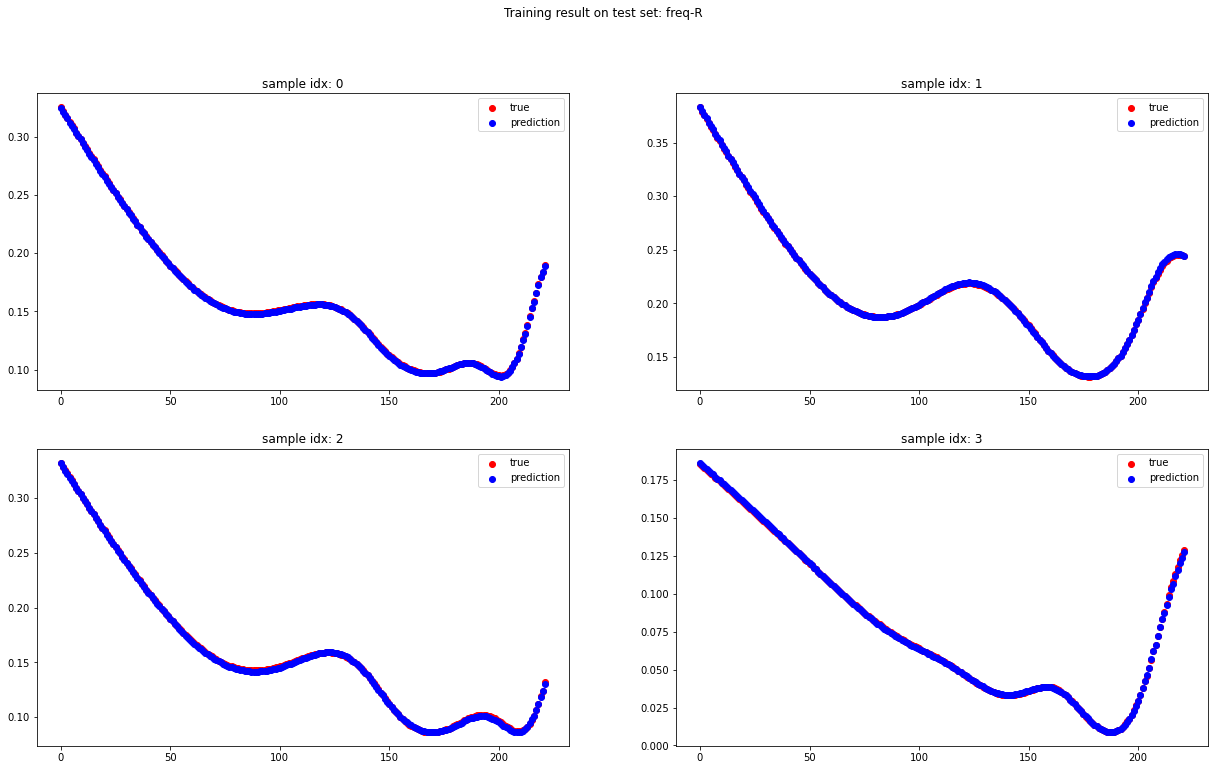

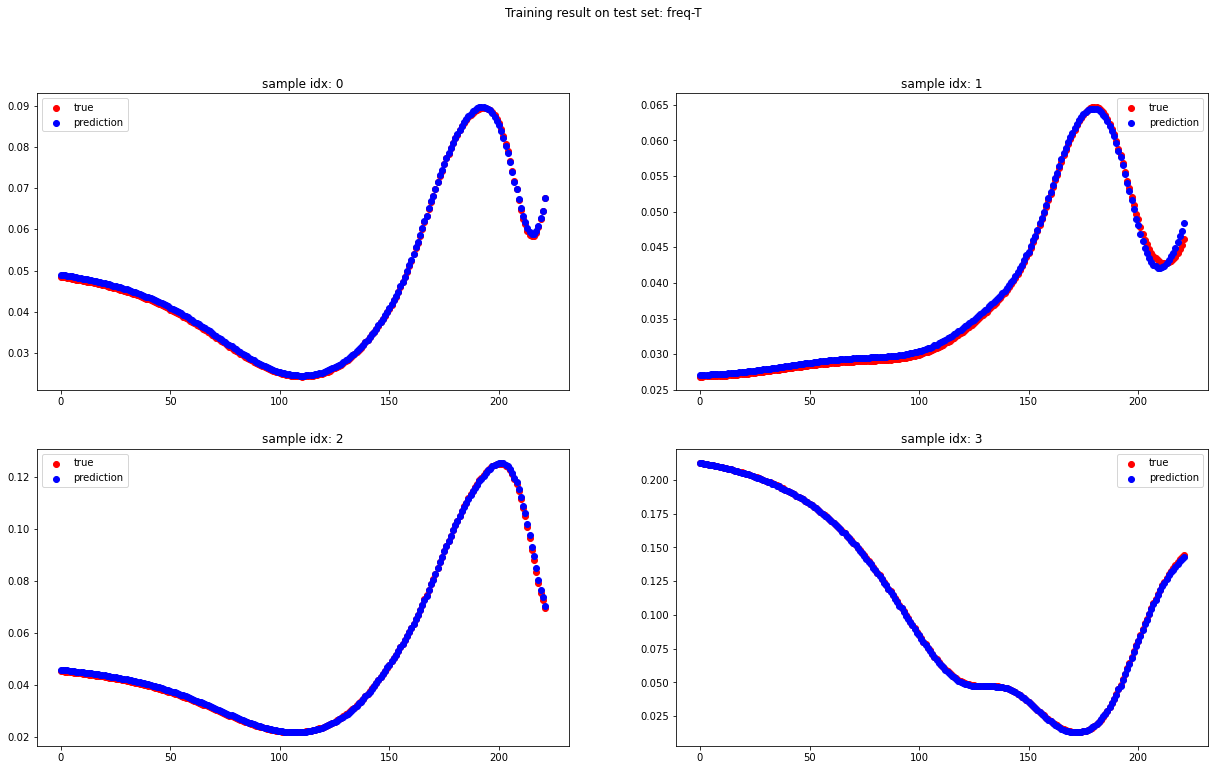

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 50.  53. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  54. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 50.  55. 160.  75.]
 [ 51.  52. 160.  75.]
 [ 50.  56. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


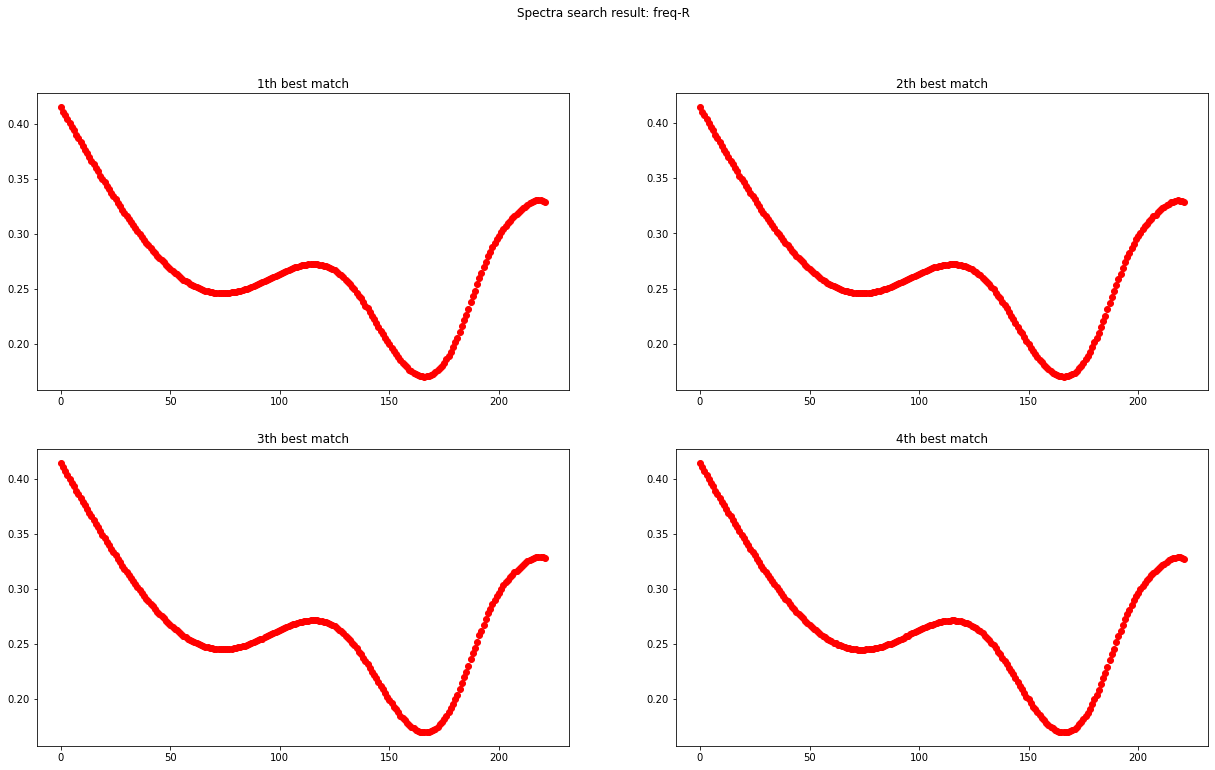

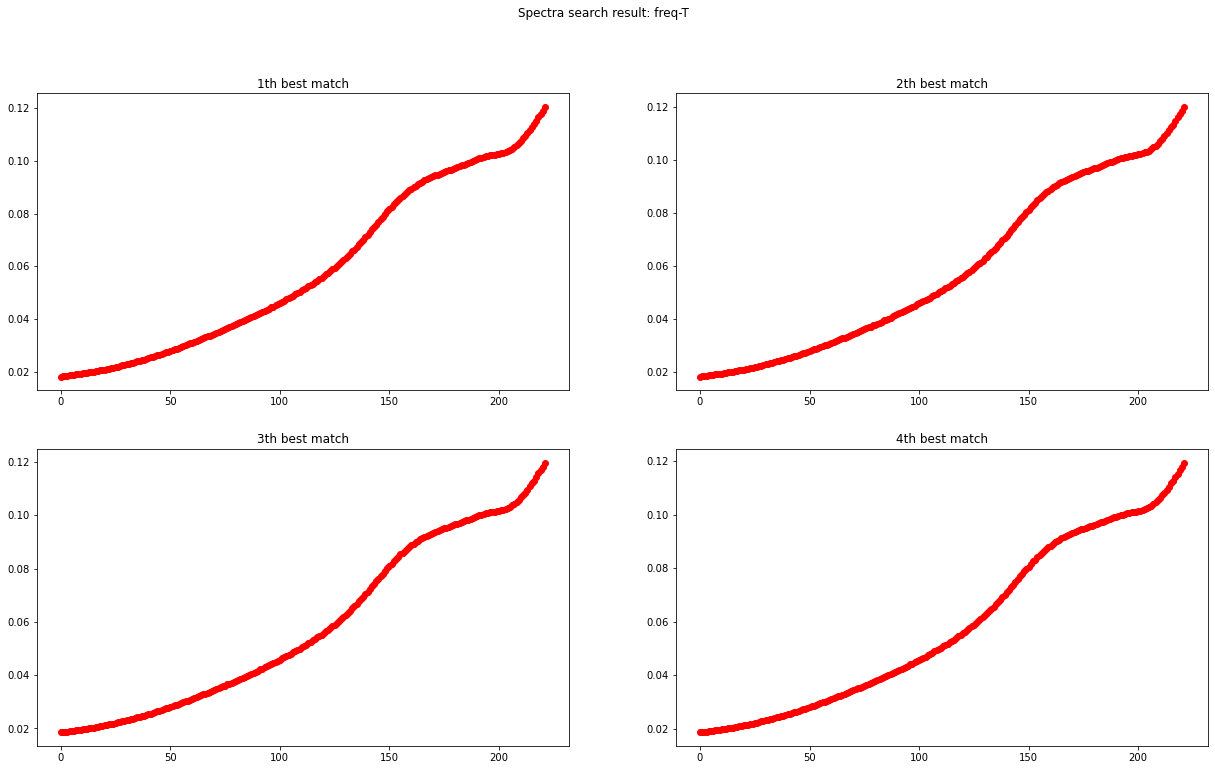

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.017177361629383096


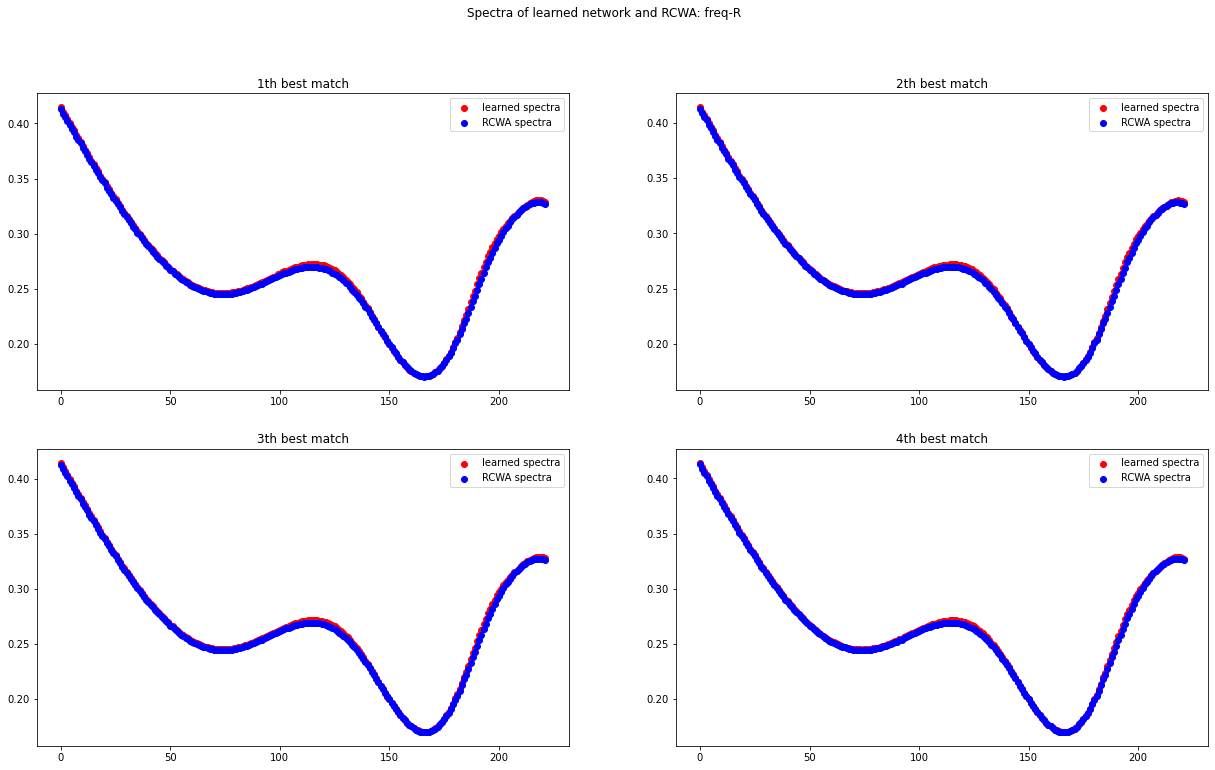

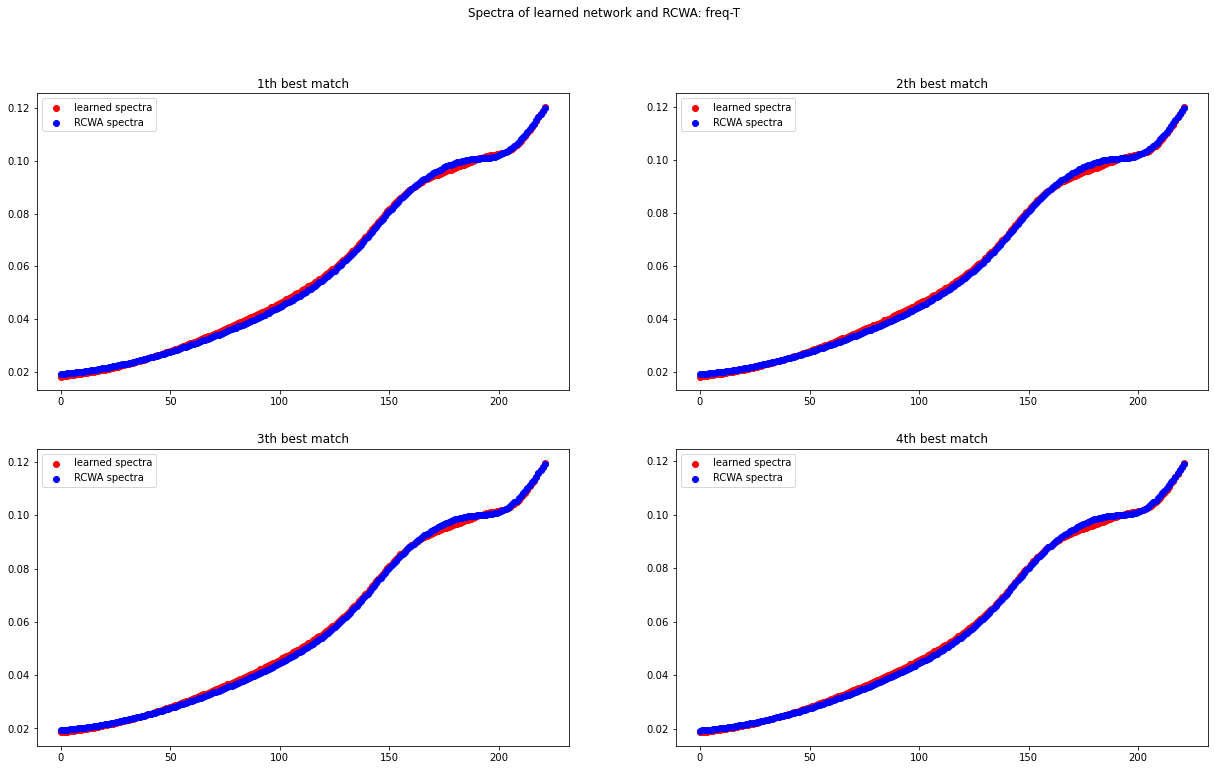

** Model saved.
**************************** ROUND 8 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 400
Sample points number available, continue calculating...
----------------
[ 1 / 50 ] [D1, D2] = [ 63. 101.]
Calculation Progress: 100%
----------------
[ 2 / 50 ] [D1, D2] = [52. 76.]
Calculation Progress: 100%
----------------
[ 3 / 50 ] [D1, D2] = [80. 81.]
Calculation Progress: 100%
----------------
[ 4 / 50 ] [D1, D2] = [93. 91.]
Calculation Progress: 100%
----------------
[ 5 / 50 ] [D1, D2] = [137. 127.]
Calculation Progress: 100%
----------------
[ 6 / 50 ] [D1, D2] = [ 92. 101.]
Calculation Progress: 100%
----------------
[ 7 / 50 ] [D1, D2] = [103.  77.]
Calculation Progress: 100%
----------------
[ 8 / 50 ] [D1, D2] = [134. 133.]
Calculation Progress: 100%
----------------
[ 9 / 50 ] [D1, D2] = [81. 51.]
Calculation Progress: 100%
----------------
[ 10 / 50 ] [D1, D2] = [121. 128.]
Calculation Progress: 100%
-

KeyboardInterrupt: 

In [5]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA Simulation Prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 9  # RCWA accuracy, higher to be more accurate
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate Pseudo Params, [D1, D2] ======
range_D1 = [50,150,1]  # [range_start, range_end, step_size]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
# print(pseudo_params_D1_D2.shape)
# print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]
# print(pseudo_params.shape)
# print(pseudo_params[0])

# ====== Define Target Spectra ======
tg_idx_freq_R = np.array([0,1])
tg_value_R = np.array([3,4])
tg_idx_freq_T = np.array([])
tg_value_T = np.array([])
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 50
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = params
        R_all = R
        T_all = T
    else:
        params_all = np.concatenate((params_all, params), axis=0)
        R_all = np.concatenate((R_all, R), axis=0)
        T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)
    print('R_all.shape:', R_all.shape)
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('** All Rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net_dense = DenseConvTranspose1D(dim_in,dim_out)
        net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 2000  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    param_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('param_pick.shape:', param_pick.shape)
    print('param_pick:', param_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(param_pick, R_pick, T_pick)
    
    # add param list check here to save more time
    
    
    # ====== Run RCWA Search on Picked Params ======
    print('*** Reruning RCWA on picked params')
    rerun_params, R_simu, T_simu = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=param_pick)
    
    print('rerun_params.shape:', rerun_params.shape)
    print('R_simu.shape:', R_simu.shape)  # [N_top, N_freq]
    print('T_simu.shape:', T_simu.shape)
    # loss between learned spectra and simulated spectra
    loss_R = np.average(np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
    loss_T = np.average(np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
    loss_RT_avg = np.average([loss_R, loss_T])
    loss = loss_RT_avg
    
    print('*** Average Loss between Trained Spectra and RCWA Spectra:', loss_RT_avg)
    # visualize learned spectra and RCWA true spectra
    visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    
    # ====== Save Trained Model ======
    PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net_dense.state_dict(), PATH_MODEL)
    print('** Model saved.')
    
#     if ROUND>3:
#         loss = 1e-7
    ROUND += 1
    
plt.ioff()

## Save Trained Model

In [ ]:
PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)
print('Model saved.')